## <center> Convolutional neural network for the Classification of Portraits and Landscape Images </center>
### <center> Haitao Shang </center>

## Dataset

<span style="color:blue">
    WikiArt is an amazing resource containing centuries of artwork.  Since such datasets are wonderful for deep learning, Kaggle has hosted a challenge to characterize the 'fingerprints' of various artists.  The Kaggle dataset contains metadata and also a set of images that have been resized so that the shorter dimension is 256 pixels. Here,we will construct a CNN model to classify some portraits and landscape images
</span>

## Initialization

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
import keras
from sklearn import metrics
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image


from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

        
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()        
        
        
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

Using TensorFlow backend.


## Display some portraits and landscapes in the training, validation, and test set.  

### (1) Split the pictures in training set, validation set, and test set into two categories -- "portrait" and "landscape". 

<span style="color:blue">
We creat three new folders -- "new_train", "new_test", and "new_validation". The folder "new_train" contains two subfolders "train_portrait" and "train_landscape", the folder "new_test" contains two subfolders "test_portrait" and "test_landscape", and the folder "new_validation" contains two subfolders "validation_portrait" and "validation_landscape". 
</span>

In [ ]:
# Split the files in the "train" set into two files "train_portrait" and "train_landscape"：
f=open("./train/train.csv","rb")
list=pd.read_csv(f)

train_category = ['train_portrait', 'train_landscape']
for i in train_category:
    os.mkdir(i)

category = ['portrait', 'landscape']
for i in category:
    listnew=list[list["CATEGORY_ID"]==i]
    l=listnew["FILE_ID"].tolist() 
    new_file = 'train_' + str(i)
    for fname in l:
        src = os.path.join('./train', fname)
        dst = os.path.join(new_file, fname)
        shutil.copyfile(src, dst)
        
# Split the files in the "test" set into two files "test_portrait" and "test_landscape"：
f=open("./test/test.csv","rb")
list=pd.read_csv(f)

train_category = ['test_portrait', 'test_landscape']
for i in train_category:
    os.mkdir(i)

category = ['portrait', 'landscape']
for i in category:
    listnew=list[list["CATEGORY_ID"]==i]
    l=listnew["FIELD_ID"].tolist() 
    new_file = 'test_' + str(i)
    for fname in l:
        src = os.path.join('./test', fname)
        dst = os.path.join(new_file, fname)
        shutil.copyfile(src, dst)
        
# Split the files in the "validation" set into two files "validation_portrait" and "validation_landscape"：
f=open("./validation/validation.csv","rb")
list=pd.read_csv(f)

train_category = ['validation_portrait', 'validation_landscape']
for i in train_category:
    os.mkdir(i)

category = ['portrait', 'landscape']
for i in category:
    listnew=list[list["CATEGORY_ID"]==i]
    l=listnew["FIELD_ID"].tolist() 
    new_file = 'validation_' + str(i)
    for fname in l:
        src = os.path.join('./validation', fname)
        dst = os.path.join(new_file, fname)
        shutil.copyfile(src, dst)
        
#os.mkdir('new_train')
#os.mkdir('new_test')
#os.mkdir('new_validation')

### (2) Display the first 5 portraits and the first 5 landscapes

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = './new_train'
validation_dir = 'new_validation'
test_dir = './new_test'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=32,  
        class_mode='binary')

Found 16315 images belonging to 2 classes.
Found 8158 images belonging to 2 classes.
Found 7379 images belonging to 2 classes.


In [14]:
def plot_strip(data, labels, display_index):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    f, ax = plt.subplots(nrows=1, ncols=10)
    for i, j in enumerate(display_index):
        ax[i].axis('off')
        ax[i].set_title(['Landscape', 'Portrait'][int(labels[j])], loc='center')
        ax[i].imshow(data[j,:,:], cmap='gray')     

In [15]:
# The function "index_collector" is used to collect the indexes of the first five portraits and the first five landscapes. 
def index_collector(labels):
    portrait_index = []
    landsapce_index = []
    for i in range (0, 20):
        if labels[i] == 1.0:
            portrait_index.append(i)
        else:
            landsapce_index.append(i)
    portrait_index = portrait_index[:5]
    landsapce_index = landsapce_index[:5]
    index_list = portrait_index + landsapce_index
    return index_list 

#### (A) Display the first 5 portraits and the first 5 landscapes in the training dataset.

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


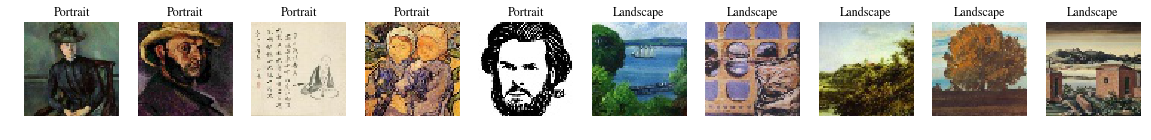

In [16]:
for train_data_batch, train_labels_batch in train_generator:
    print('data batch shape:', train_data_batch.shape)
    print('labels batch shape:', train_labels_batch.shape)
    break
    
display_index_train = index_collector(train_labels_batch.tolist())

plot_strip(train_data_batch, train_labels_batch, display_index_train)

#### (B) Display the first 5 portraits and the first 5 landscapes in the validation dataset.

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


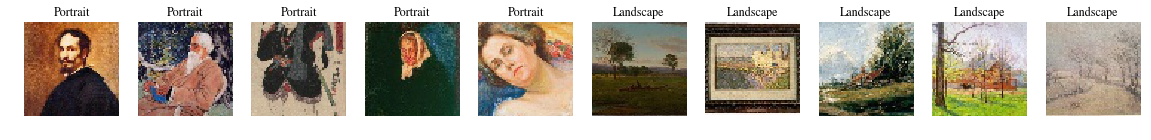

In [17]:
for validation_data_batch, validation_labels_batch in validation_generator:
    print('data batch shape:', validation_data_batch.shape)
    print('labels batch shape:', validation_labels_batch.shape)
    break

display_index_validation = index_collector(validation_labels_batch.tolist())
    
plot_strip(validation_data_batch, validation_labels_batch, display_index_validation)

#### (C) Display the first 5 portraits and the first 5 landscapes in the test dataset.

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


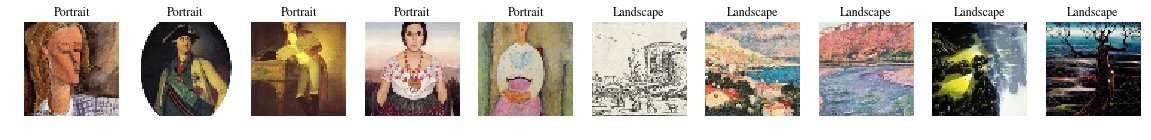

In [19]:
for test_data_batch, test_labels_batch in test_generator:
    print('data batch shape:', test_data_batch.shape)
    print('labels batch shape:', test_labels_batch.shape)
    break

display_index_test = index_collector(test_labels_batch.tolist())
    
plot_strip(test_data_batch, test_labels_batch, display_index_test)

## Construct a baseline CNN classifier using Keras
<span style="color:blue">
Construct a baseline CNN classifier using Keras for the training set and assess the validation set performance at each epoch. The goal is to correctly classify portraits from landscapes. The resulting performance on the training and validation set will be plotted as a function of epoch using the criteria over which you are optimizing. 
</span>

#### A five-layer CNN  classifier is used to train the training set and  the resulting performance on the training and validation set are plotted as functions of the number of epochs.  

In [8]:
def Simple_CNN_Model (activation_function_1, activation_function_2, optimizer_type, epoch_number):
    
    K.clear_session()
    model = models.Sequential(name='FiveLayerModel')
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
    model.add(layers.MaxPooling2D((2, 2), name='max_pool1'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
    model.add(layers.MaxPooling2D((2, 2), name='max_pool2'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation=activation_function_1, name = 'conv3'))
    model.add(layers.MaxPooling2D((2, 2), name='max_pool3'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation=activation_function_1, name = 'conv4'))
    model.add(layers.MaxPooling2D((2, 2), name='max_pool4'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, kernel_initializer='glorot_uniform', activation=activation_function_1, name='fc1'))
    model.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, name='fc2'))
    model.compile(loss='binary_crossentropy', optimizer = optimizer_type, metrics=['accuracy'])
    
    model.summary()

    # Fit the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epoch_number,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
    )
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
    print('\ntest accuracy:', test_acc)
    print('test loss:', test_loss)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 128)         147584    
__________

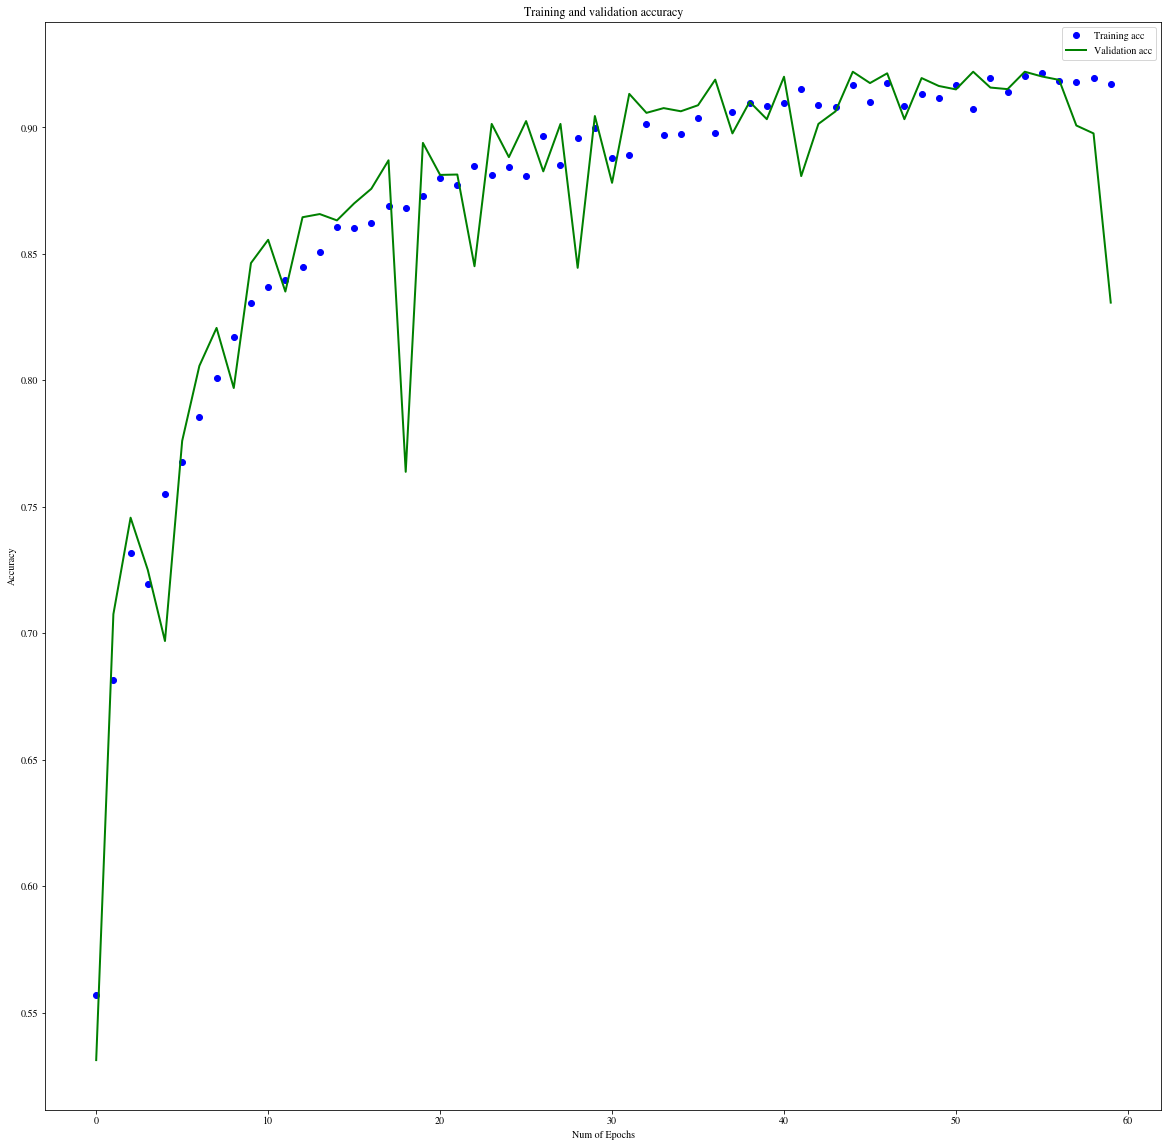

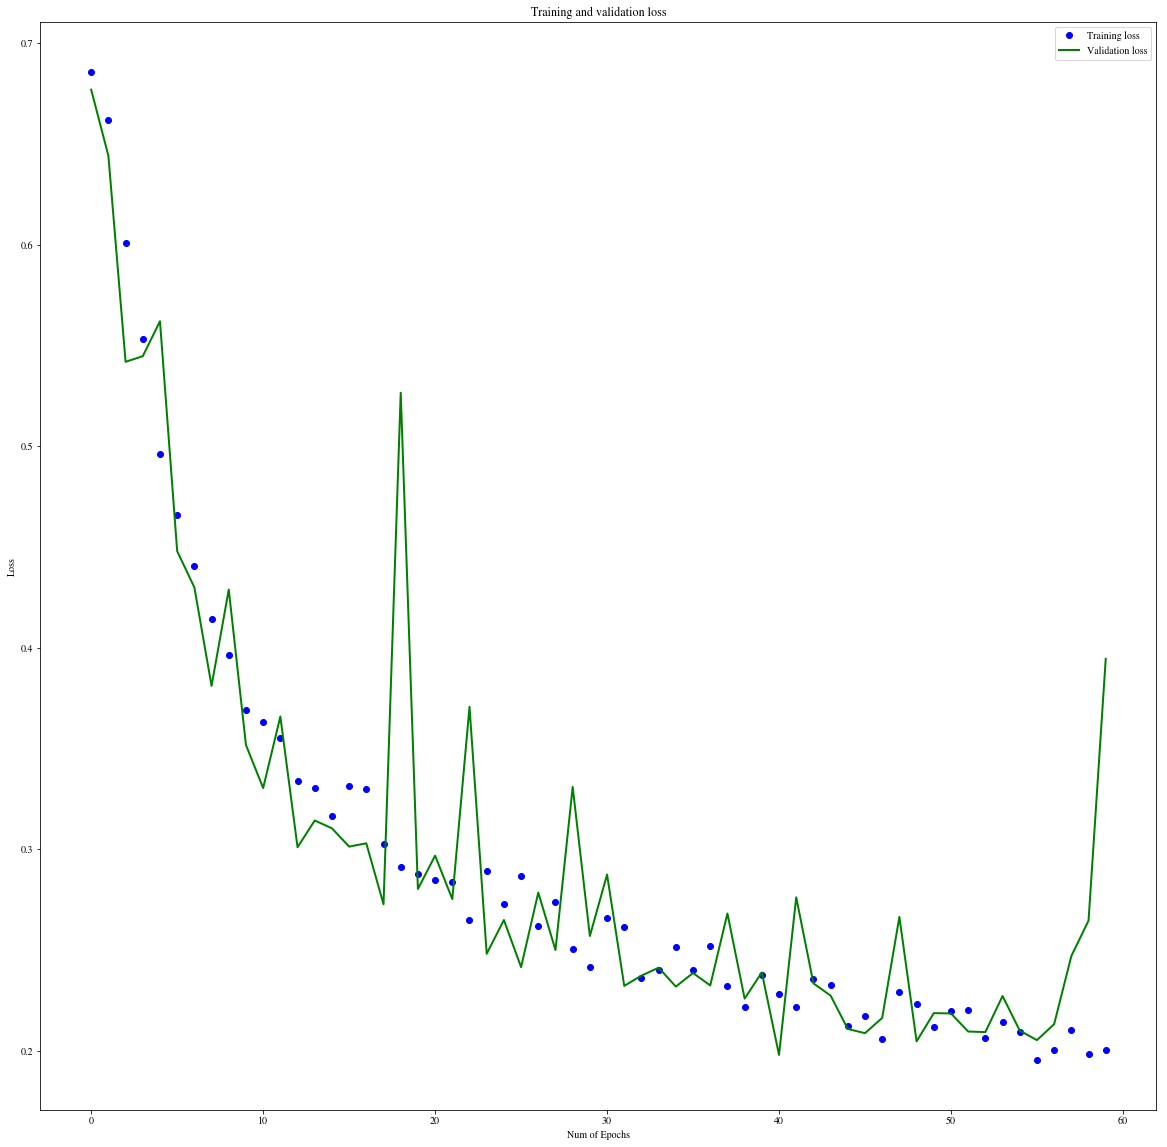

In [34]:
sgd = optimizers.SGD(lr = 0.05, decay=1e-5, momentum=0.9, nesterov=True)
Simple_CNN_Model('relu', 'sigmoid', 'sgd', 60)

<span style="color:blue"> 
Comments  
From the pattern of training and validation curves, describe what is good/bad and what you plan to do next to improve the result. <br>
(A) The Good Aspect  <br>
I tried different combinations for the "activation_function_1" and "activation_function_2", and several different types of optimizer in Problem 2. It turned the combination -- "activation_function_1 = "relu" and "activation_function_2 = "sigmoid" -- works the best among all combinations I have tried. ANd also, the "stochastic gradient descent" optimizer defined in Problem 2 works well. <br>
(1) In problem 2, I tried 60 epochs in total. Both the training accuracy and validation accuracy increase with the number of epochs, while both the training loss and validation loss decrease with the number of epochs, although they bounce around a little bit.   <br>
(2) The decrease in tarining loss and the decrease in validation loss are apparent -- they dropped from a large initial value (around $68\%$) to a small final value (around $20\%$). <br>
(3) Similarly, the increase in tarining accuracy and the increase in validation accuracy are apparent as well -- they rose from a samll initial value (around $54\%$) to a large final value (around $90\%$). <br>
(B) The Bad Aspect <br>
(1) Both the tarining loss and the validation loss reached around $20\%$ after 47 epochs and stalled. Increasing the number of epochs after 47 epochs does NOT decrease either the tarining loss or the validation loss. <br>
(2) Both the training accuracy and the validation accuracy reached around $90\%$ after 24 epochs and stalled. Increasing the number of epochs after 24 epochs does NOT improve either the tarining accuracy or the validation accuracy. <br>
(C) Plan of Improving the Results <br>
To improve the results, I will try different architectures, different parameteres, and different optimizers//regularizations to obtain an optimal CNN. This is what I will do in Problem 4. <br>
</span>

##  Improve the network using a combination of architecture choices, parameter tuning, and experimenting with different optimizers/dropout/regularization/etc. 

### 1. Architecture choice

#### 1.1 The hypothesis/strategy Ststement of Architecture Choice
<span style="color:blue"> 
To find an optimal architecture for the CNN, different number of convolution-subsambling pairs, different number of feature maps, and different number of units for the dense layers will be tried here.
</span>

#### 1.2 The Types of Tests for Architecture Choice
<span style="color:blue"> 
Here, the accuracy and loss of training, validation, and test sets obtained from different architectures will be used to choose the optimal architecture. The final values of accuracy and loss and how the accuracy and loss change with epochs will be compared too determine the optimal values. 
</span>

#### 1.3 The Code and Results for Architecture Choice

#### 1.3.1 Architecture Choice -- Determine the number of convolution-subsambling pairs

In [9]:
# Here, we will try differnet values for the number of convolution-subsambling pairs: 1, 2, 3, 4, and 5. 
def CNN_Architecture_Selector_1 (activation_function_1, activation_function_2, optimizer_type, epoch_number):
    K.clear_session()
    model = [0] * 5
    
    for j in range(0, 5):
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        if j>0:
            model[j].add(layers.Conv2D(64, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
            model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
            if j>1:
                model[j].add(layers.Conv2D(128, (3, 3), padding='same', activation=activation_function_1, name = 'conv3'))
                model[j].add(layers.MaxPooling2D((2, 2), name='max_pool3'))
            if j>2:
                model[j].add(layers.Conv2D(256, (3, 3), padding='same', activation=activation_function_1, name = 'conv4'))
                model[j].add(layers.MaxPooling2D((2, 2), name='max_pool4'))
            if j>3:
                model[j].add(layers.Conv2D(512, (3, 3), padding='same', activation=activation_function_1, name = 'conv5'))
                model[j].add(layers.MaxPooling2D((2, 2), name='max_pool5'))
                
        
        model[j].add(layers.Flatten())
        model[j].add(layers.Dense(512, kernel_initializer='glorot_uniform', activation=activation_function_1, name='fc1'))
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, name='fc2'))
        model[j].compile(loss='binary_crossentropy', optimizer = optimizer_type, metrics=['accuracy'])
    
        model[j].summary()
        
         # Fit the model
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epoch_number,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               16777728  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total params: 16,779,137
Trainable params: 16,779,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
100/100 [==============================] - 31s 310ms/step - loss: 0.5868 - acc: 0.6925 - val_loss: 0.5124 - val_acc: 0.

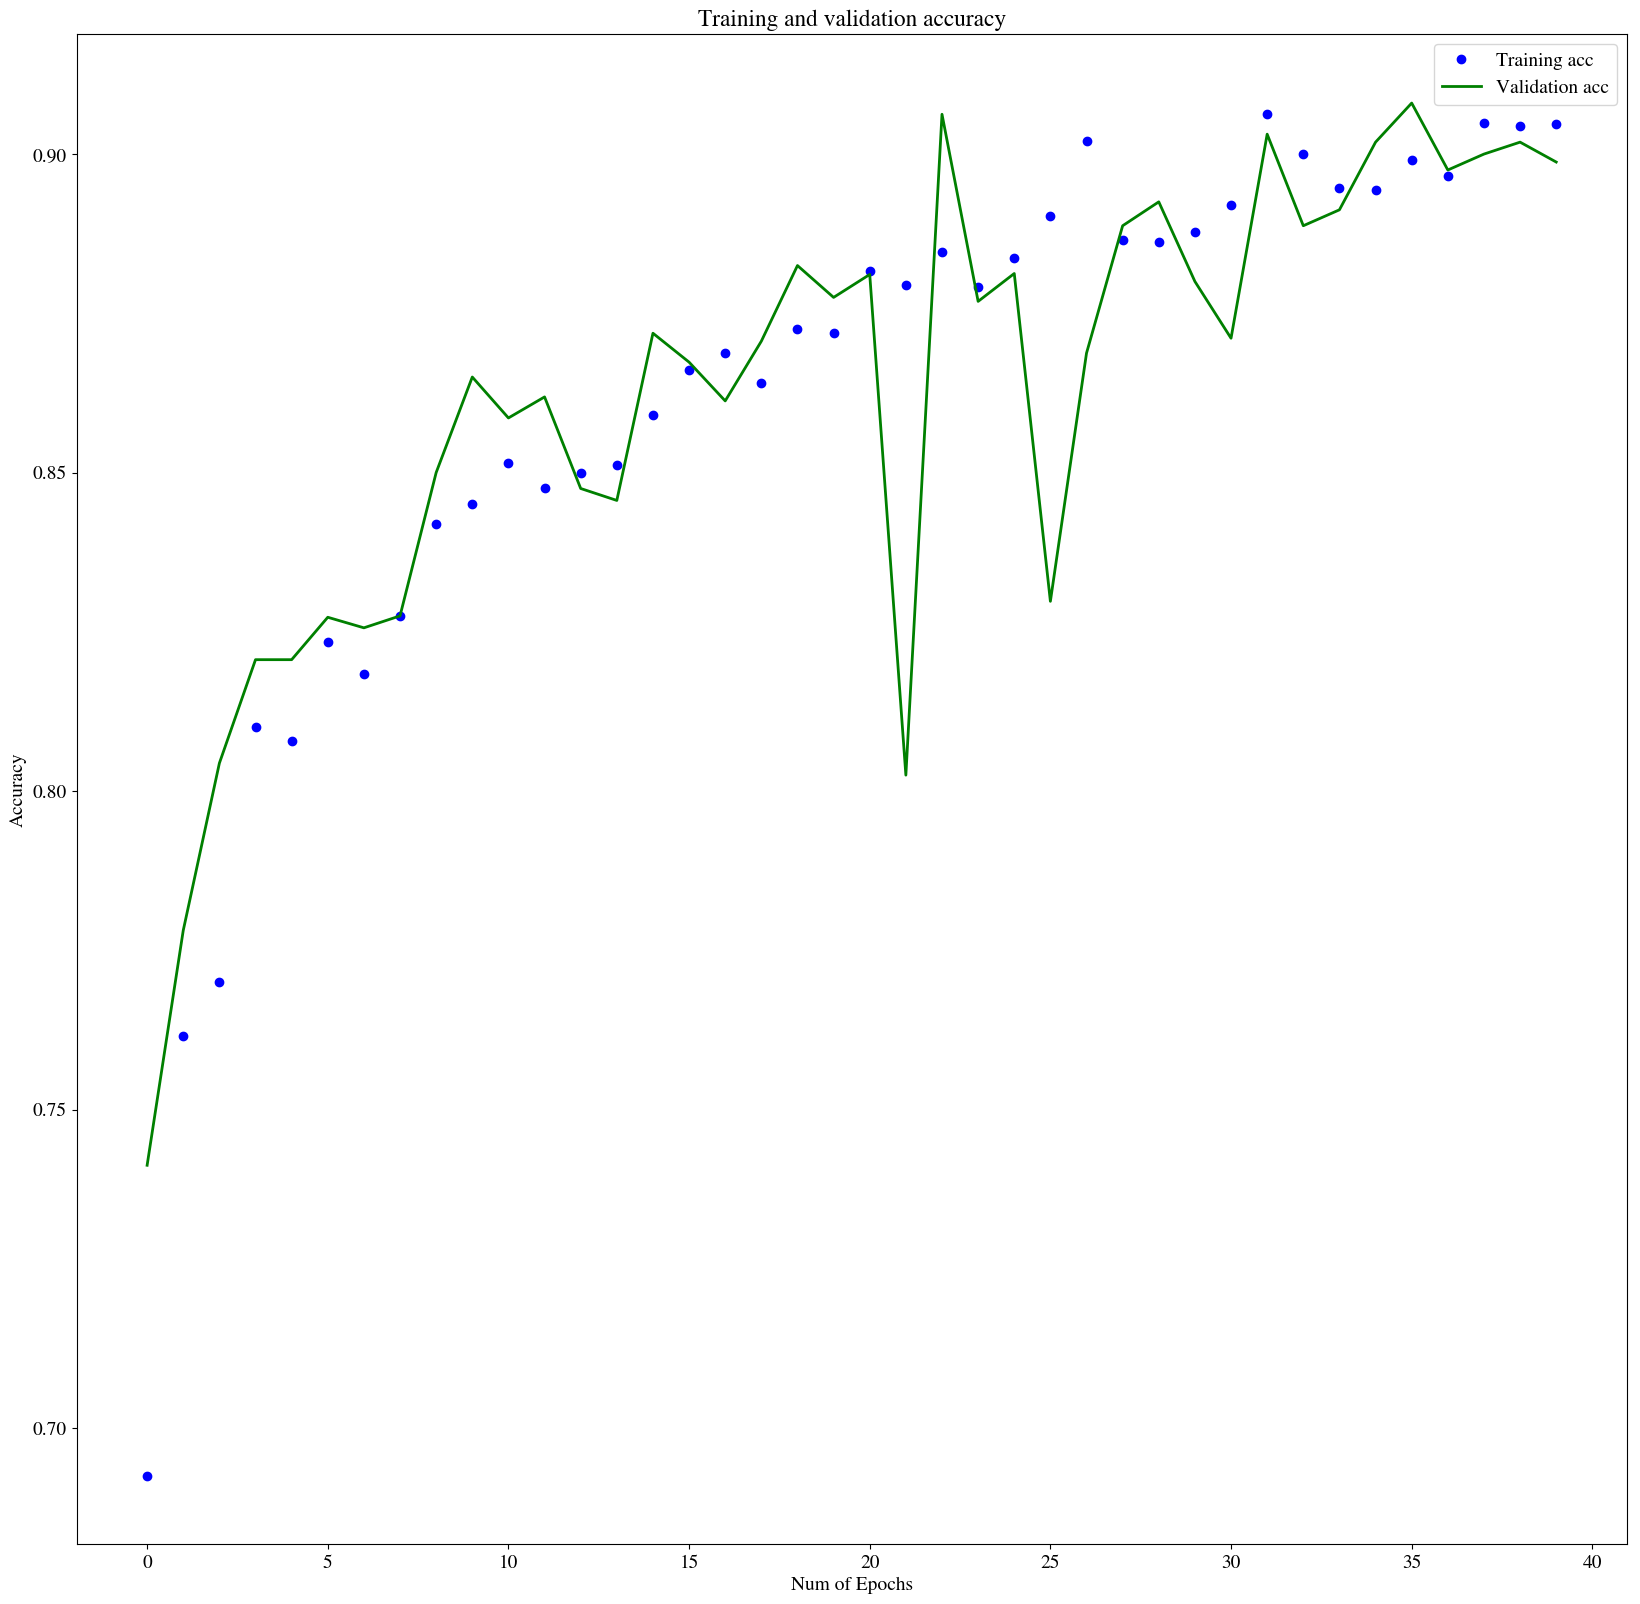

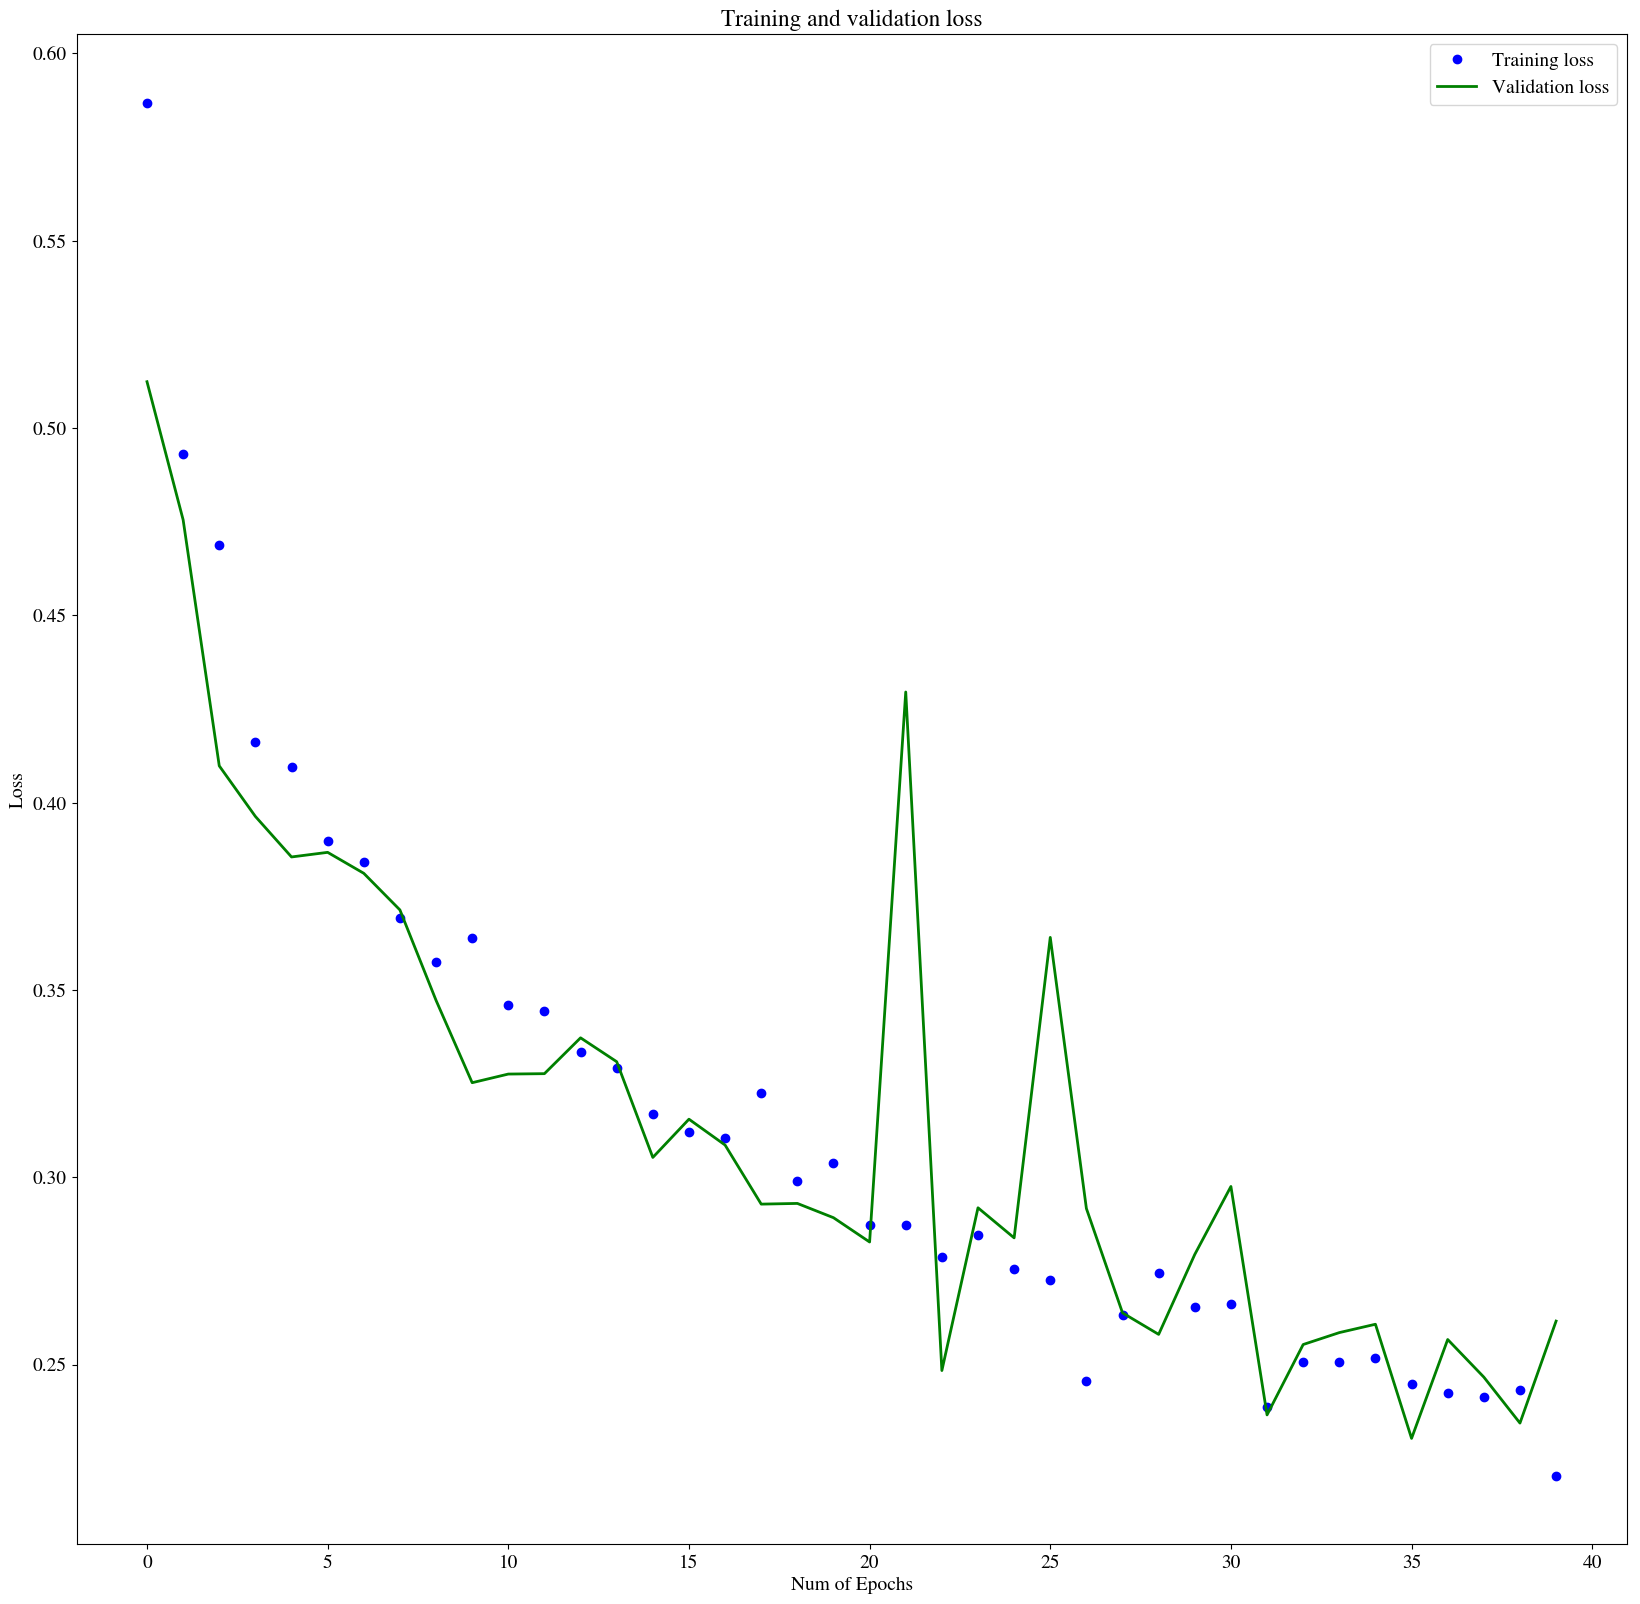

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               8389120   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

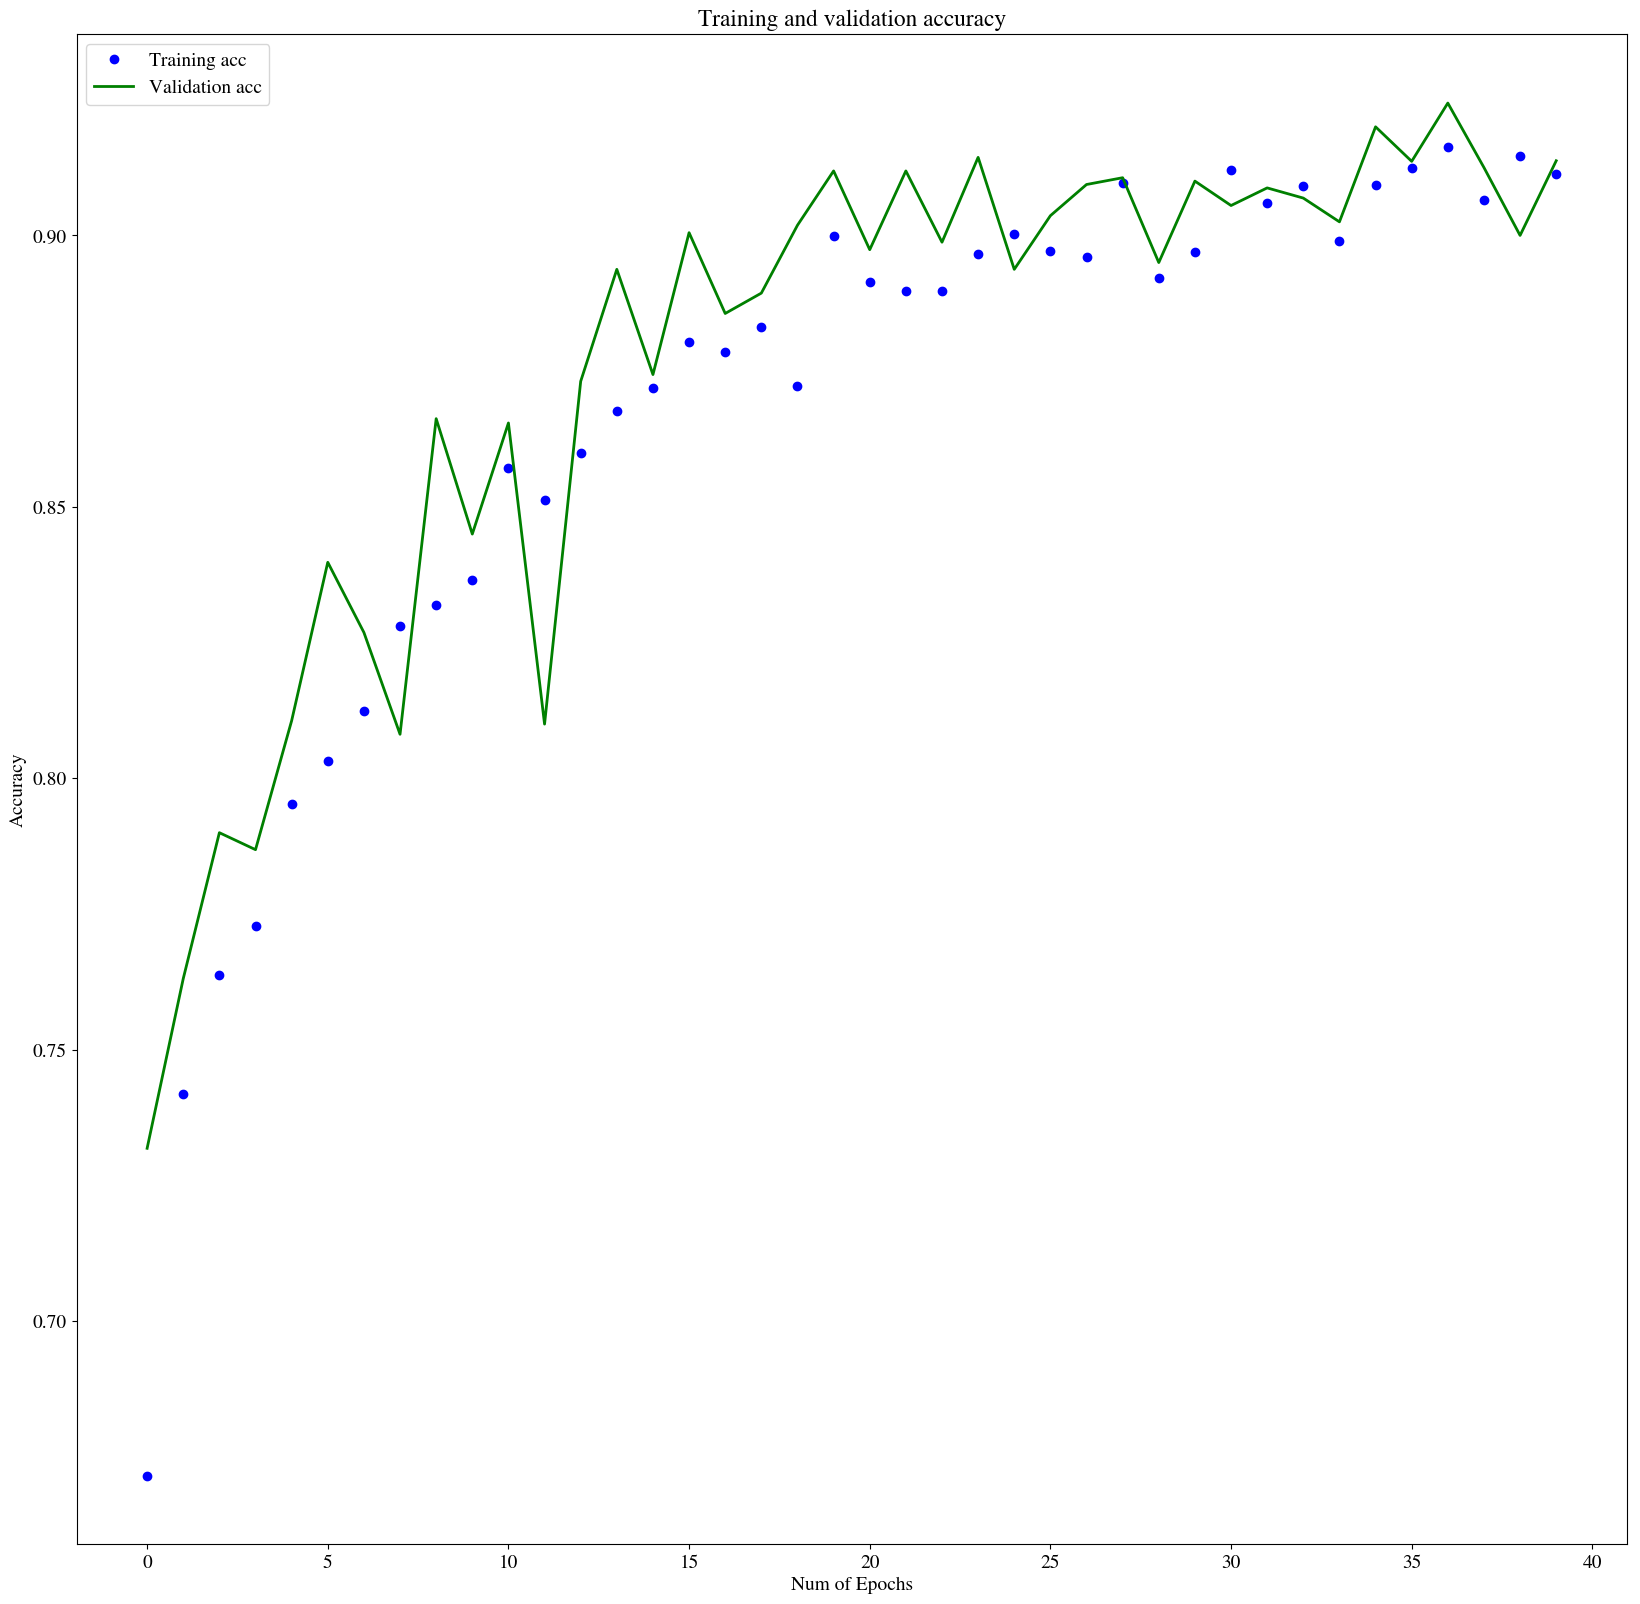

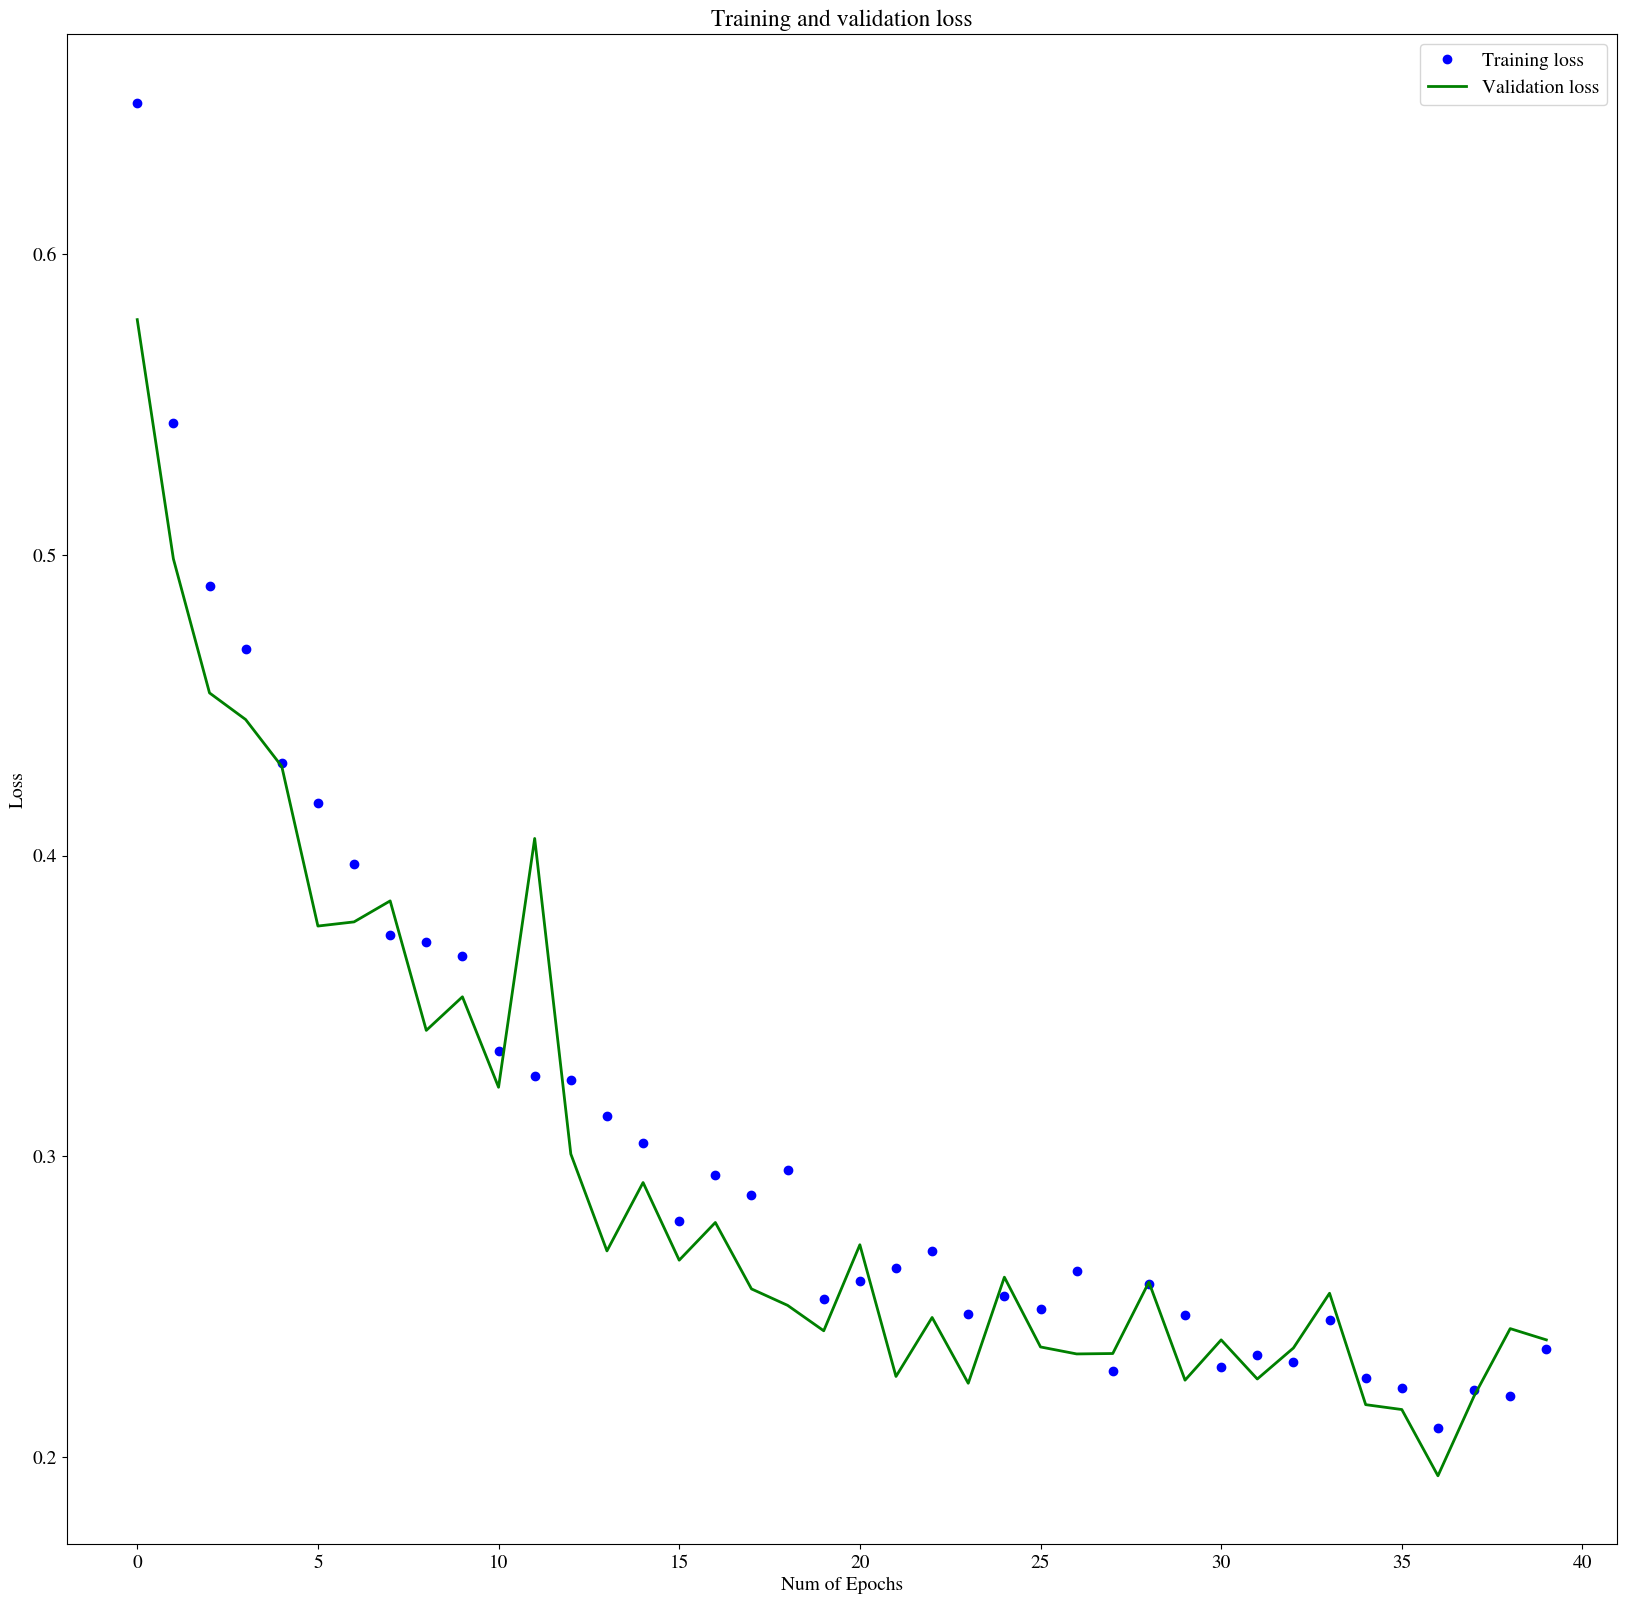

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
__________

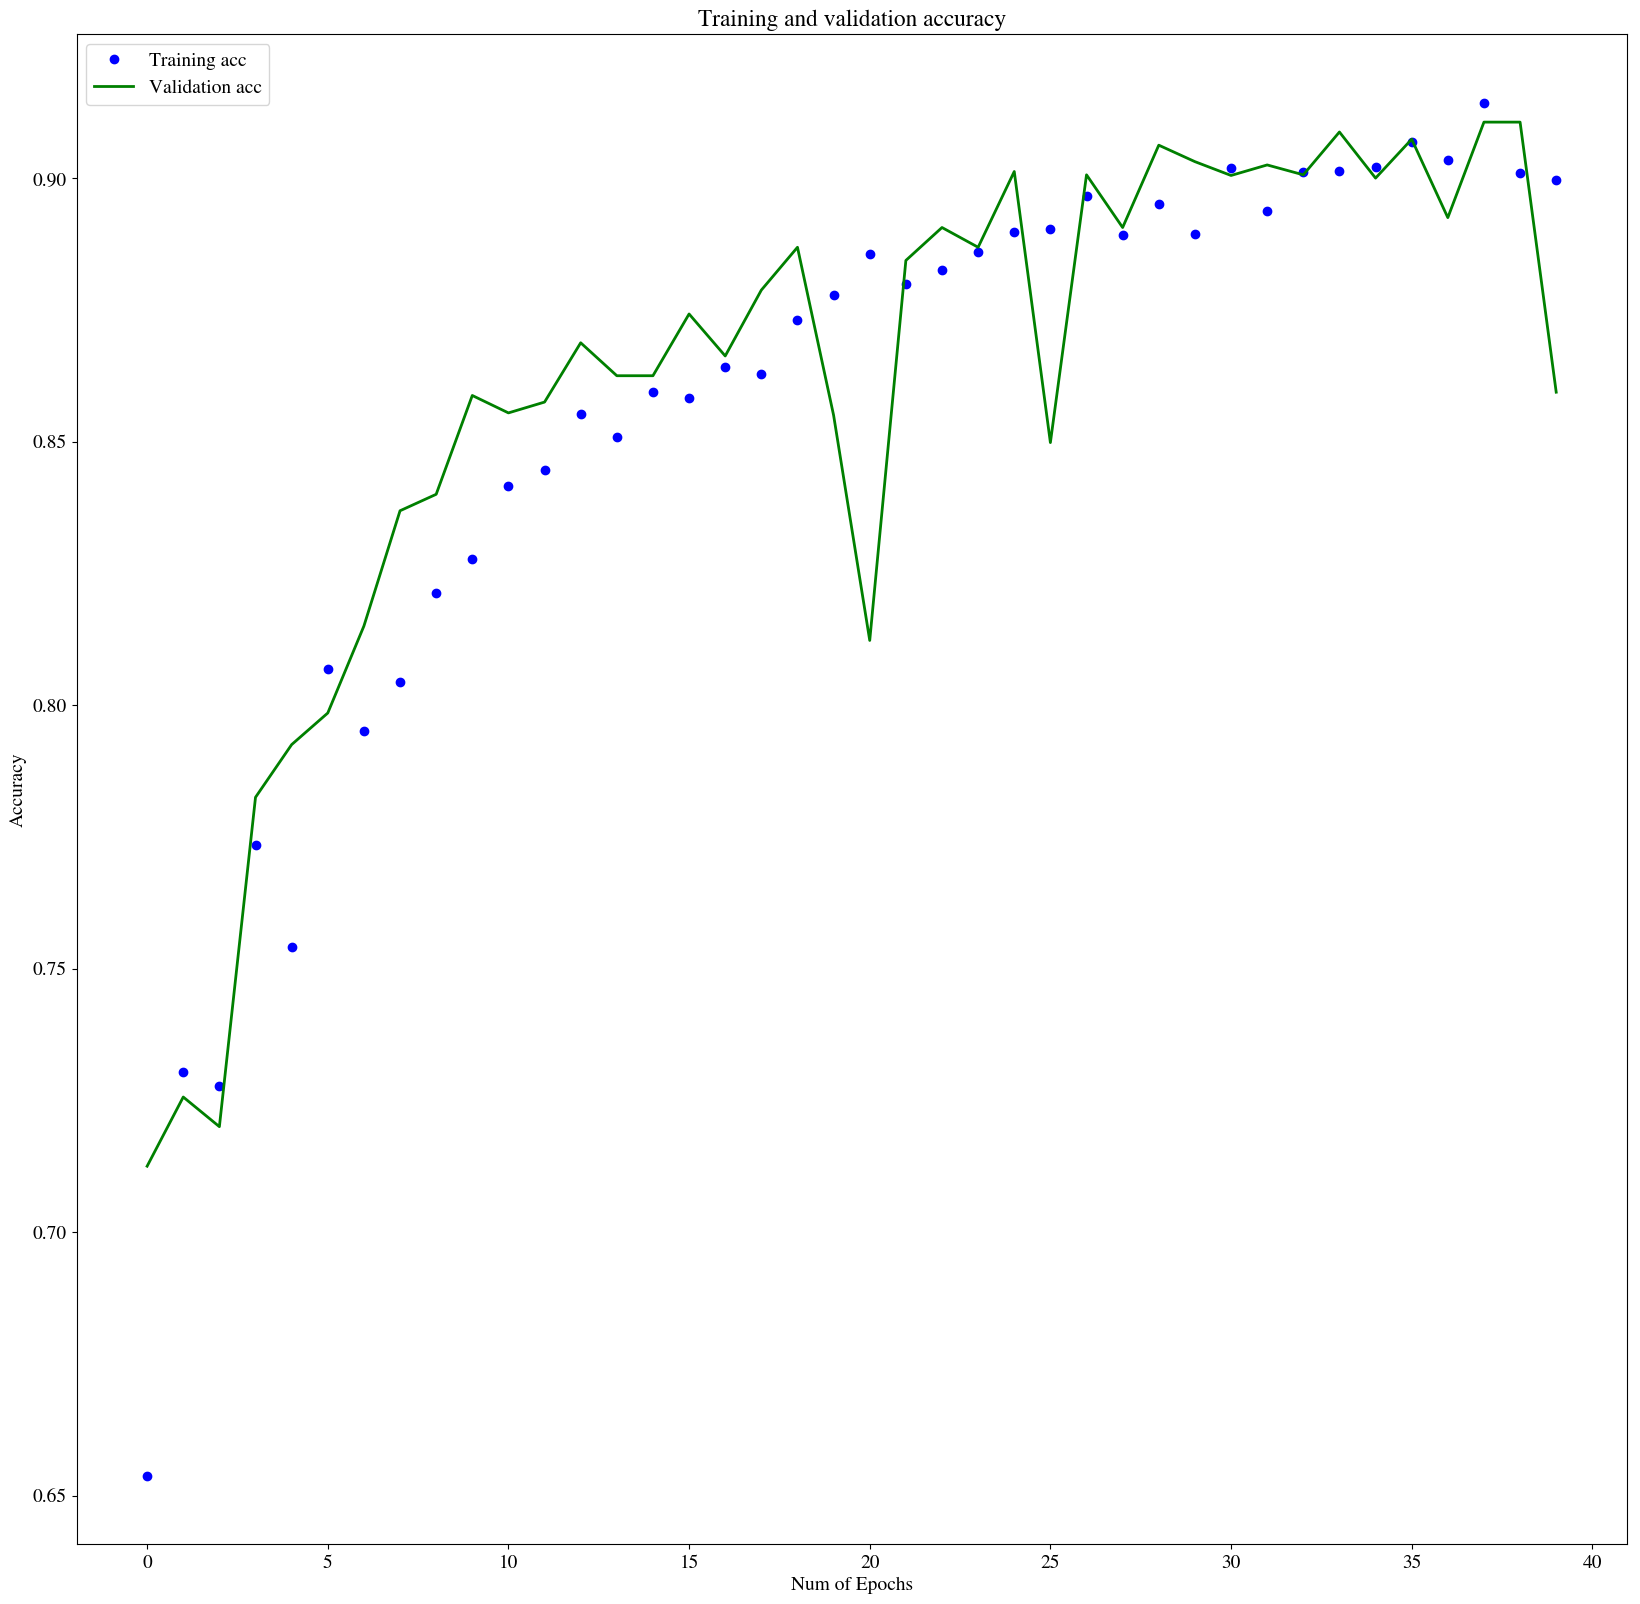

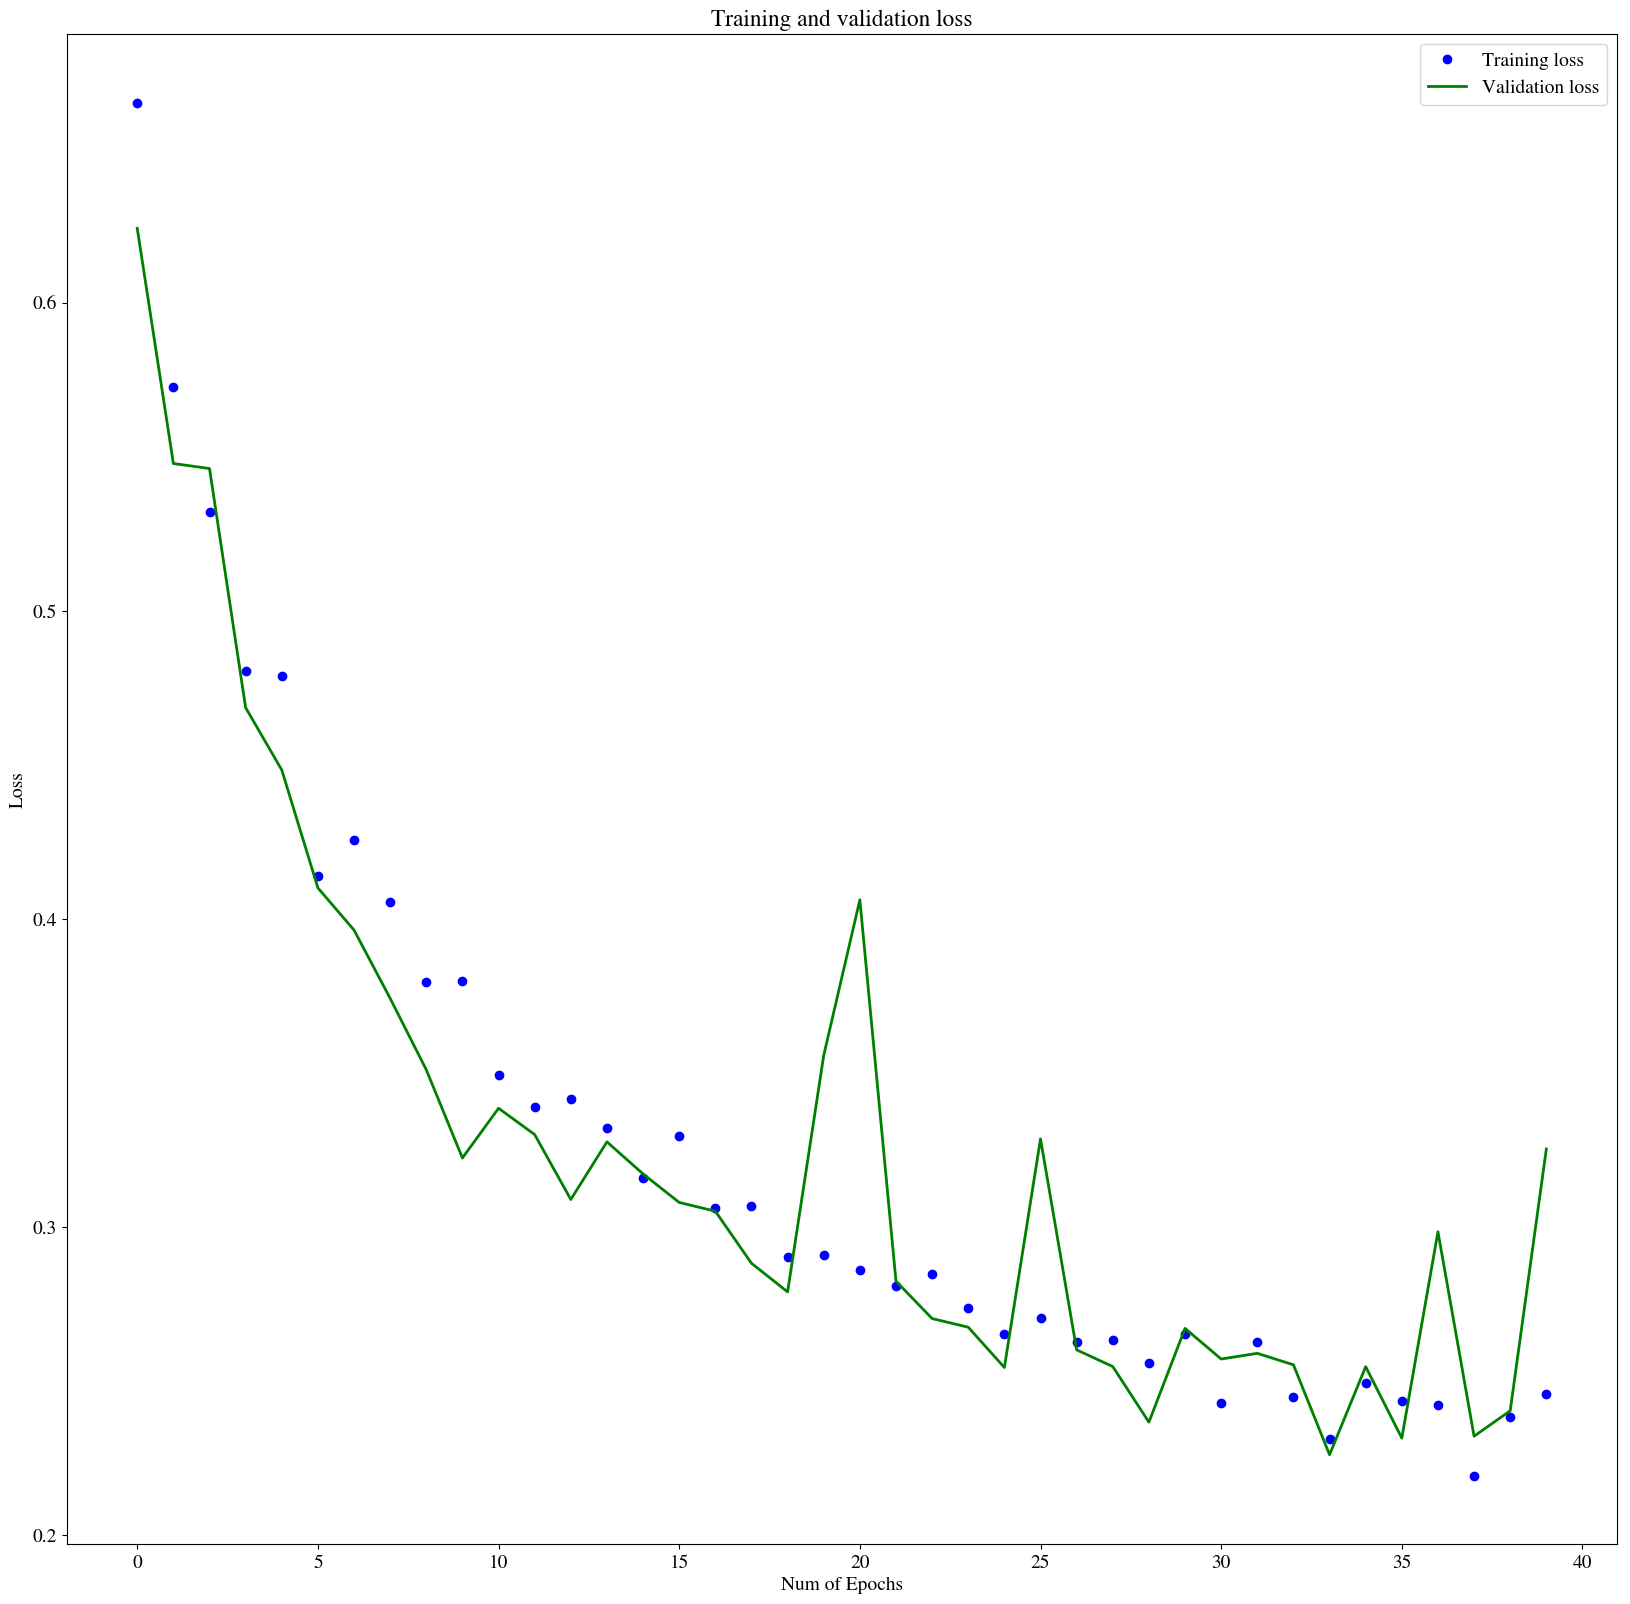

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 256)         295168    
__________

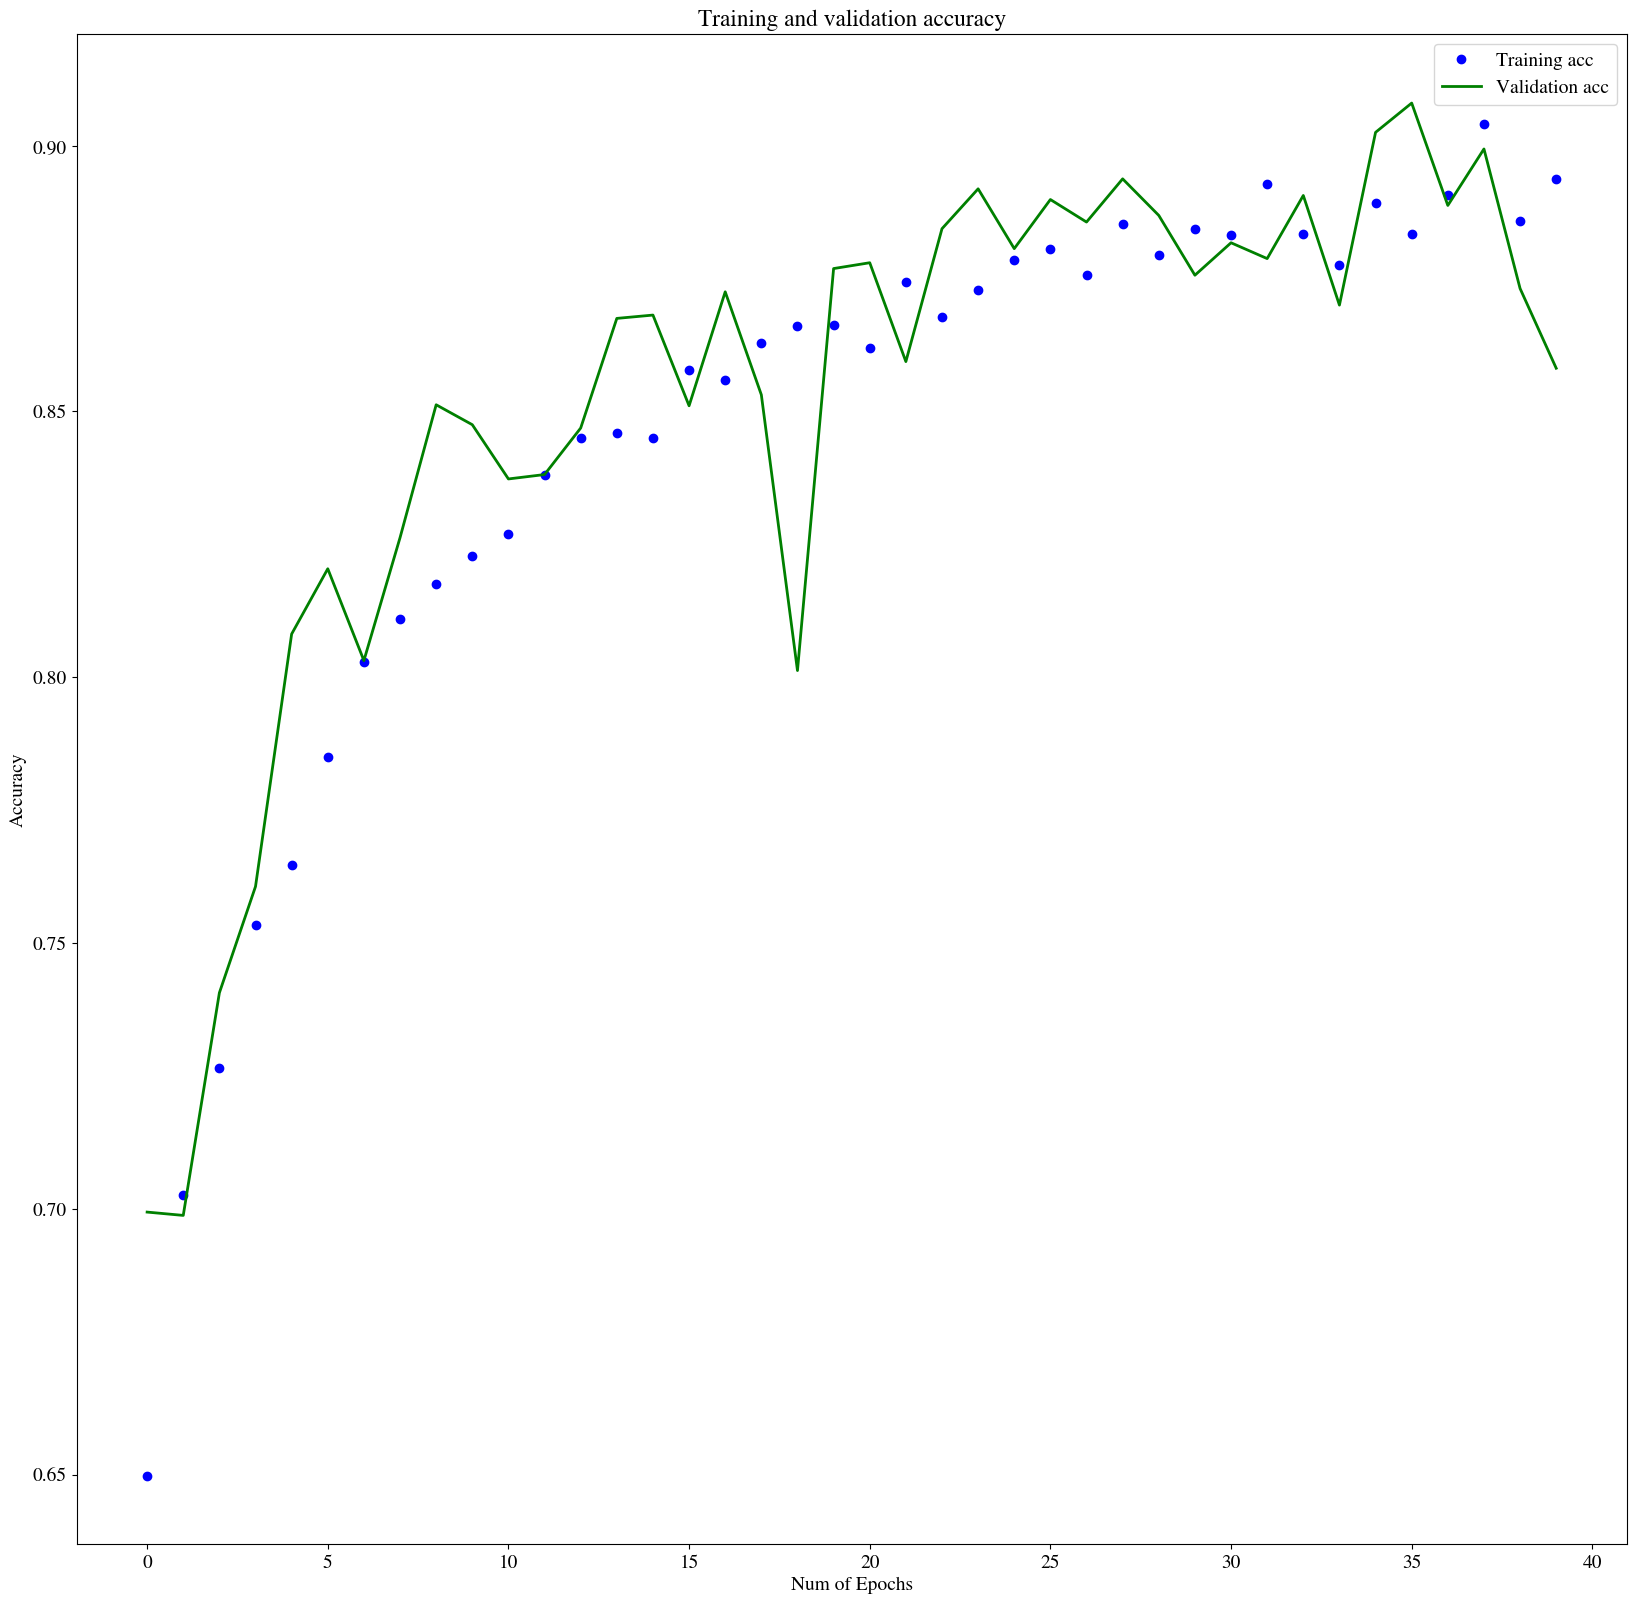

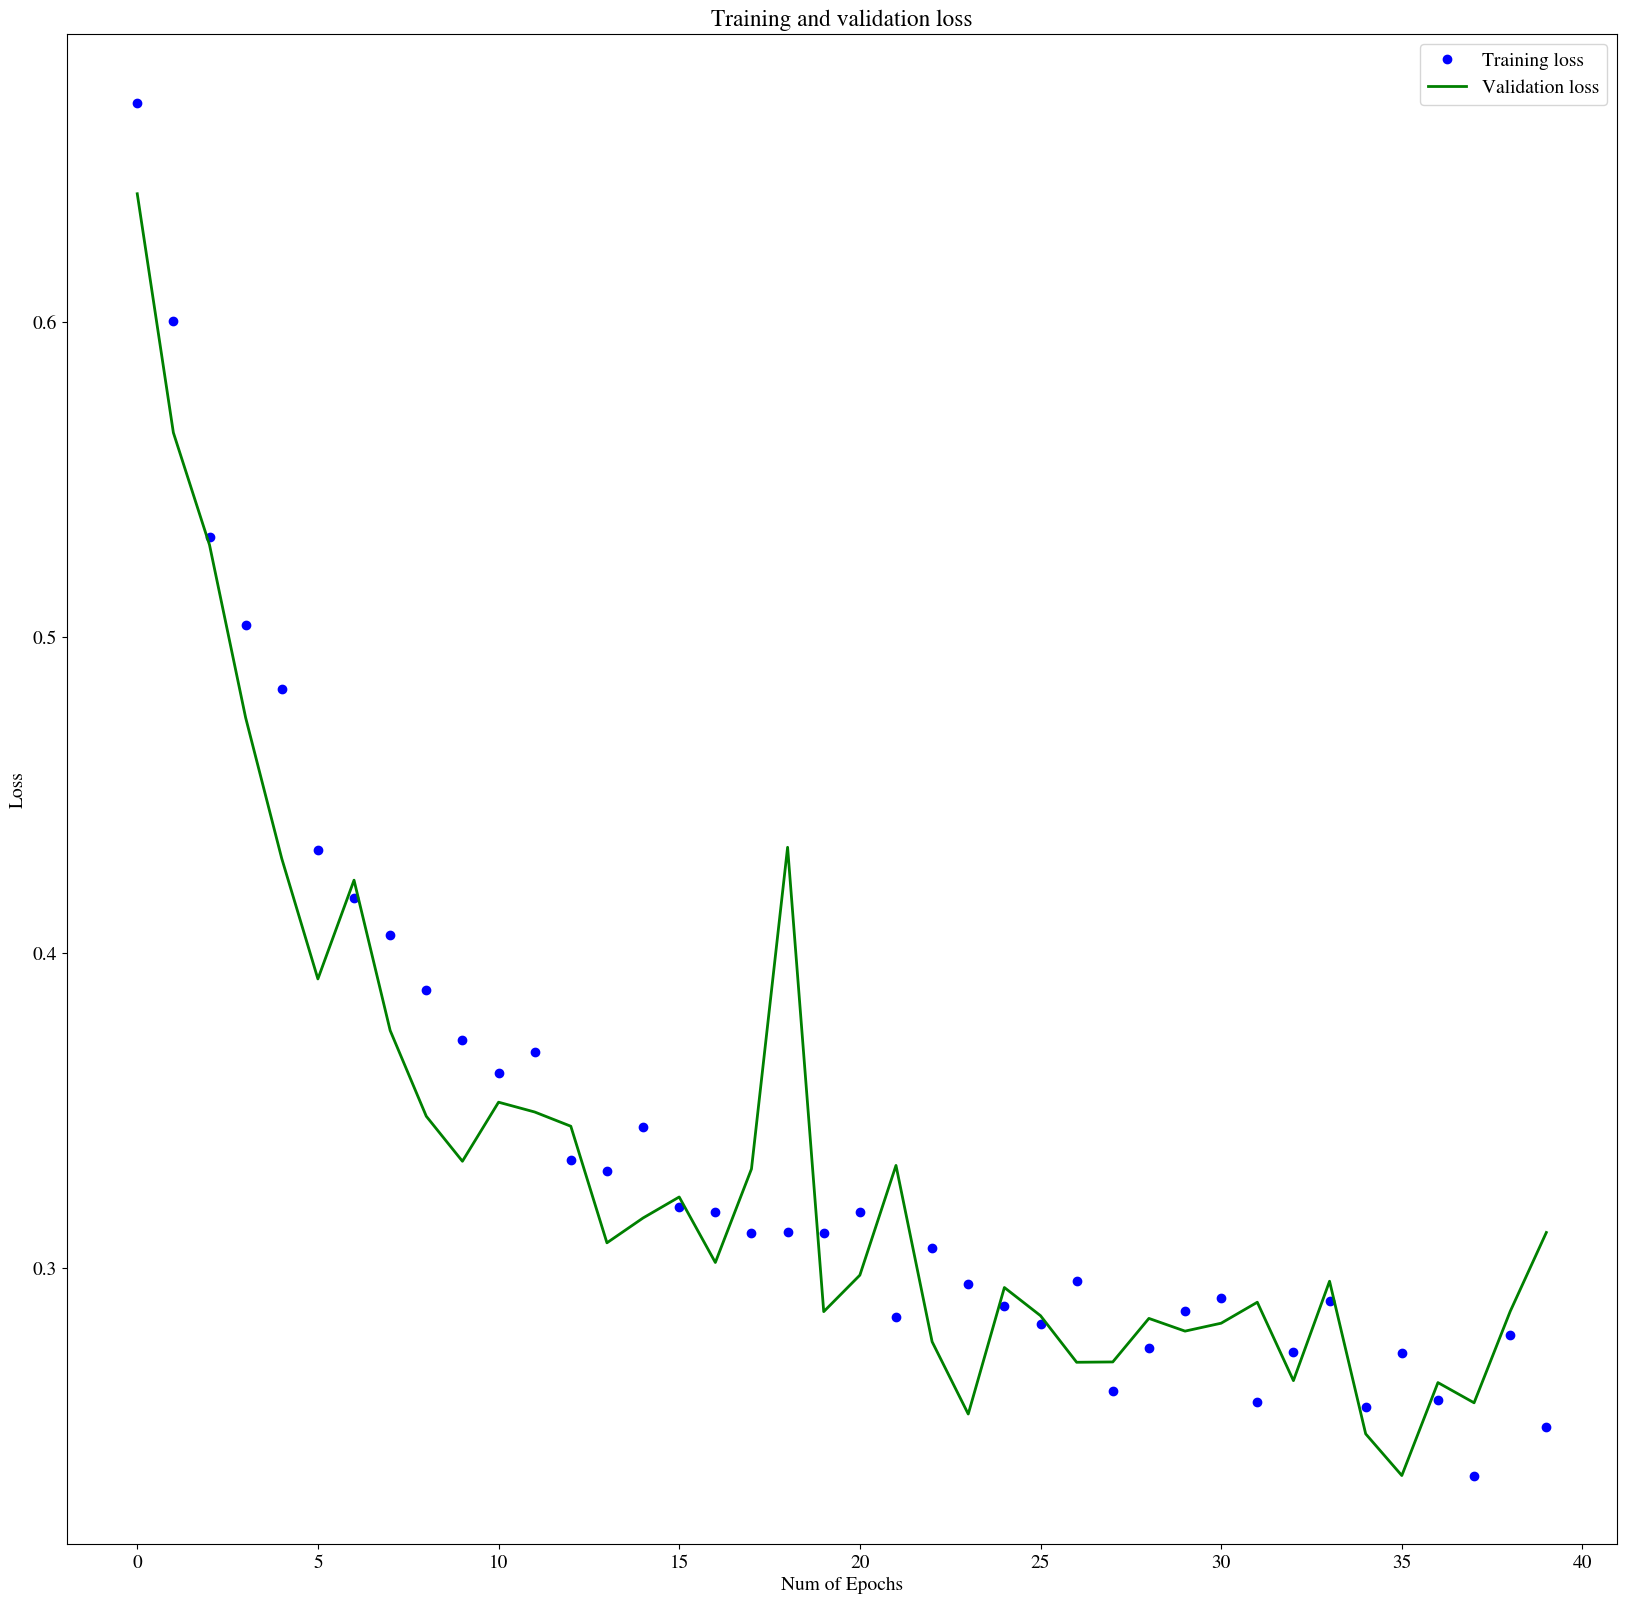

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 256)         295168    
__________

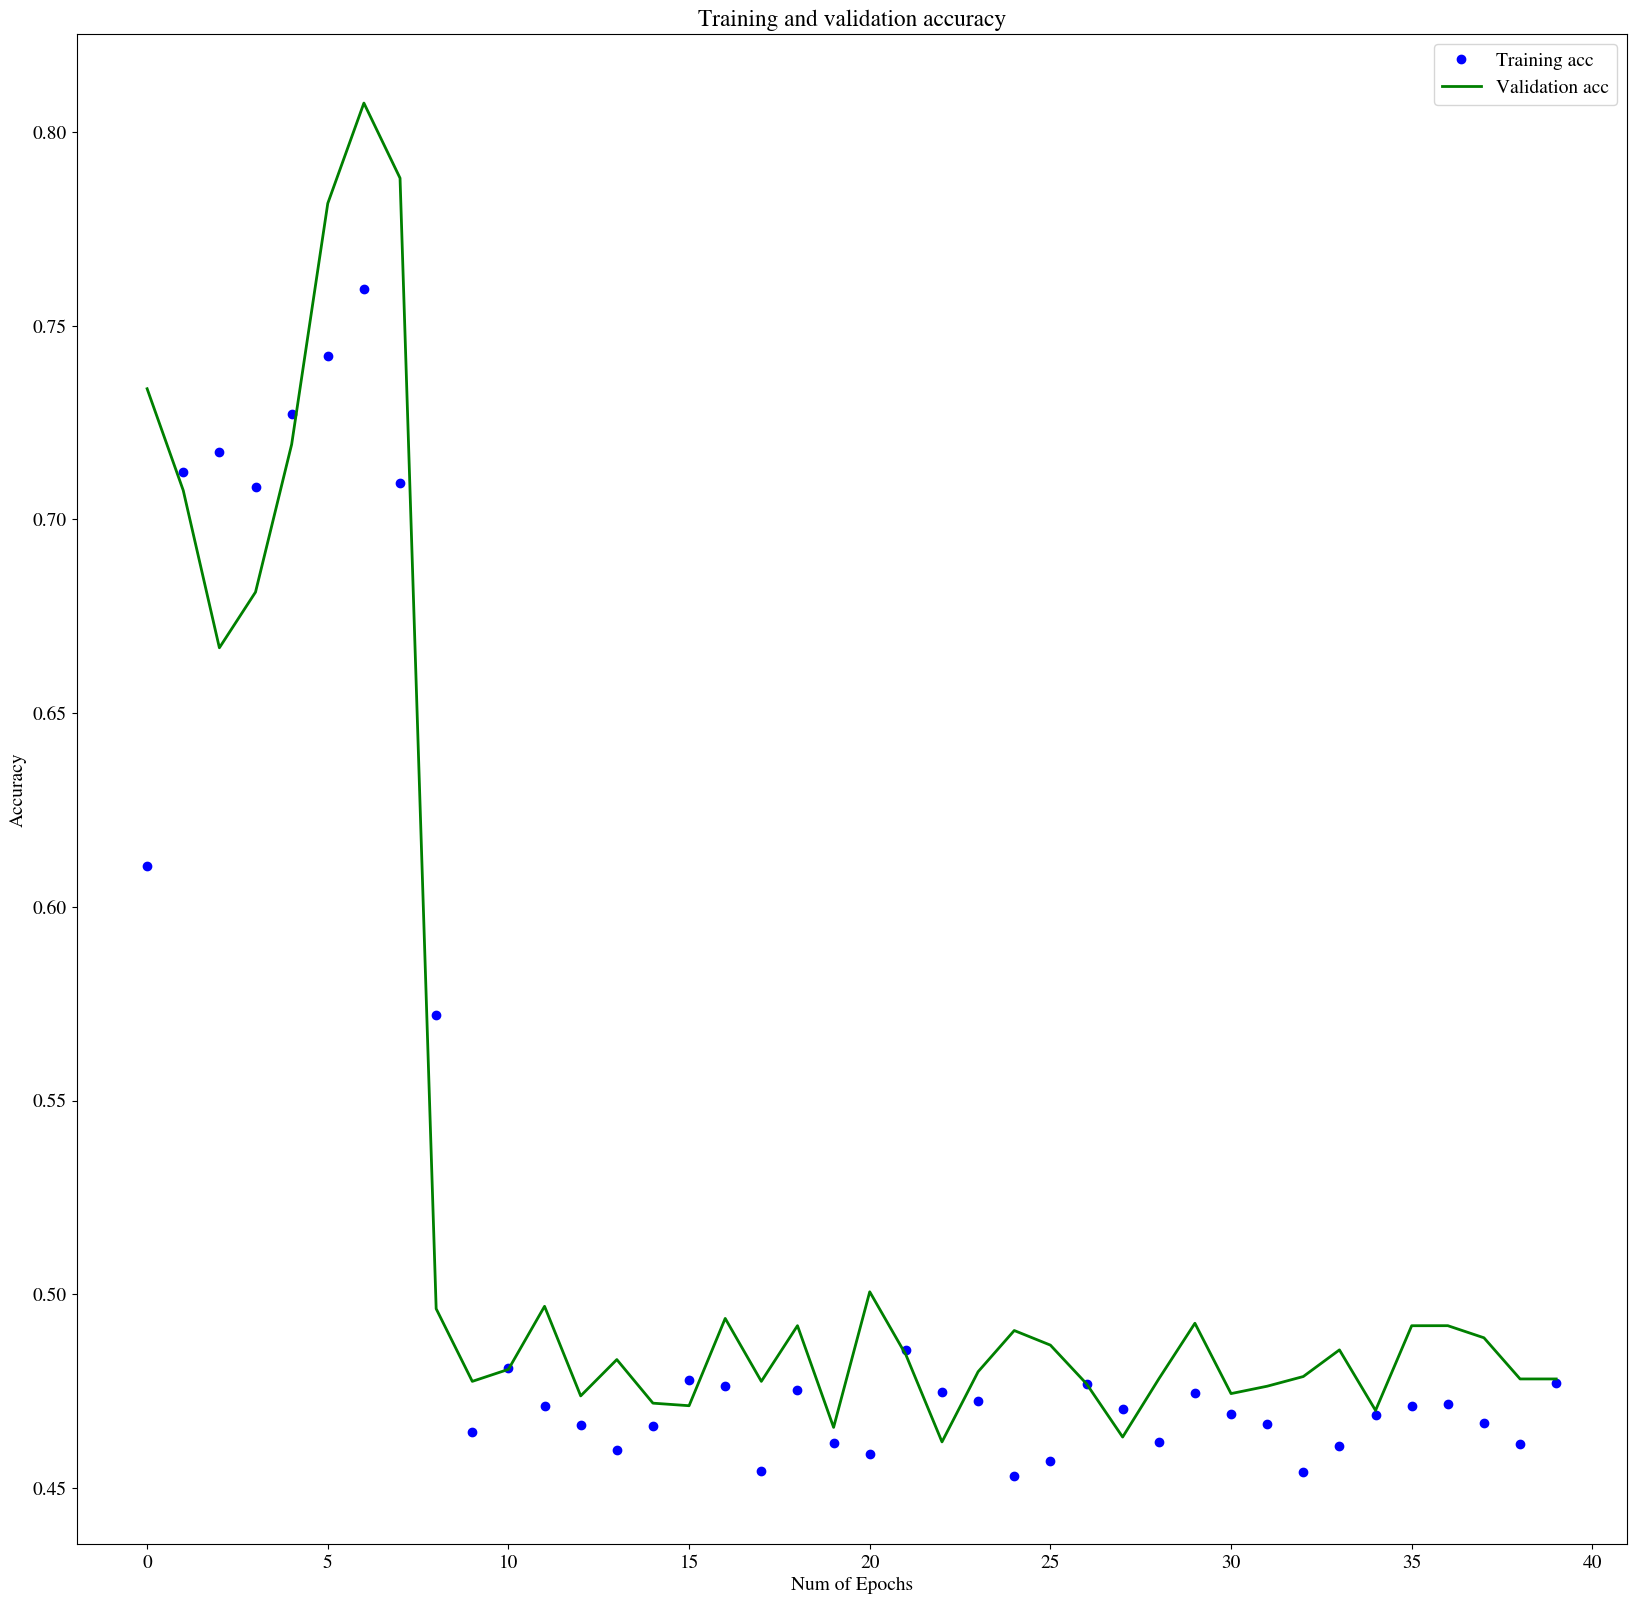

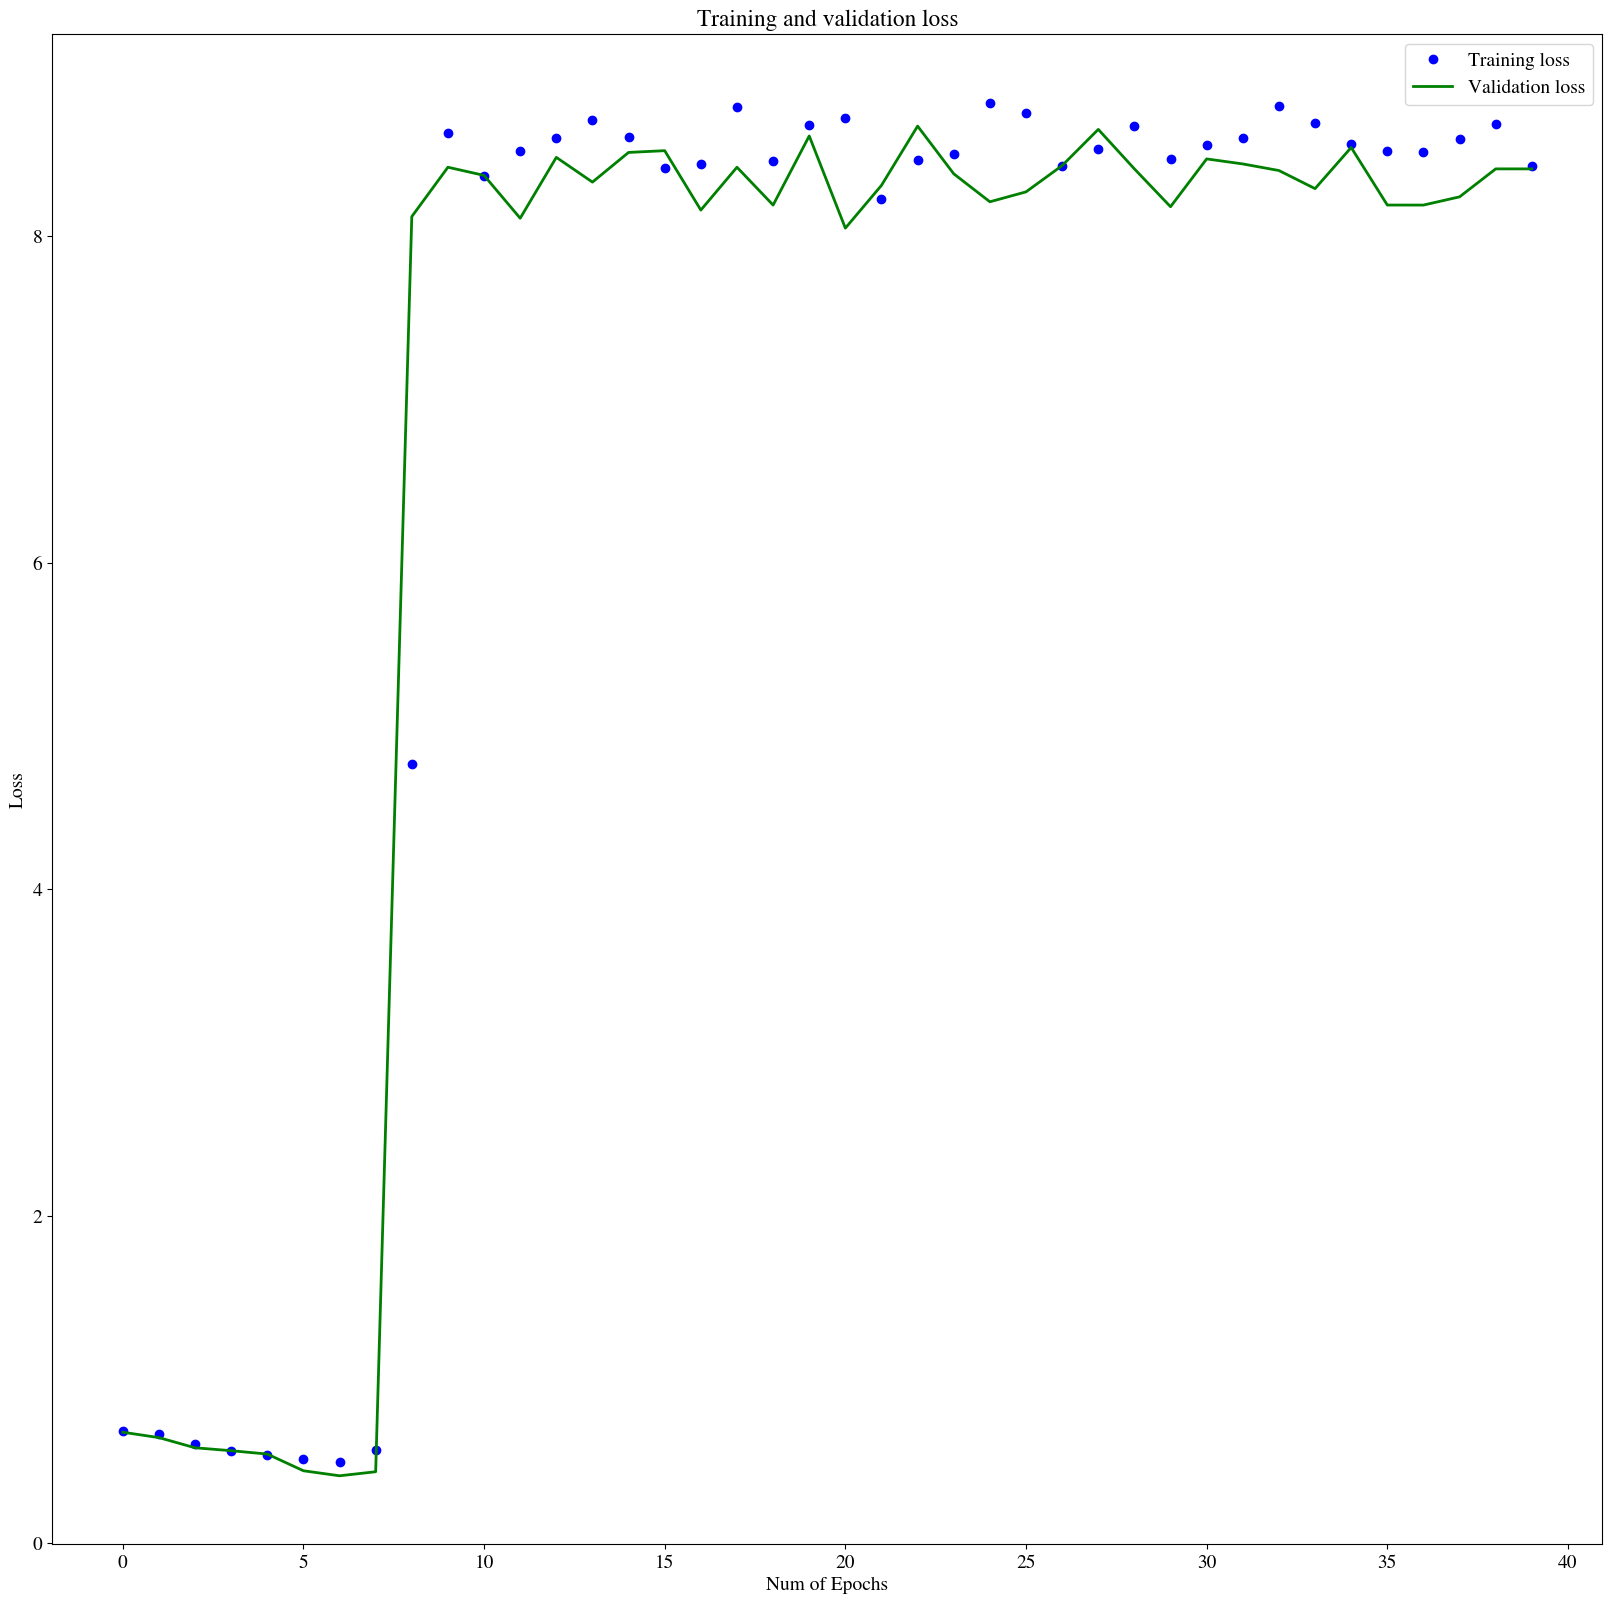

In [41]:
sgd = optimizers.SGD(lr = 0.05, decay=1e-5, momentum=0.9, nesterov=True)
CNN_Architecture_Selector_1('relu', 'sigmoid', 'sgd', 40)

#### 1.3.2 Architecture Choice -- Determine the number of feature maps
<span style="color:blue"> 
Here, we set the number of convolution-subsambling pairs as 2. We will try differnet values for the number of feature maps for the two convolutional layers. The paris of the first and second convolutional layers we will are: (16, 32), (32, 64), (48, 96), (64, 128), and (80, 160). 
</span>

In [8]:
def CNN_Architecture_Selector_2 (activation_function_1, activation_function_2, optimizer_type, epoch_number):
    K.clear_session()
    model = [0] * 5
    
    for j in range(0, 5):
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(j*16+16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        
        model[j].add(layers.Conv2D(j*32+32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        
        model[j].add(layers.Flatten())
        model[j].add(layers.Dense(512, kernel_initializer='glorot_uniform', activation=activation_function_1, name='fc1'))
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, name='fc2'))
        model[j].compile(loss='binary_crossentropy', optimizer = optimizer_type, metrics=['accuracy'])
    
        model[j].summary()
        
         # Fit the model
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epoch_number,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               4194816   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

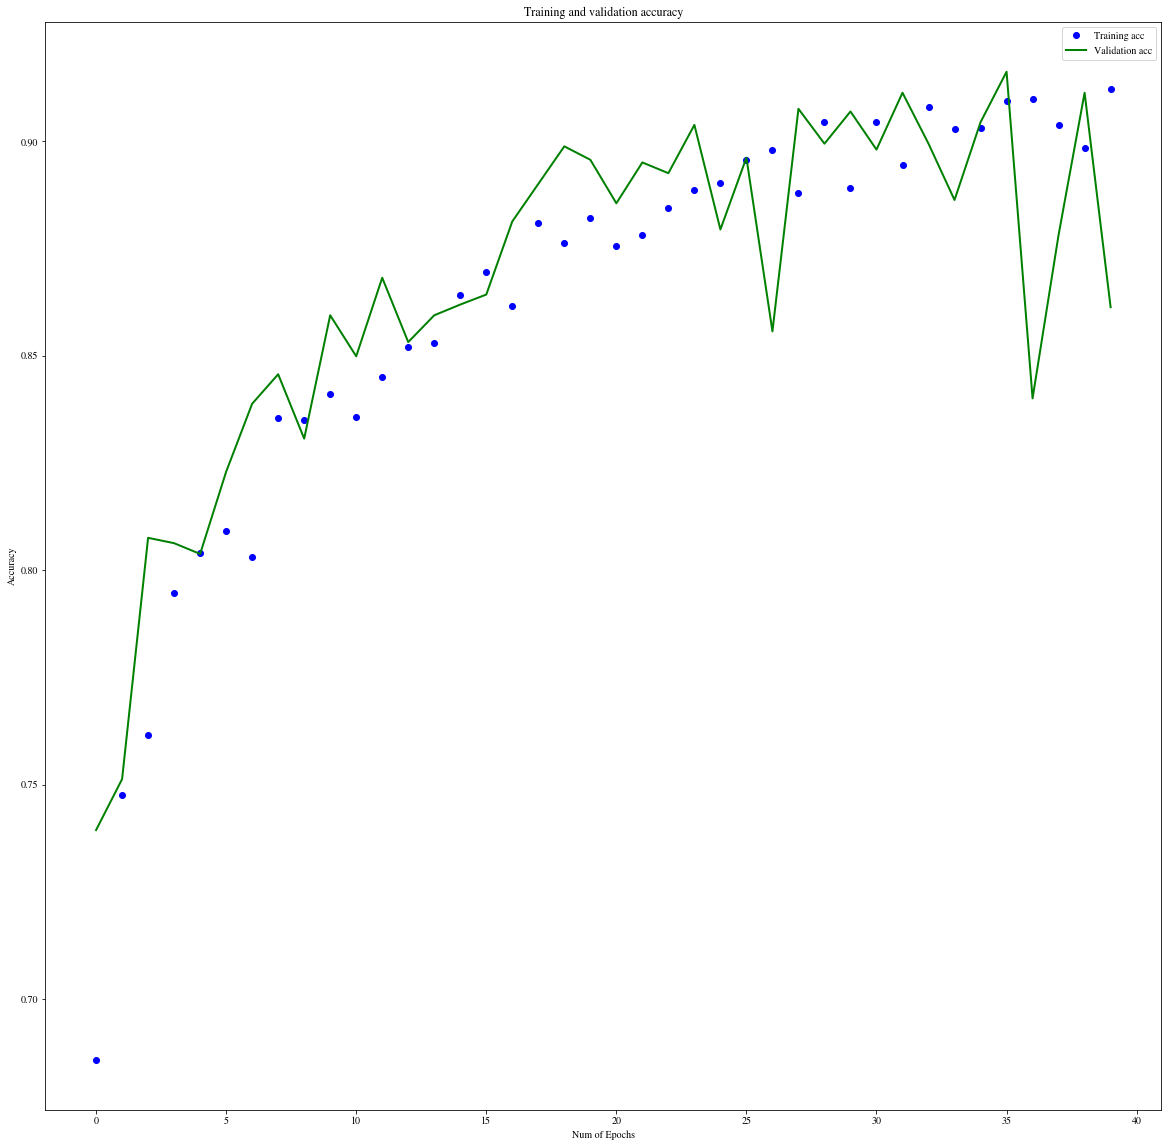

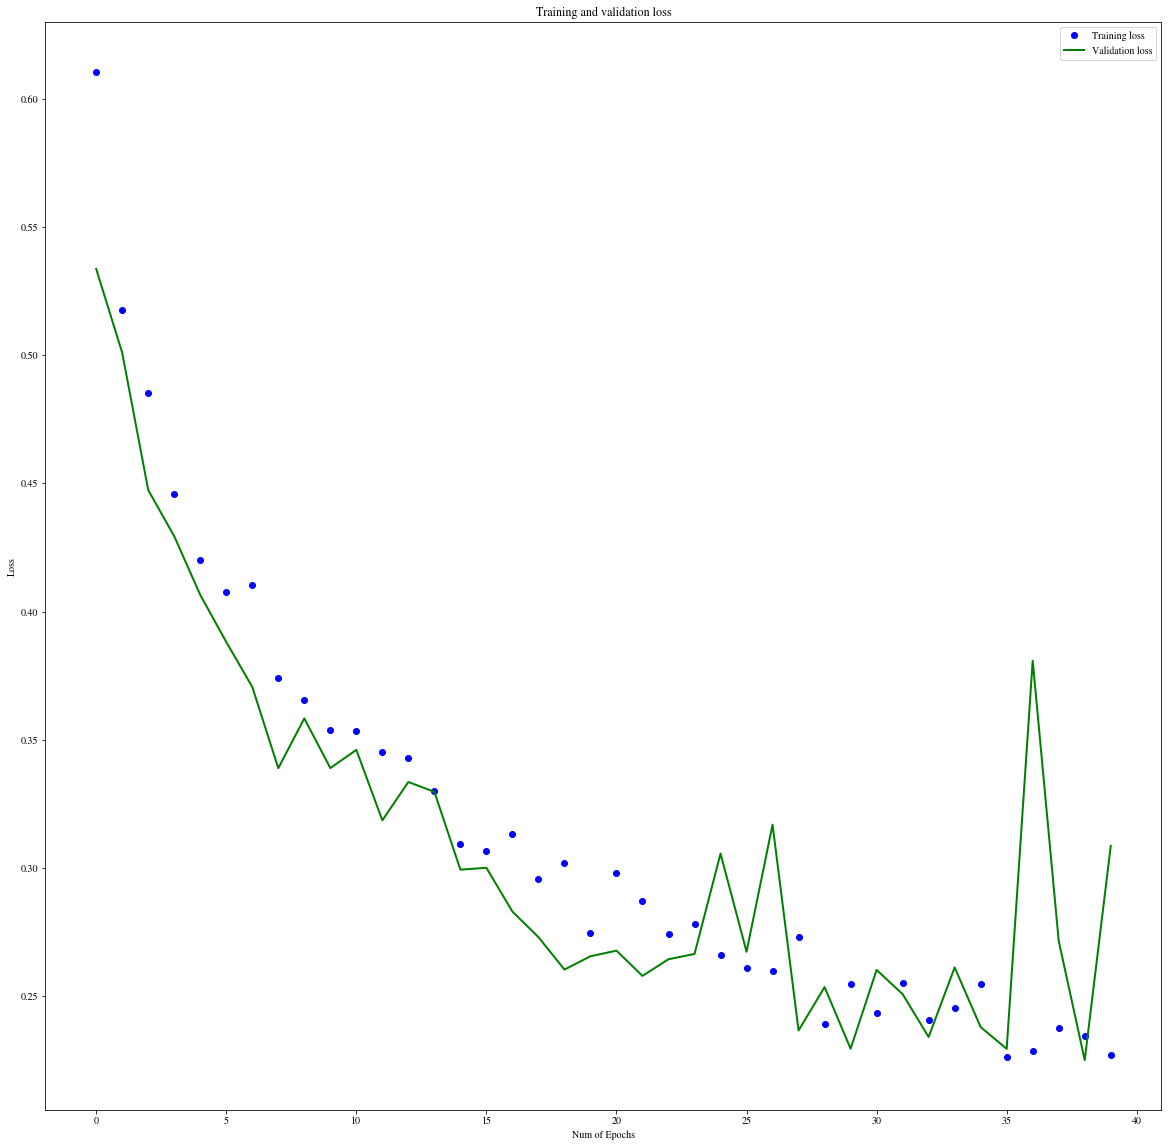

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               8389120   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

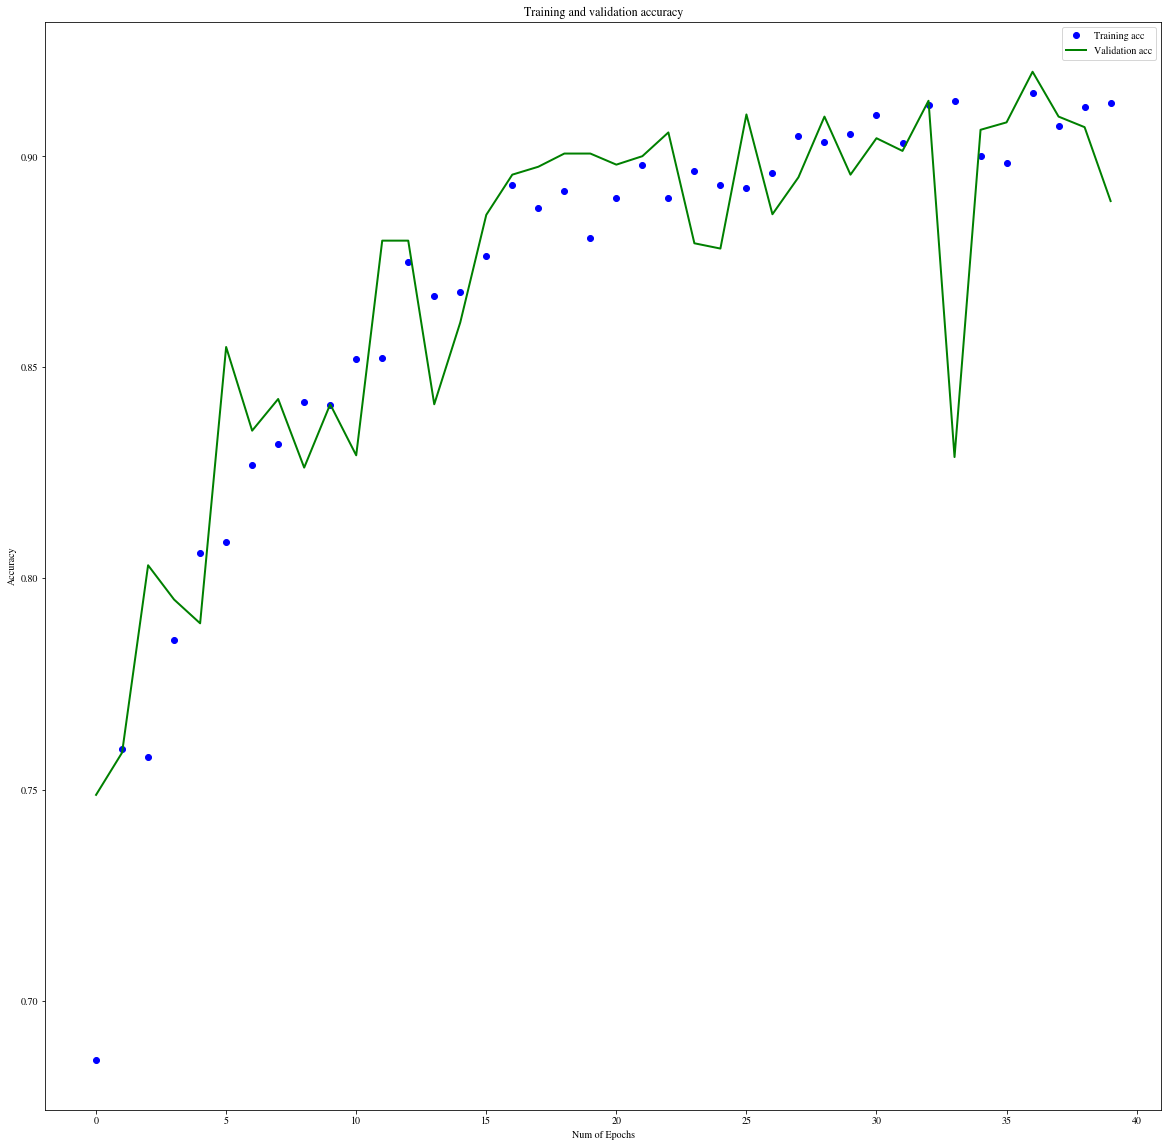

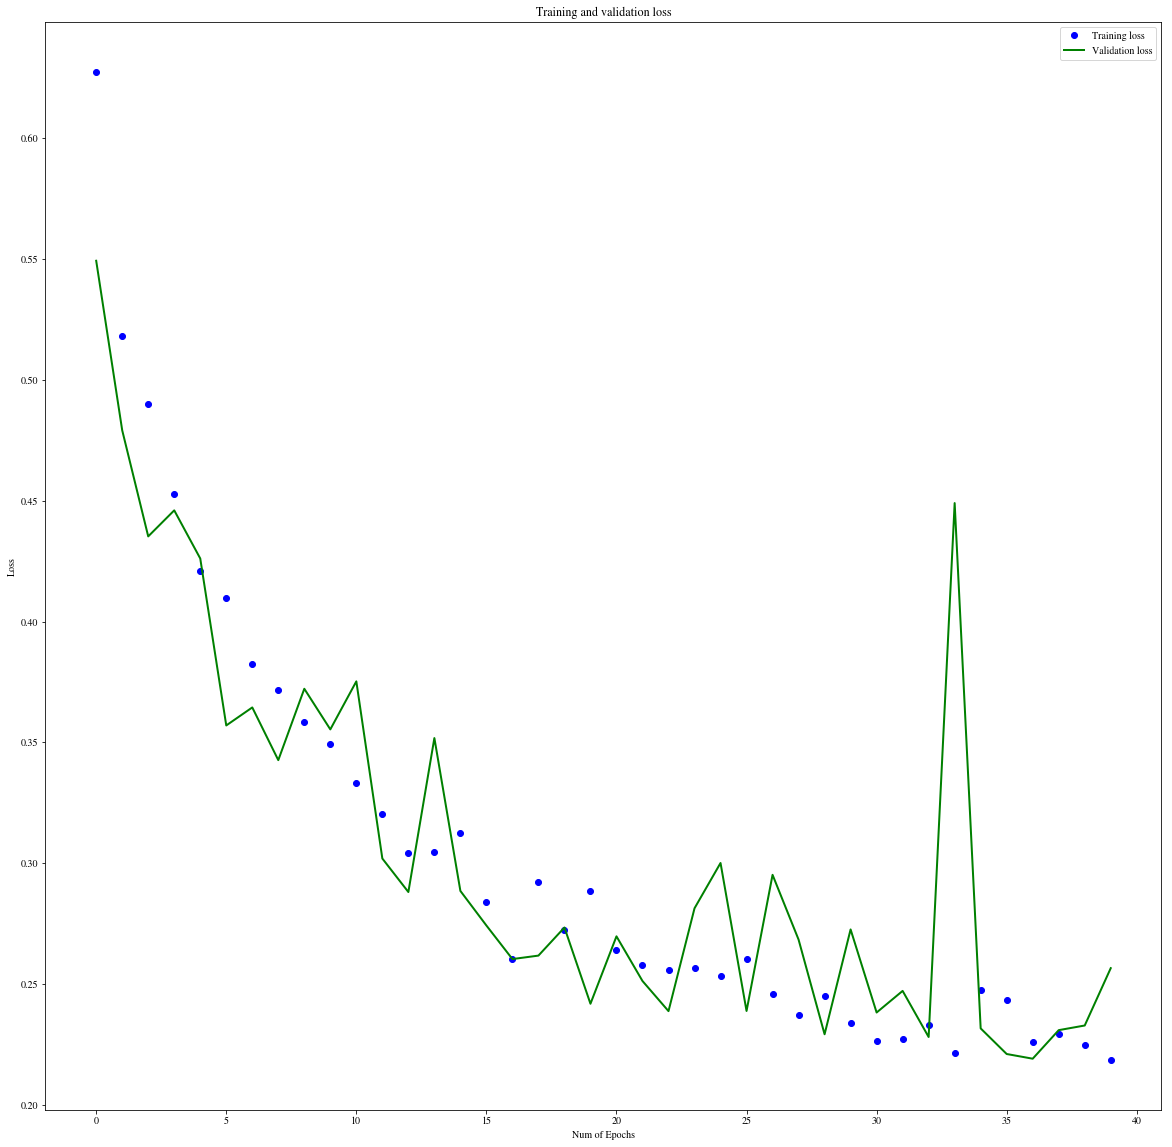

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 48)        1344      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 48)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 96)        41568     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 96)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24576)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               12583424  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

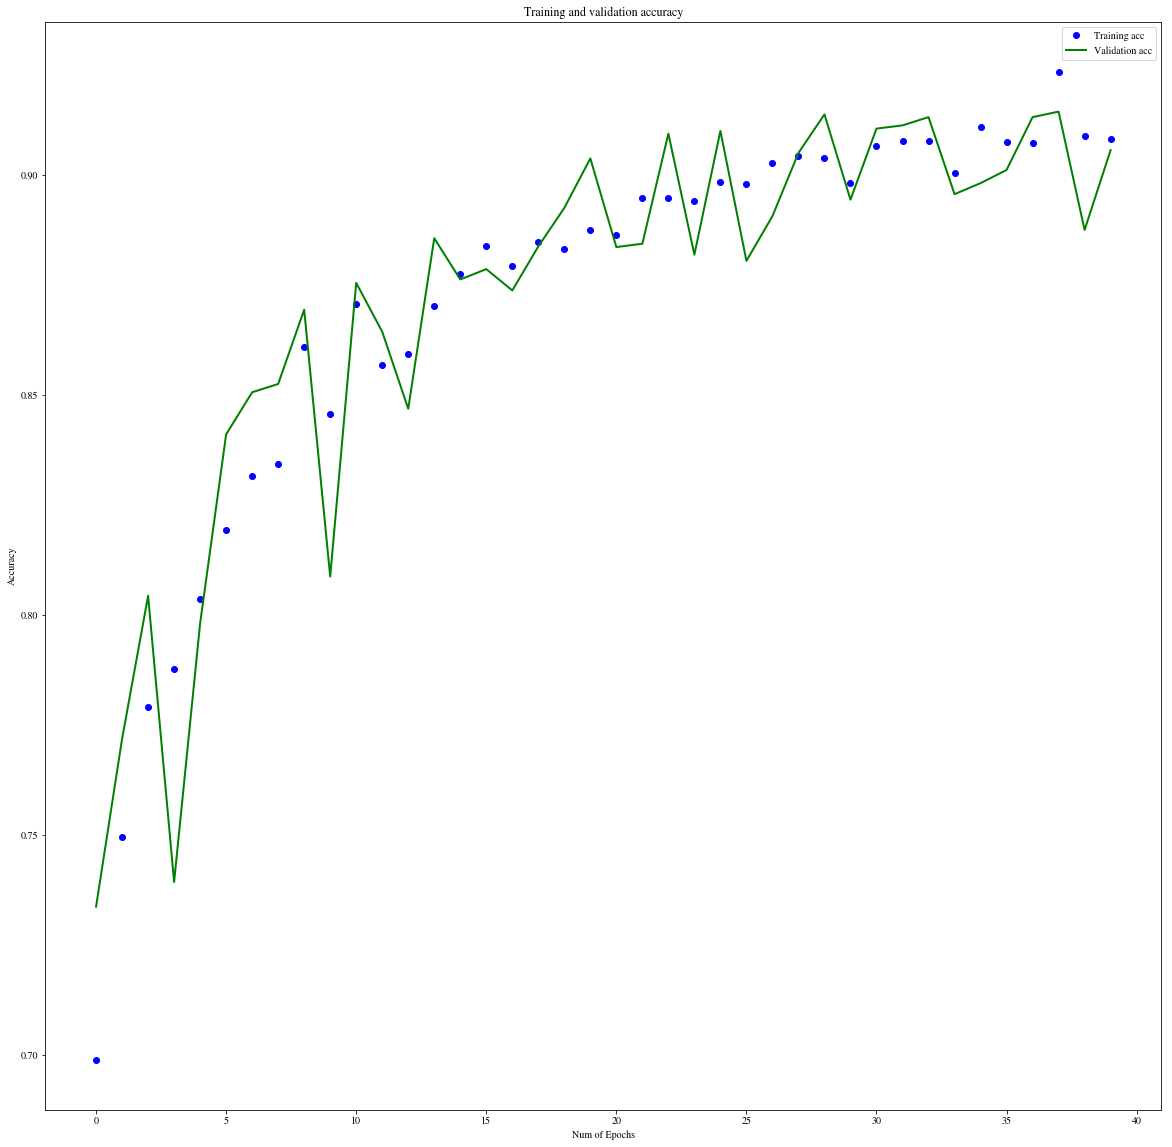

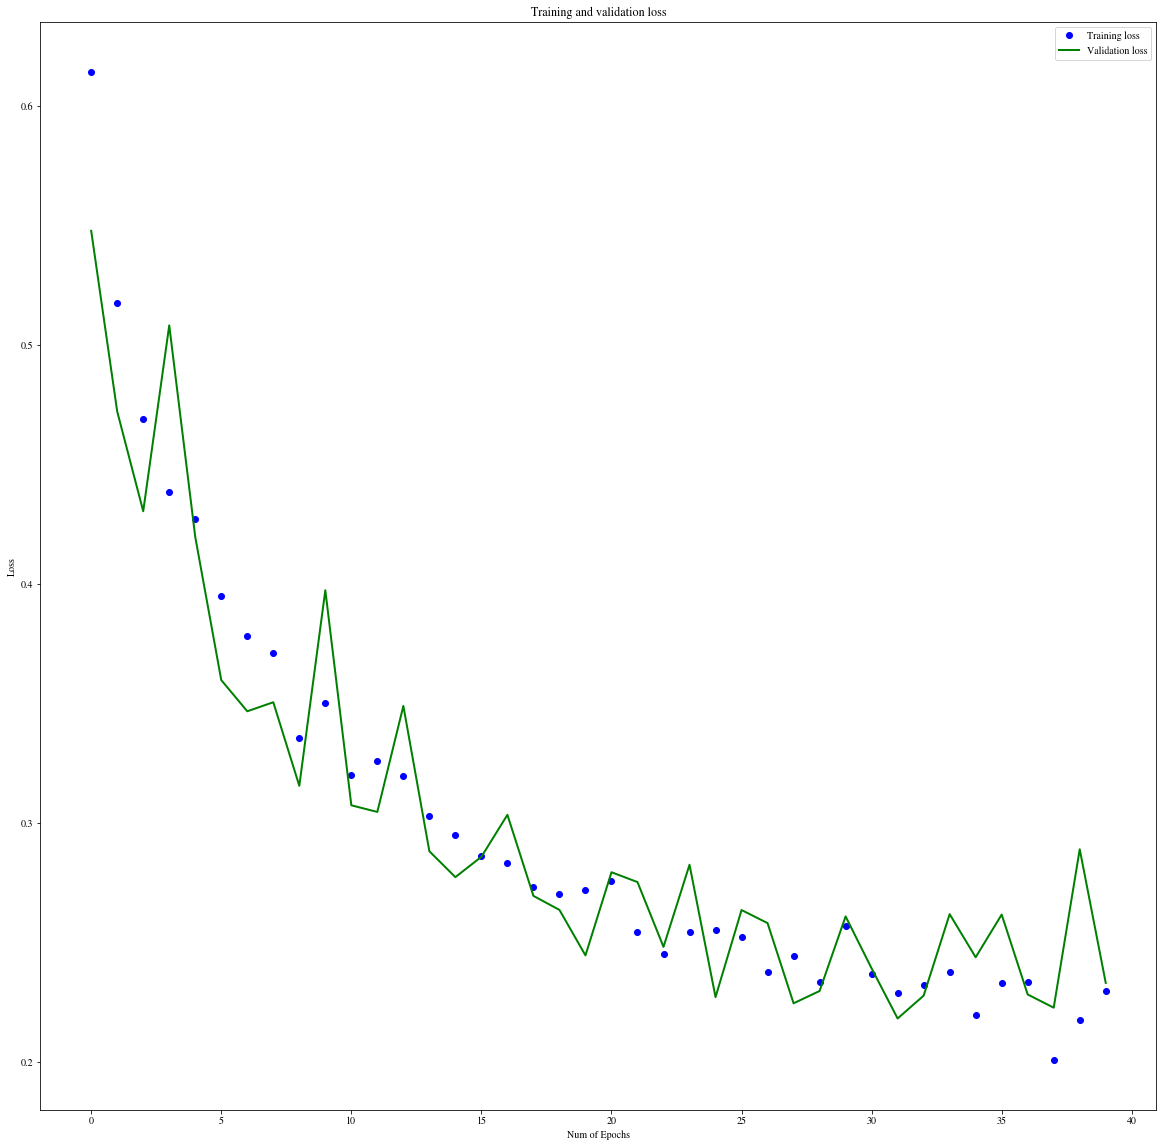

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               16777728  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

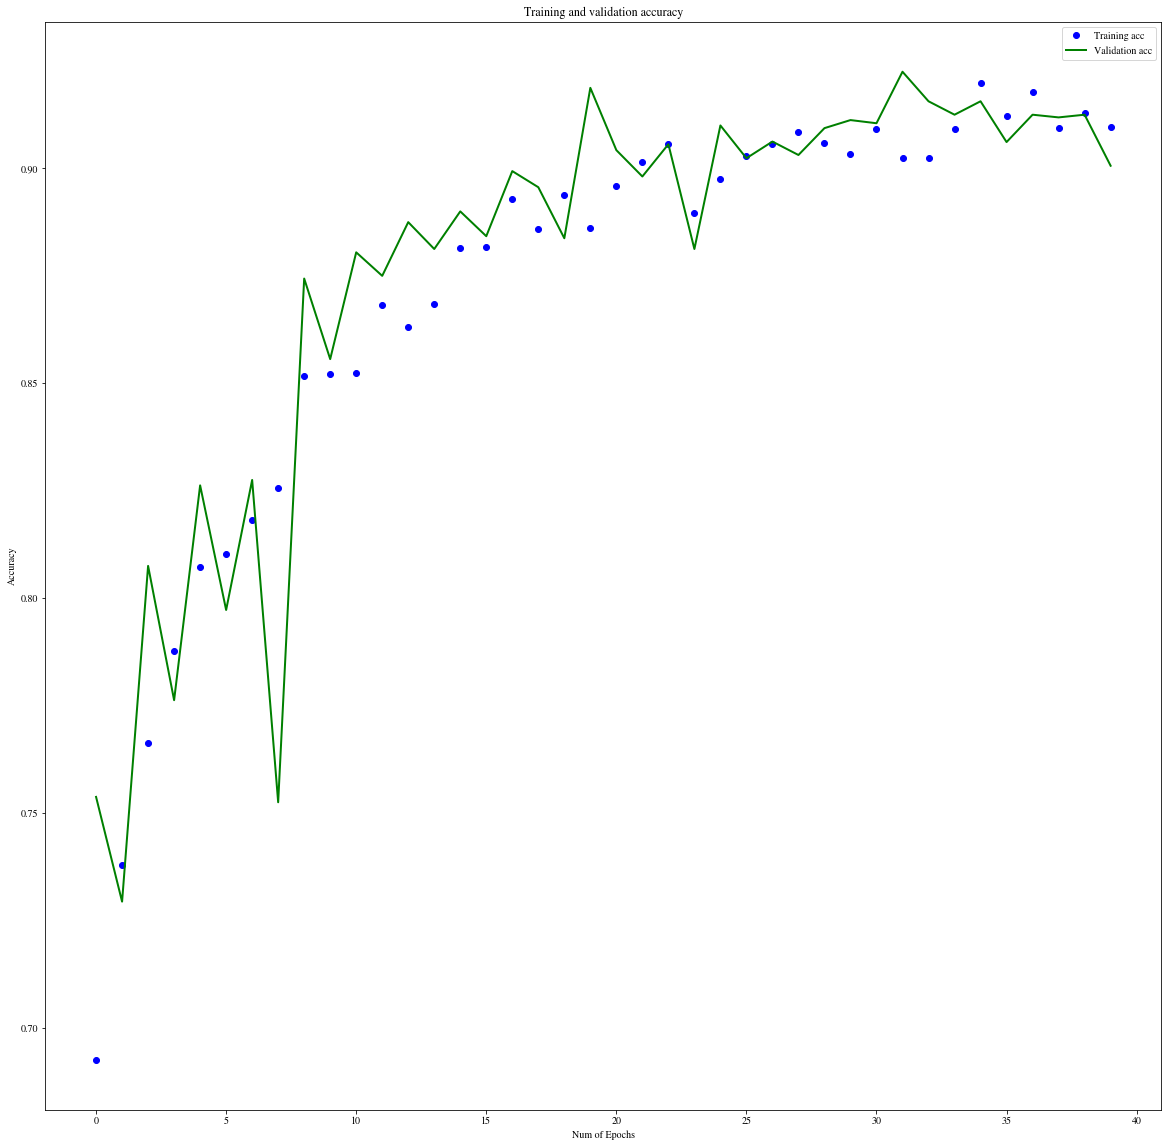

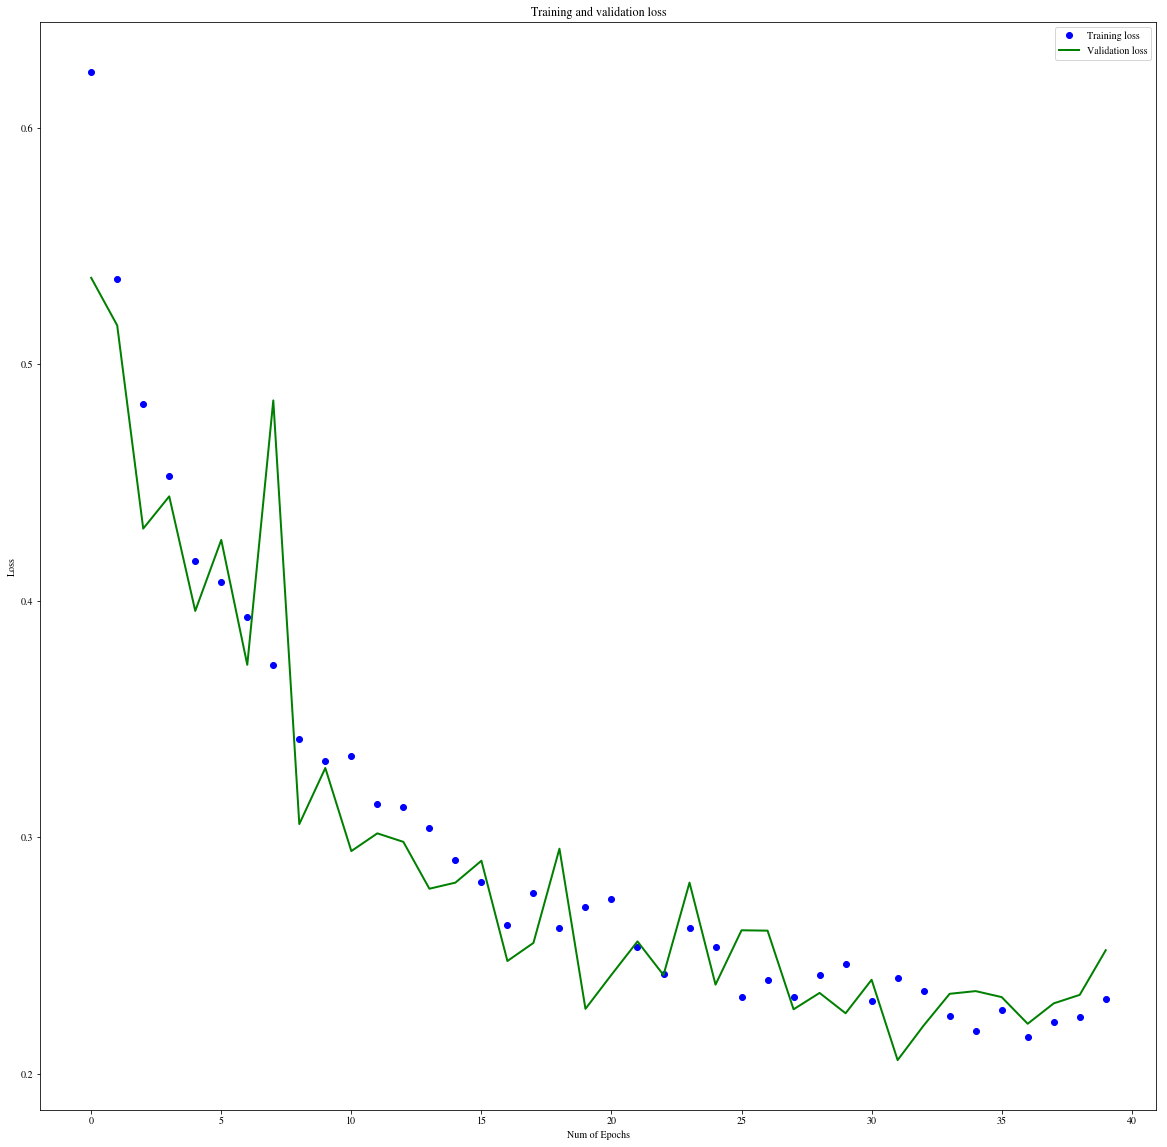

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 80)        2240      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 80)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 160)       115360    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 160)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40960)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               20972032  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

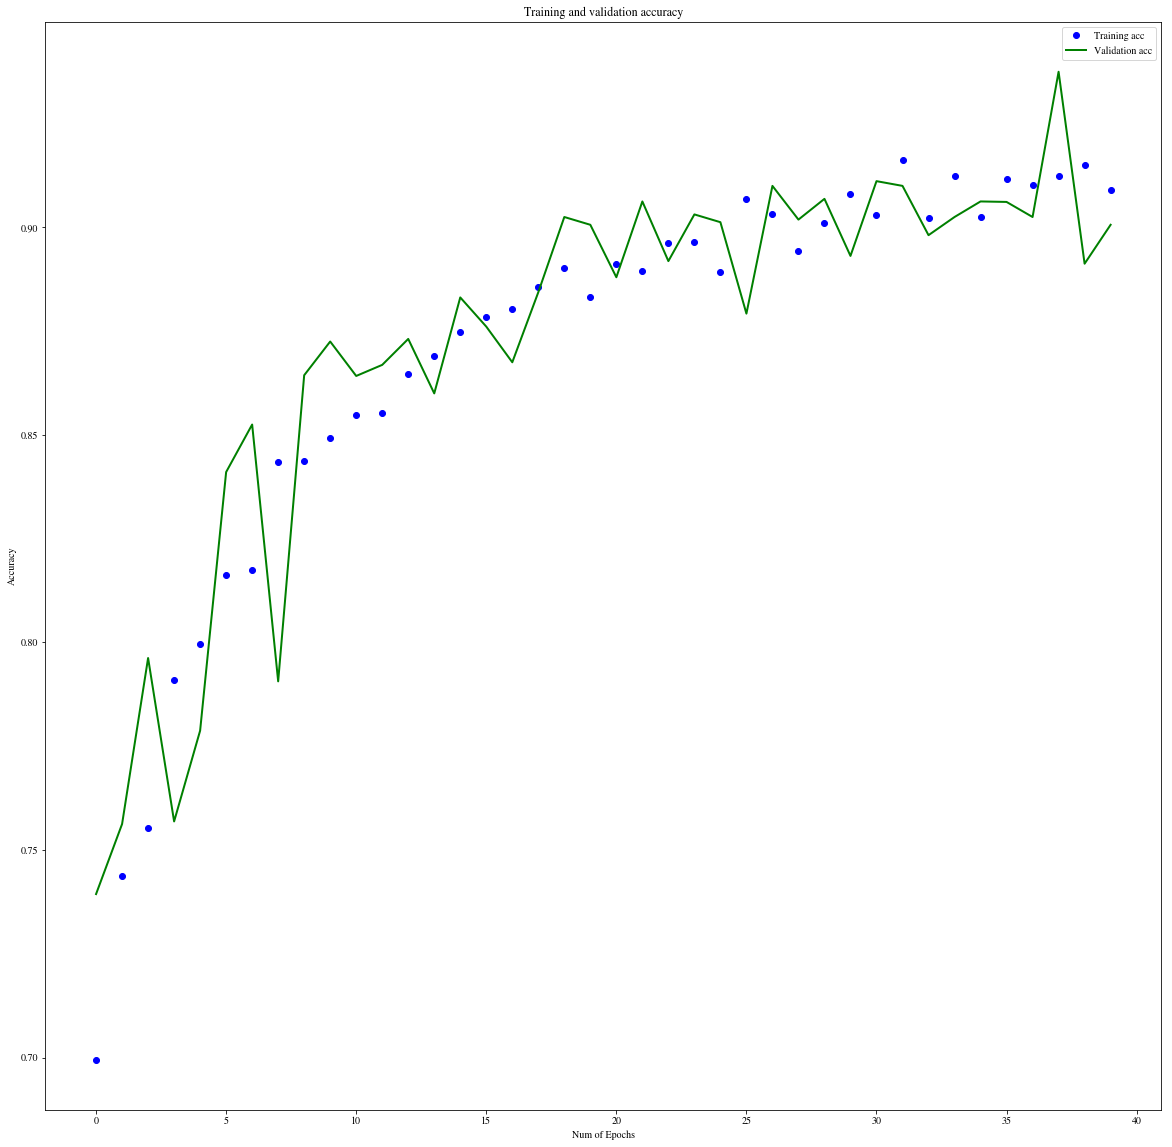

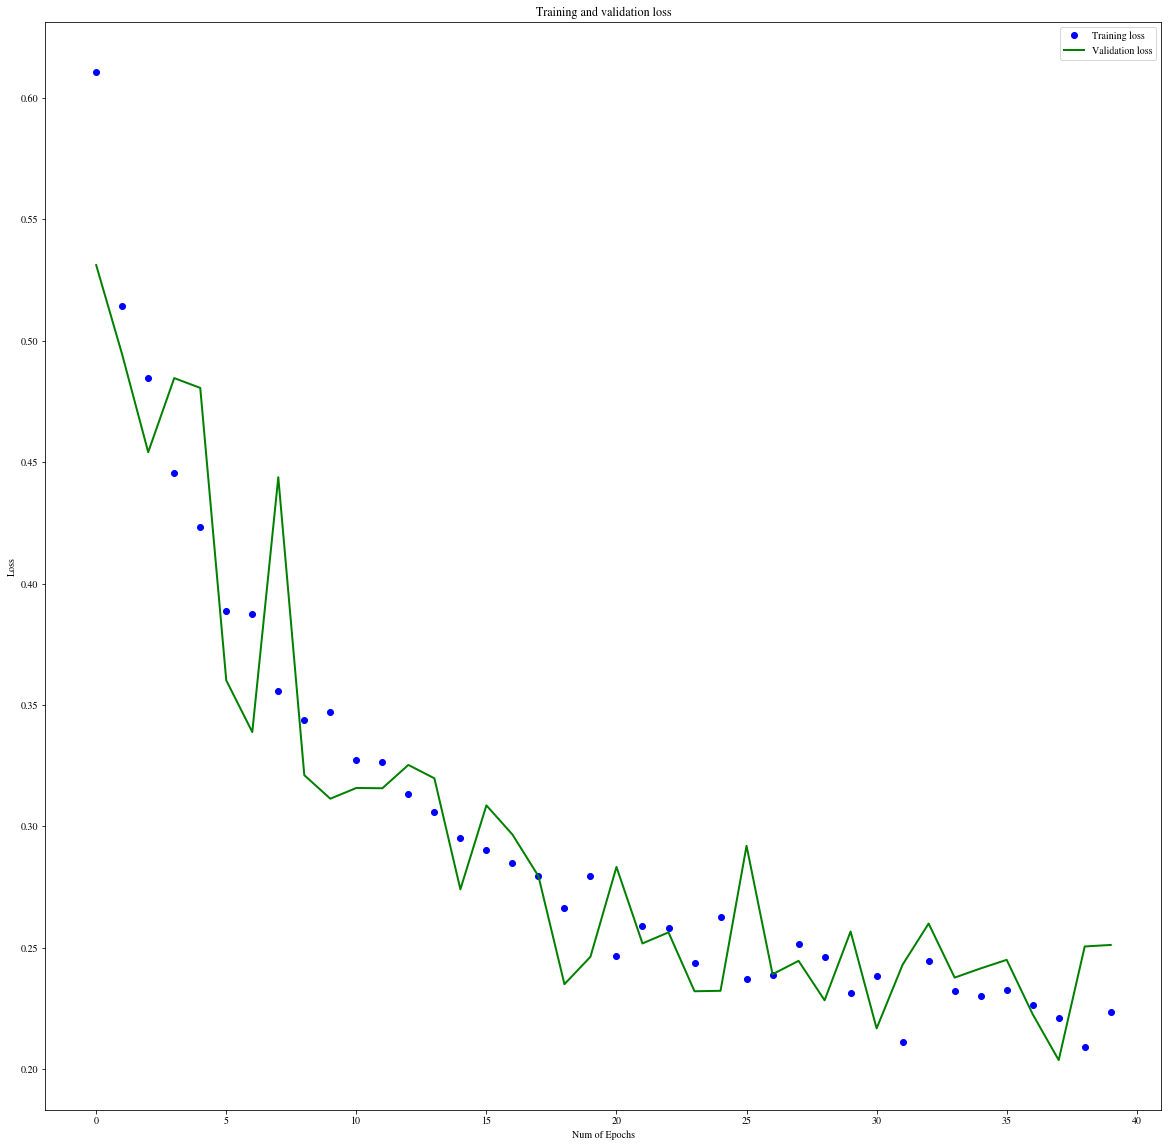

In [9]:
sgd = optimizers.SGD(lr = 0.05, decay=1e-5, momentum=0.9, nesterov=True)
CNN_Architecture_Selector_2('relu', 'sigmoid', 'sgd', 40)

#### 1.3.3 Architecture Choice -- Determine the number of units for the dense layers
<span style="color:blue"> 
Here, we set the number of convolution-subsambling pairs as 2, and use 16 maps in the first convolutional layer and 32 maps in the second convolutional layer. I will try different number of units for the dense layers: 16, 32, 64, 128, 256, 512, and 1024. 
</span>

In [19]:
def CNN_Architecture_Selector_3 (activation_function_1, activation_function_2, optimizer_type, epoch_number):
    K.clear_session()
    model = [0] * 7
    
    for j in range(0, 7):
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(2**(j+4), kernel_initializer='glorot_uniform', activation=activation_function_1, name='fc1'))
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, name='fc2'))
        model[j].compile(loss='binary_crossentropy', optimizer = optimizer_type, metrics=['accuracy'])
    
        model[j].summary()
        
        # Fit the model
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epoch_number,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                131088    
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 17        
Total para

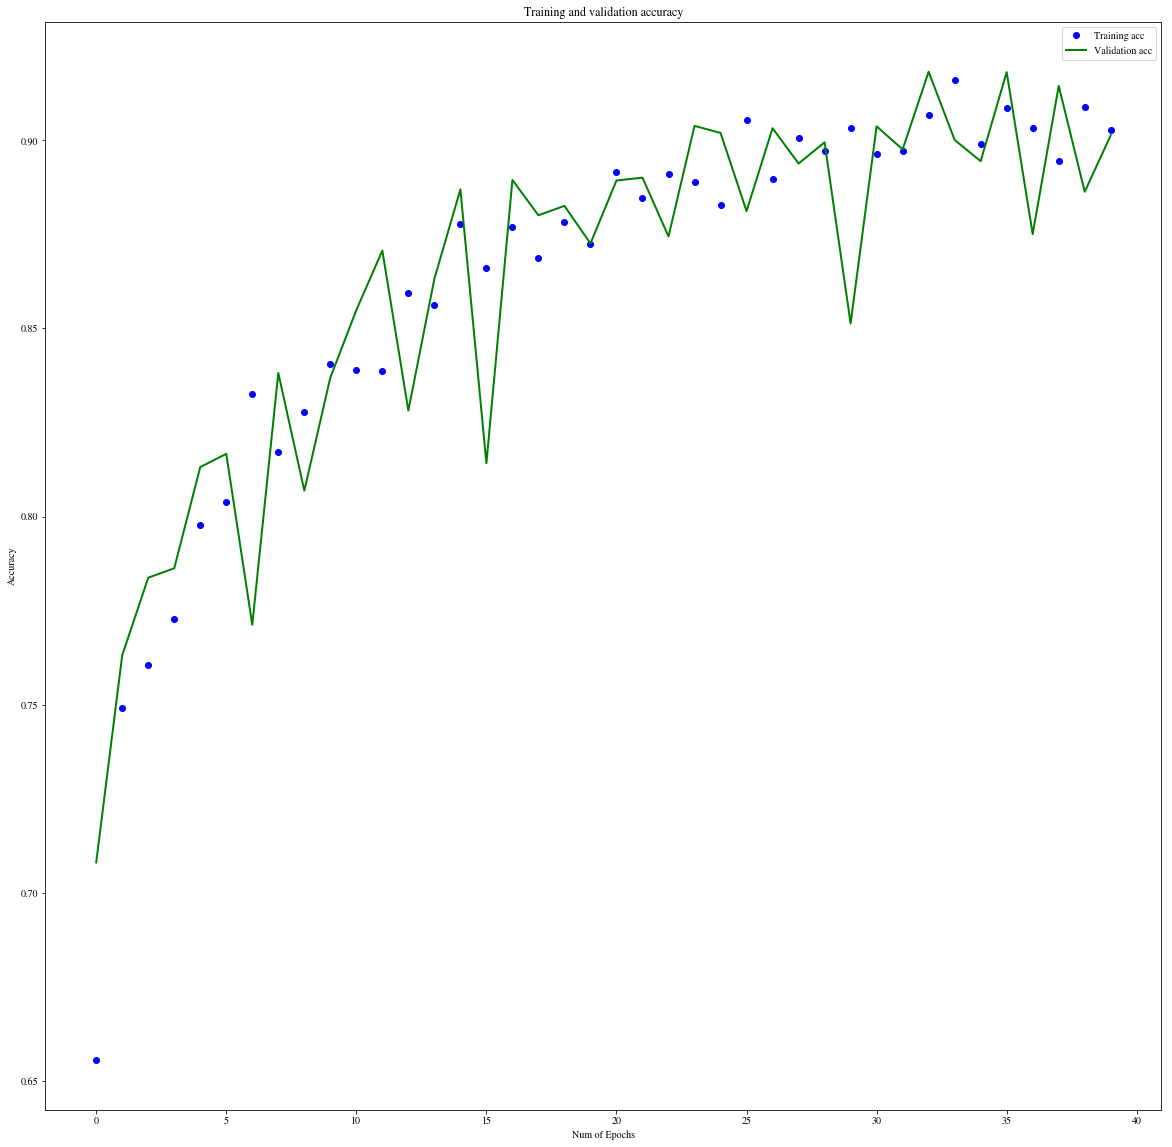

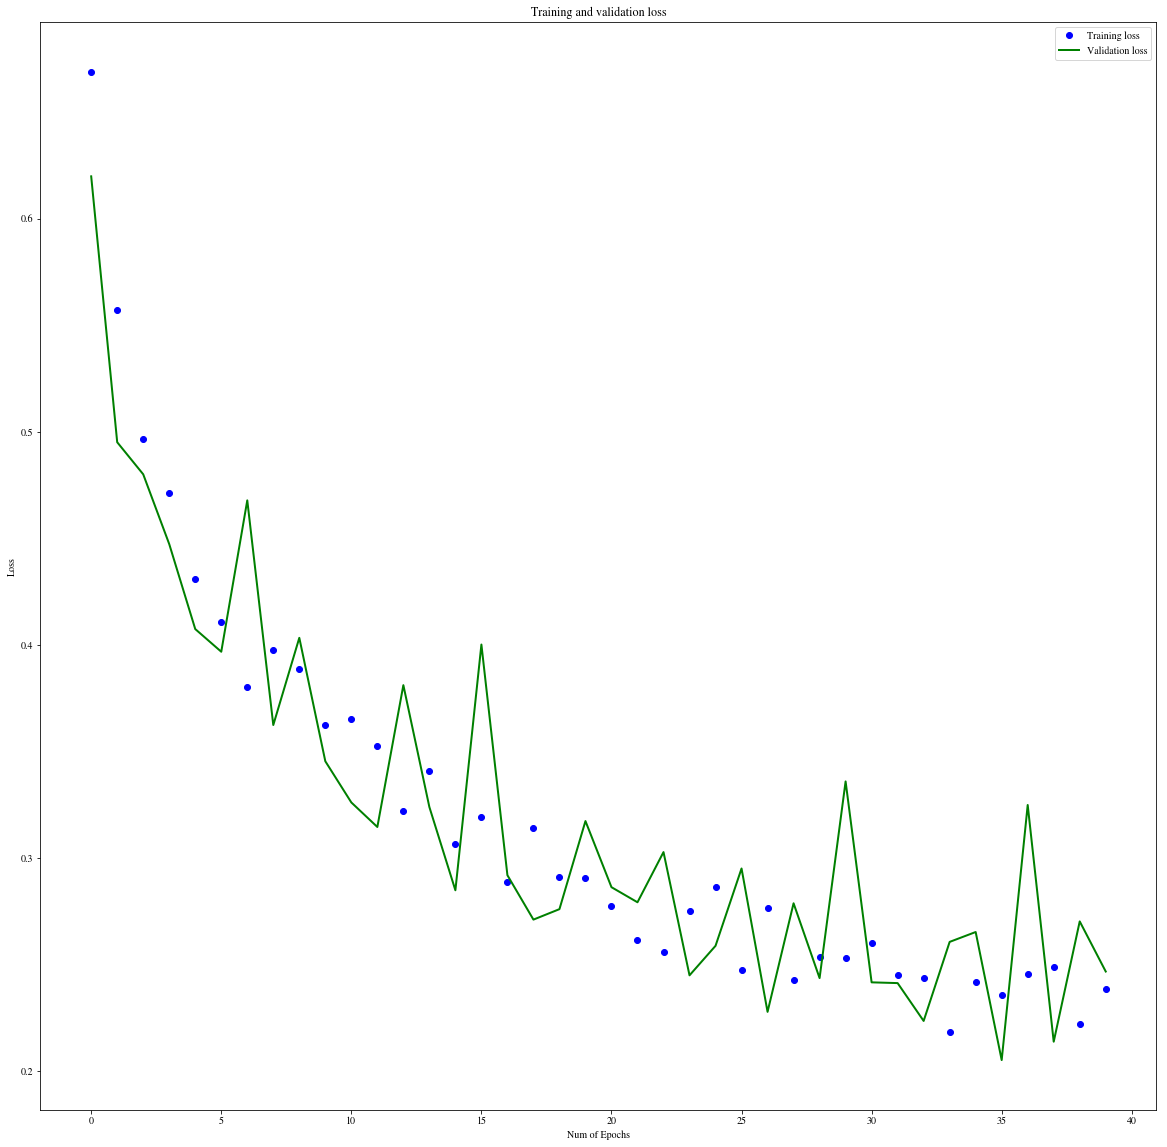

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 32)                262176    
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 33        
Total para

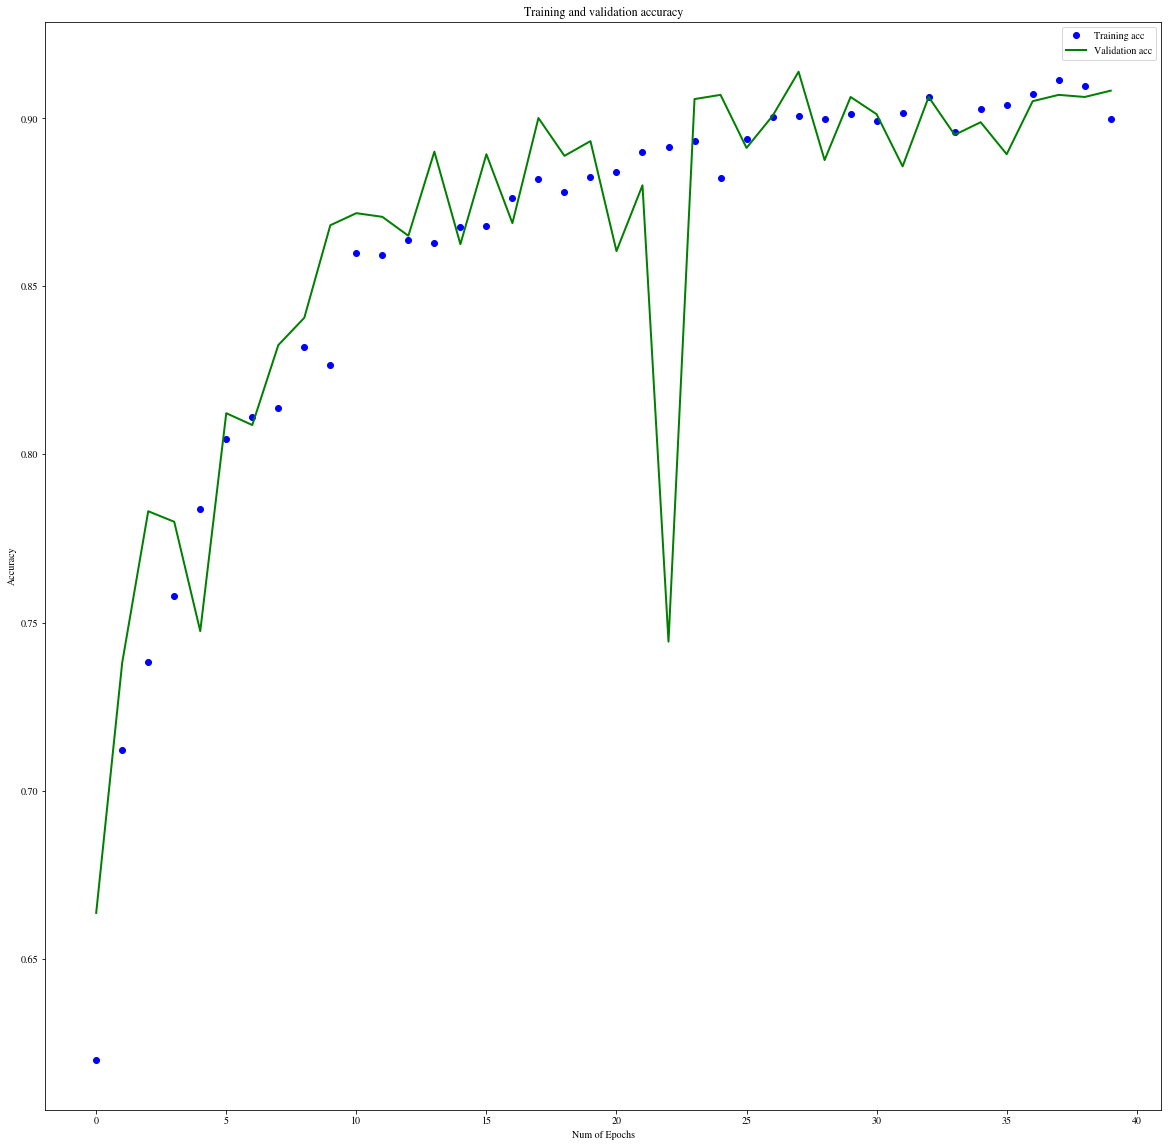

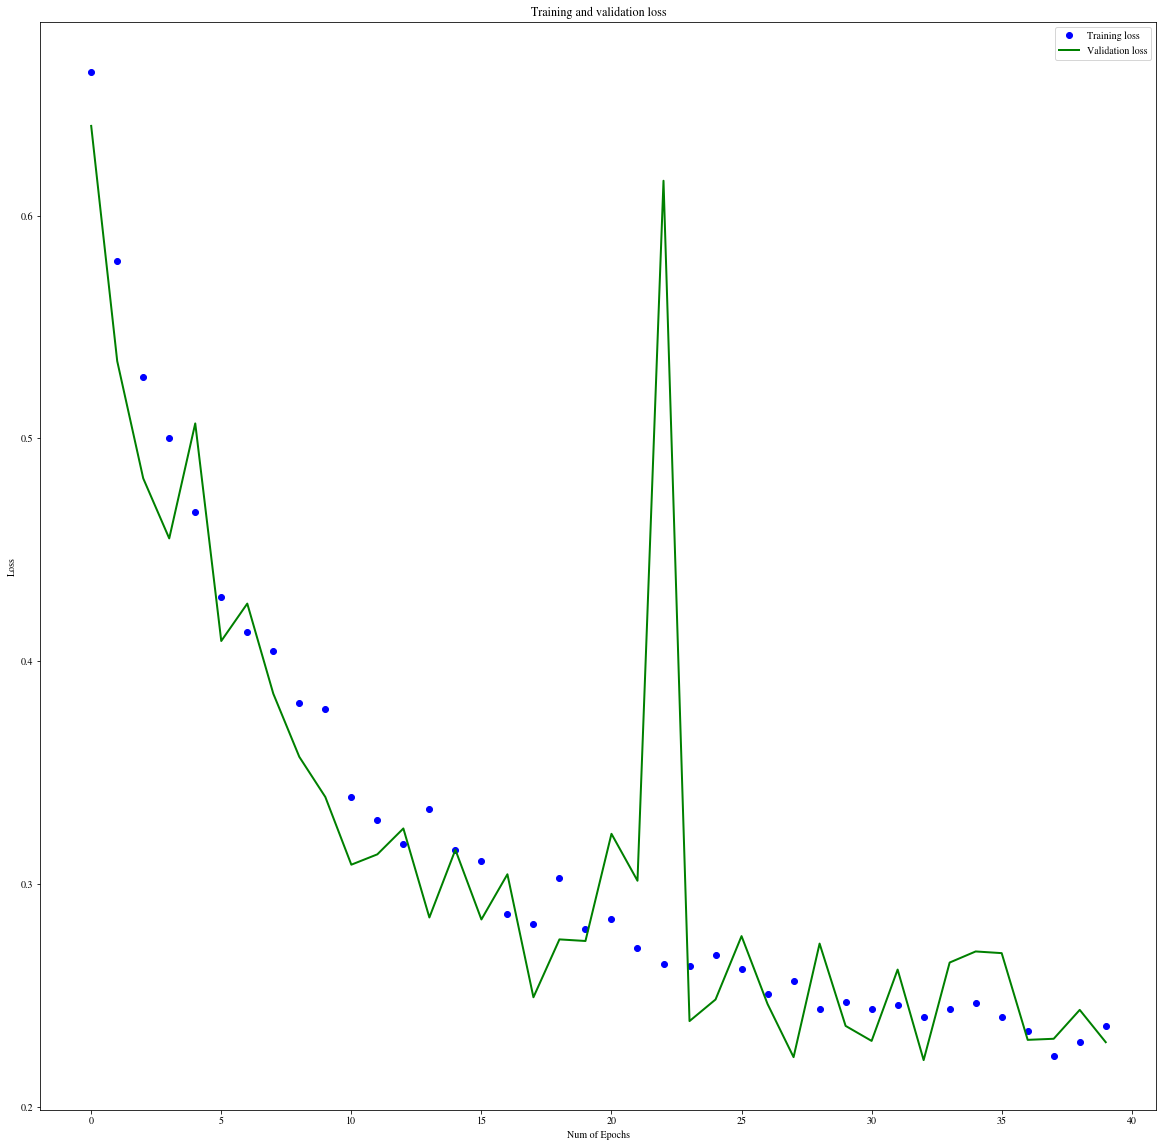

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                524352    
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 65        
Total para

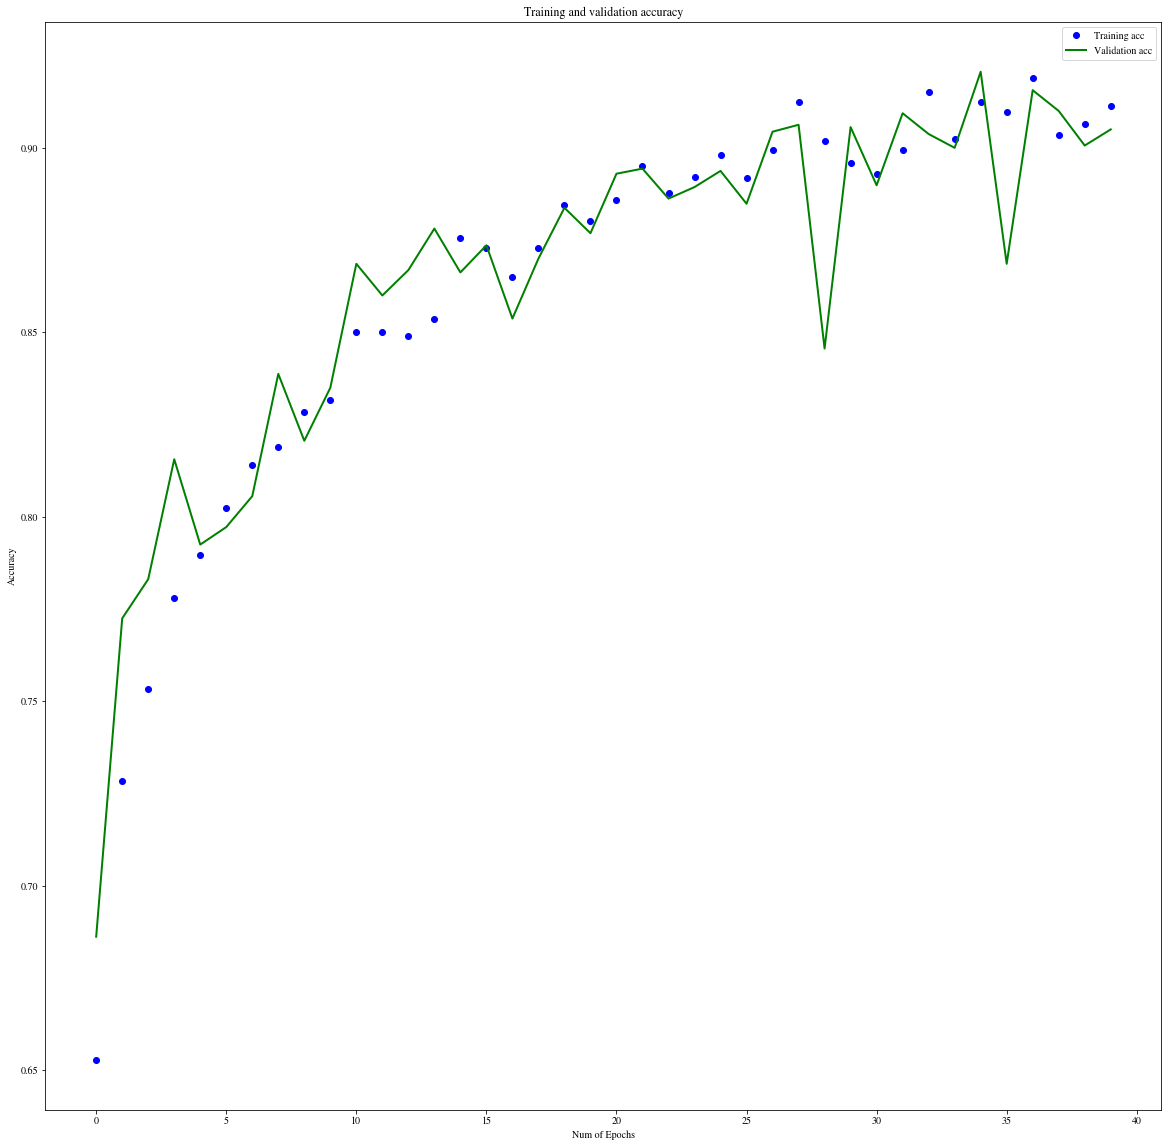

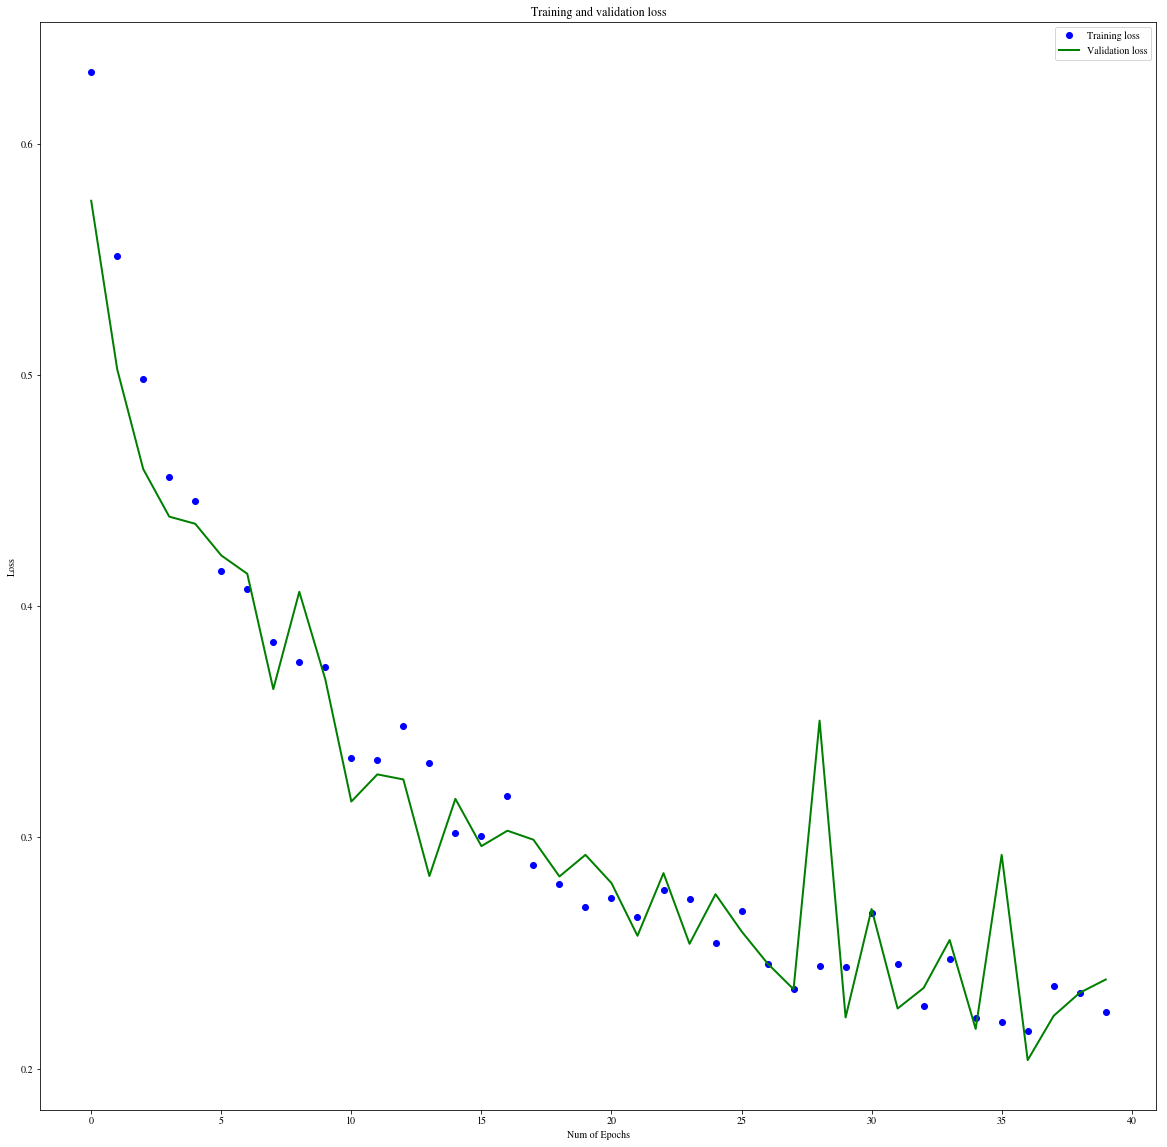

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               1048704   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 129       
Total para

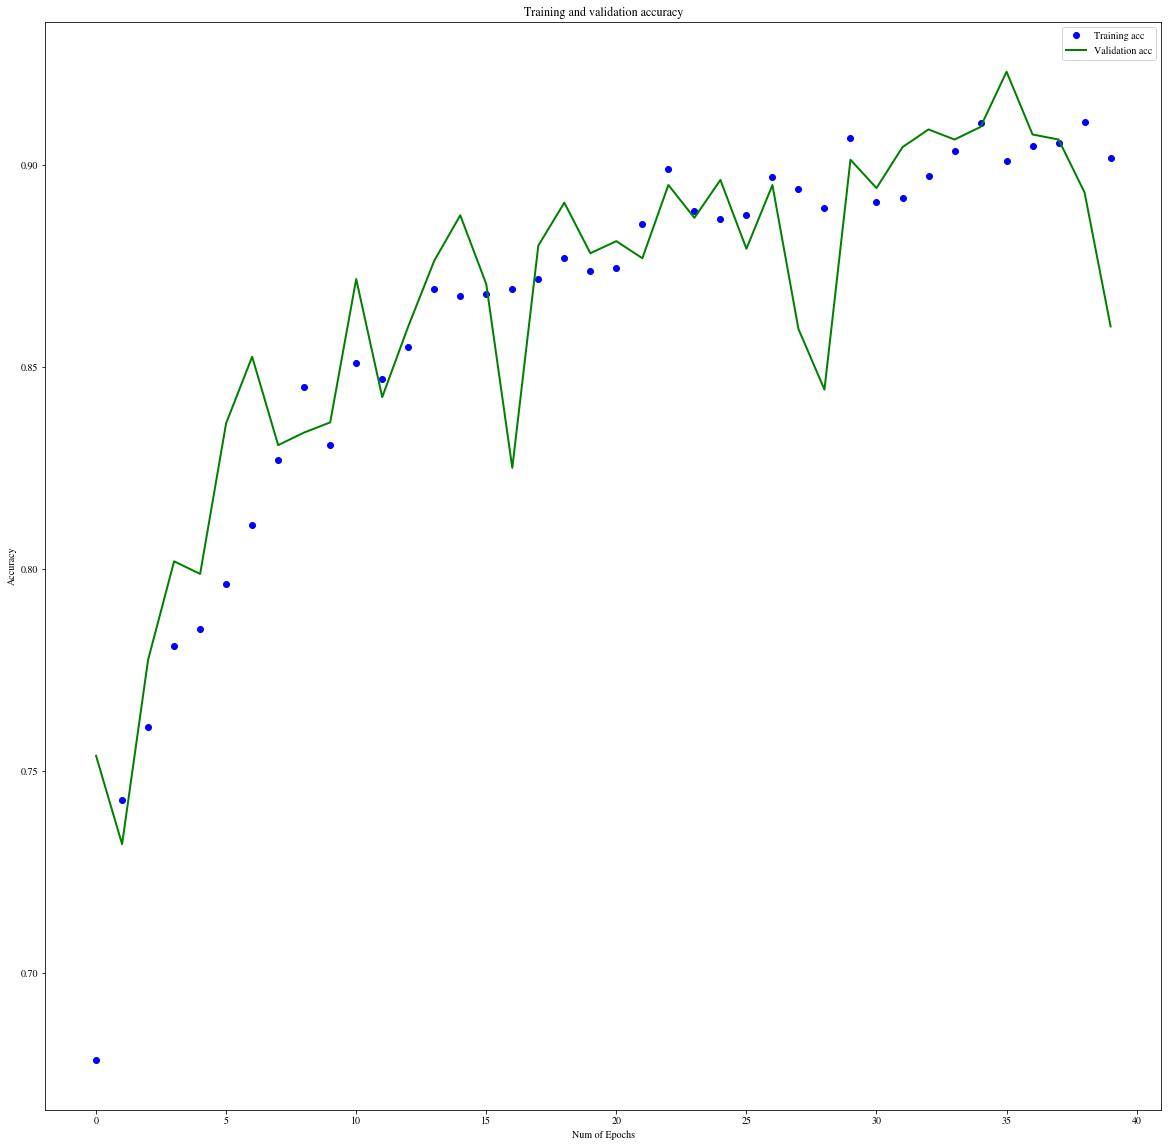

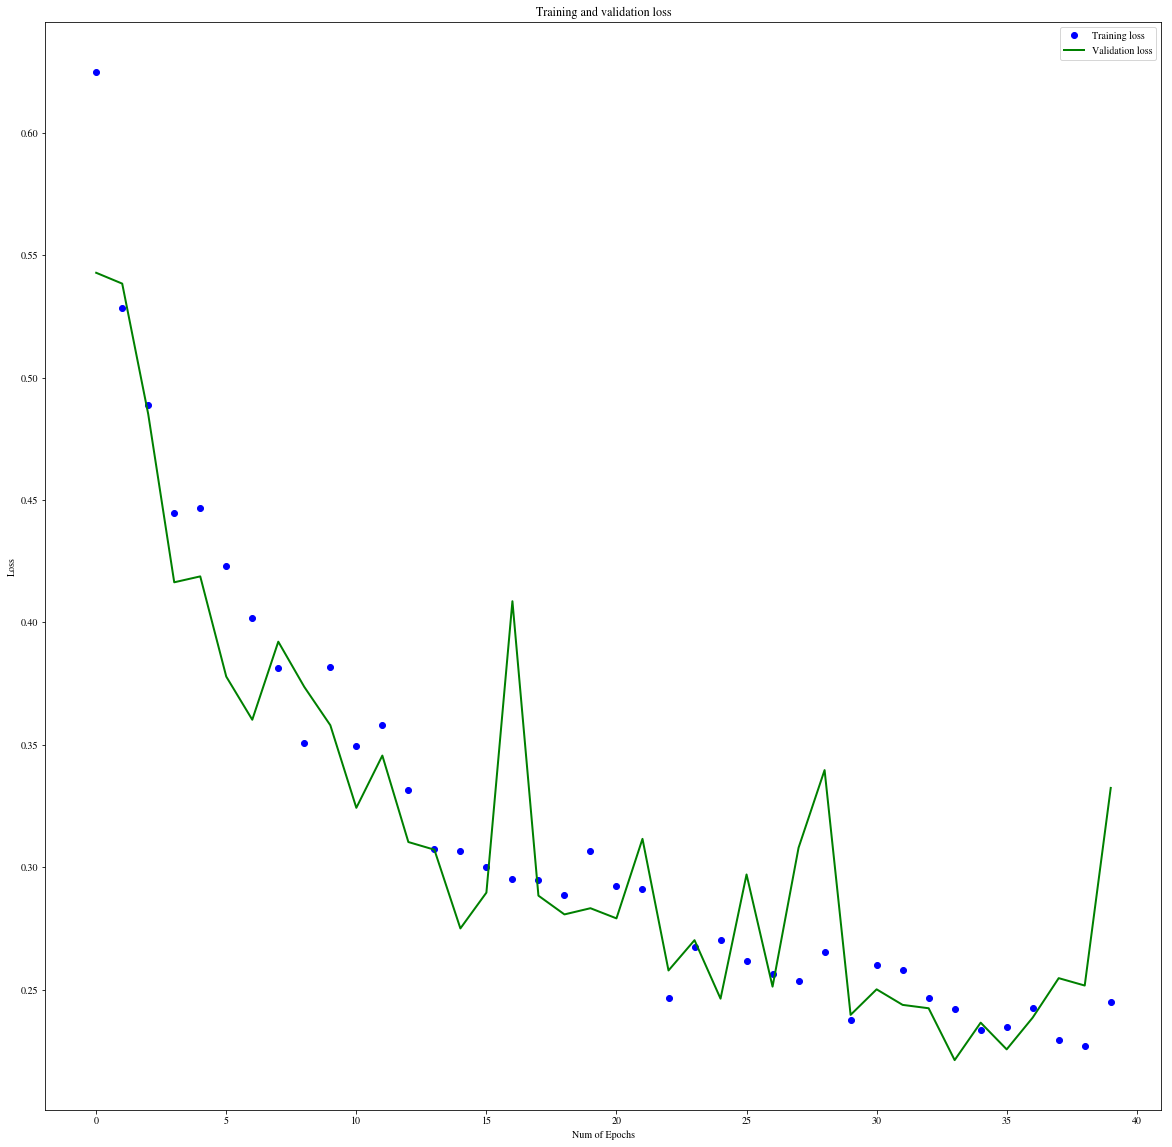

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               2097408   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 257       
Total para

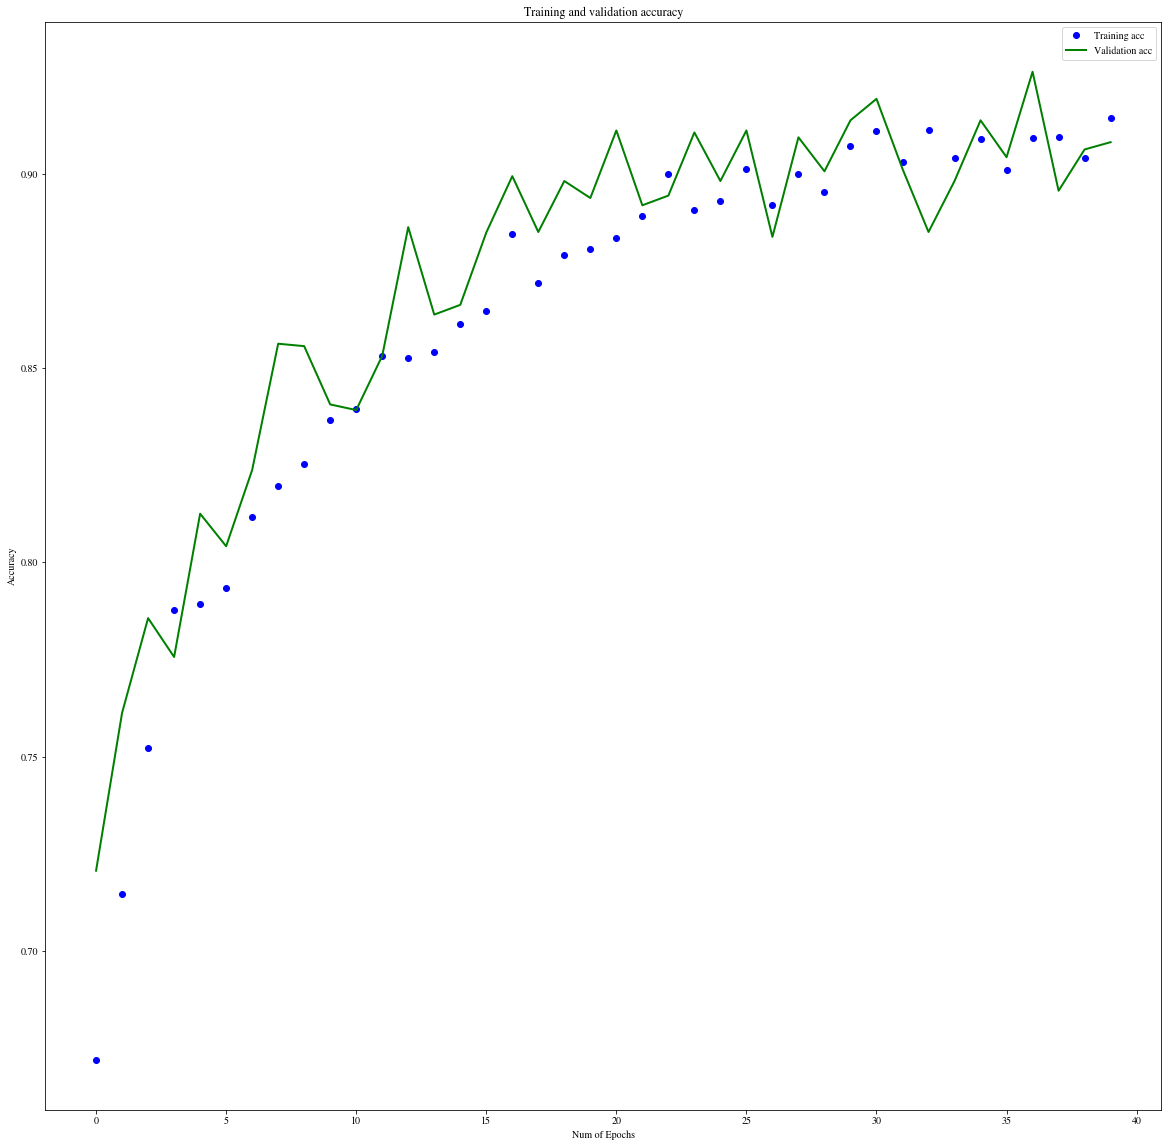

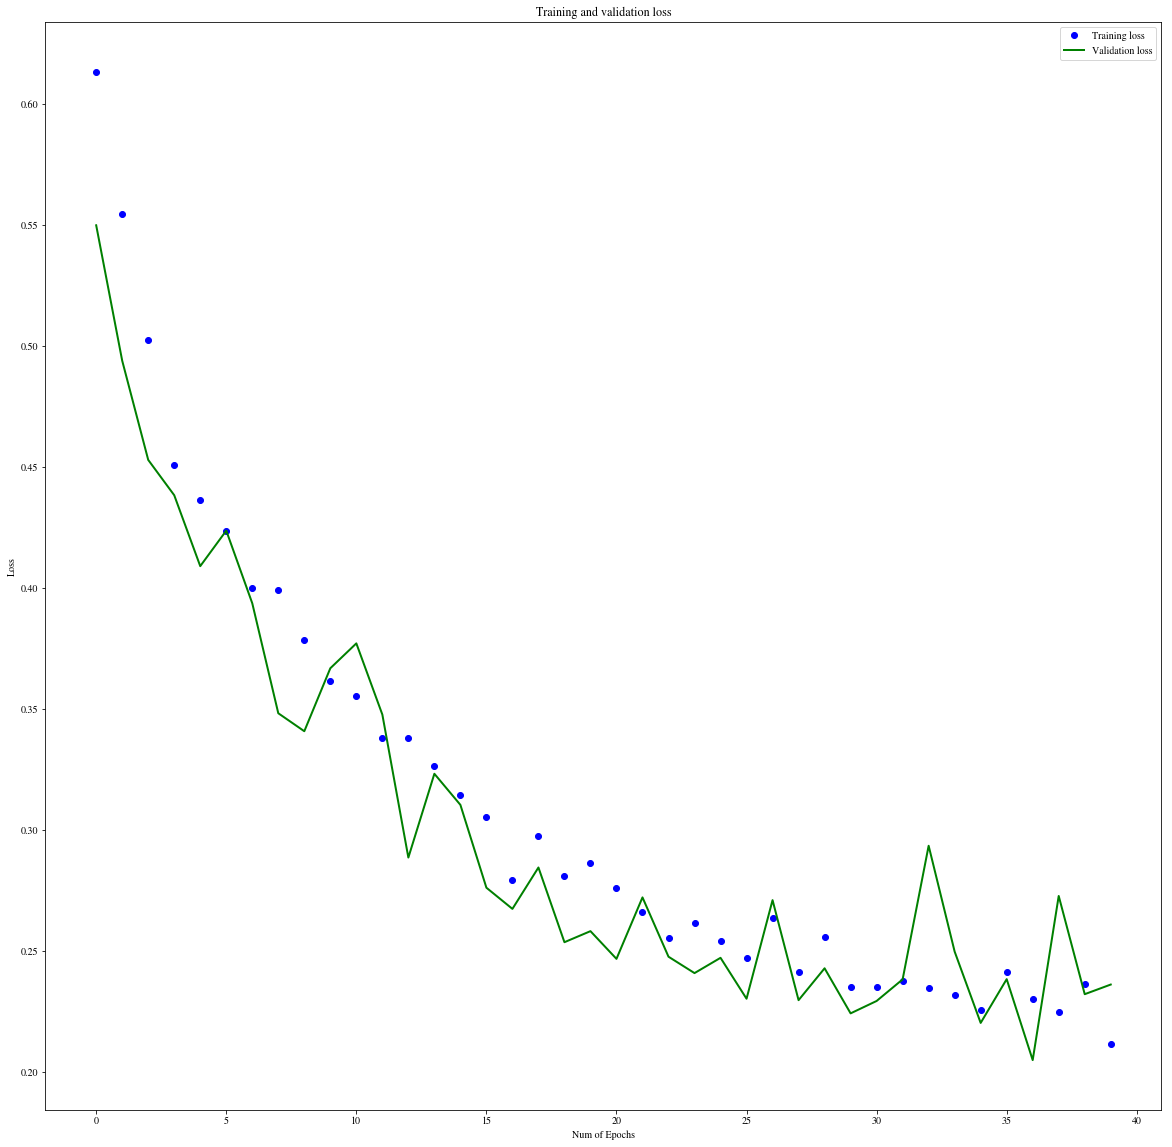

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               4194816   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 513       
Total para

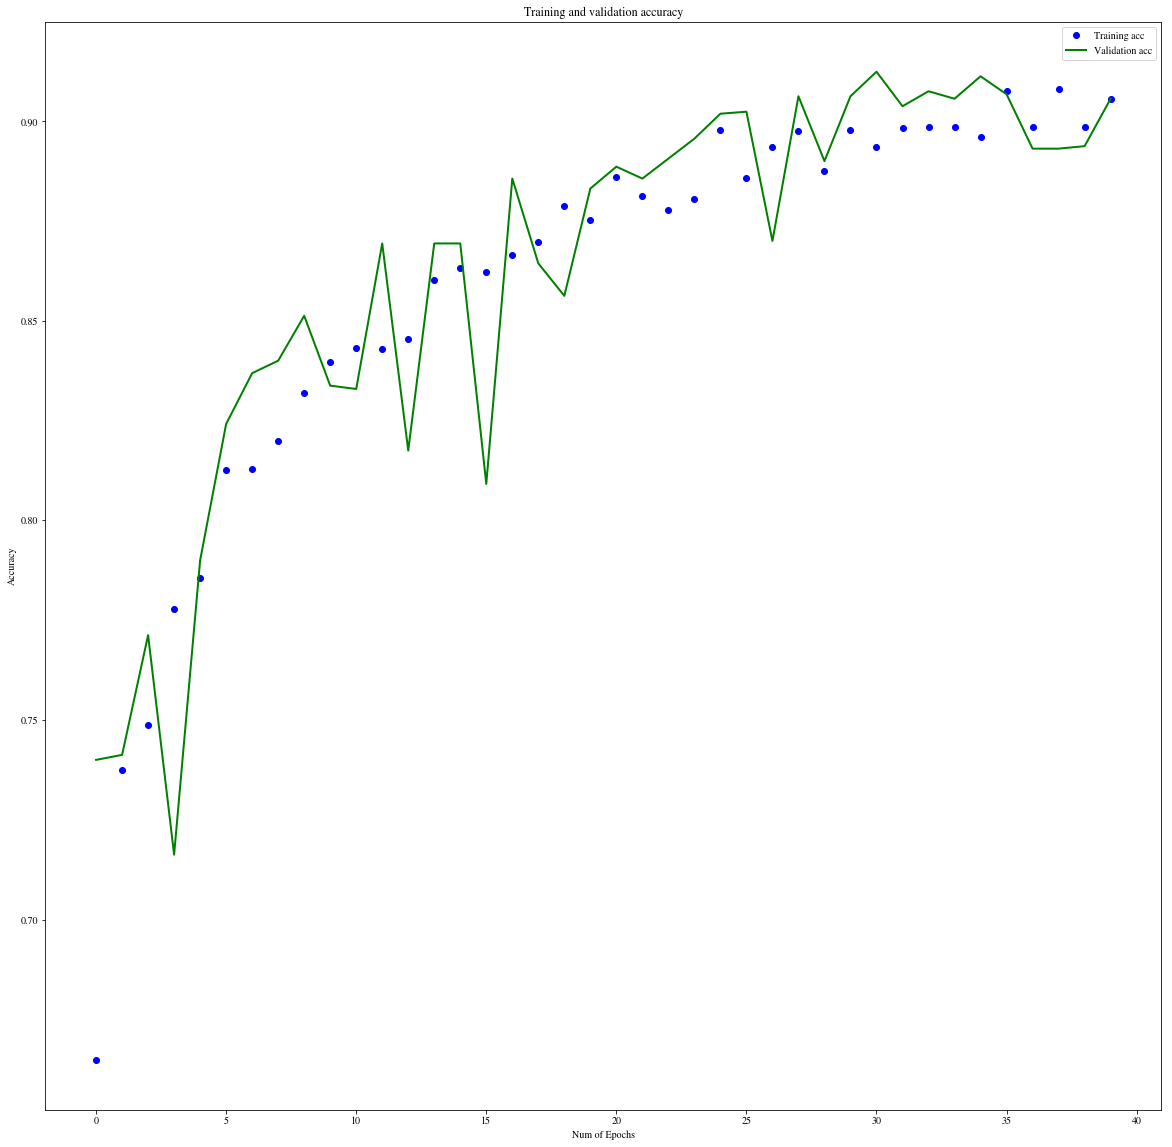

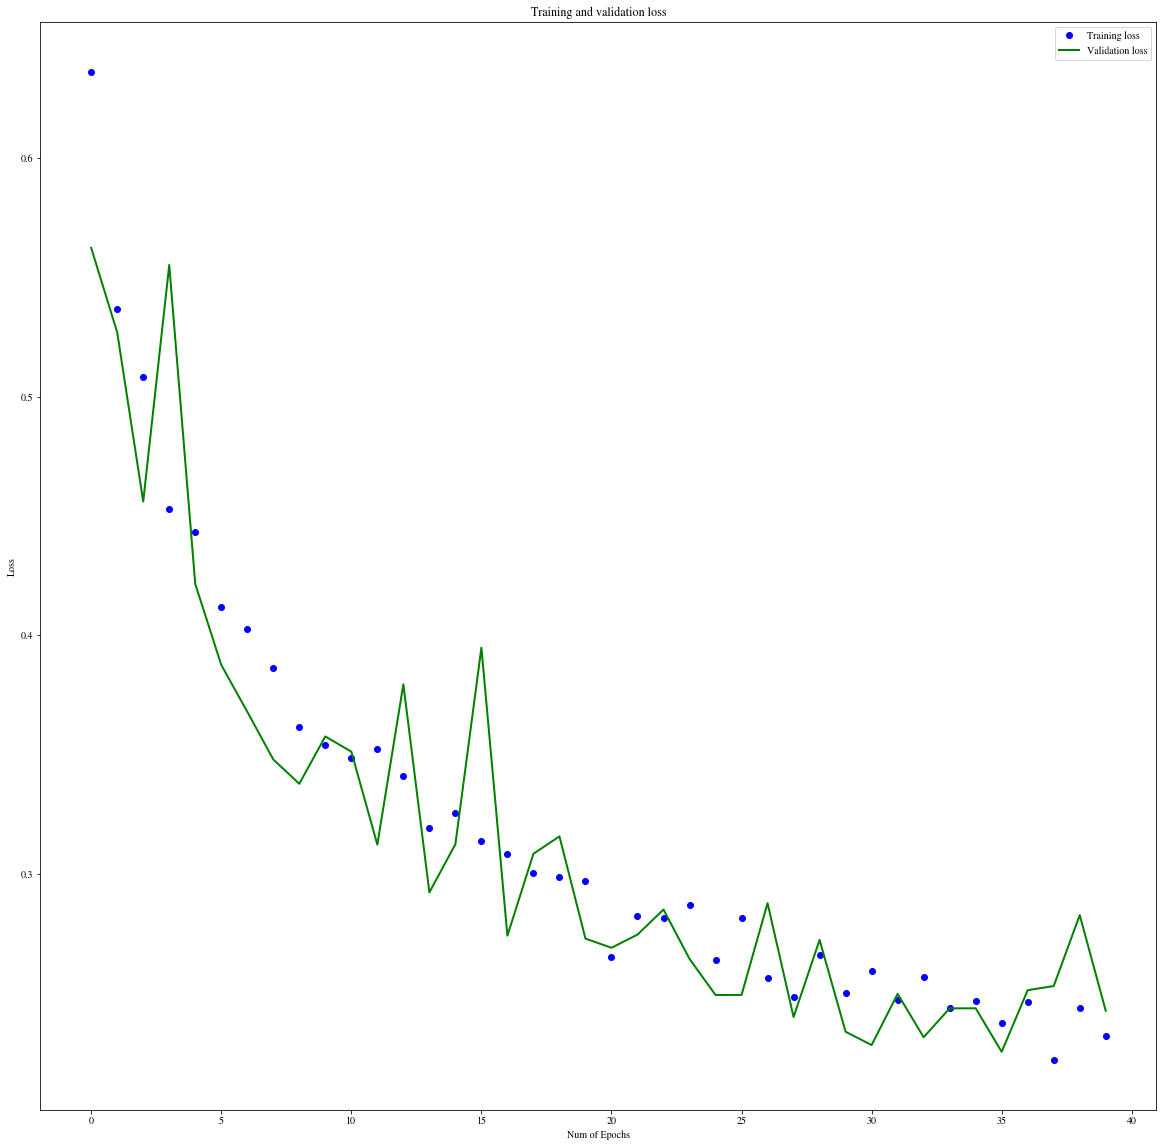

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              8389632   
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 1025      
Total para

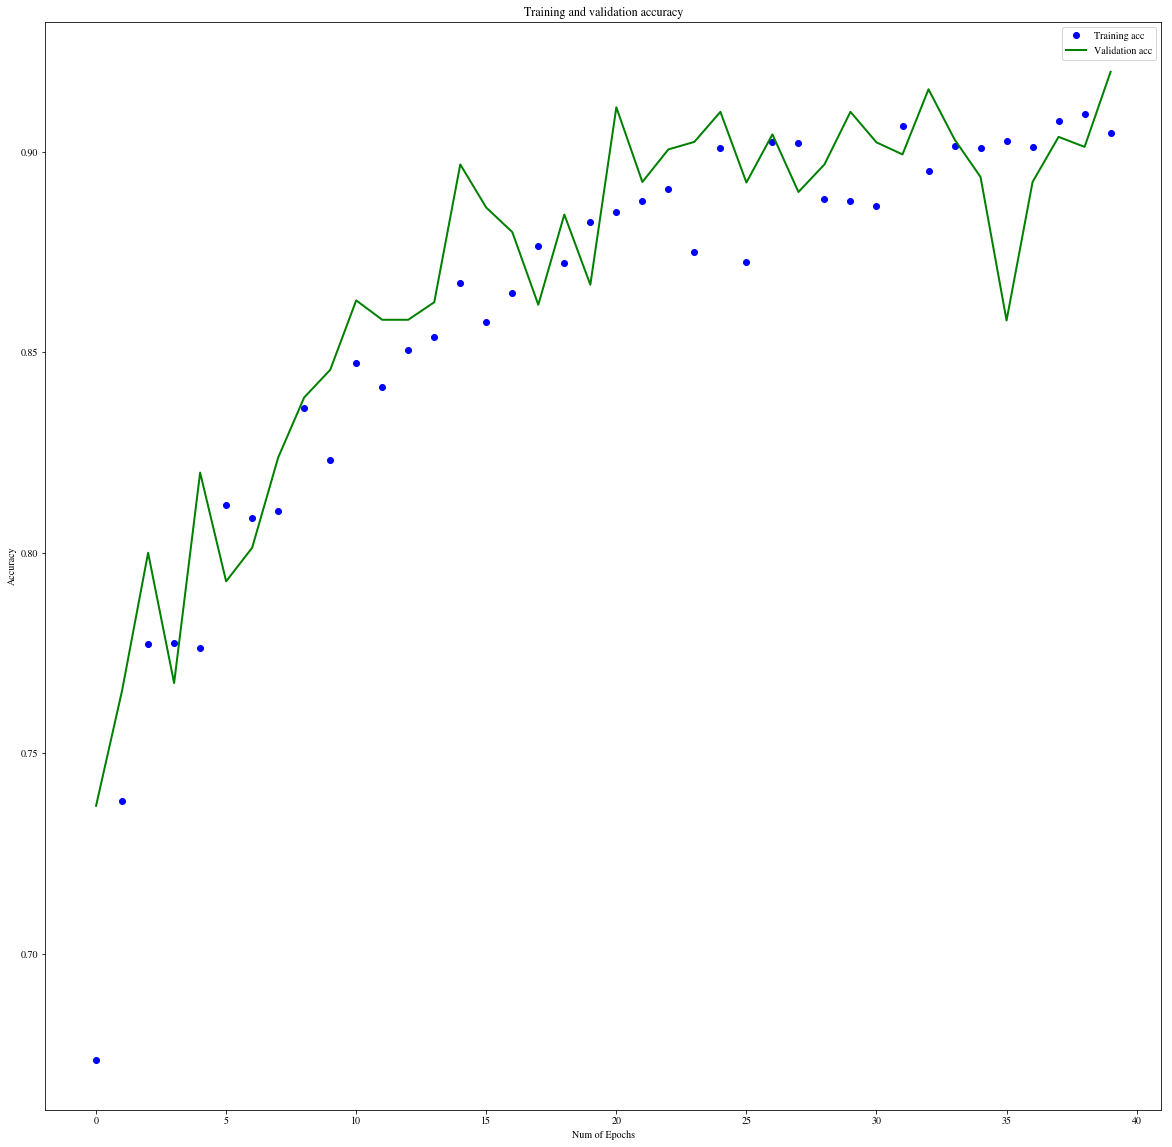

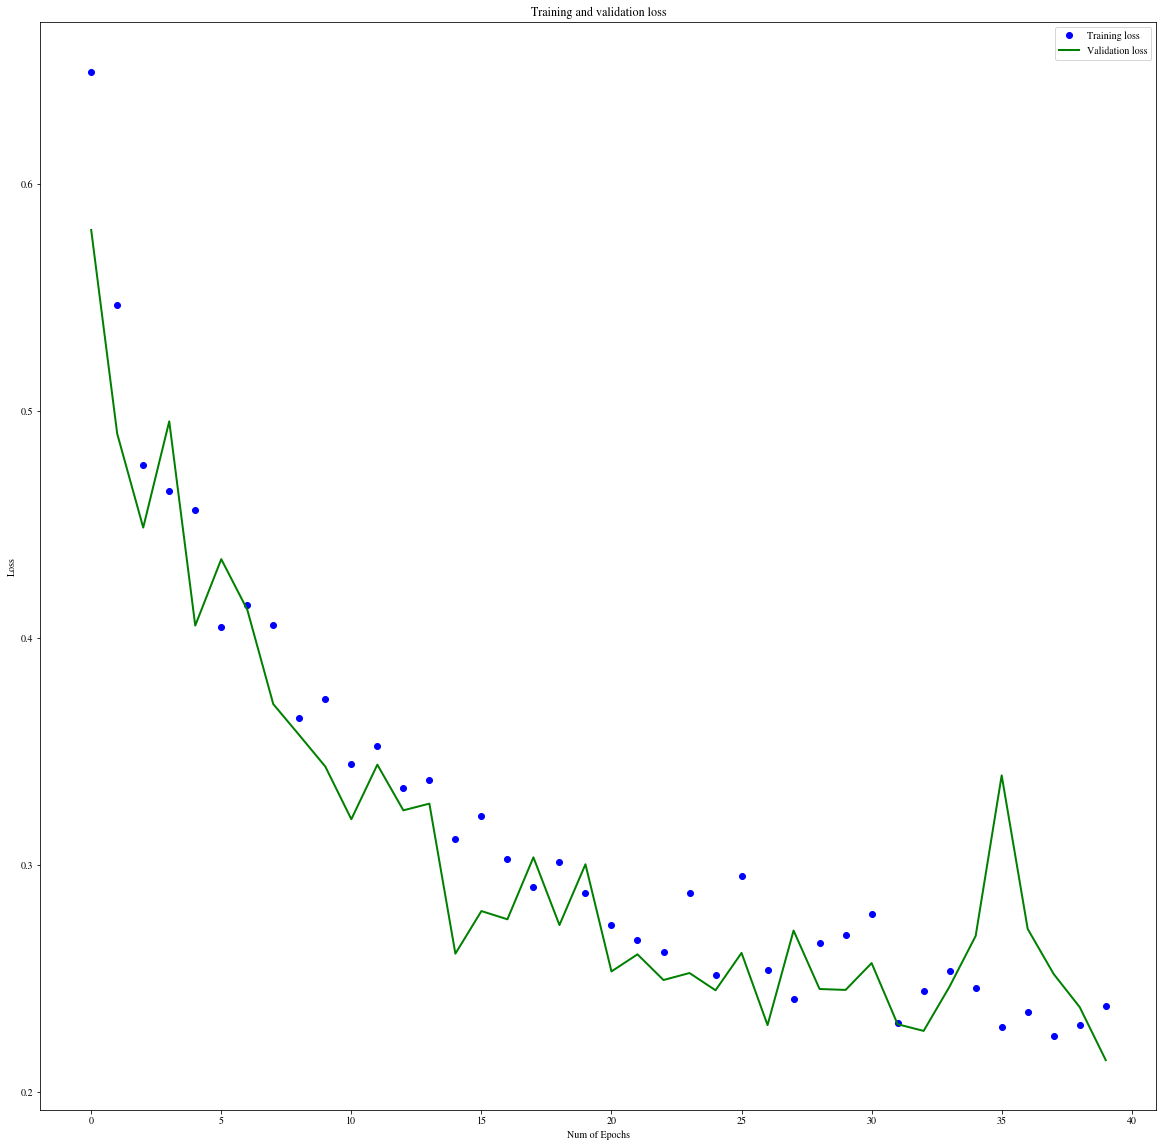

In [20]:
sgd = optimizers.SGD(lr = 0.05, decay=1e-5, momentum=0.9, nesterov=True)
CNN_Architecture_Selector_3('relu', 'sigmoid', 'sgd', 40)

#### 1.4 The Interpretation of Results for Architecture Choice
<span style="color:blue"> 
(1) The number of convolution-subsambling pairs: Based on the accuracy and loss of training, validation, and test sets, we found that the optimal number of convolution-subsambling pairs is 2. <br>
(2) The number of feature maps: It appears that 16 maps in the first convolutional layer and 32 maps in the second convolutional layer is the optimal choice. Increasing the number of feature maps only improves the results slightly better, which is not worth the additional computational cost. <br>
(3) The number of units for the dense layers:  It appears that 16 units for the dense layers is the optimal choice. Increasing the number of feature maps only improves the results slightly better, which is not worth the additional computational cost. <br>
</span>

### 2. Experimenting with Different Optimizers/Dropout/Regularization/etc

#### 2.1 The hypothesis/strategy Ststement of Experiments
<span style="color:blue"> 
In this part, I will try different optimizers, dropout, and regularization to construct an optimal CNN. The optimizers I will try include SGD, Adagrad, Adadelta, RMSprop, and Adam. Dropout with different rates (i.e., the fraction of the input units to drop) will be tried to reduce the overfitting as much as possible. And different regularizers will be used to apply penalties on layer parameters. 
</span>

#### 2.2 The Types of Tests for Experiments
<span style="color:blue">
Here, the accuracy and loss of training, validation, and test sets obtained from different architectures will be used to choose the optimal architecture. The final values of accuracy and loss and how the accuracy and loss change with epochs will be compared too determine the optimal values. 
</span>

#### 2.3 The Code and Results for Experiments
<span style="color:blue">
Here, we set the number of convolution-subsambling pairs as 2, use 16 maps in the first convolutional layer and 32 maps in the second convolutional layer, and set the number of units for the dense layers as 16. Based on the observations, we find that using 20 epochs is enough to obtain an optimal result, therefore we will use 20 epochs in the following experiments. 
</span>    

#### 2.3.1 Experimenting with Different Optimizers
<span style="color:blue">
Five different optimizers, including SGD, Adagrad, Adadelta, RMSprop, and Adam, are tried in this part. 
</span>

In [23]:
def CNN_Optimizer_Selector (activation_function_1, activation_function_2):
    
    sgd = optimizers.SGD(lr = 0.05, decay=1e-5, momentum=0.9, nesterov=True)
    RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    Adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    optimizer_type = ['sgd', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
    
    K.clear_session()
    model = [0] * 5
    
    for j in range(0, 5):
        
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(16, kernel_initializer='glorot_uniform', activation=activation_function_1, name='fc1'))
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, name='fc2'))
        model[j].compile(loss='binary_crossentropy', optimizer = optimizer_type[j], metrics=['accuracy'])
    
        print('\ntest optimizer:', optimizer_type[j])
    
        model[j].summary()
        
        # Fit the model
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()


test Optimizer: sgd
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                131088    
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 

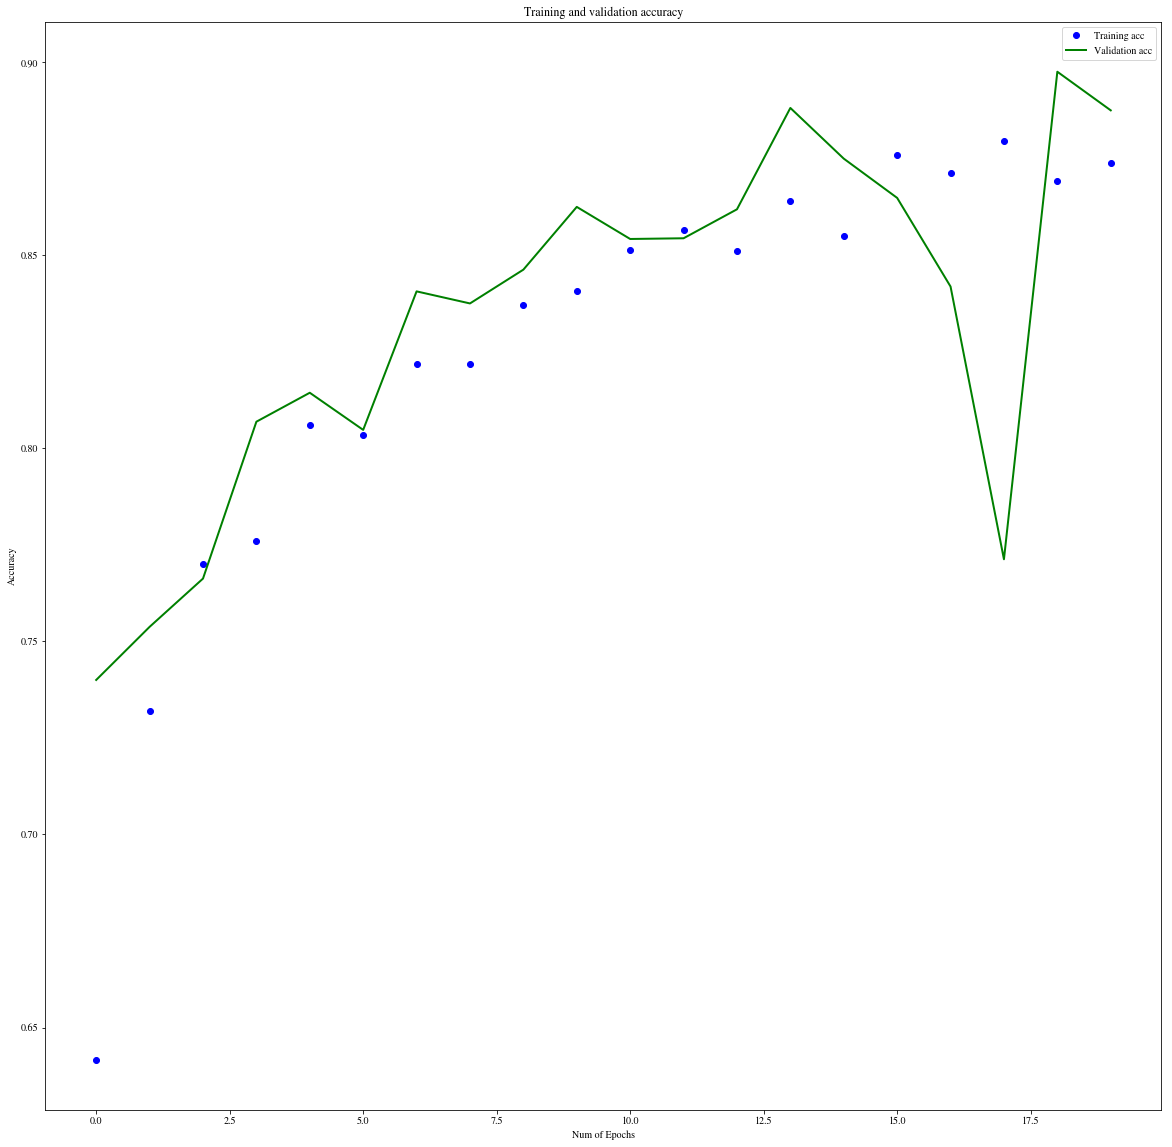

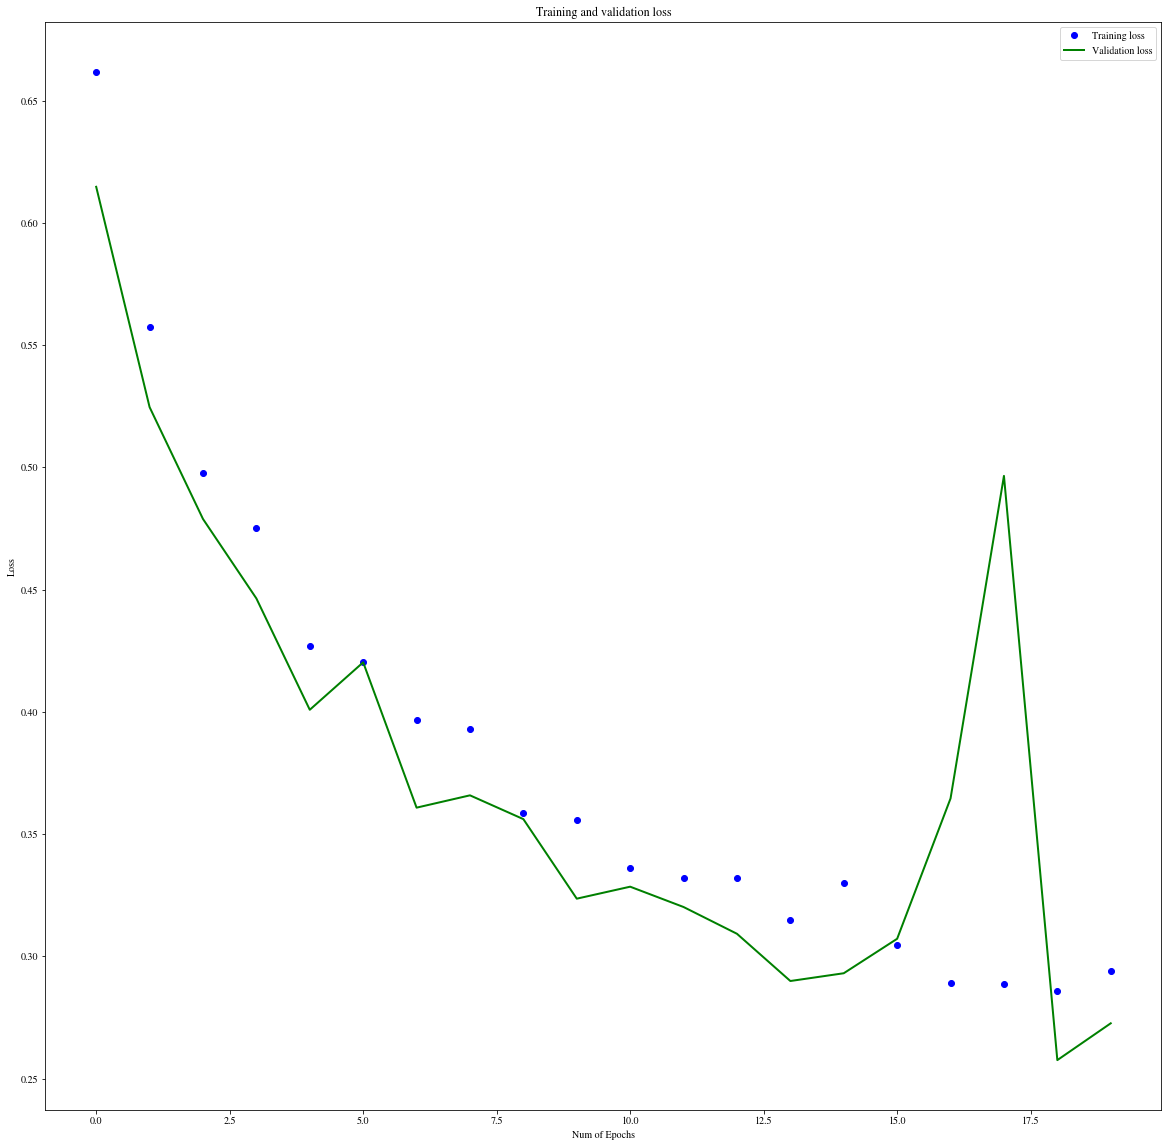


test Optimizer: RMSprop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                131088    
_________________________________________________________________
fc2 (Dense)                  (None, 1)             

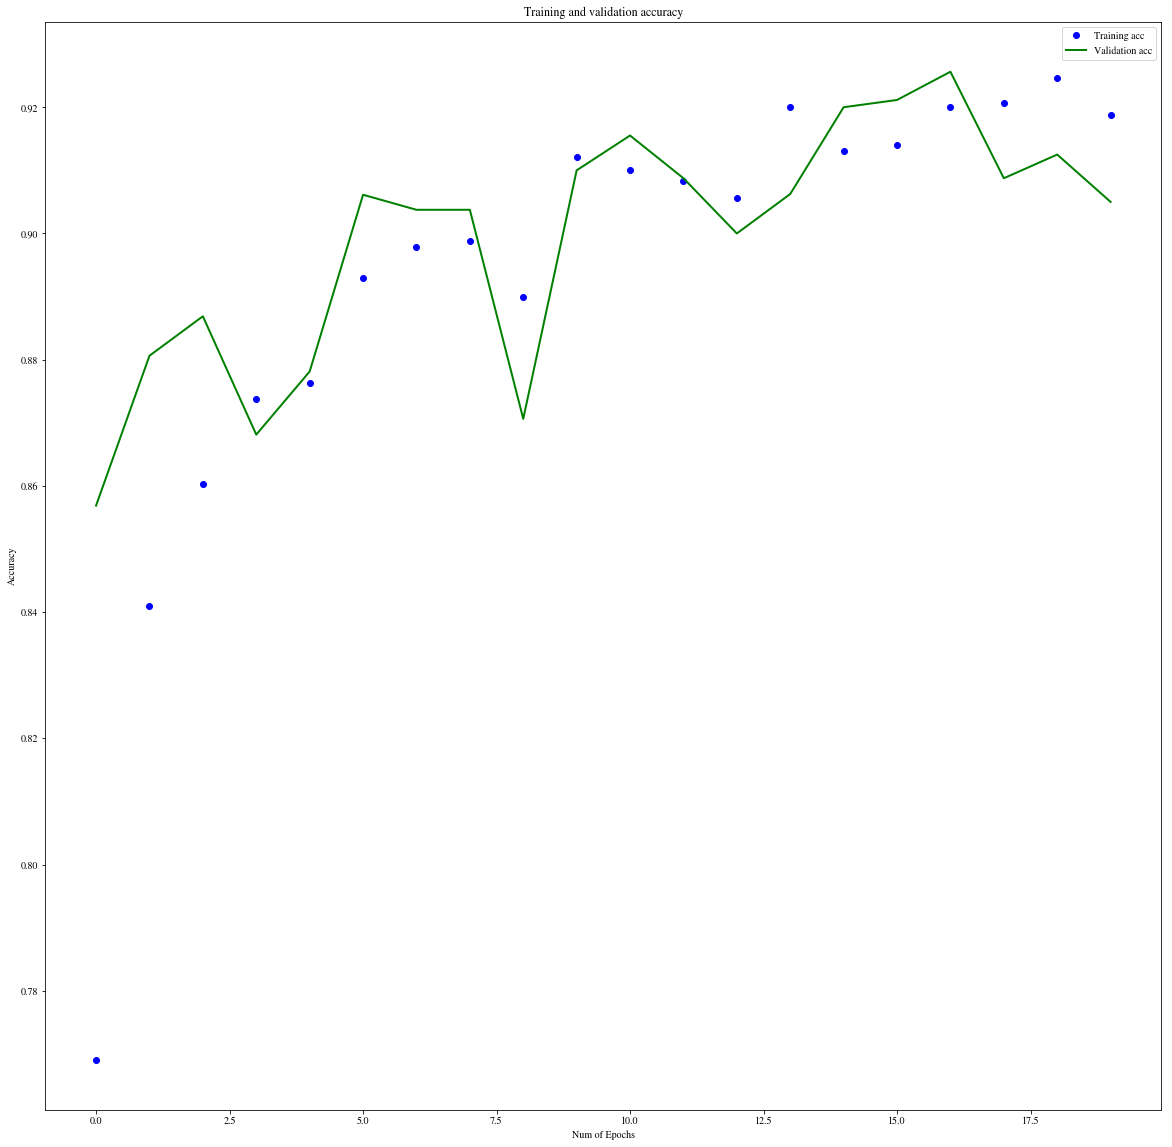

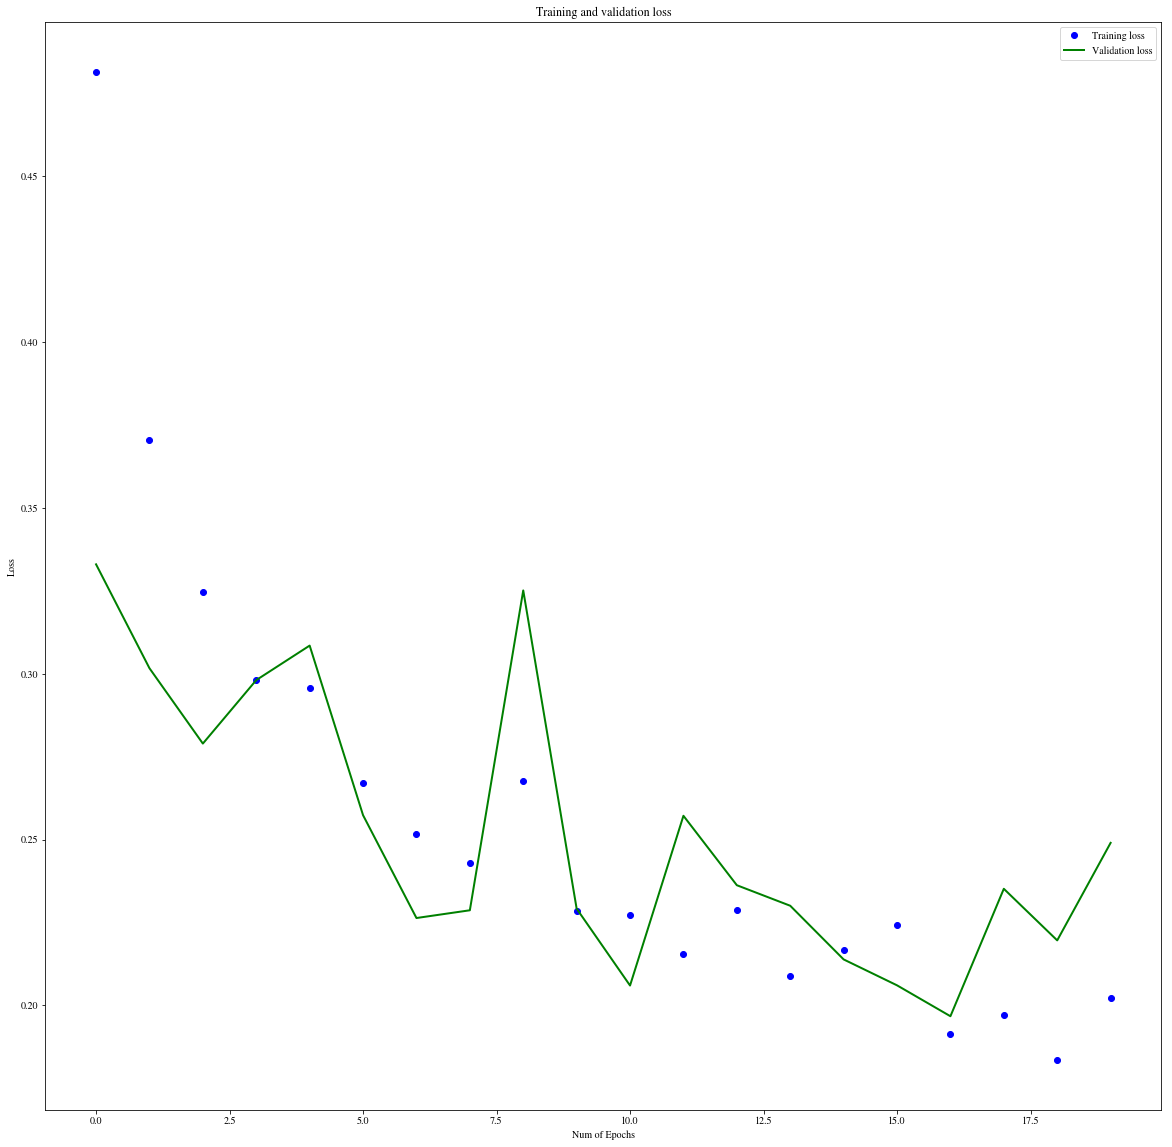


test Optimizer: Adagrad
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                131088    
_________________________________________________________________
fc2 (Dense)                  (None, 1)             

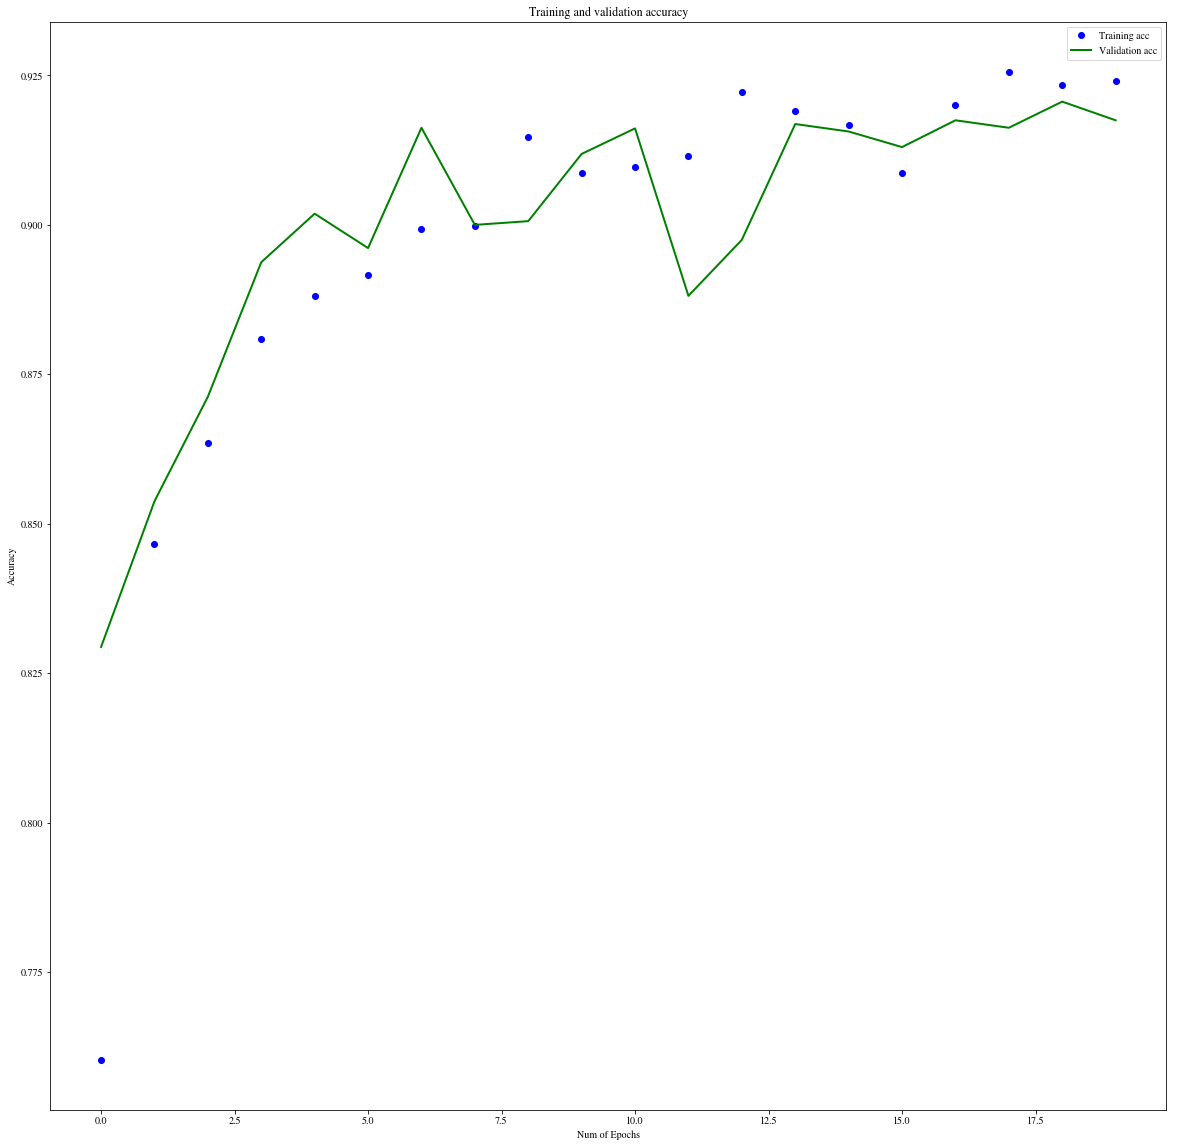

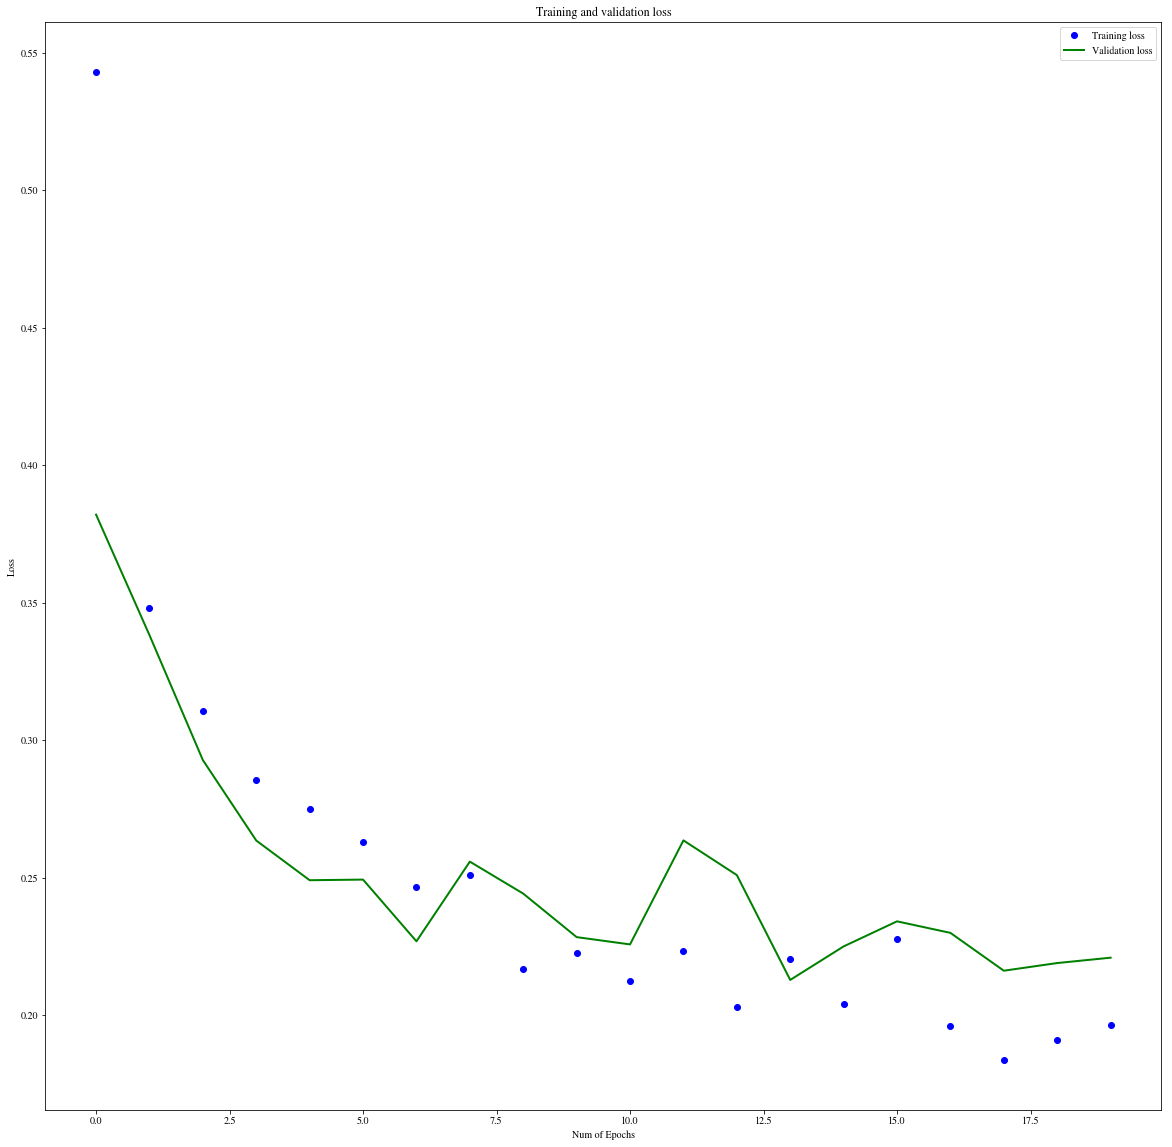


test Optimizer: Adadelta
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                131088    
_________________________________________________________________
fc2 (Dense)                  (None, 1)            

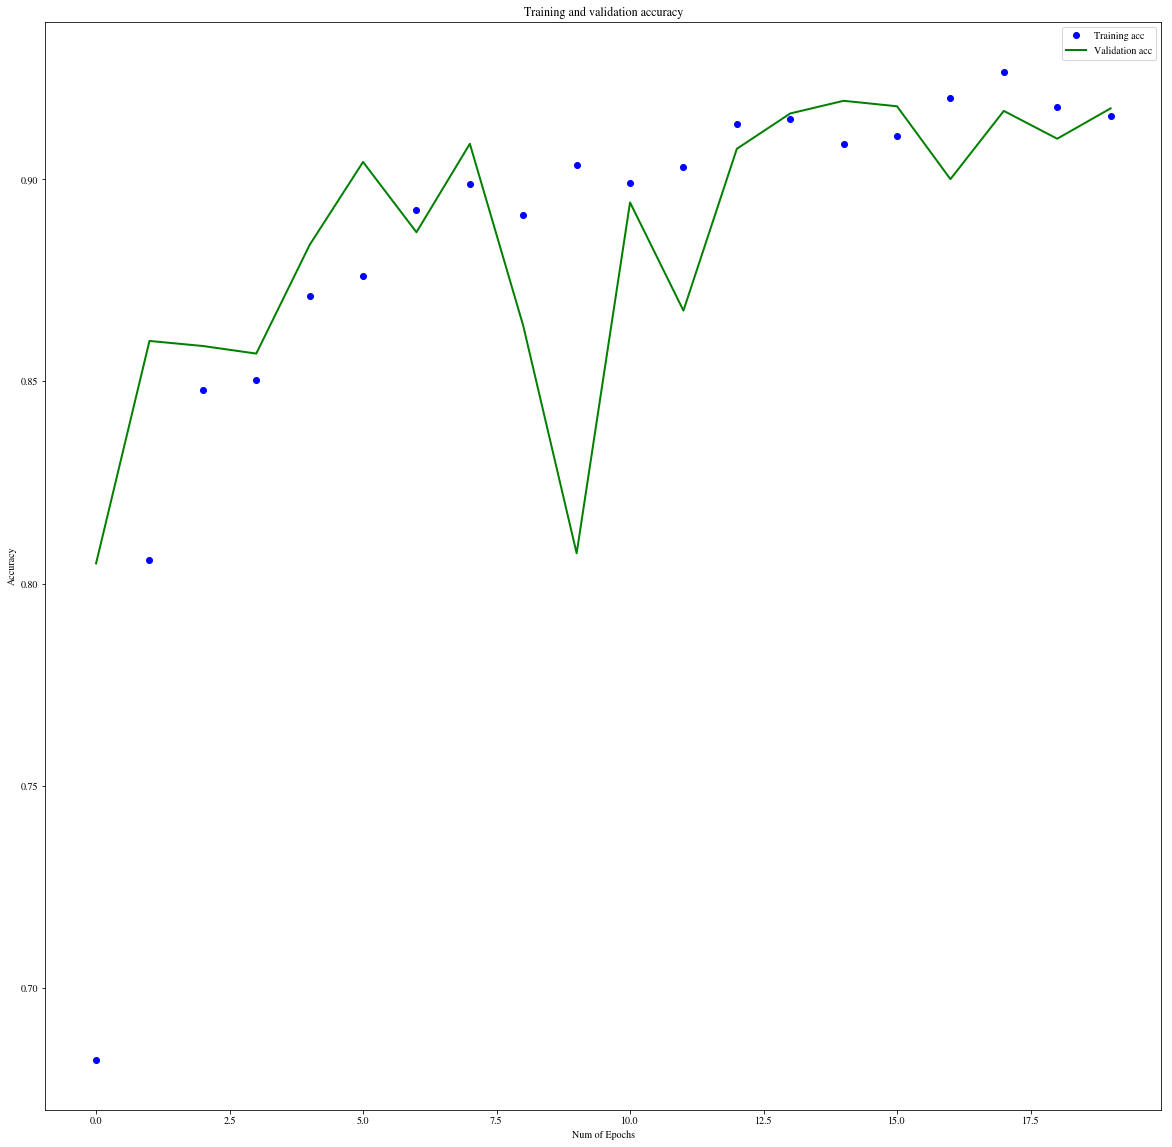

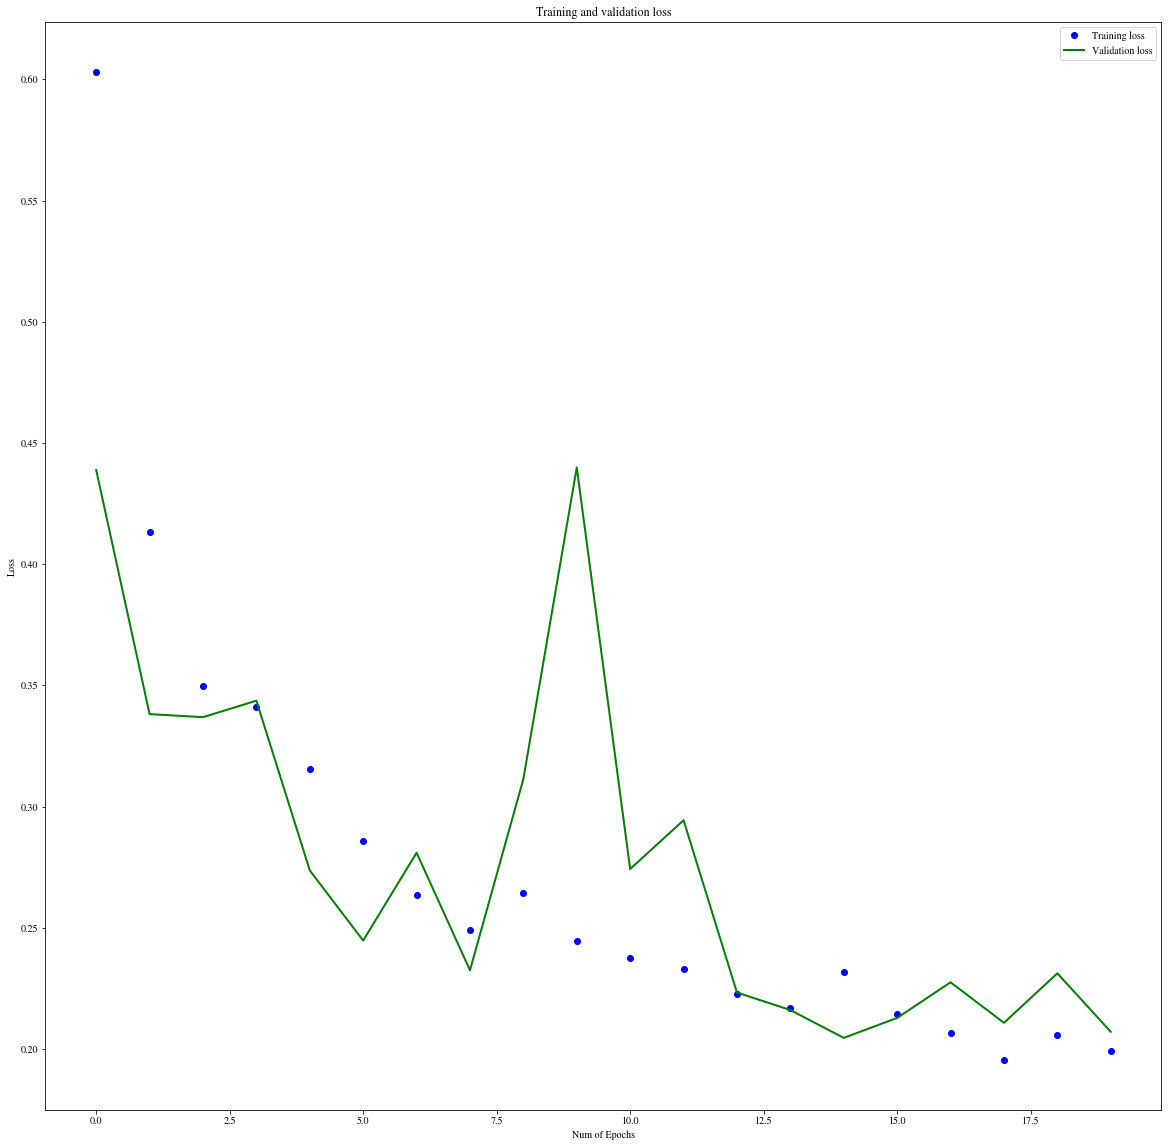


test Optimizer: Adam
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                131088    
_________________________________________________________________
fc2 (Dense)                  (None, 1)                

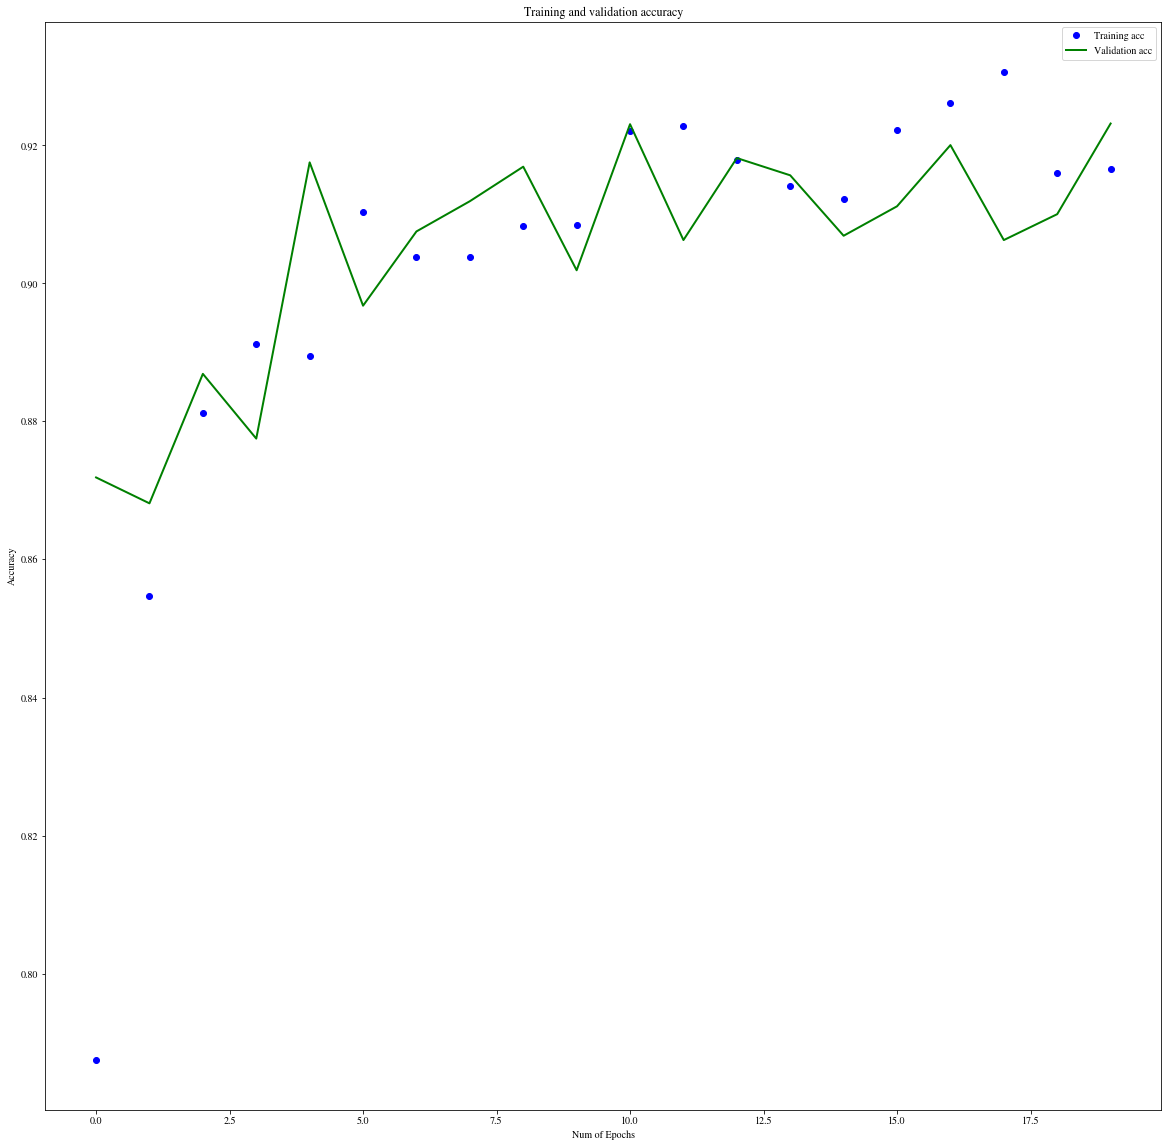

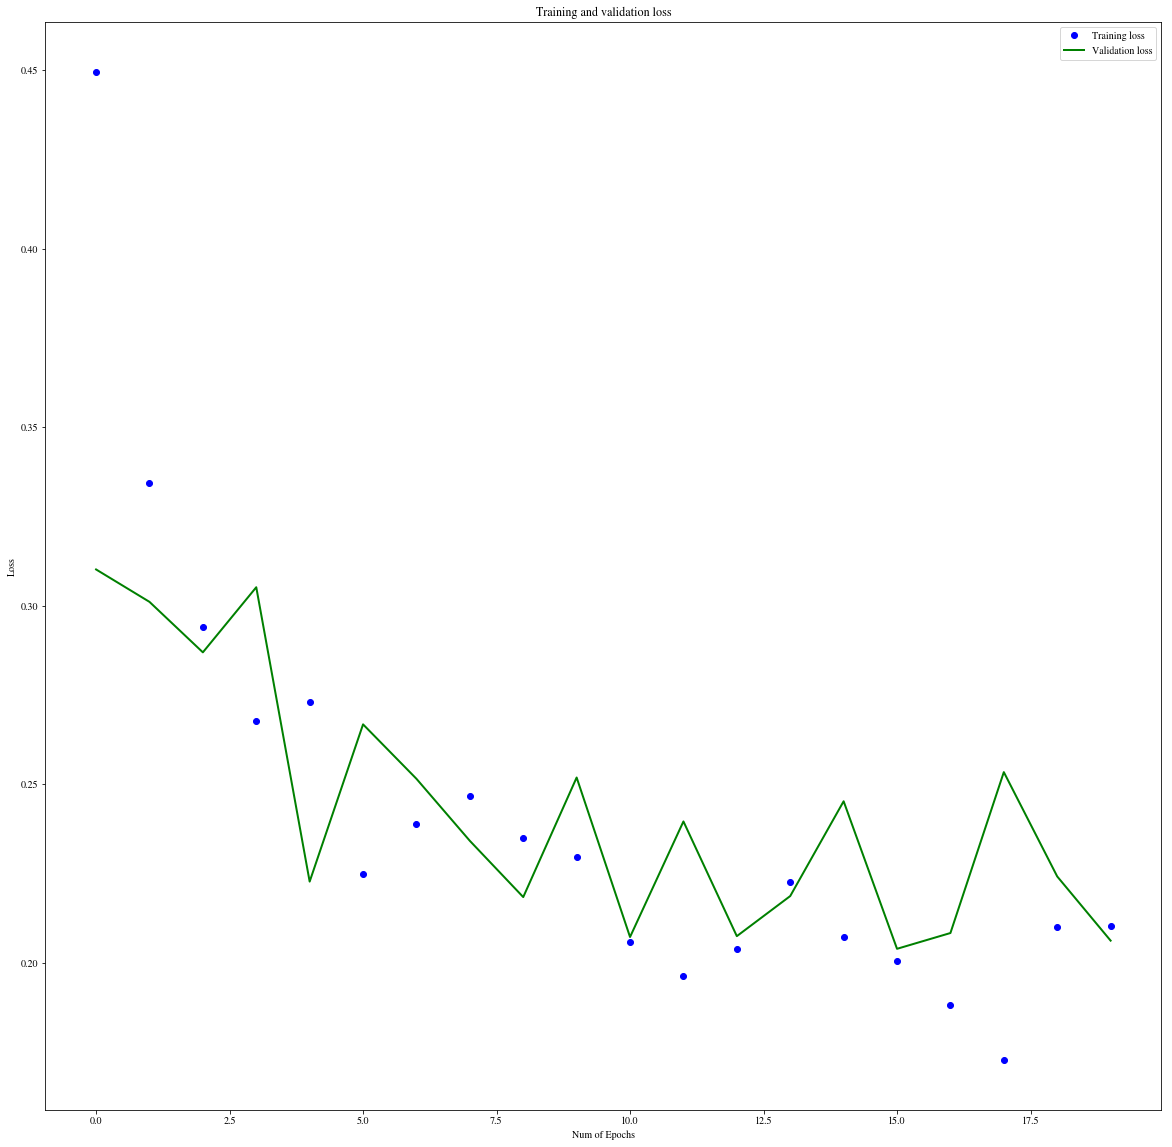

In [22]:
CNN_Optimizer_Selector('relu', 'sigmoid')

#### 2.3.2 Experiments with Different Optimal Dropouts
<span style="color:blue">
Five different rates, including 0, 0.2, 0.5, 0.8, and 1, are tried for the dropout in this part. 
</span>

In [67]:
def CNN_Dropout_Selector (activation_function_1, activation_function_2):
    
    K.clear_session()
    
    Adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    
    rate = [0.0, 0.2, 0.5, 0.8, 1.0]
    

    model = [0] * 5
    
    for j in range(0, 5):
        
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(16, kernel_initializer='glorot_uniform', activation=activation_function_1, name='fc1'))
        model[j].add(layers.Dropout(rate[j], noise_shape=None, seed=None))
        
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, name='fc2'))
        model[j].add(layers.Dropout(rate[j], noise_shape=None, seed=None))
        
        model[j].compile(loss='binary_crossentropy', optimizer = Adadelta, metrics=['accuracy'])
    
        print('\n Dropout Rate:', rate[j])
        
        # Fit the model
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()


 Dropout Rate: 0.0
Epoch 1/20
100/100 [==============================] - 5s 48ms/step - loss: 0.5429 - acc: 0.7294 - val_loss: 0.3949 - val_acc: 0.8294
Epoch 2/20
100/100 [==============================] - 5s 47ms/step - loss: 0.4066 - acc: 0.8153 - val_loss: 0.3262 - val_acc: 0.8650
Epoch 3/20
100/100 [==============================] - 5s 46ms/step - loss: 0.3534 - acc: 0.8447 - val_loss: 0.3070 - val_acc: 0.8706
Epoch 4/20
100/100 [==============================] - 4s 39ms/step - loss: 0.3123 - acc: 0.8675 - val_loss: 0.2631 - val_acc: 0.8912
Epoch 5/20
100/100 [==============================] - 4s 40ms/step - loss: 0.2917 - acc: 0.8747 - val_loss: 0.3060 - val_acc: 0.8544
Epoch 6/20
100/100 [==============================] - 4s 43ms/step - loss: 0.2621 - acc: 0.8993 - val_loss: 0.2305 - val_acc: 0.9168
Epoch 7/20
100/100 [==============================] - 4s 43ms/step - loss: 0.2503 - acc: 0.8956 - val_loss: 0.2403 - val_acc: 0.9025
Epoch 8/20
100/100 [=============================

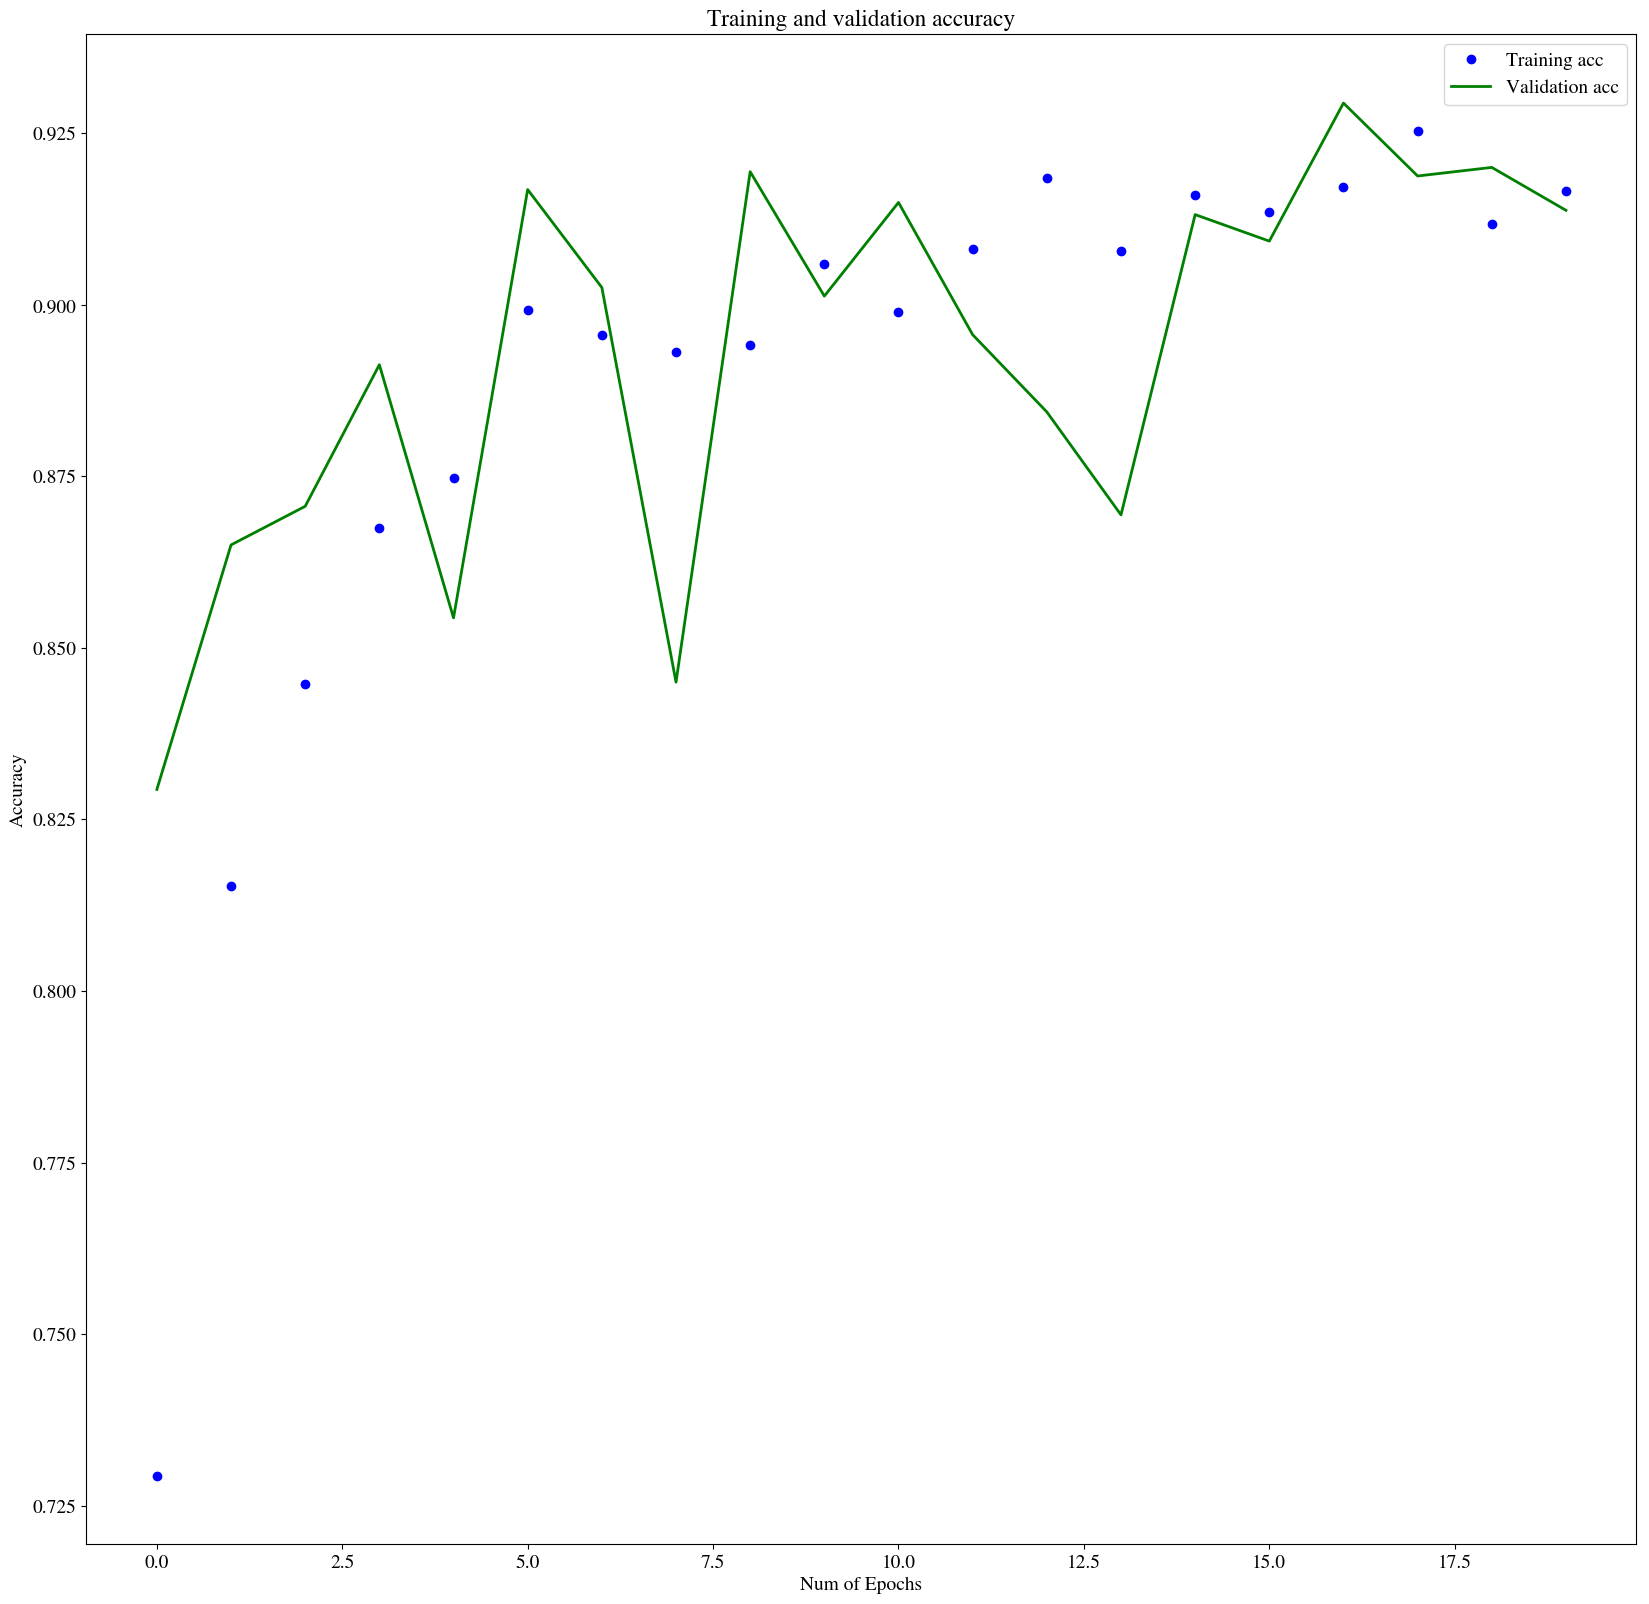

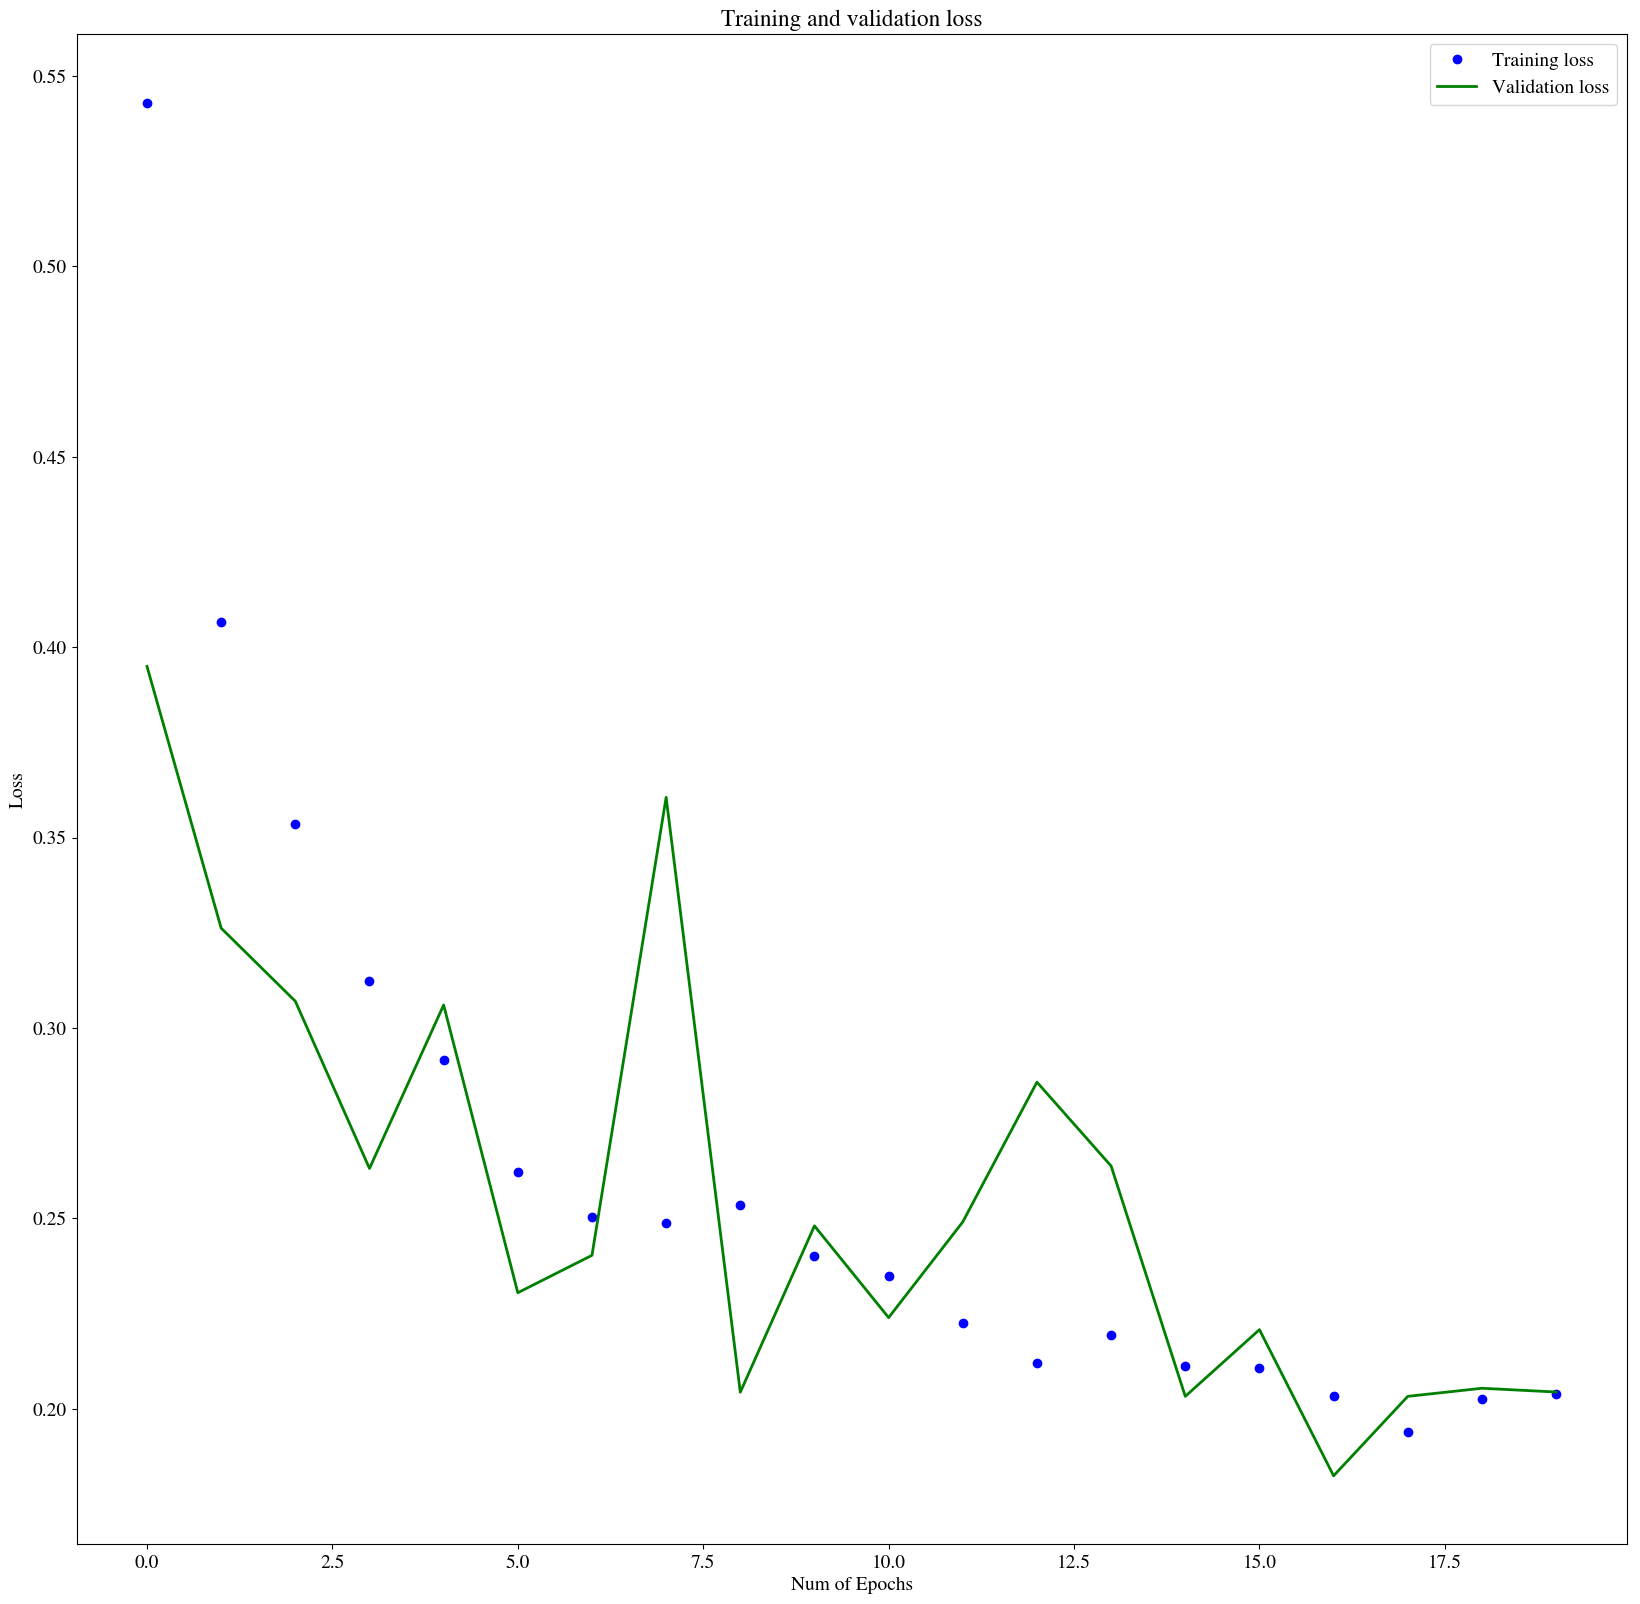


 Dropout Rate: 0.2
Epoch 1/20
100/100 [==============================] - 6s 56ms/step - loss: 2.1532 - acc: 0.6819 - val_loss: 0.5289 - val_acc: 0.6794
Epoch 2/20
100/100 [==============================] - 6s 56ms/step - loss: 2.0695 - acc: 0.7503 - val_loss: 0.3470 - val_acc: 0.8700
Epoch 3/20
100/100 [==============================] - 5s 52ms/step - loss: 2.0292 - acc: 0.7712 - val_loss: 0.3517 - val_acc: 0.8681
Epoch 4/20
100/100 [==============================] - 5s 49ms/step - loss: 1.9228 - acc: 0.7738 - val_loss: 0.4077 - val_acc: 0.8300
Epoch 5/20
100/100 [==============================] - 5s 53ms/step - loss: 2.0115 - acc: 0.7778 - val_loss: 0.3391 - val_acc: 0.8756
Epoch 6/20
100/100 [==============================] - 6s 56ms/step - loss: 1.8902 - acc: 0.8060 - val_loss: 0.2908 - val_acc: 0.8836
Epoch 7/20
100/100 [==============================] - 5s 48ms/step - loss: 1.8363 - acc: 0.7960 - val_loss: 0.3217 - val_acc: 0.8862
Epoch 8/20
100/100 [=============================

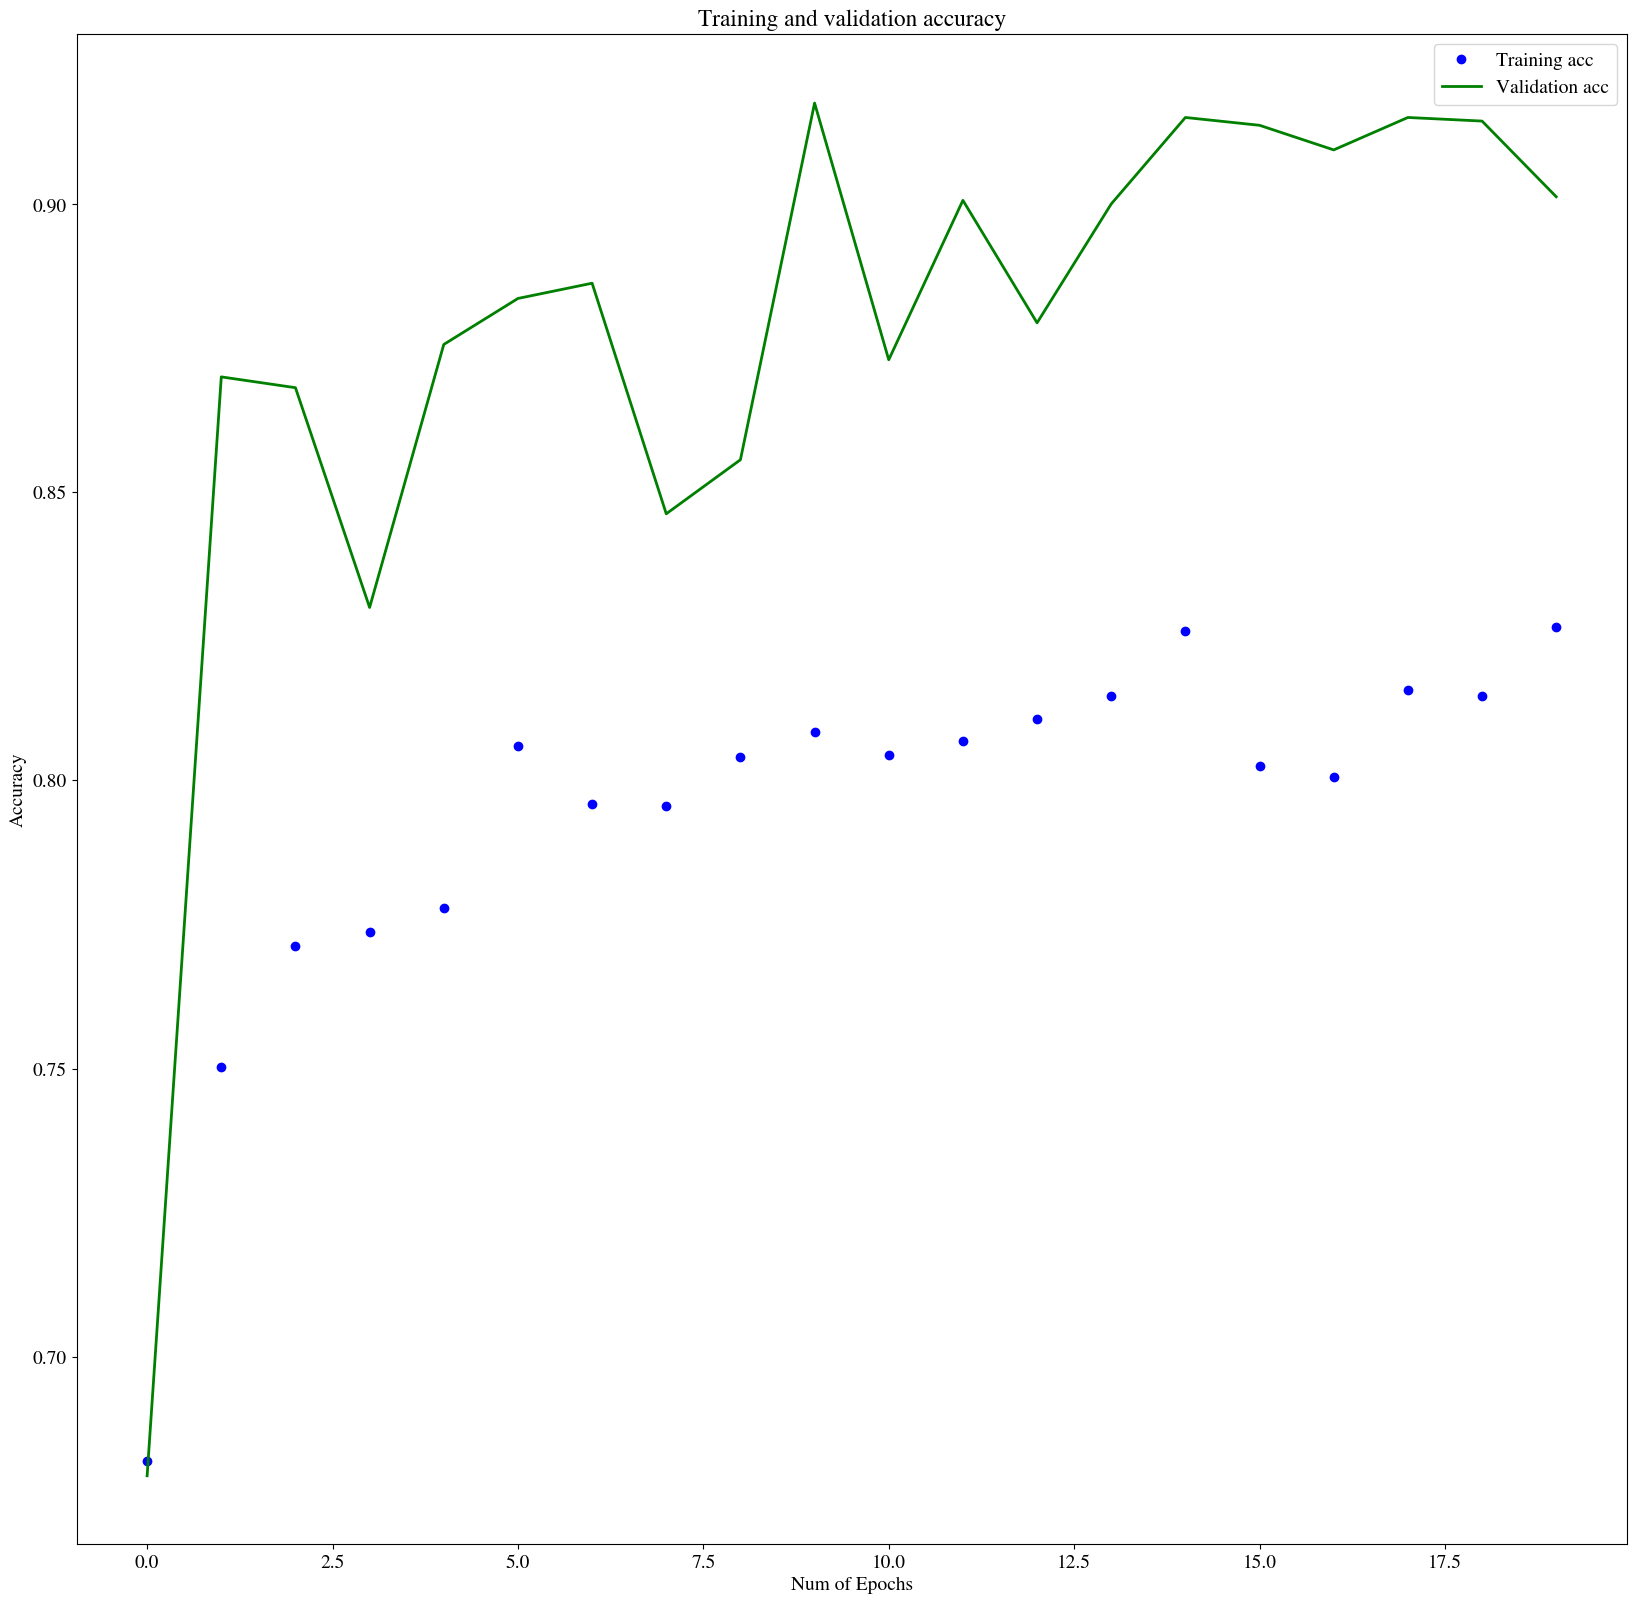

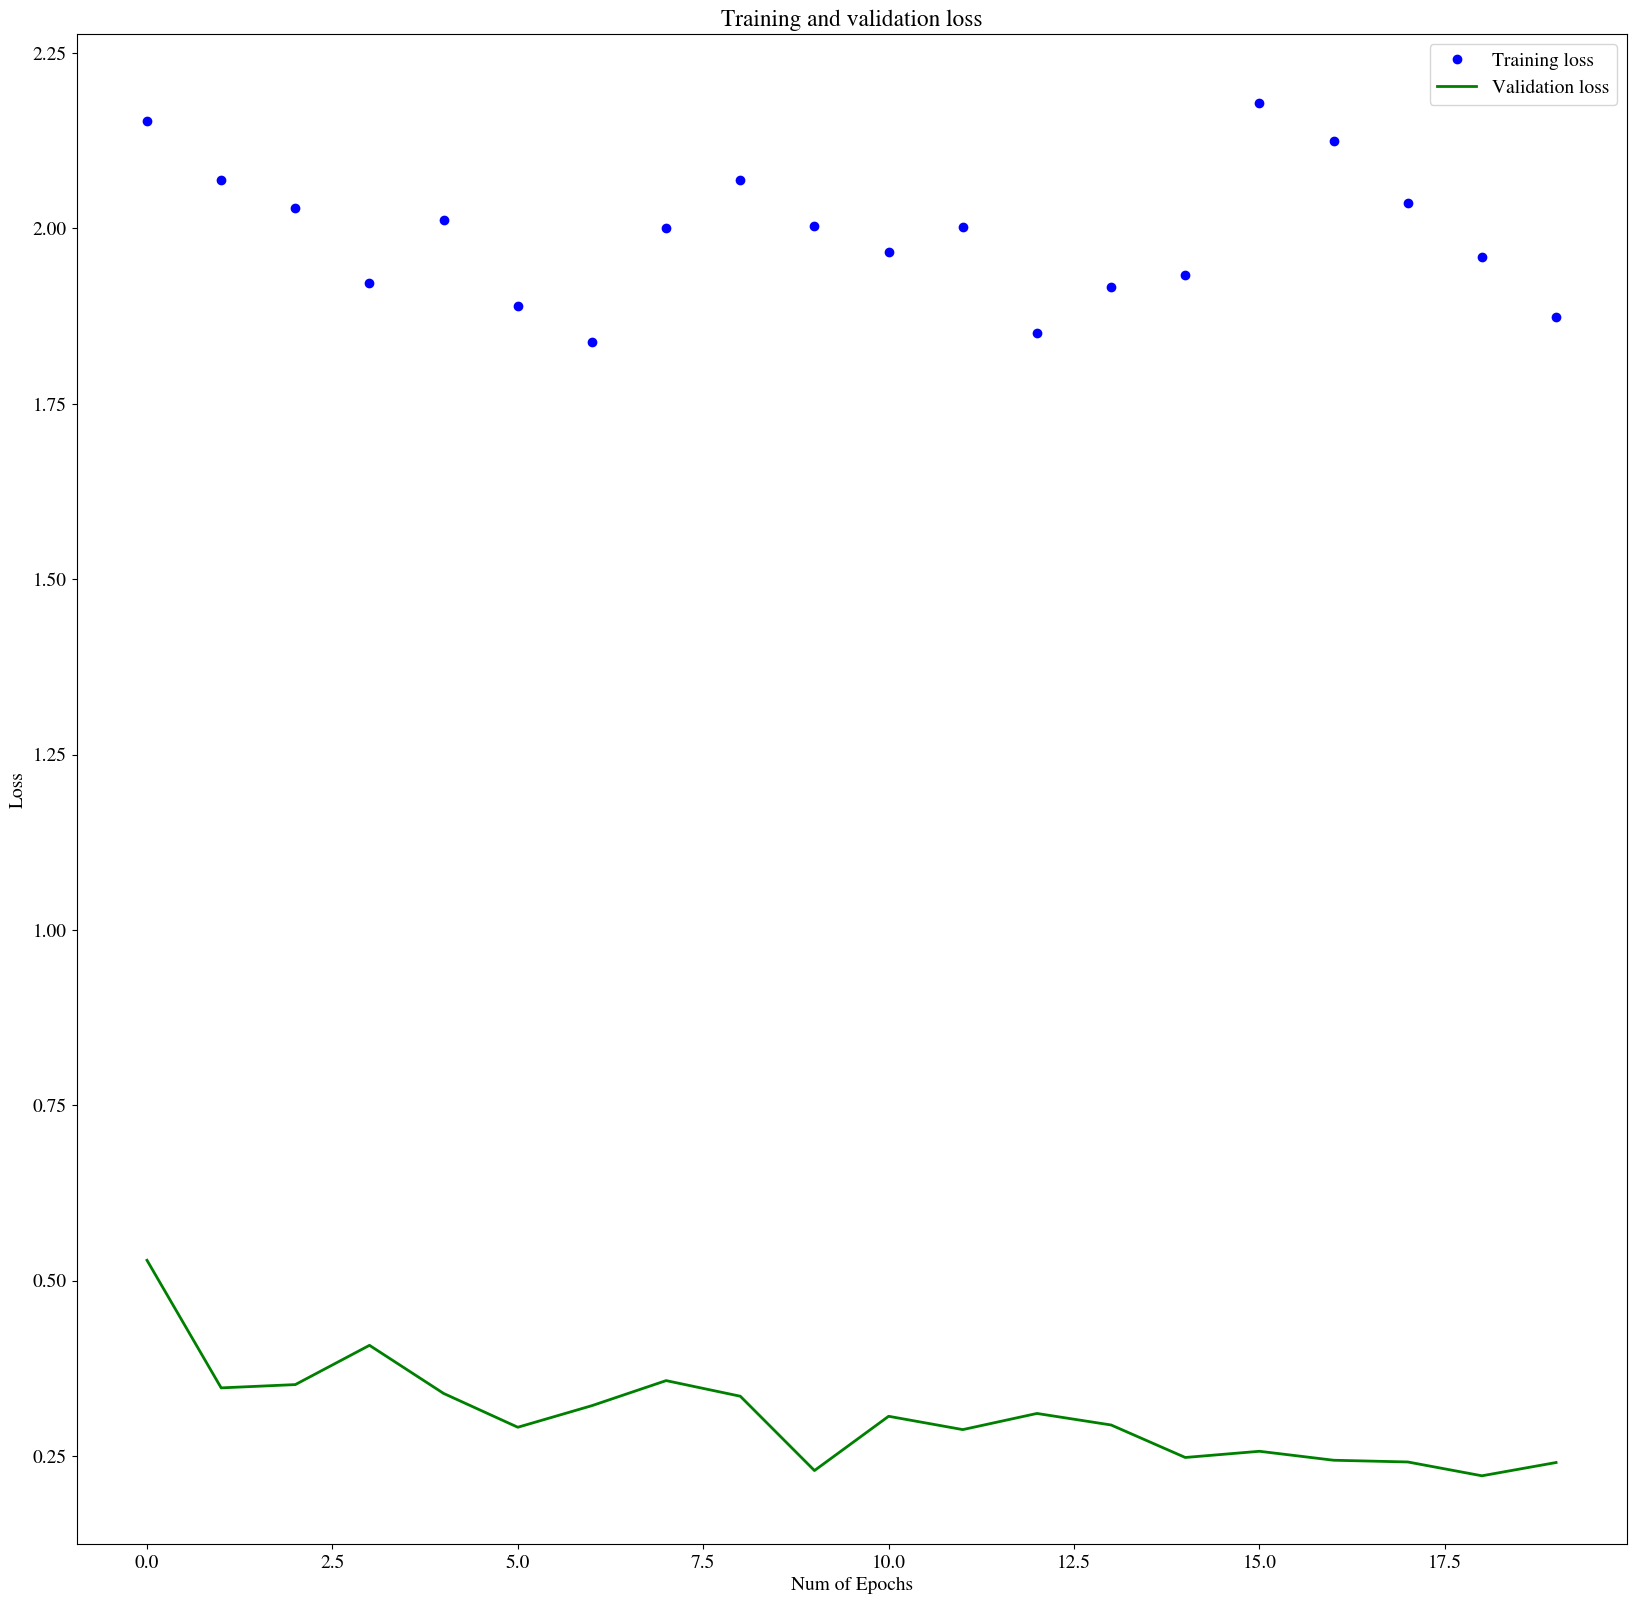


 Dropout Rate: 0.5
Epoch 1/20
100/100 [==============================] - 5s 54ms/step - loss: 4.6138 - acc: 0.5778 - val_loss: 0.7736 - val_acc: 0.4813
Epoch 2/20
100/100 [==============================] - 4s 44ms/step - loss: 4.7414 - acc: 0.5981 - val_loss: 0.6791 - val_acc: 0.4925
Epoch 3/20
100/100 [==============================] - 4s 44ms/step - loss: 4.5734 - acc: 0.6266 - val_loss: 0.5831 - val_acc: 0.5931
Epoch 4/20
100/100 [==============================] - 5s 45ms/step - loss: 4.5598 - acc: 0.6309 - val_loss: 0.5661 - val_acc: 0.6000
Epoch 5/20
100/100 [==============================] - 5s 49ms/step - loss: 4.4344 - acc: 0.6478 - val_loss: 0.5486 - val_acc: 0.5631
Epoch 6/20
100/100 [==============================] - 6s 55ms/step - loss: 4.5777 - acc: 0.6584 - val_loss: 0.7094 - val_acc: 0.5375
Epoch 7/20
100/100 [==============================] - 5s 46ms/step - loss: 4.4753 - acc: 0.6575 - val_loss: 0.6715 - val_acc: 0.5281
Epoch 8/20
100/100 [=============================

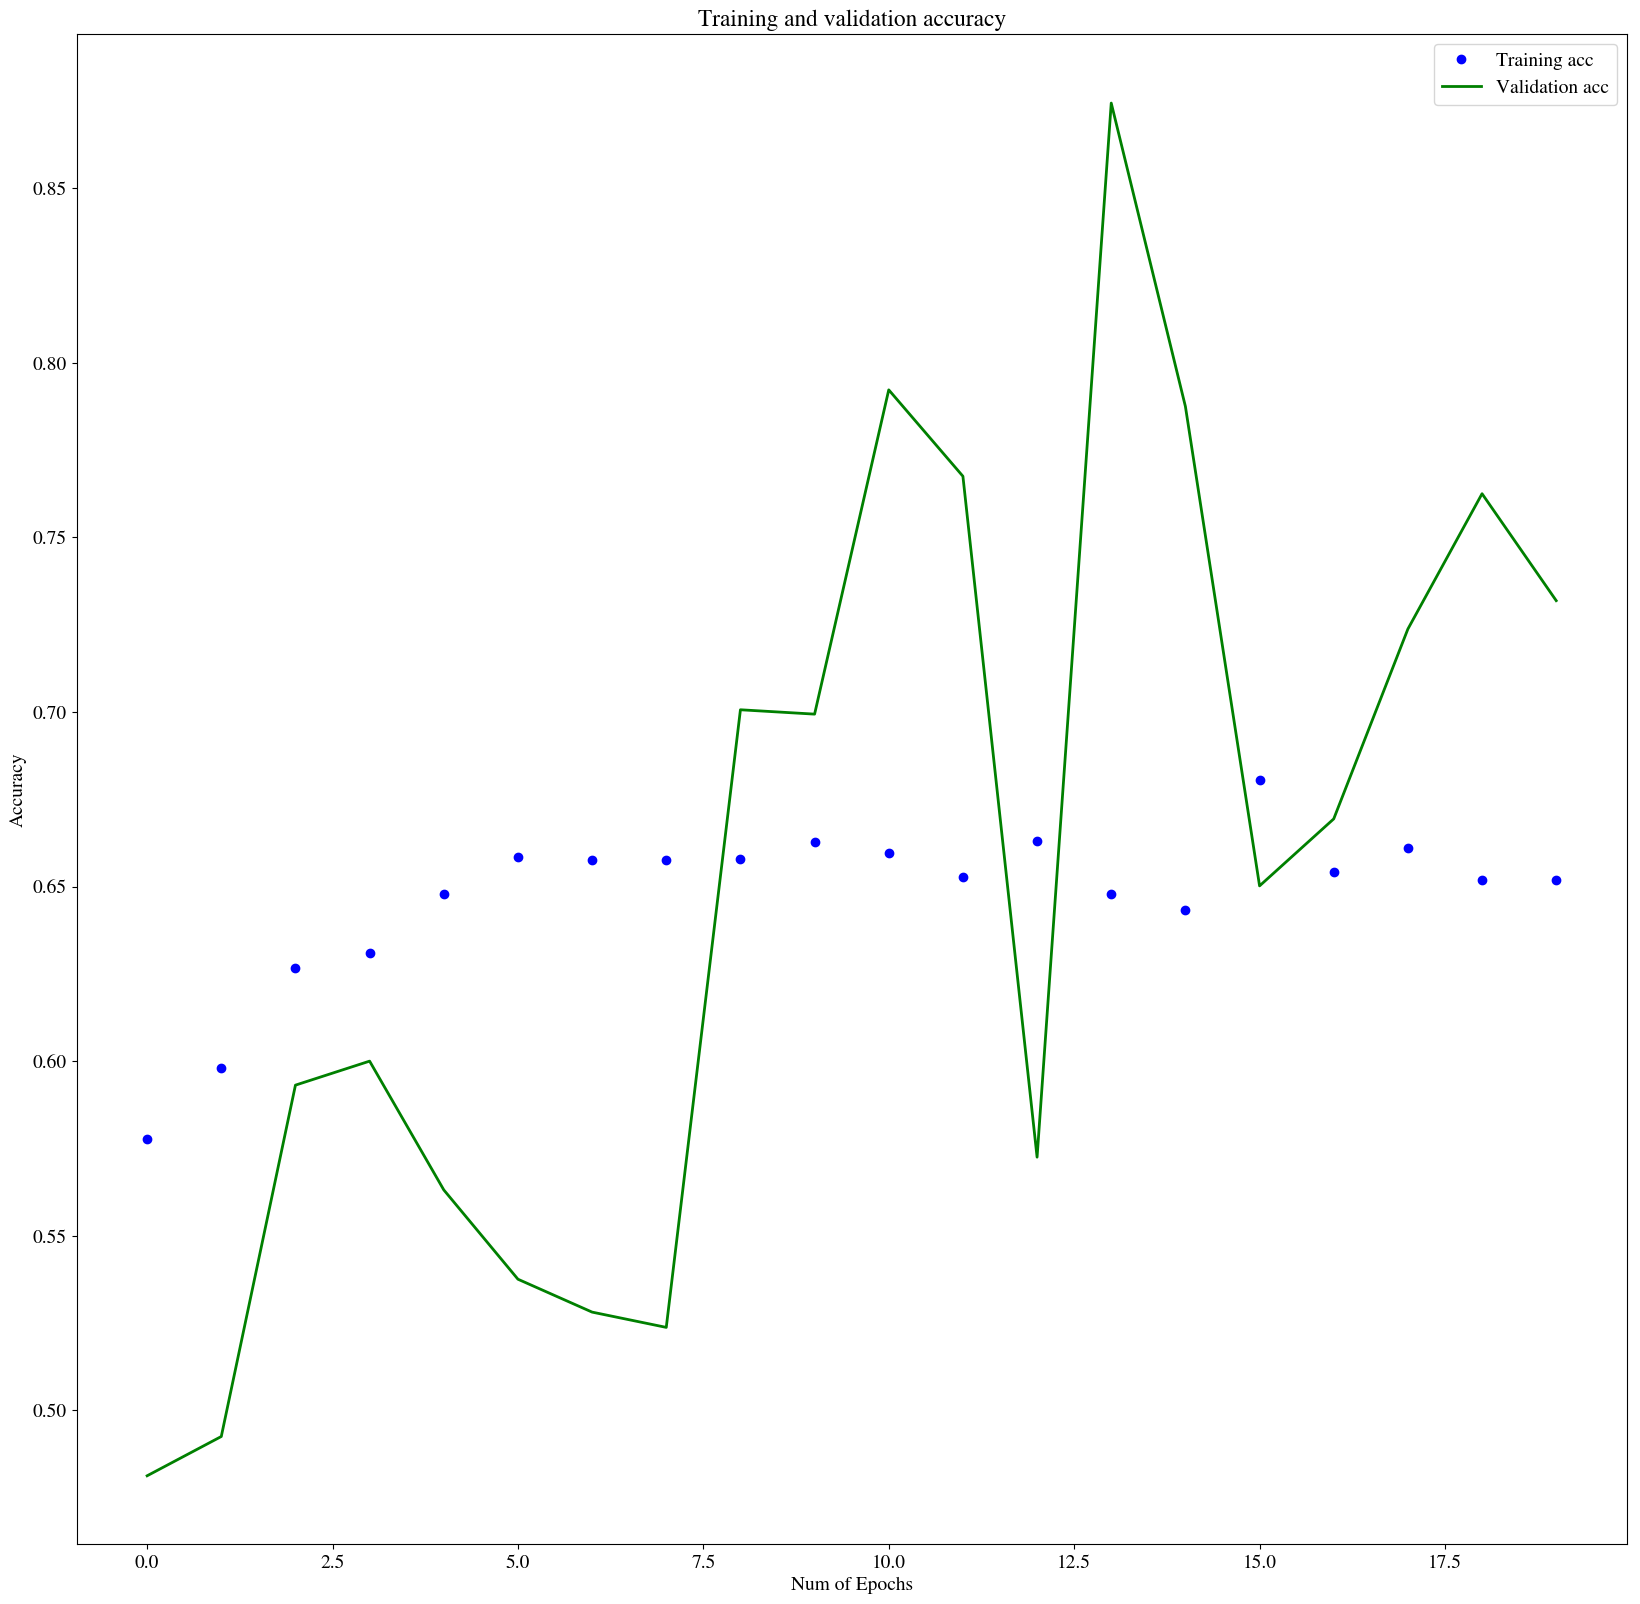

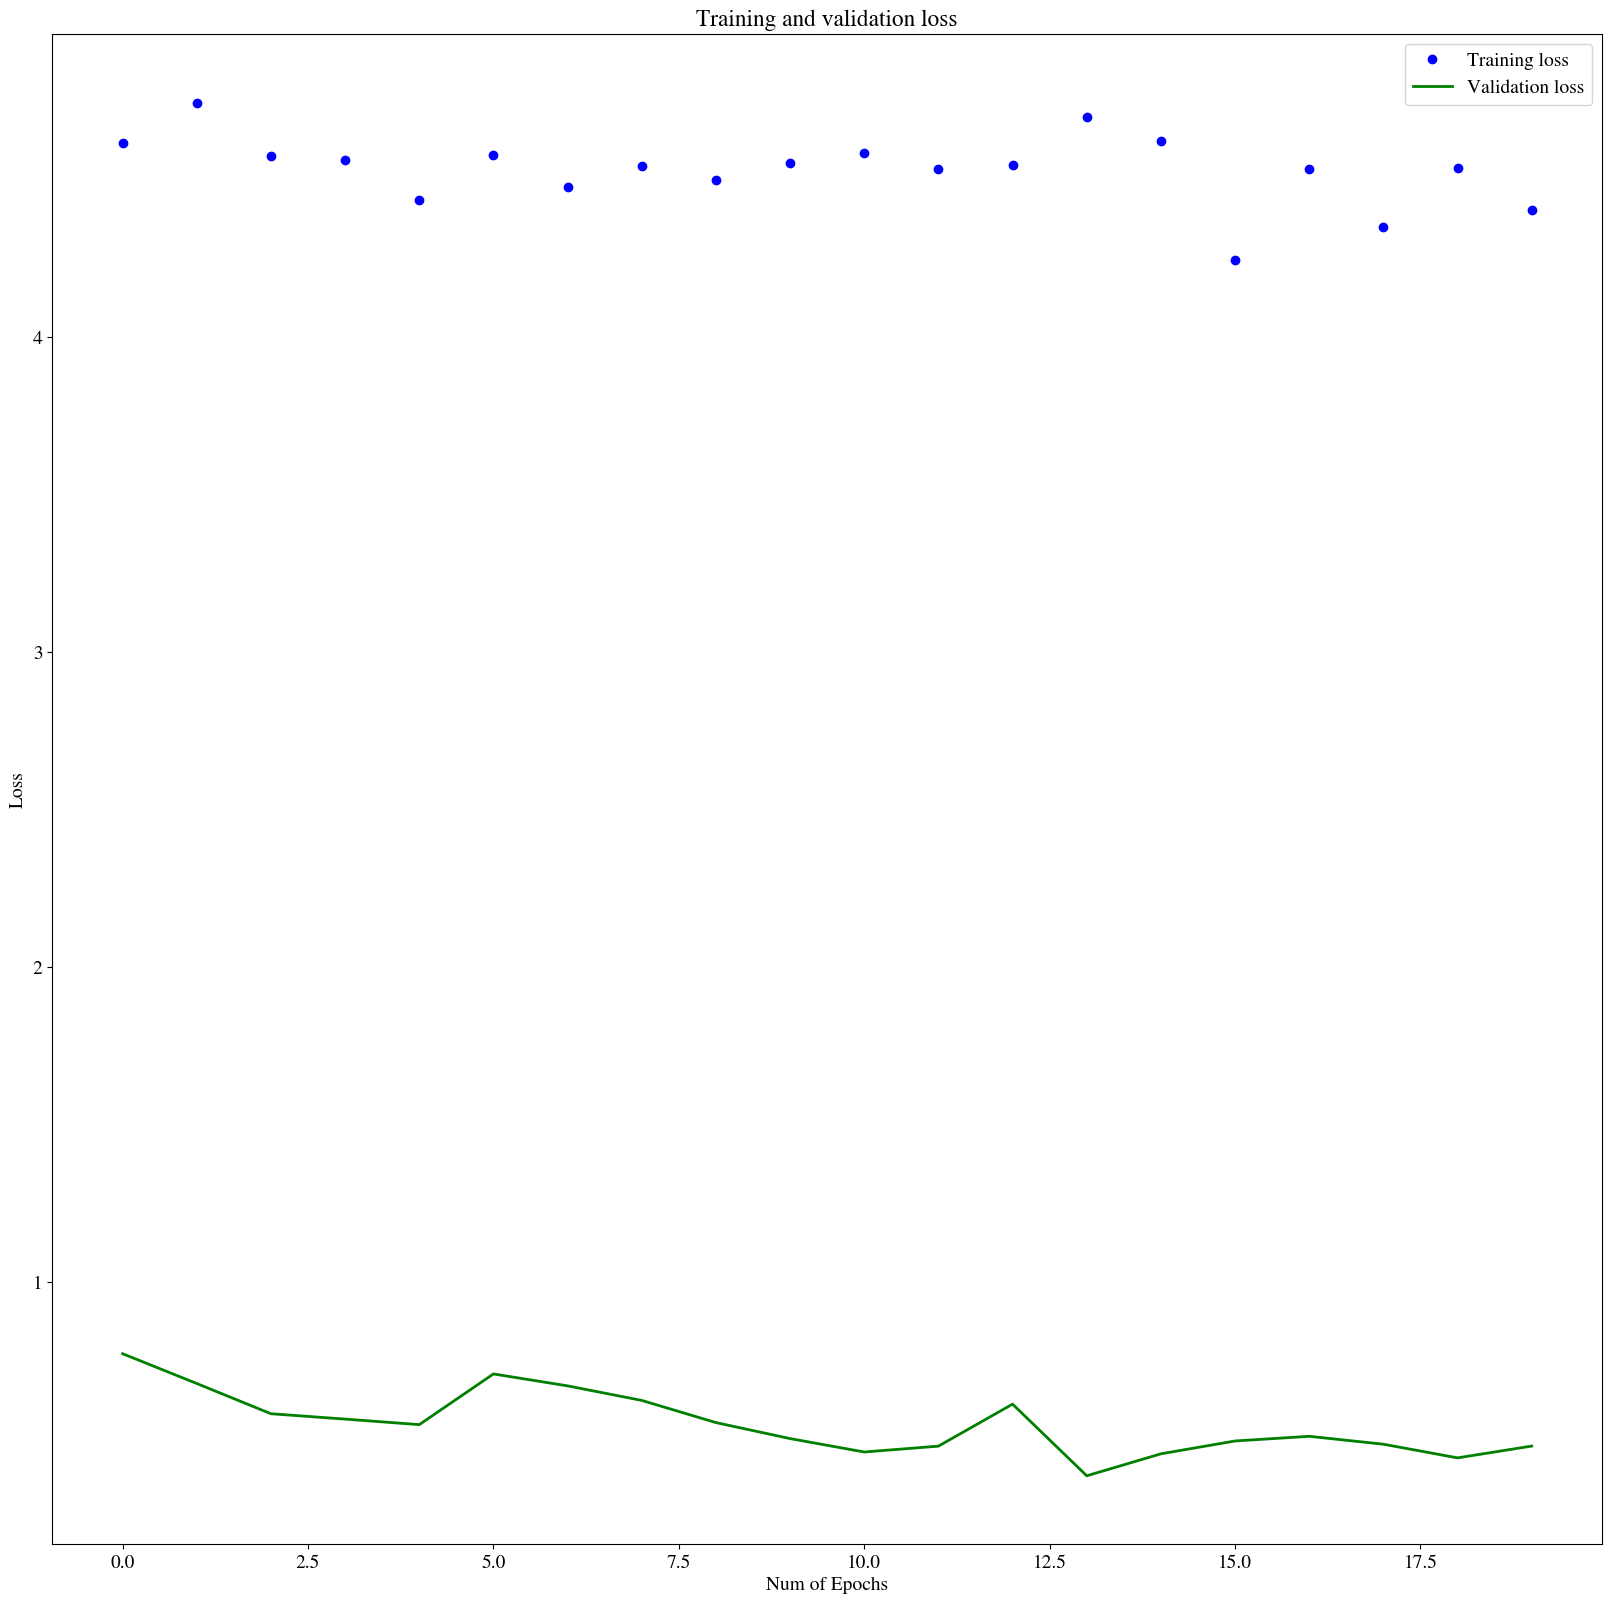


 Dropout Rate: 0.8
Epoch 1/20
100/100 [==============================] - 5s 54ms/step - loss: 8.1344 - acc: 0.3879 - val_loss: 0.6956 - val_acc: 0.4938
Epoch 2/20
100/100 [==============================] - 5s 51ms/step - loss: 8.3897 - acc: 0.3694 - val_loss: 0.6957 - val_acc: 0.4775
Epoch 3/20
100/100 [==============================] - 5s 49ms/step - loss: 8.3453 - acc: 0.3669 - val_loss: 0.6969 - val_acc: 0.4788
Epoch 4/20
100/100 [==============================] - 5s 49ms/step - loss: 8.4397 - acc: 0.3762 - val_loss: 0.6967 - val_acc: 0.4781
Epoch 5/20
100/100 [==============================] - 5s 50ms/step - loss: 8.5066 - acc: 0.3703 - val_loss: 0.6971 - val_acc: 0.4644
Epoch 6/20
100/100 [==============================] - 5s 53ms/step - loss: 8.1553 - acc: 0.3816 - val_loss: 0.6975 - val_acc: 0.4681
Epoch 7/20
100/100 [==============================] - 5s 46ms/step - loss: 8.2098 - acc: 0.3866 - val_loss: 0.6962 - val_acc: 0.4869
Epoch 8/20
100/100 [=============================

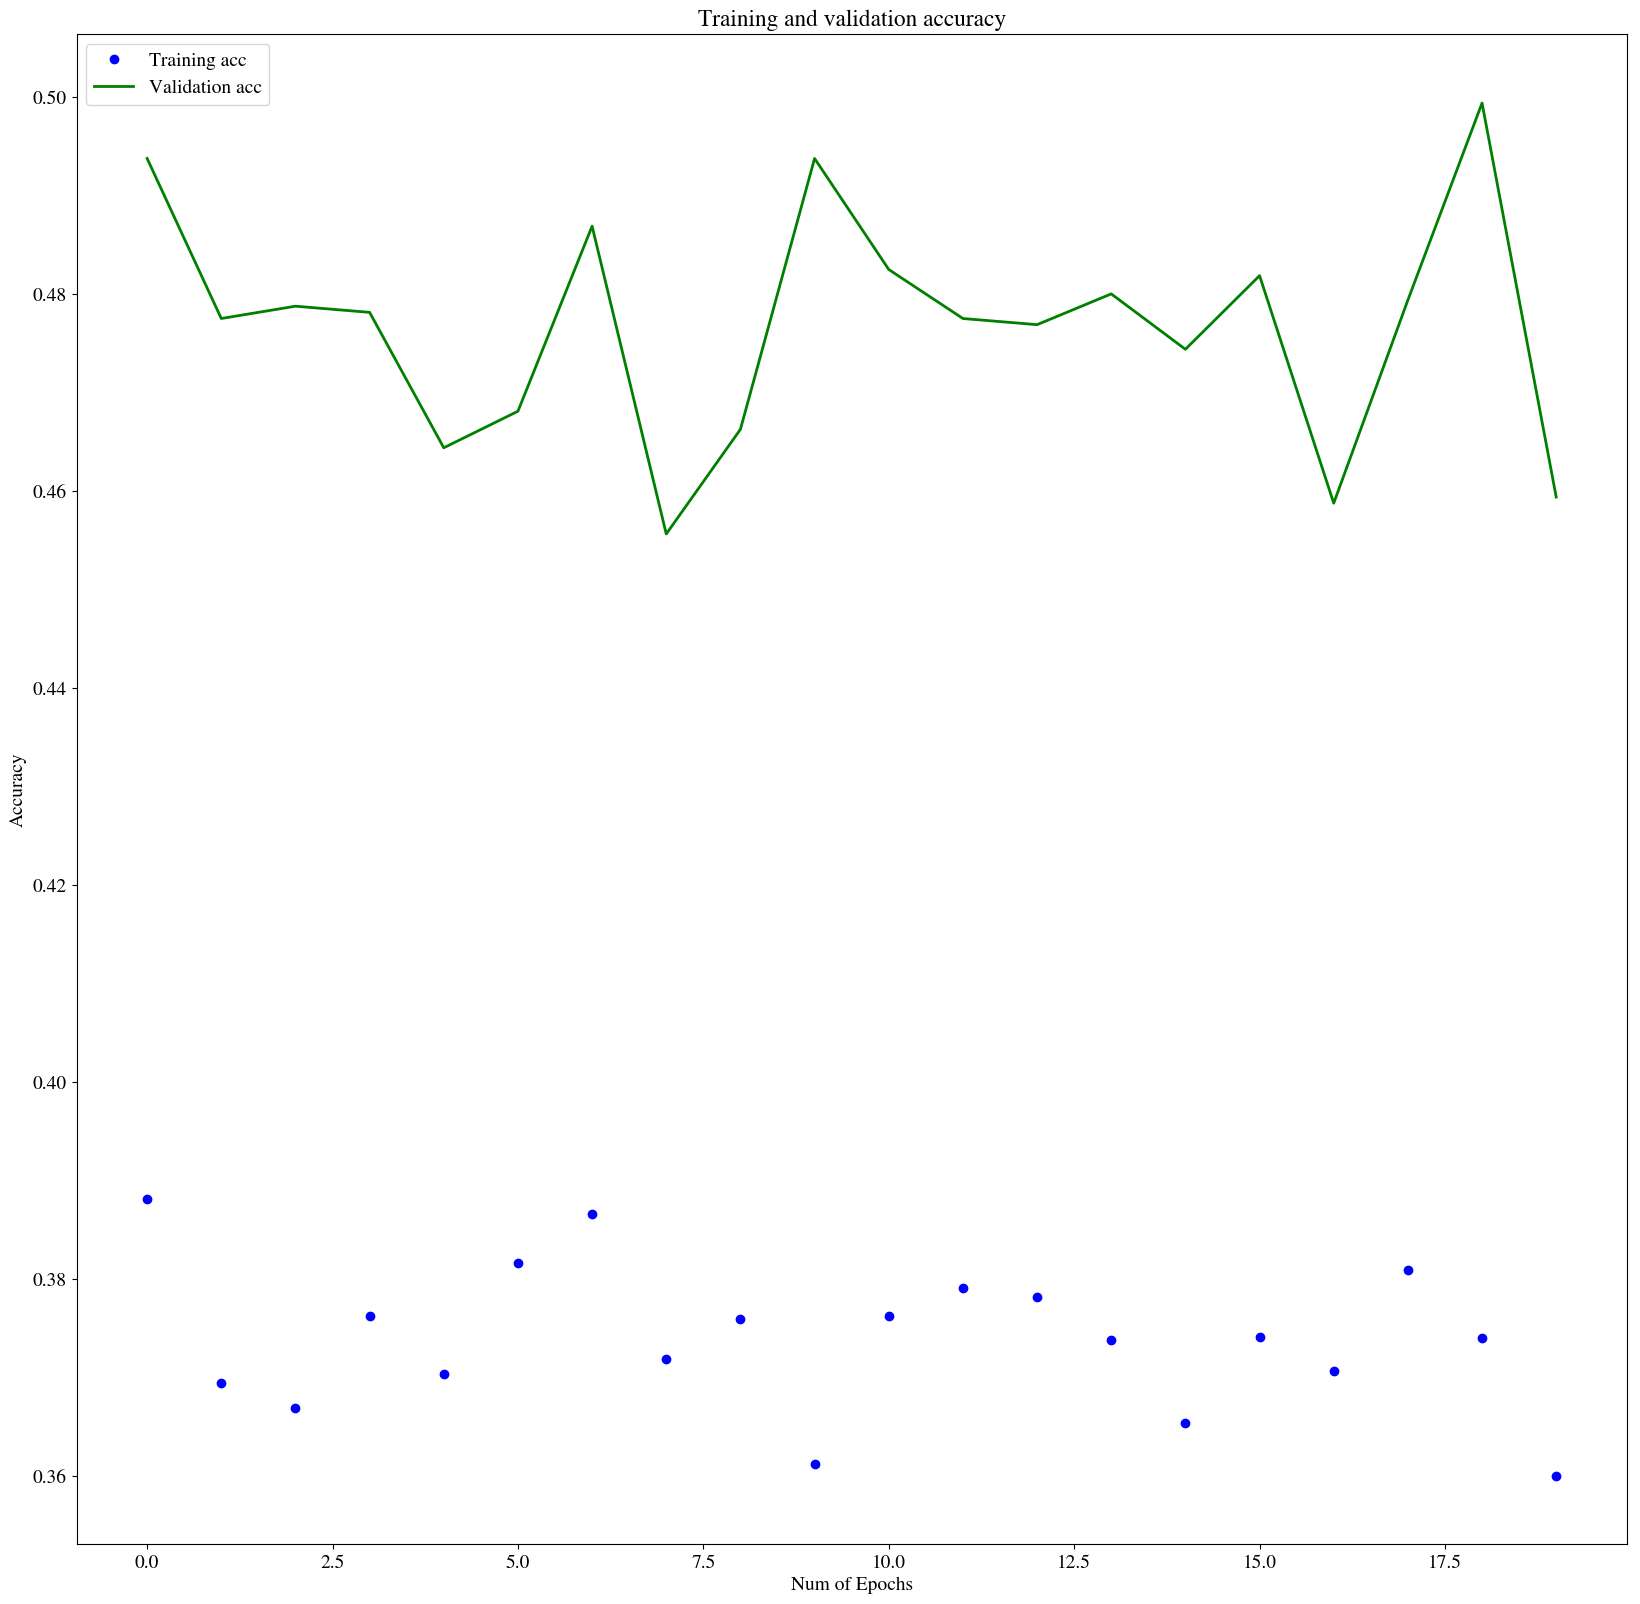

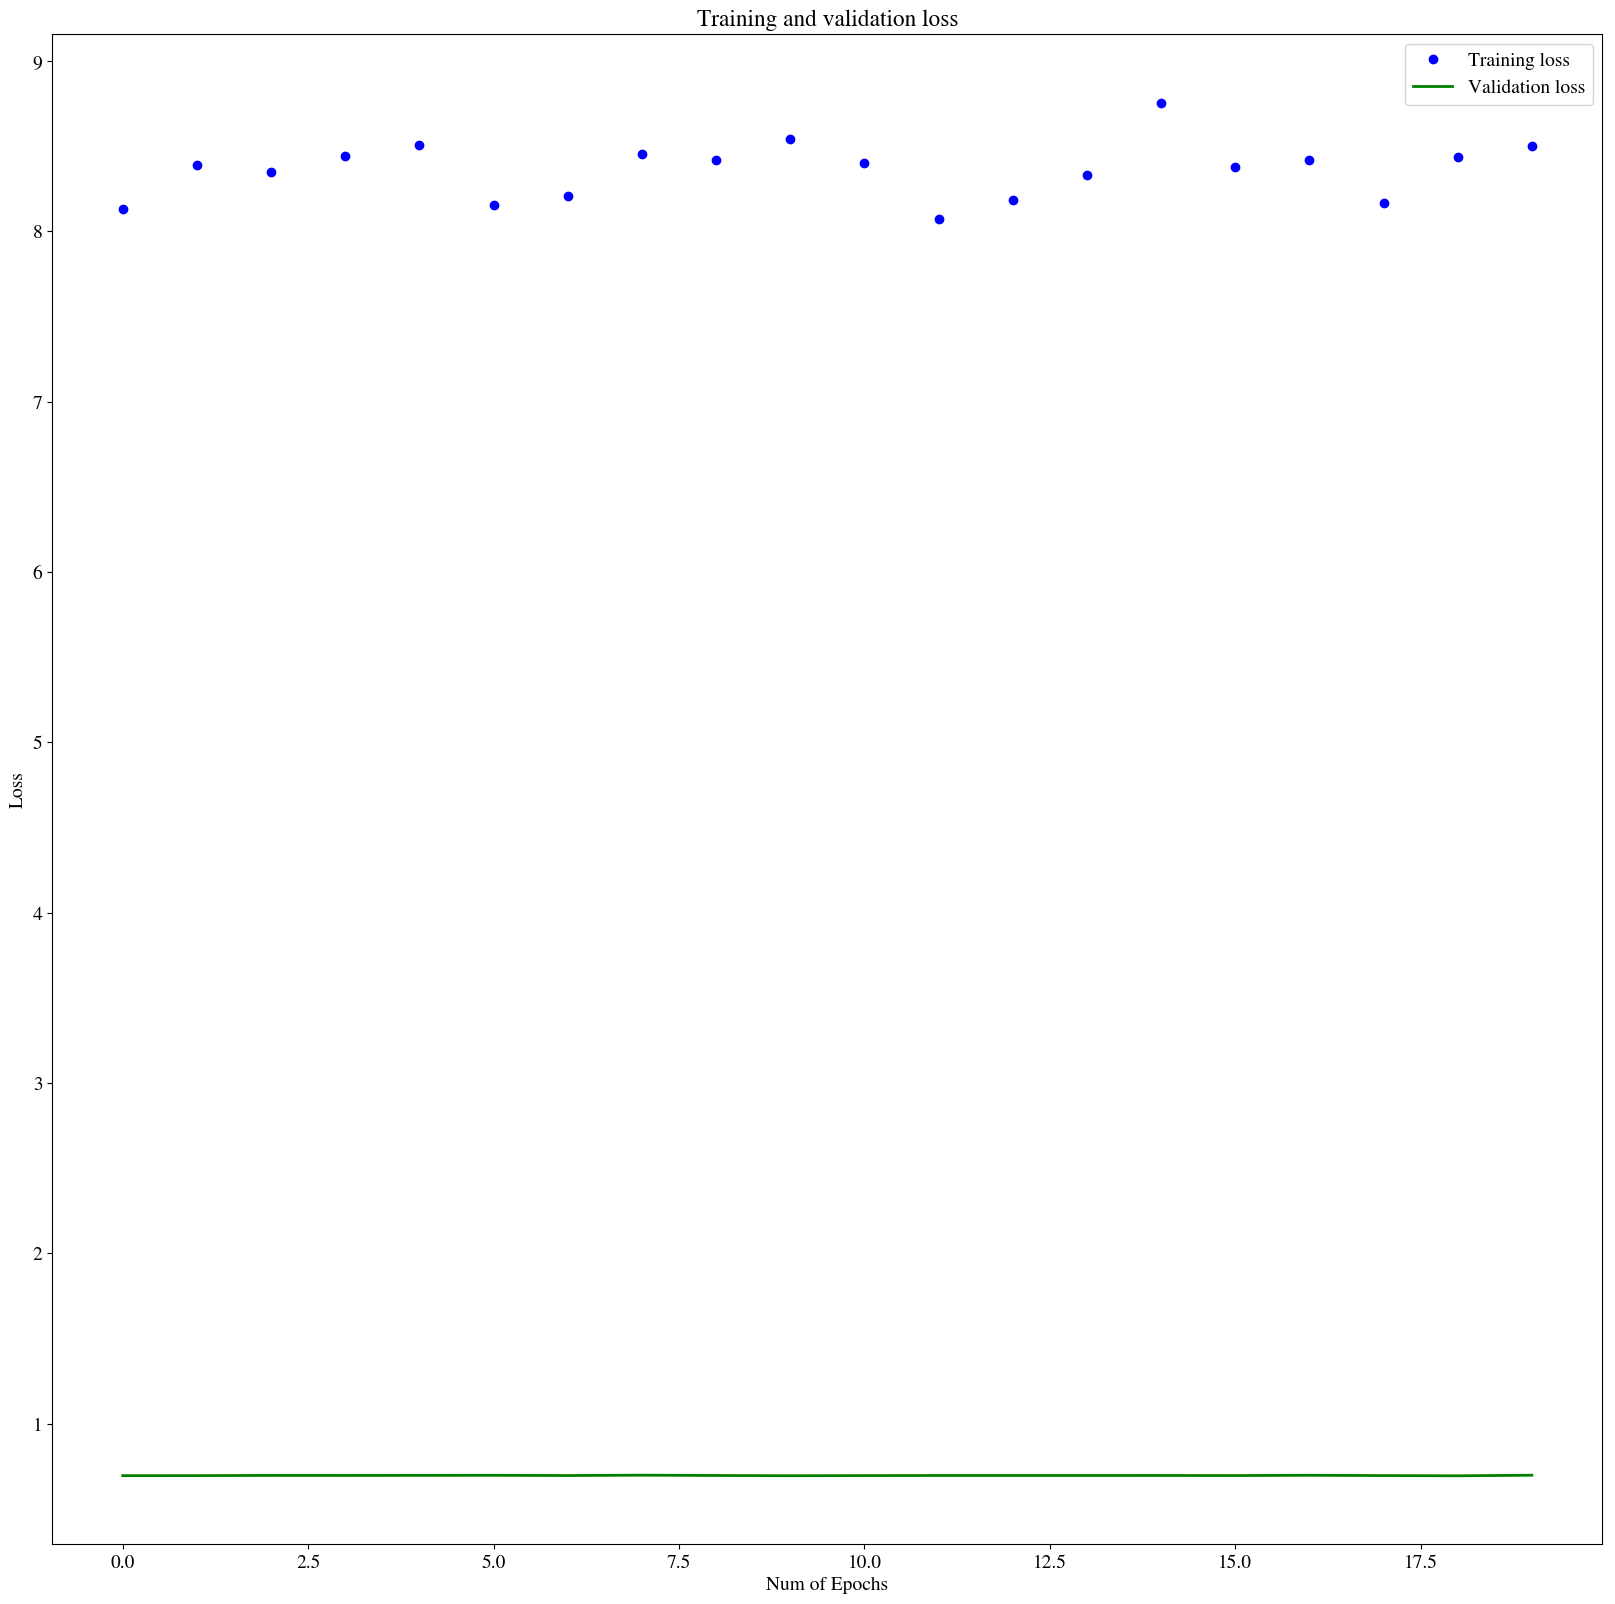


 Dropout Rate: 1.0
Epoch 1/20
100/100 [==============================] - 6s 57ms/step - loss: 0.5349 - acc: 0.7342 - val_loss: 0.3603 - val_acc: 0.8419
Epoch 2/20
100/100 [==============================] - 5s 52ms/step - loss: 0.3749 - acc: 0.8356 - val_loss: 0.4190 - val_acc: 0.8113
Epoch 3/20
100/100 [==============================] - 5s 54ms/step - loss: 0.3408 - acc: 0.8572 - val_loss: 0.3190 - val_acc: 0.8738
Epoch 4/20
100/100 [==============================] - 6s 58ms/step - loss: 0.2930 - acc: 0.8797 - val_loss: 0.3308 - val_acc: 0.8556
Epoch 5/20
100/100 [==============================] - 6s 56ms/step - loss: 0.2770 - acc: 0.8853 - val_loss: 0.3092 - val_acc: 0.8800
Epoch 6/20
100/100 [==============================] - 6s 62ms/step - loss: 0.2713 - acc: 0.8878 - val_loss: 0.2519 - val_acc: 0.9099
Epoch 7/20
100/100 [==============================] - 6s 57ms/step - loss: 0.2695 - acc: 0.8944 - val_loss: 0.2724 - val_acc: 0.8925
Epoch 8/20
100/100 [=============================

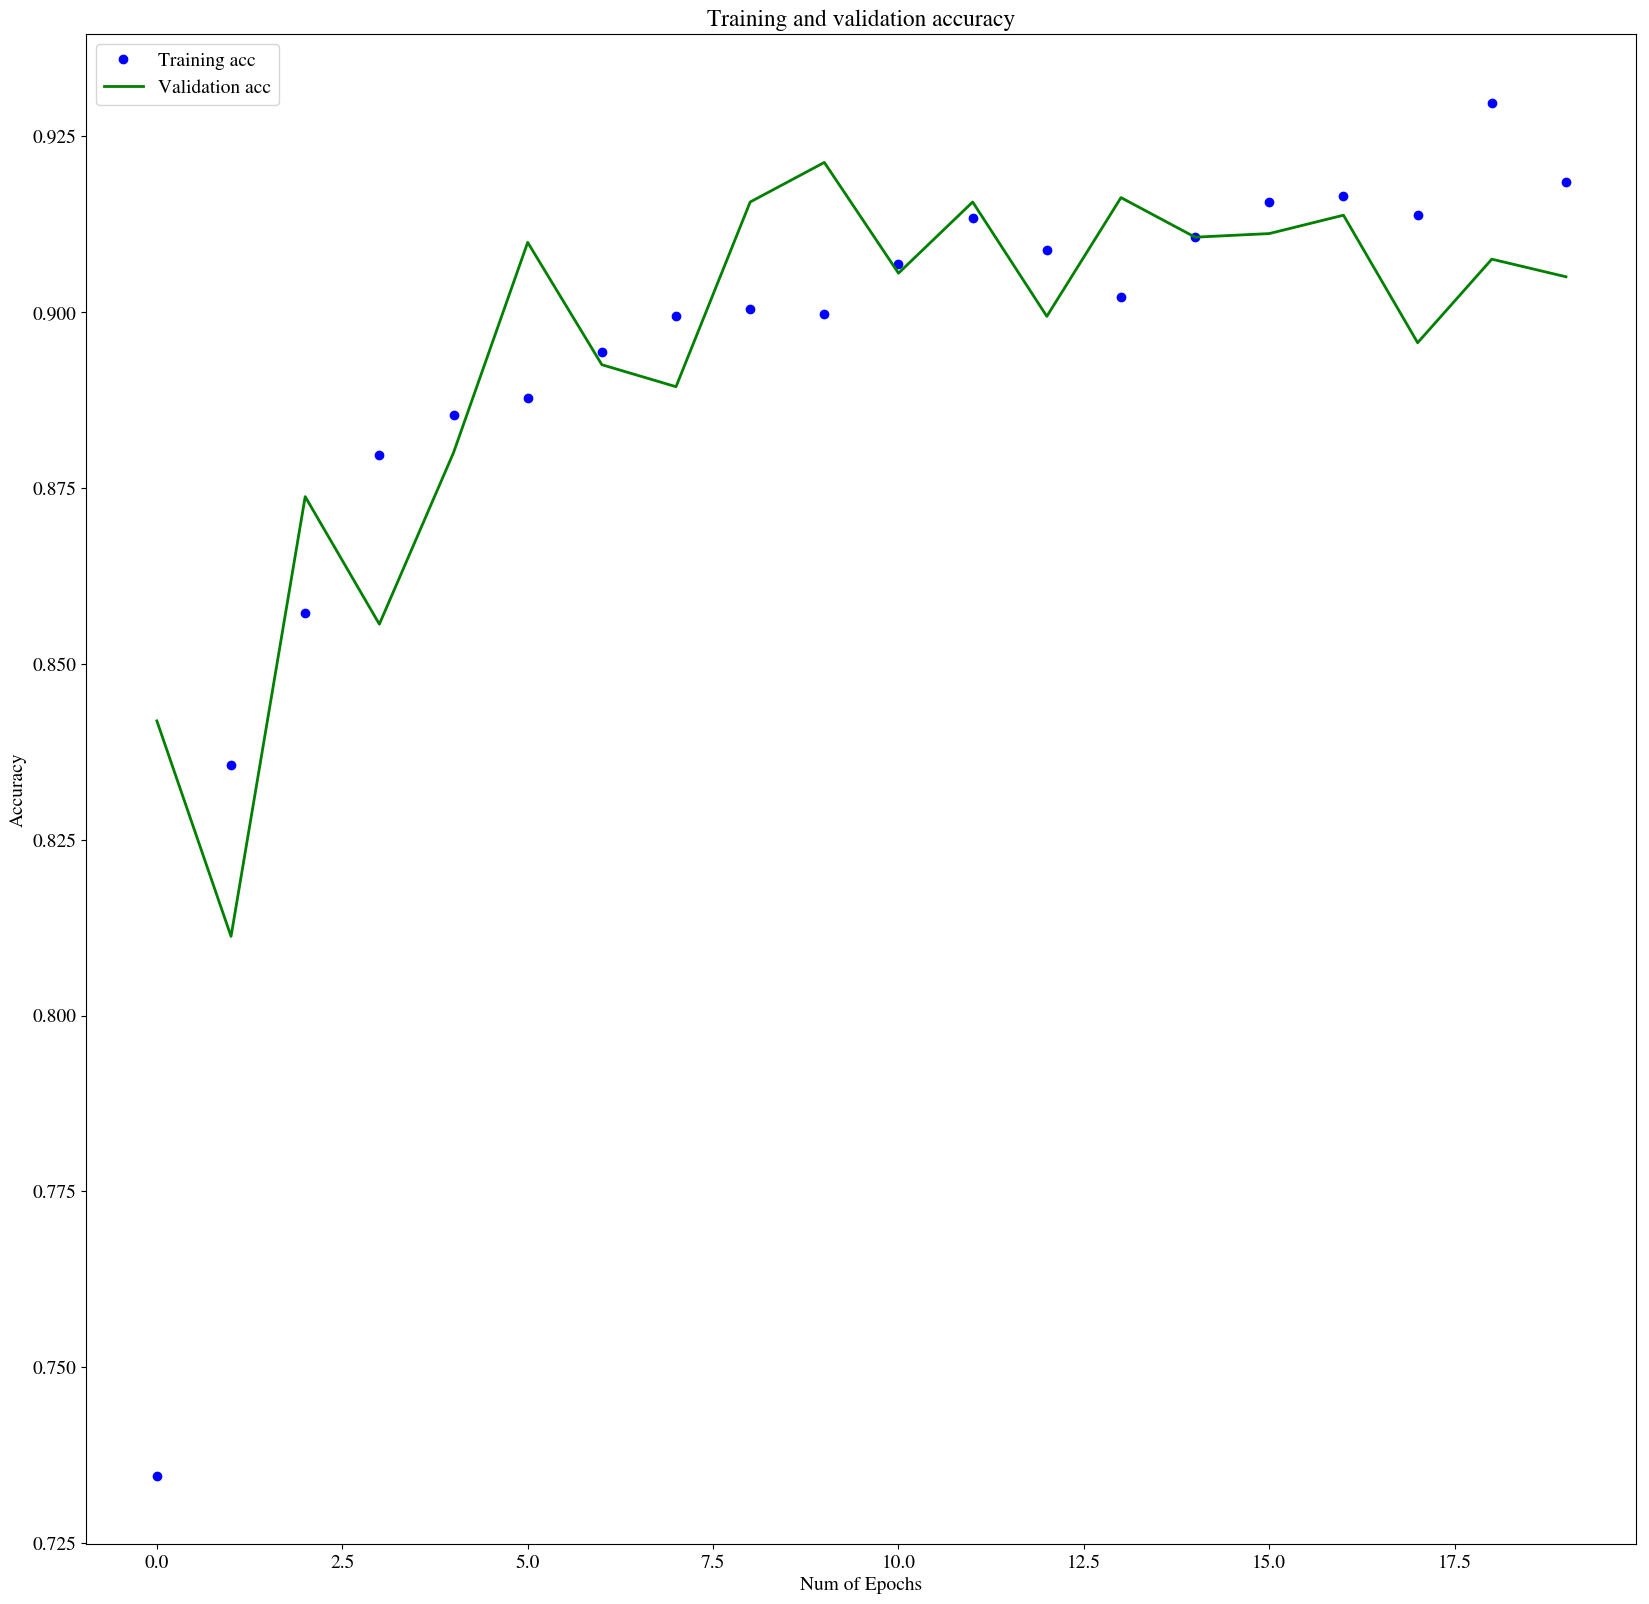

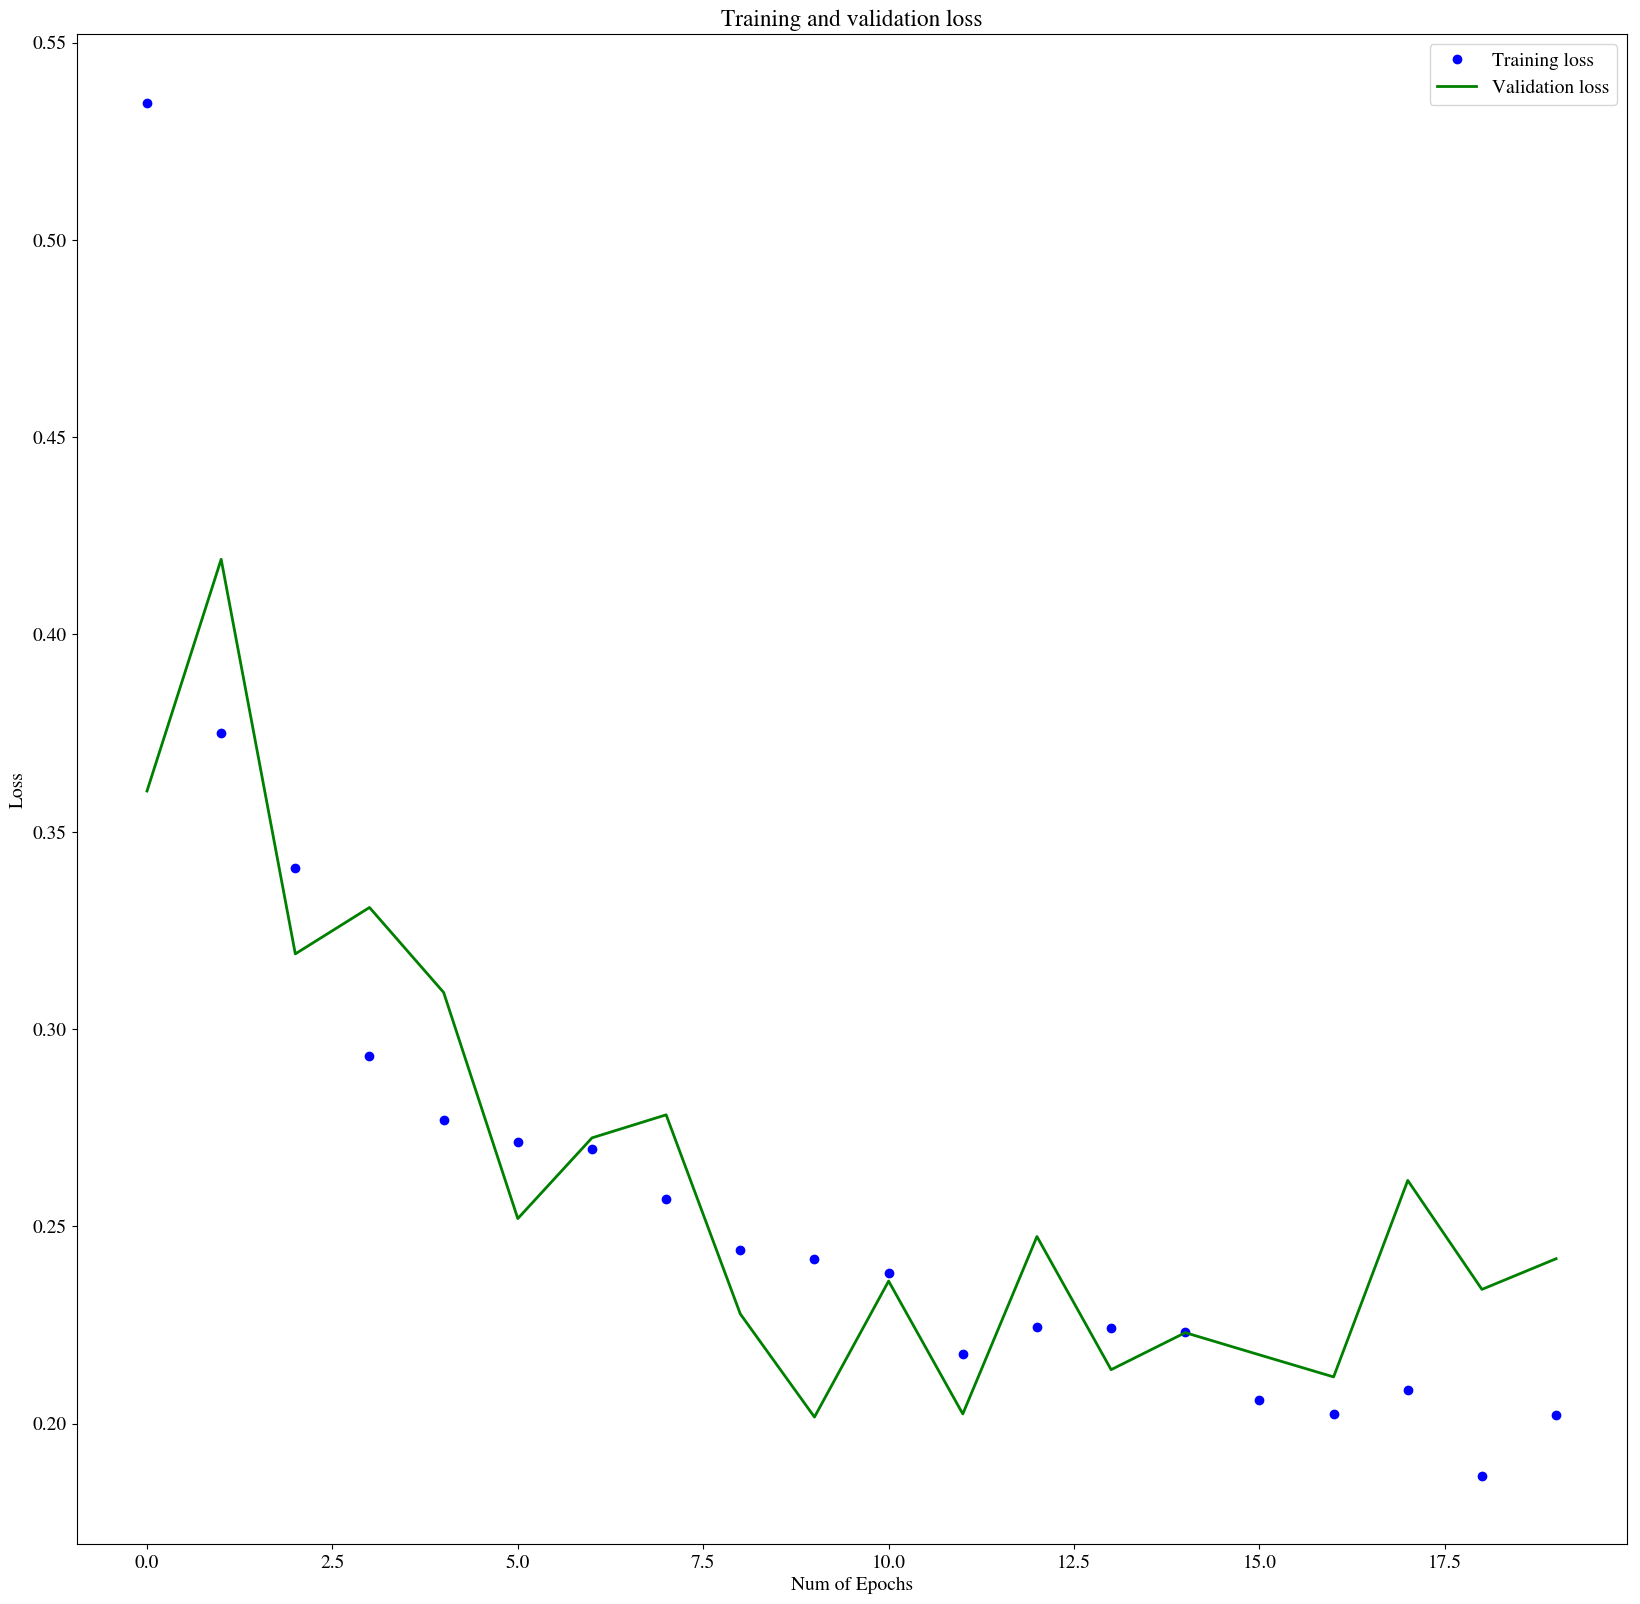

In [68]:
CNN_Dropout_Selector('relu', 'sigmoid')

#### 2.3.3 Experiments with Different Regularizers\
<span style="color:blue">
Five different penalities are put on the higher parameter values: 0.01, 0.02, 0.05. 0.08, 0.09. 
</span>

In [16]:
def CNN_Regularizer_Selector (activation_function_1, activation_function_2):
    
    K.clear_session()
    
    Adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    
    reg = [0, 0.00001, 0.0001, 0.001, 0.1]

    model = [0] * 5
    
    for j in range(0, 5):
        
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(16, kernel_initializer='glorot_uniform', activation=activation_function_1, 
                                  kernel_regularizer=keras.regularizers.l2(reg[j]), activity_regularizer=keras.regularizers.l1(reg[j]), name='fc1'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, 
                                  kernel_regularizer=keras.regularizers.l2(reg[j]), activity_regularizer=keras.regularizers.l1(reg[j]), name='fc2'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].compile(loss='binary_crossentropy', optimizer = Adadelta, metrics=['accuracy'])
    
        print('\n Regulation Penalty:', reg[j])
        
        # Fit the model
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()


 Regulation Penalty: 0
Epoch 1/20
100/100 [==============================] - 5s 52ms/step - loss: 0.5576 - acc: 0.7209 - val_loss: 0.4315 - val_acc: 0.8013
Epoch 2/20
100/100 [==============================] - 5s 46ms/step - loss: 0.3913 - acc: 0.8216 - val_loss: 0.3320 - val_acc: 0.8650
Epoch 3/20
100/100 [==============================] - 4s 44ms/step - loss: 0.3420 - acc: 0.8572 - val_loss: 0.2866 - val_acc: 0.8844
Epoch 4/20
100/100 [==============================] - 4s 44ms/step - loss: 0.3343 - acc: 0.8591 - val_loss: 0.3045 - val_acc: 0.8800
Epoch 5/20
100/100 [==============================] - 4s 43ms/step - loss: 0.3215 - acc: 0.8609 - val_loss: 0.2895 - val_acc: 0.8825
Epoch 6/20
100/100 [==============================] - 5s 48ms/step - loss: 0.2948 - acc: 0.8722 - val_loss: 0.2690 - val_acc: 0.8874
Epoch 7/20
100/100 [==============================] - 5s 50ms/step - loss: 0.2561 - acc: 0.8931 - val_loss: 0.2810 - val_acc: 0.9006
Epoch 8/20
100/100 [=========================

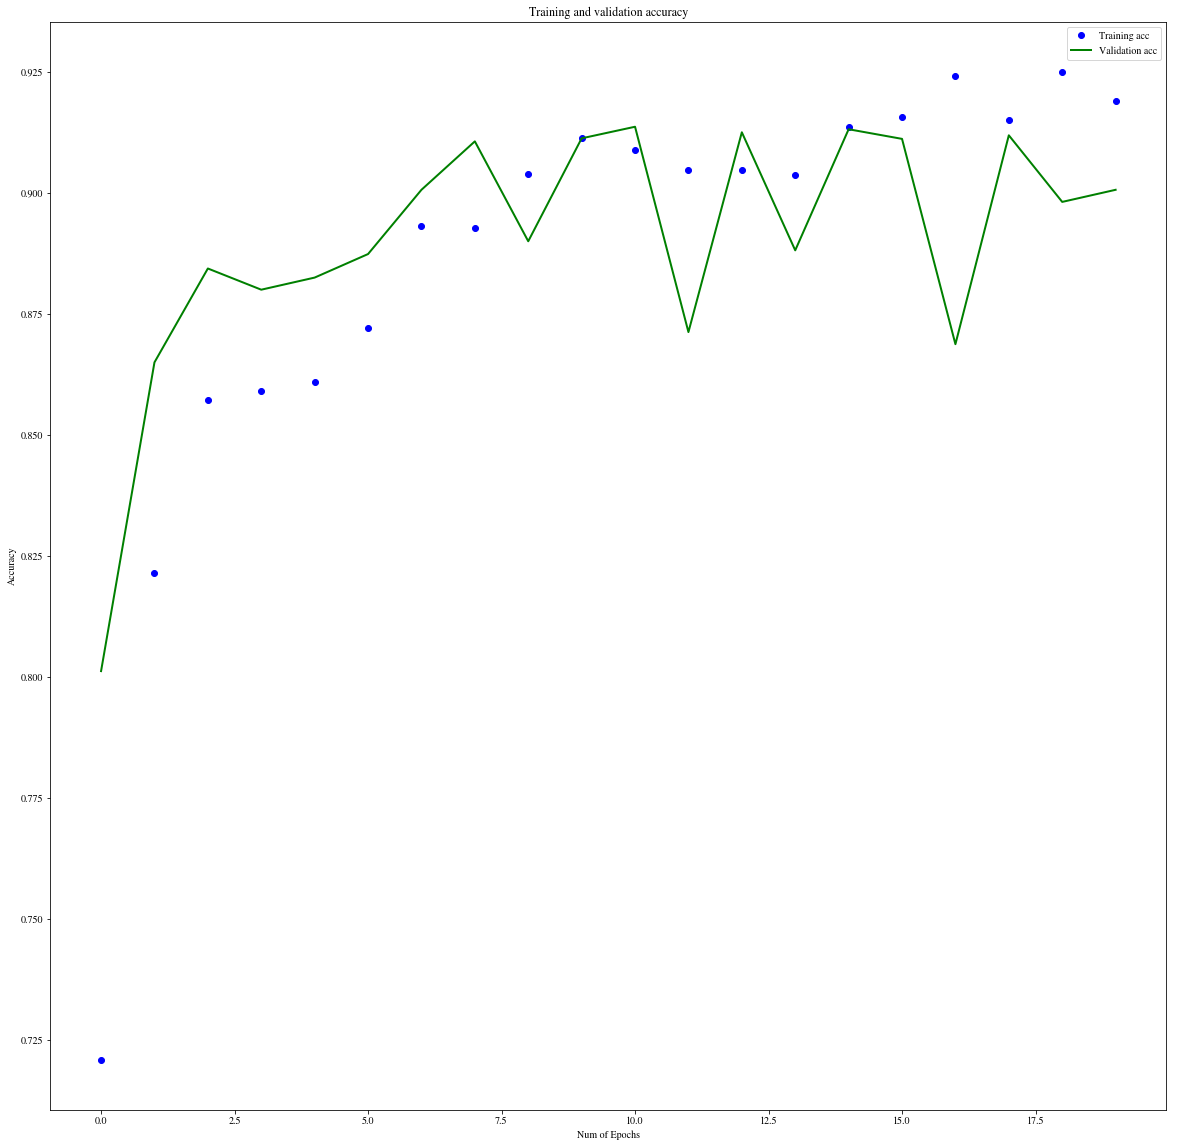

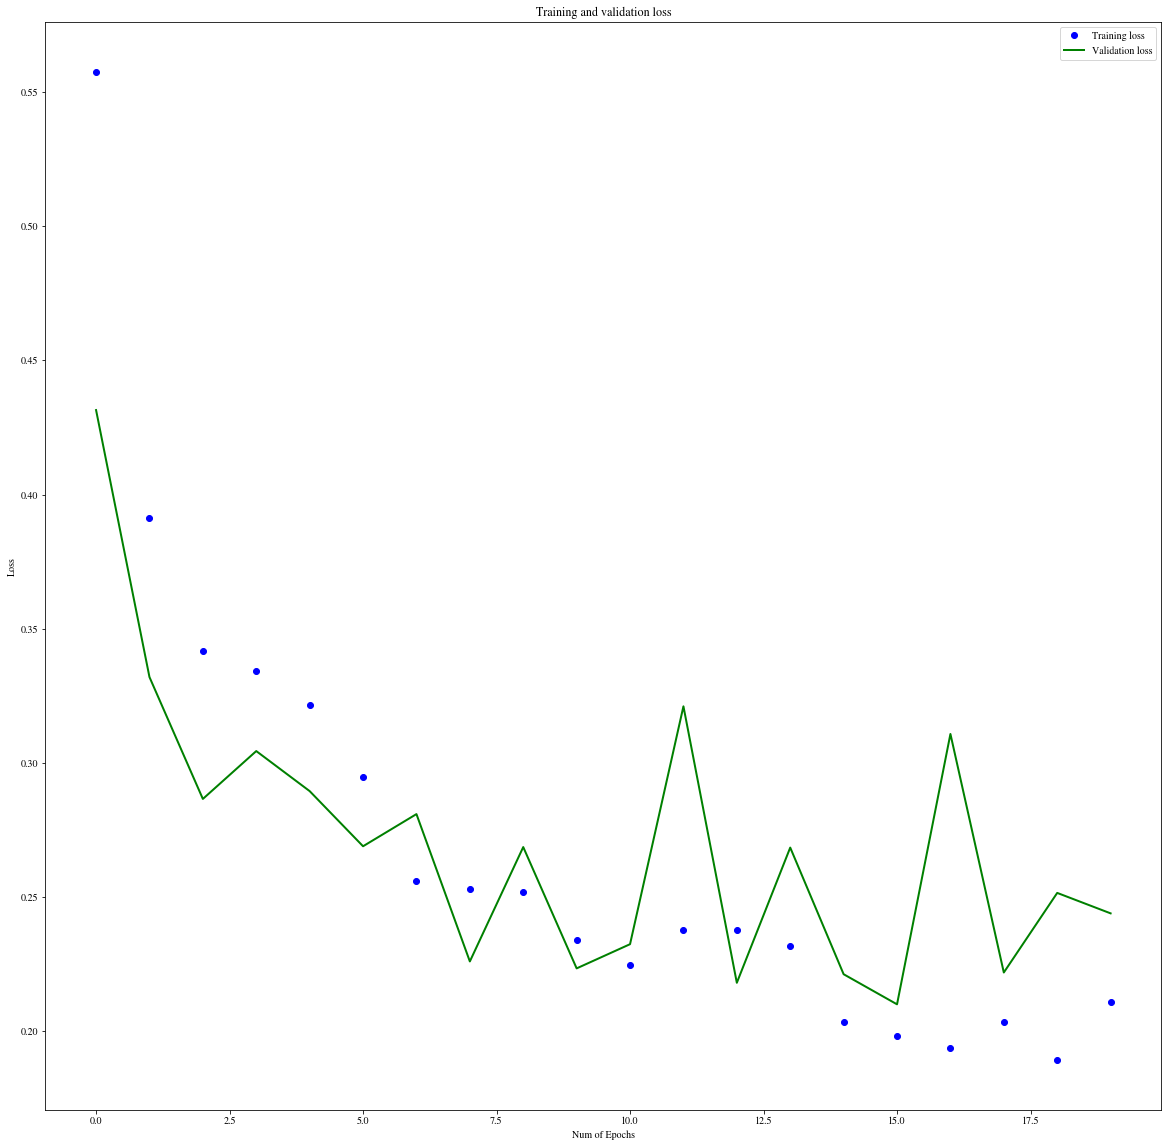


 Regulation Penalty: 1e-05
Epoch 1/20
100/100 [==============================] - 6s 58ms/step - loss: 0.5605 - acc: 0.6984 - val_loss: 0.3913 - val_acc: 0.8187
Epoch 2/20
100/100 [==============================] - 5s 48ms/step - loss: 0.3820 - acc: 0.8369 - val_loss: 0.3832 - val_acc: 0.8337
Epoch 3/20
100/100 [==============================] - 5s 47ms/step - loss: 0.3246 - acc: 0.8584 - val_loss: 0.3810 - val_acc: 0.8331
Epoch 4/20
100/100 [==============================] - 5s 49ms/step - loss: 0.3420 - acc: 0.8500 - val_loss: 0.2874 - val_acc: 0.8894
Epoch 5/20
100/100 [==============================] - 7s 71ms/step - loss: 0.2931 - acc: 0.8805 - val_loss: 0.2702 - val_acc: 0.8900
Epoch 6/20
100/100 [==============================] - 5s 53ms/step - loss: 0.2732 - acc: 0.8934 - val_loss: 0.2838 - val_acc: 0.8930
Epoch 7/20
100/100 [==============================] - 5s 51ms/step - loss: 0.2613 - acc: 0.8966 - val_loss: 0.2647 - val_acc: 0.8956
Epoch 8/20
100/100 [=====================

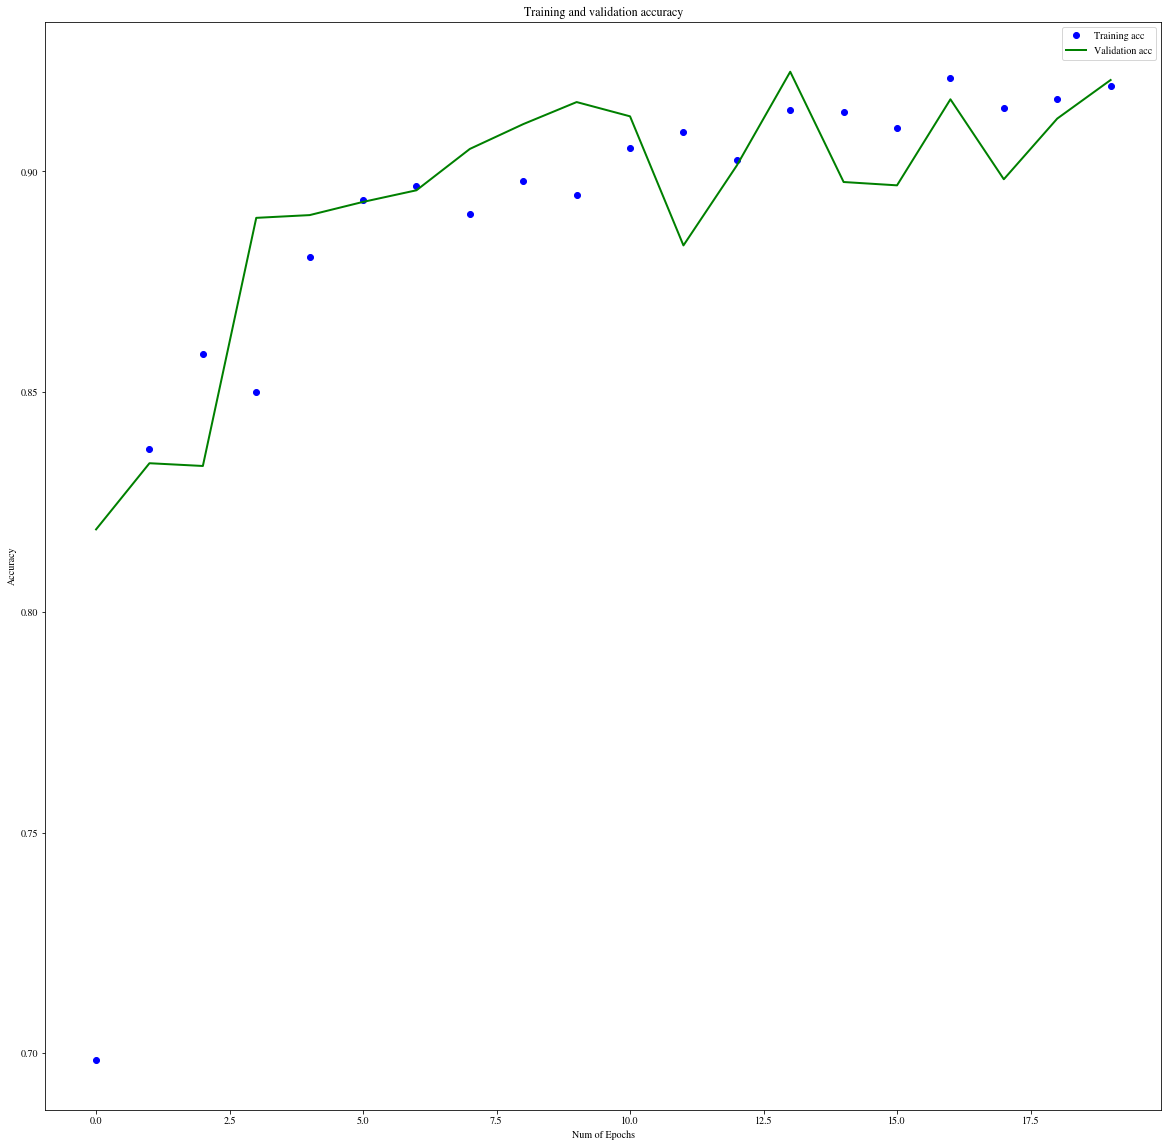

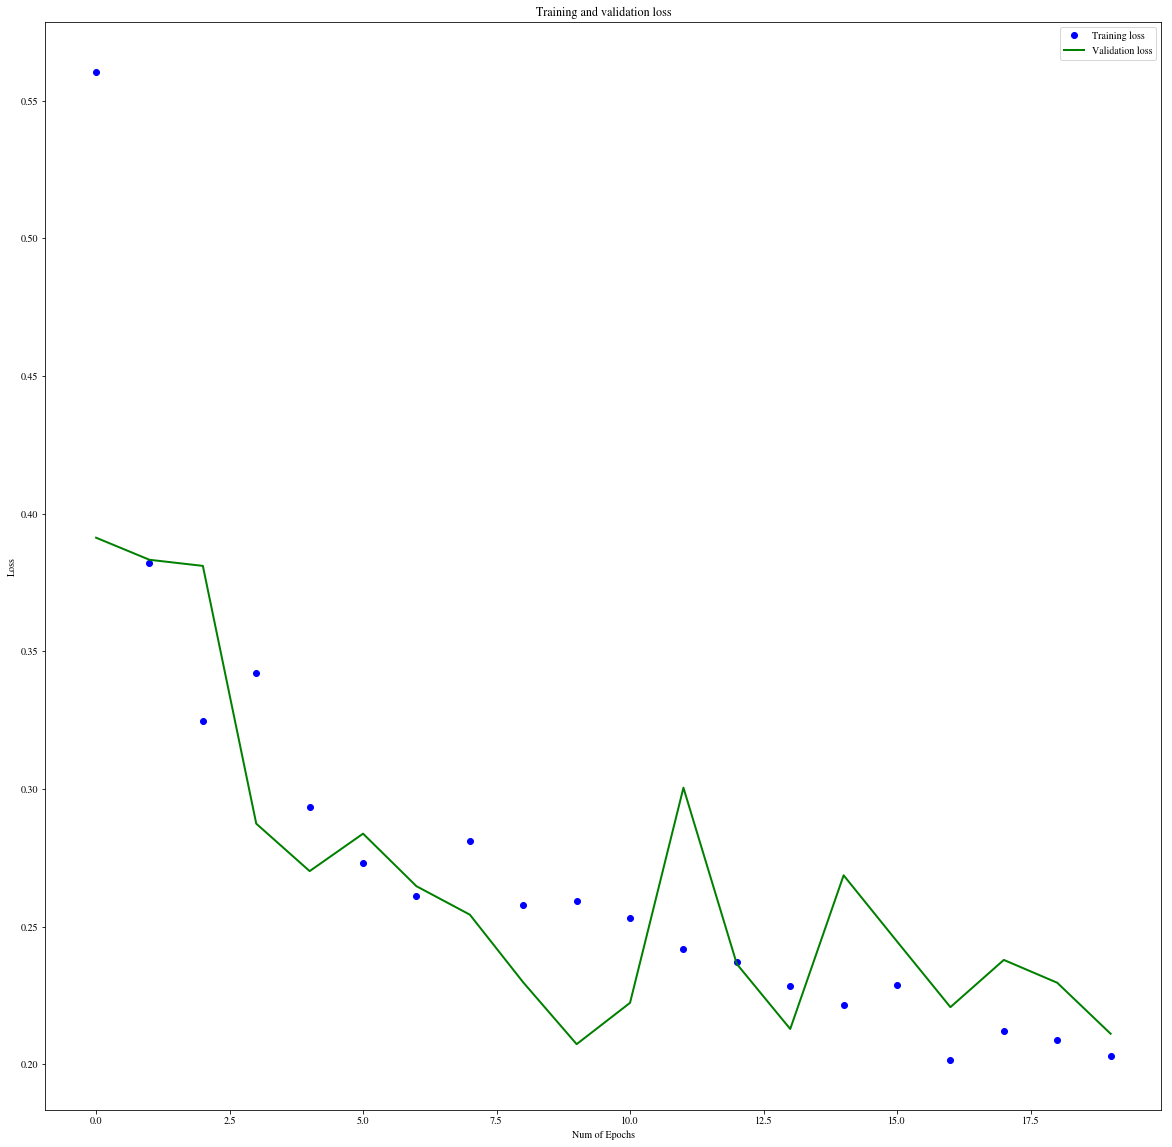


 Regulation Penalty: 0.0001
Epoch 1/20
100/100 [==============================] - 5s 53ms/step - loss: 0.5775 - acc: 0.7113 - val_loss: 0.4115 - val_acc: 0.8231
Epoch 2/20
100/100 [==============================] - 5s 52ms/step - loss: 0.4143 - acc: 0.8205 - val_loss: 0.3731 - val_acc: 0.8512
Epoch 3/20
100/100 [==============================] - 5s 45ms/step - loss: 0.3799 - acc: 0.8459 - val_loss: 0.3288 - val_acc: 0.8738
Epoch 4/20
100/100 [==============================] - 5s 50ms/step - loss: 0.3306 - acc: 0.8731 - val_loss: 0.2947 - val_acc: 0.9050
Epoch 5/20
100/100 [==============================] - 6s 57ms/step - loss: 0.3244 - acc: 0.8675 - val_loss: 0.2766 - val_acc: 0.9019
Epoch 6/20
100/100 [==============================] - 6s 55ms/step - loss: 0.2974 - acc: 0.8825 - val_loss: 0.3319 - val_acc: 0.8680
Epoch 7/20
100/100 [==============================] - 5s 52ms/step - loss: 0.2883 - acc: 0.8816 - val_loss: 0.2738 - val_acc: 0.9106
Epoch 8/20
100/100 [====================

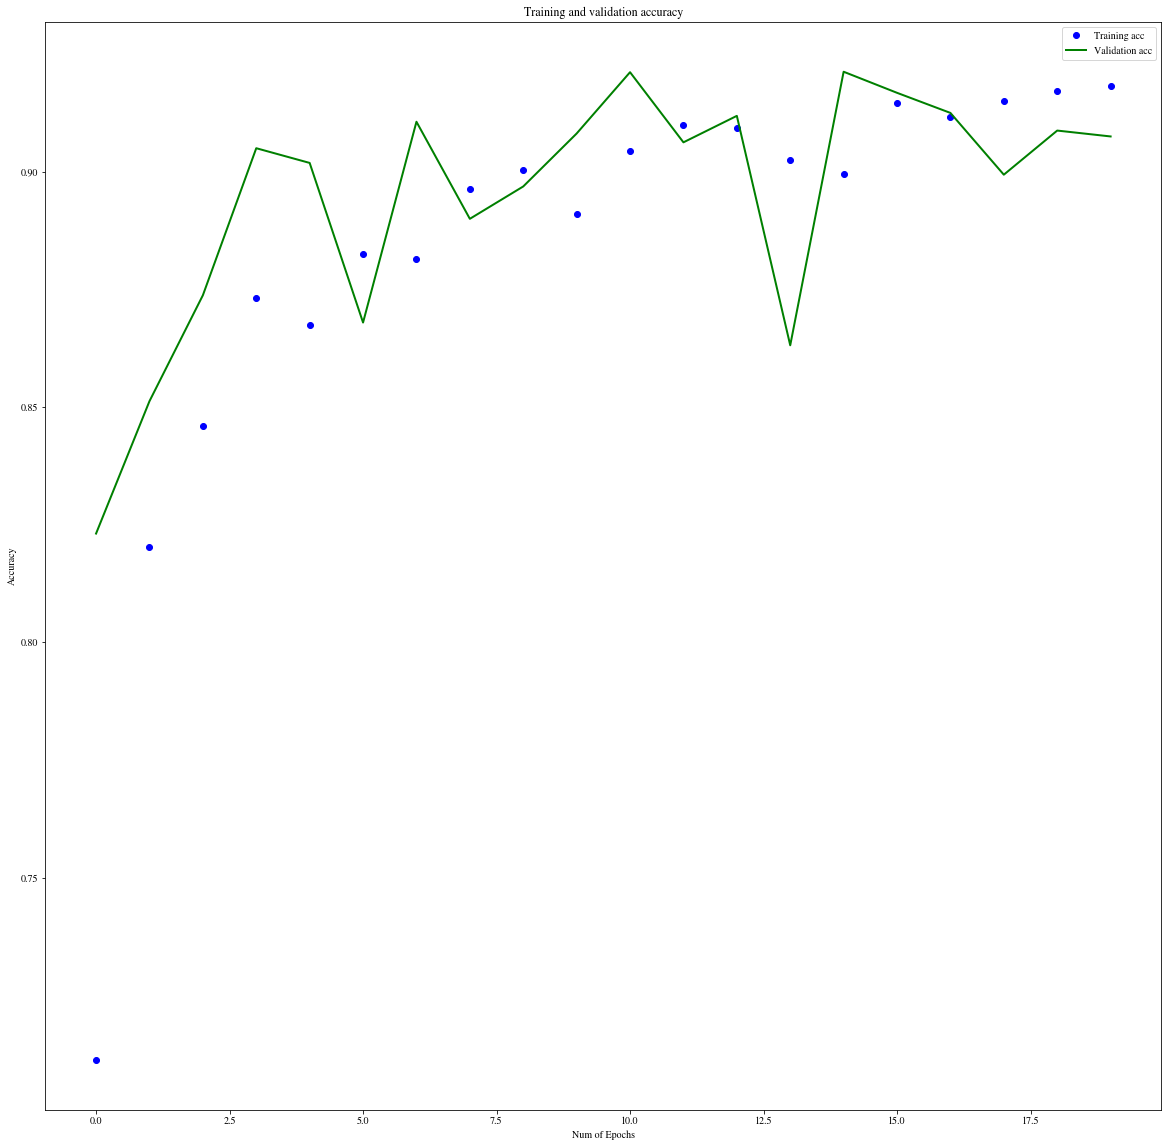

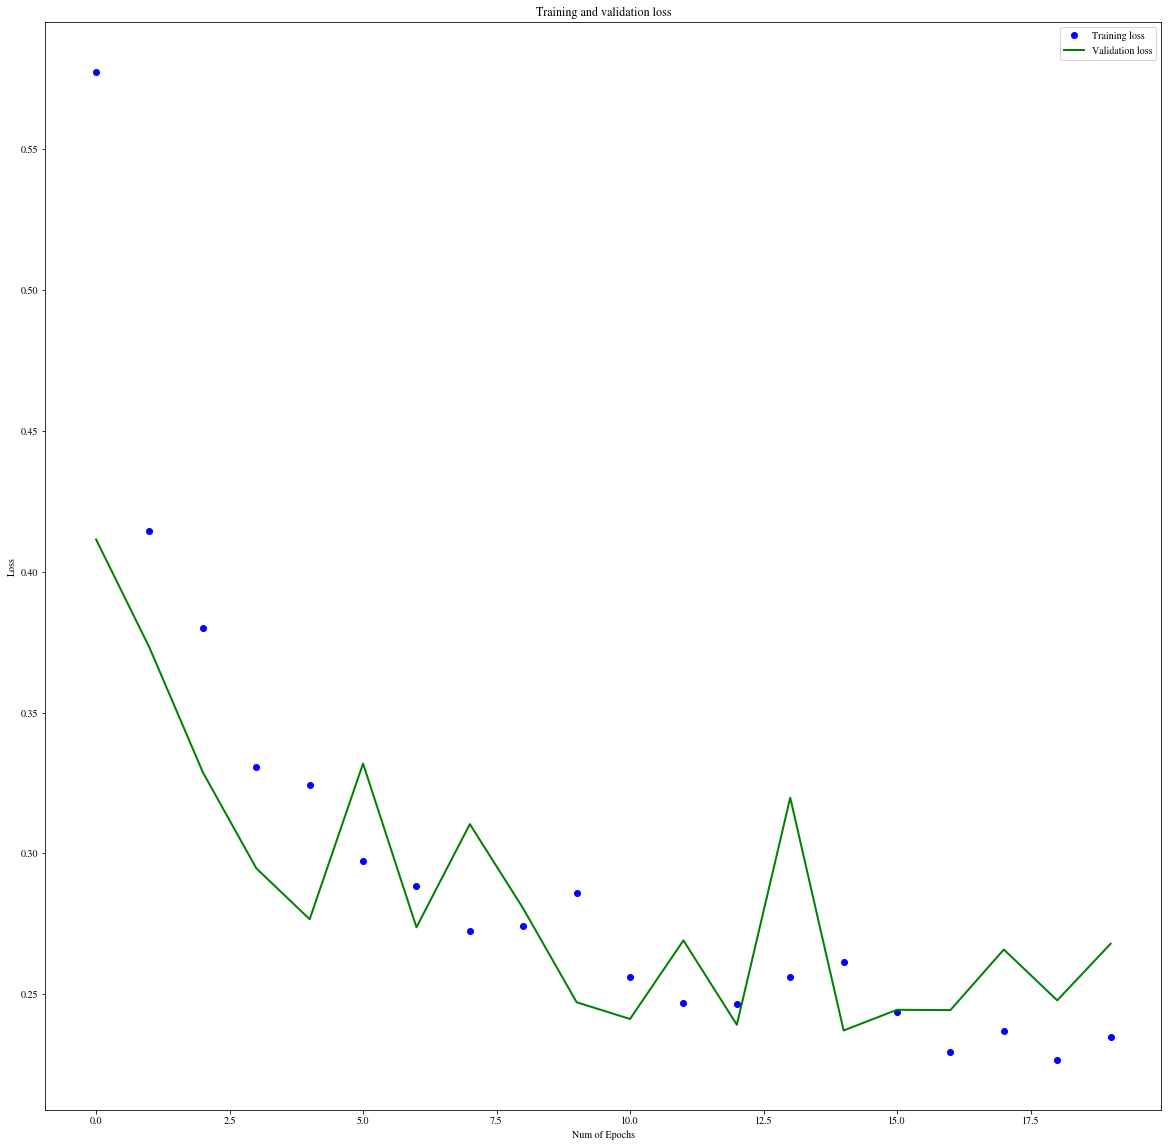


 Regulation Penalty: 0.001
Epoch 1/20
100/100 [==============================] - 6s 56ms/step - loss: 0.6983 - acc: 0.6366 - val_loss: 0.6730 - val_acc: 0.7169
Epoch 2/20
100/100 [==============================] - 5s 50ms/step - loss: 0.6053 - acc: 0.8150 - val_loss: 0.5862 - val_acc: 0.8337
Epoch 3/20
100/100 [==============================] - 5s 50ms/step - loss: 0.5532 - acc: 0.8447 - val_loss: 0.5310 - val_acc: 0.8700
Epoch 4/20
100/100 [==============================] - 5s 49ms/step - loss: 0.5260 - acc: 0.8572 - val_loss: 0.4915 - val_acc: 0.8738
Epoch 5/20
100/100 [==============================] - 5s 50ms/step - loss: 0.4815 - acc: 0.8709 - val_loss: 0.4546 - val_acc: 0.9000
Epoch 6/20
100/100 [==============================] - 5s 53ms/step - loss: 0.4541 - acc: 0.8907 - val_loss: 0.4363 - val_acc: 0.8942
Epoch 7/20
100/100 [==============================] - 5s 50ms/step - loss: 0.4428 - acc: 0.8800 - val_loss: 0.4365 - val_acc: 0.8969
Epoch 8/20
100/100 [=====================

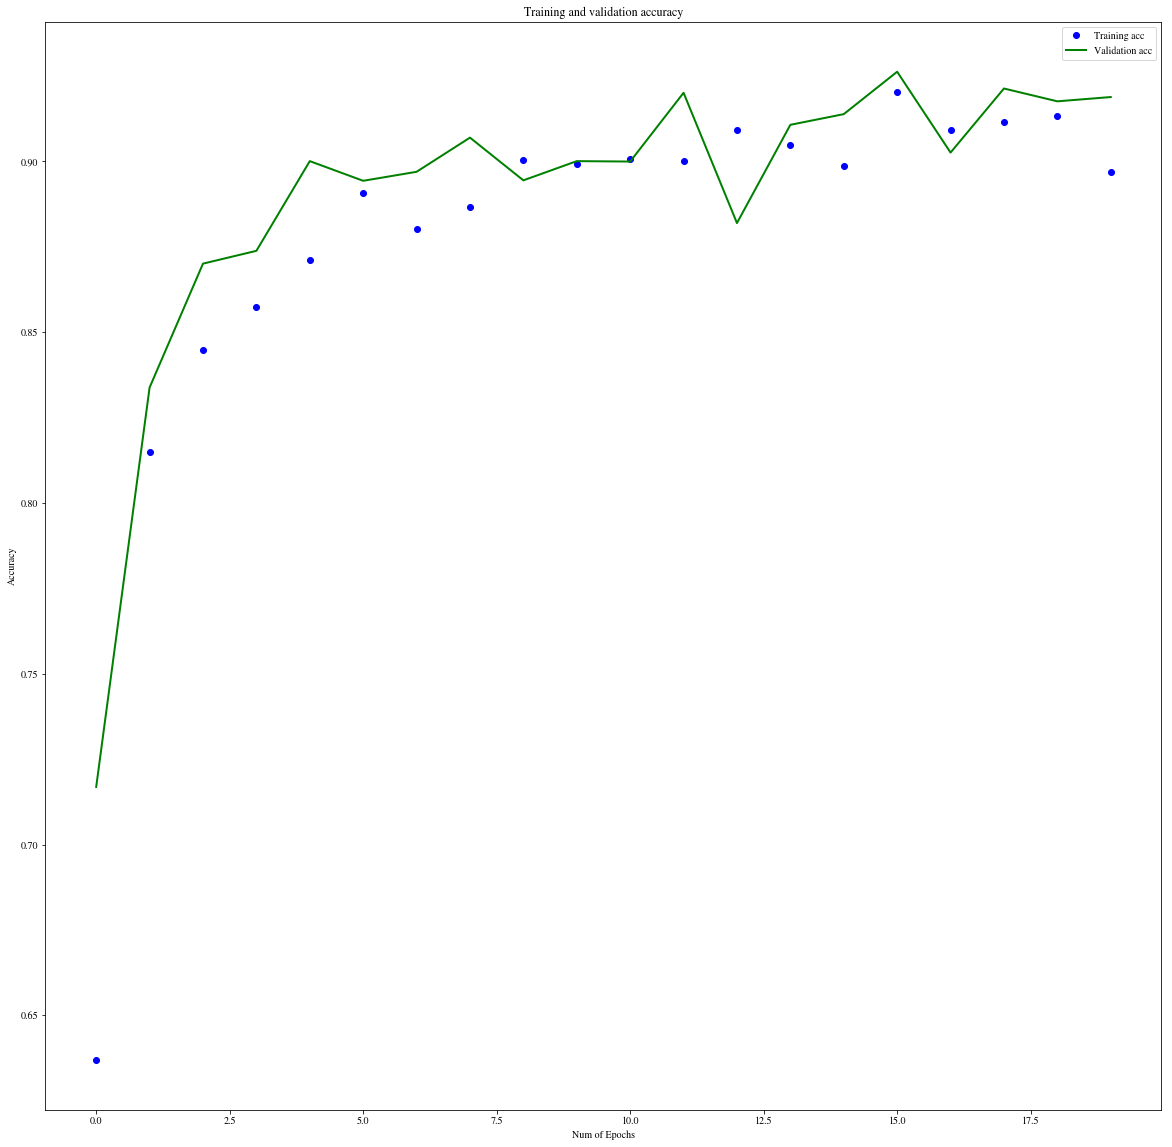

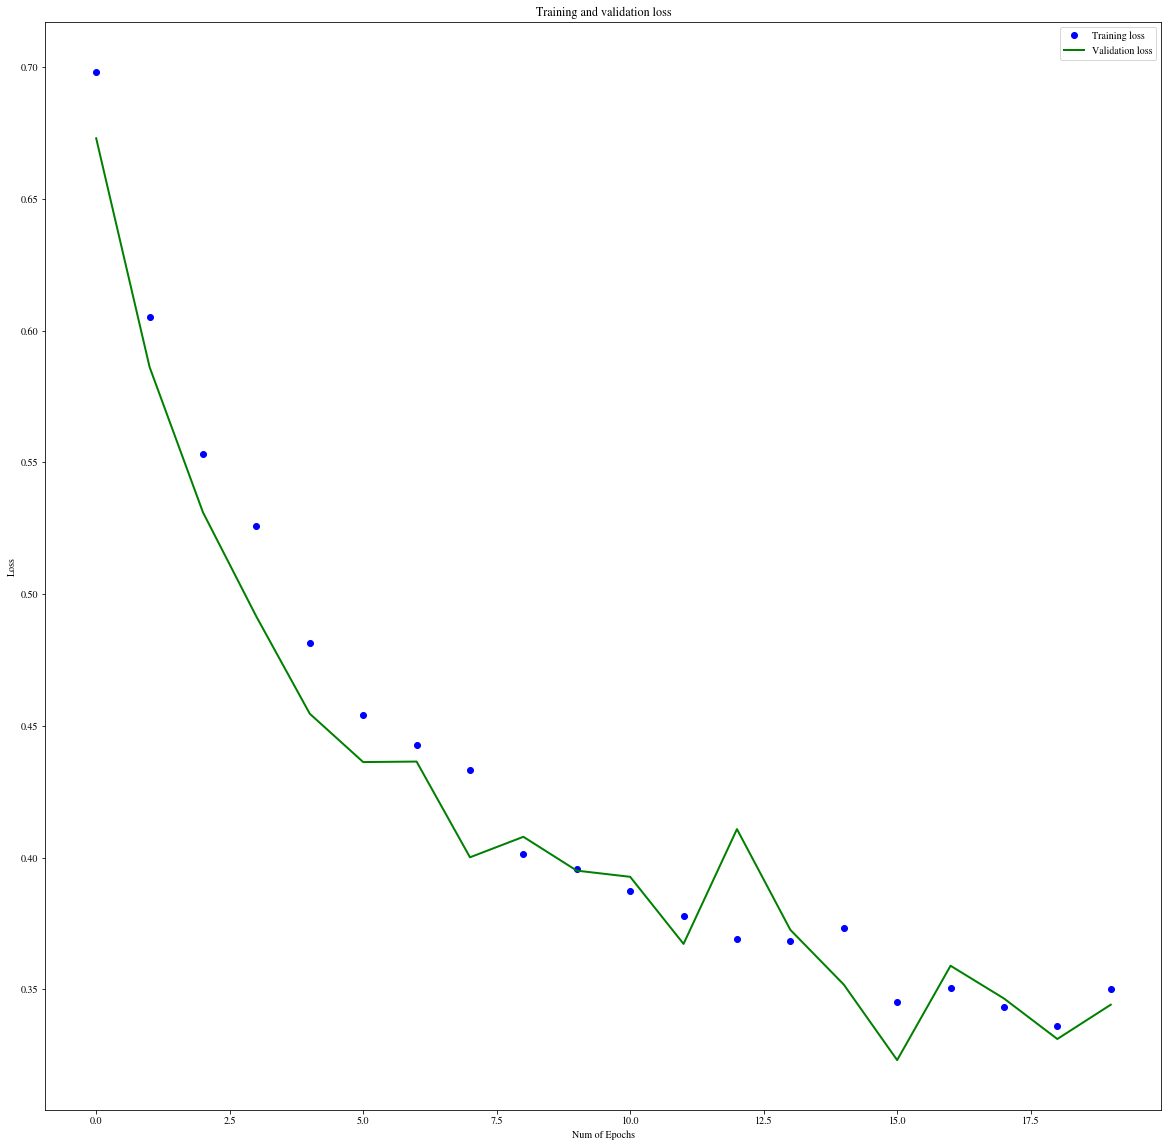


 Regulation Penalty: 0.1
Epoch 1/20
100/100 [==============================] - 6s 60ms/step - loss: 3.2556 - acc: 0.4591 - val_loss: 2.4458 - val_acc: 0.4700
Epoch 2/20
100/100 [==============================] - 5s 50ms/step - loss: 2.2022 - acc: 0.4800 - val_loss: 2.0691 - val_acc: 0.4925
Epoch 3/20
100/100 [==============================] - 5s 52ms/step - loss: 2.0103 - acc: 0.4719 - val_loss: 1.9462 - val_acc: 0.4763
Epoch 4/20
100/100 [==============================] - 5s 51ms/step - loss: 1.8935 - acc: 0.4772 - val_loss: 1.8425 - val_acc: 0.4800
Epoch 5/20
100/100 [==============================] - 5s 50ms/step - loss: 1.8246 - acc: 0.4496 - val_loss: 1.7564 - val_acc: 0.4919
Epoch 6/20
100/100 [==============================] - 5s 54ms/step - loss: 1.7469 - acc: 0.4659 - val_loss: 1.7094 - val_acc: 0.4737
Epoch 7/20
100/100 [==============================] - 5s 55ms/step - loss: 1.6966 - acc: 0.4637 - val_loss: 1.6650 - val_acc: 0.4725
Epoch 8/20
100/100 [=======================

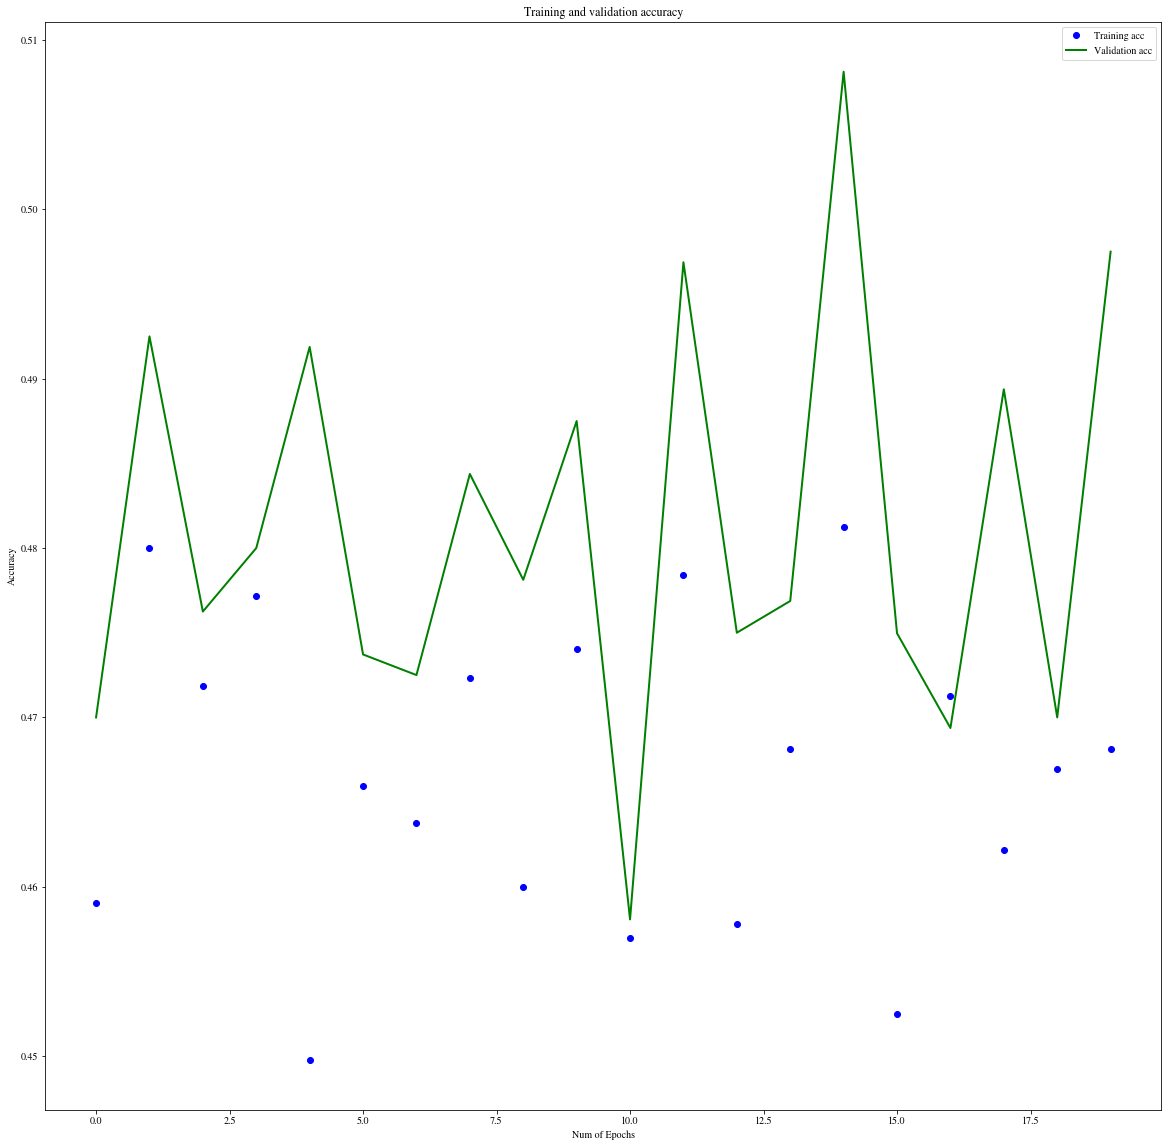

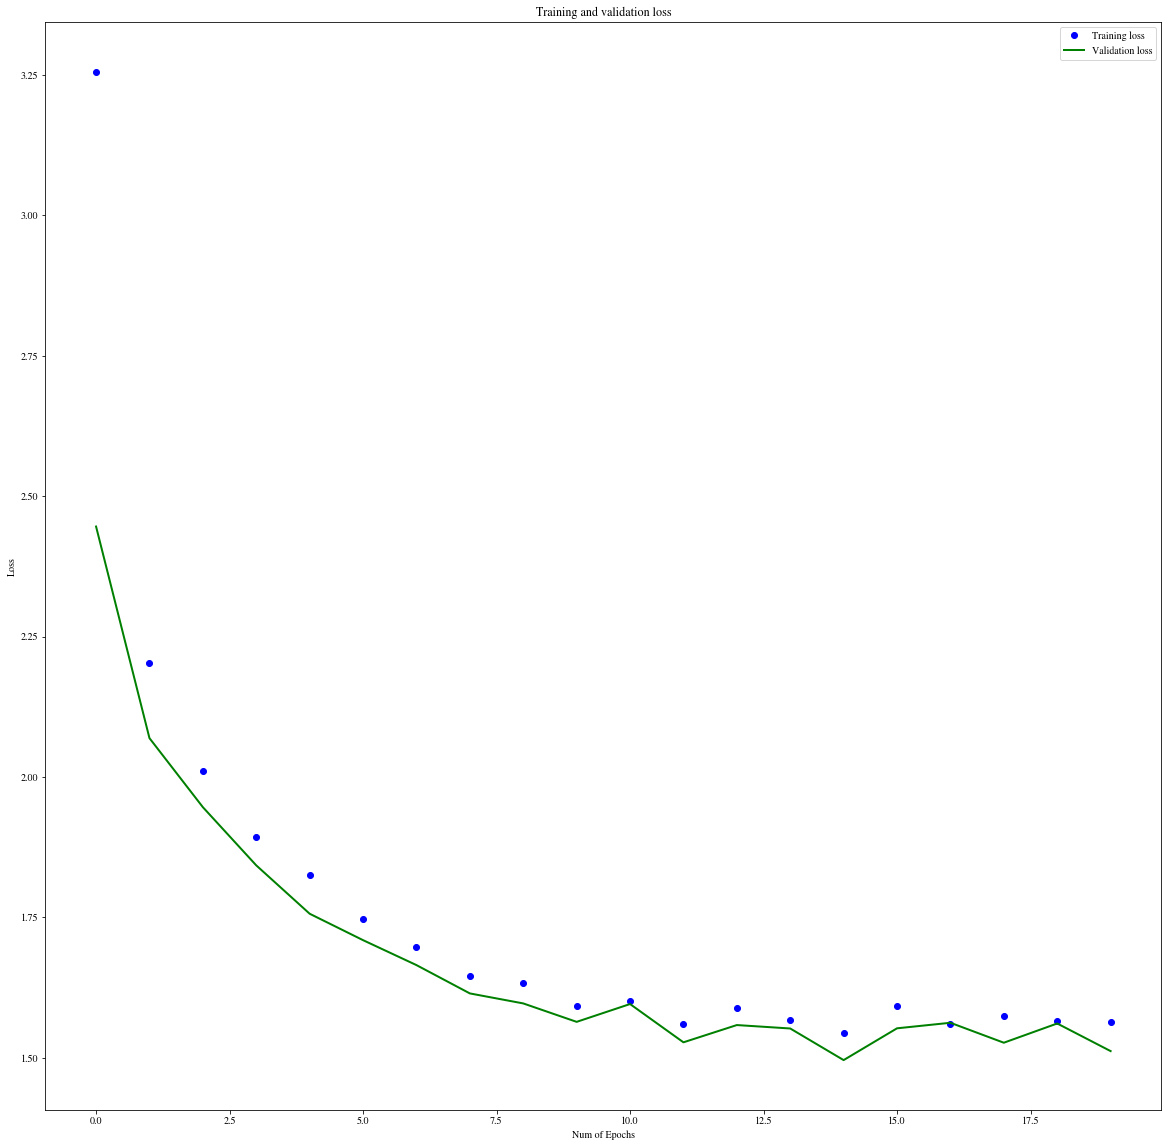

In [17]:
CNN_Regularizer_Selector('relu', 'sigmoid')

#### 2.4 The interpretation of results for experimenting
<span style="color:blue">
Based on the accuracy and loss of training, validation, and test sets, the best optimizer for our image dataset is Adadelta, the best rate for dropout is 0, and the best penality for our image dataset is 0.00001.  
</span>

### 3. Parameter tuning 

#### 3.1 The hypothesis/strategy Ststement of Parameter Tuning
<span style="color:blue">
Here, we will explore the optimal values for several parameters for our CNN: Batch size, Learning Rate, Adadelta Decay Factor, and Initial Learning Rate Decay. We will try different bacth sizes: 16, 32, 64, 128, and 256, different learning_rate for the Adadelta optimizer: 0.1, 0.5, 1, 5, and 10, and different decay factor for the Adadelta optimizer: 0, 0.1, 0.5, 0.9, and 1.
</span>

#### 3.2 The Types of Tests for Parameter Tuning
<span style="color:blue">
Here, the accuracy and loss of training, validation, and test sets obtained from different architectures will be used to choose the optimal architecture. The final values of accuracy and loss and how the accuracy and loss change with epochs will be compared too determine the optimal values. 
</span>

#### 3.3 The Code and Results for Parameter Tuning

#### 3.3.1 Parameter Tuning -- Determine the Optimal Batch size
<span style="color:blue">
The optimal CNN model for the iamge dataset obtained in Part 1 and Part 2 will be used in this Part 3. We will try different bacth sizes: 16, 32, 64, 128, and 256.
</span>

In [9]:
def CNN_Parameter_Tuning_1 (activation_function_1, activation_function_2):
        
    K.clear_session()
    
    Adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

    model = [0] * 5
    batches = [0] * 5
    
    for j in range(0, 5):
        
        batches[j] = 2**(j+4)
        
        train_generator_new = train_datagen.flow_from_directory(
            train_dir,
            target_size=(64, 64),
            batch_size = batches[j],
            class_mode='binary')
        
        for train_data_batch, train_labels_batch in train_generator_new:
            print('data batch shape:', train_data_batch.shape)
            print('labels batch shape:', train_labels_batch.shape)
            break
        
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(16, kernel_initializer='glorot_uniform', activation=activation_function_1, 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc1'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc2'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].compile(loss='binary_crossentropy', optimizer = Adadelta, metrics=['accuracy'])
        
        # Fit the model
        
        history = model[j].fit_generator(
            train_generator_new,
            steps_per_epoch=100,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=50,
            verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('\batch_size:', batches[j])
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()

Found 16315 images belonging to 2 classes.
data batch shape: (16, 64, 64, 3)
labels batch shape: (16,)
Epoch 1/20
100/100 [==============================] - 11s 108ms/step - loss: 0.5810 - acc: 0.7087 - val_loss: 0.4466 - val_acc: 0.7956
Epoch 2/20
100/100 [==============================] - 9s 91ms/step - loss: 0.4276 - acc: 0.7987 - val_loss: 0.3907 - val_acc: 0.8287
Epoch 3/20
100/100 [==============================] - 9s 86ms/step - loss: 0.3638 - acc: 0.8381 - val_loss: 0.3214 - val_acc: 0.8644oss: 0.374
Epoch 4/20
100/100 [==============================] - 11s 108ms/step - loss: 0.3397 - acc: 0.8556 - val_loss: 0.4314 - val_acc: 0.8075
Epoch 5/20
100/100 [==============================] - 9s 91ms/step - loss: 0.3105 - acc: 0.8713 - val_loss: 0.2993 - val_acc: 0.8762
Epoch 6/20
100/100 [==============================] - 9s 91ms/step - loss: 0.2758 - acc: 0.8931 - val_loss: 0.3221 - val_acc: 0.8798
Epoch 7/20
100/100 [==============================] - 7s 72ms/step - loss: 0.3056 - a

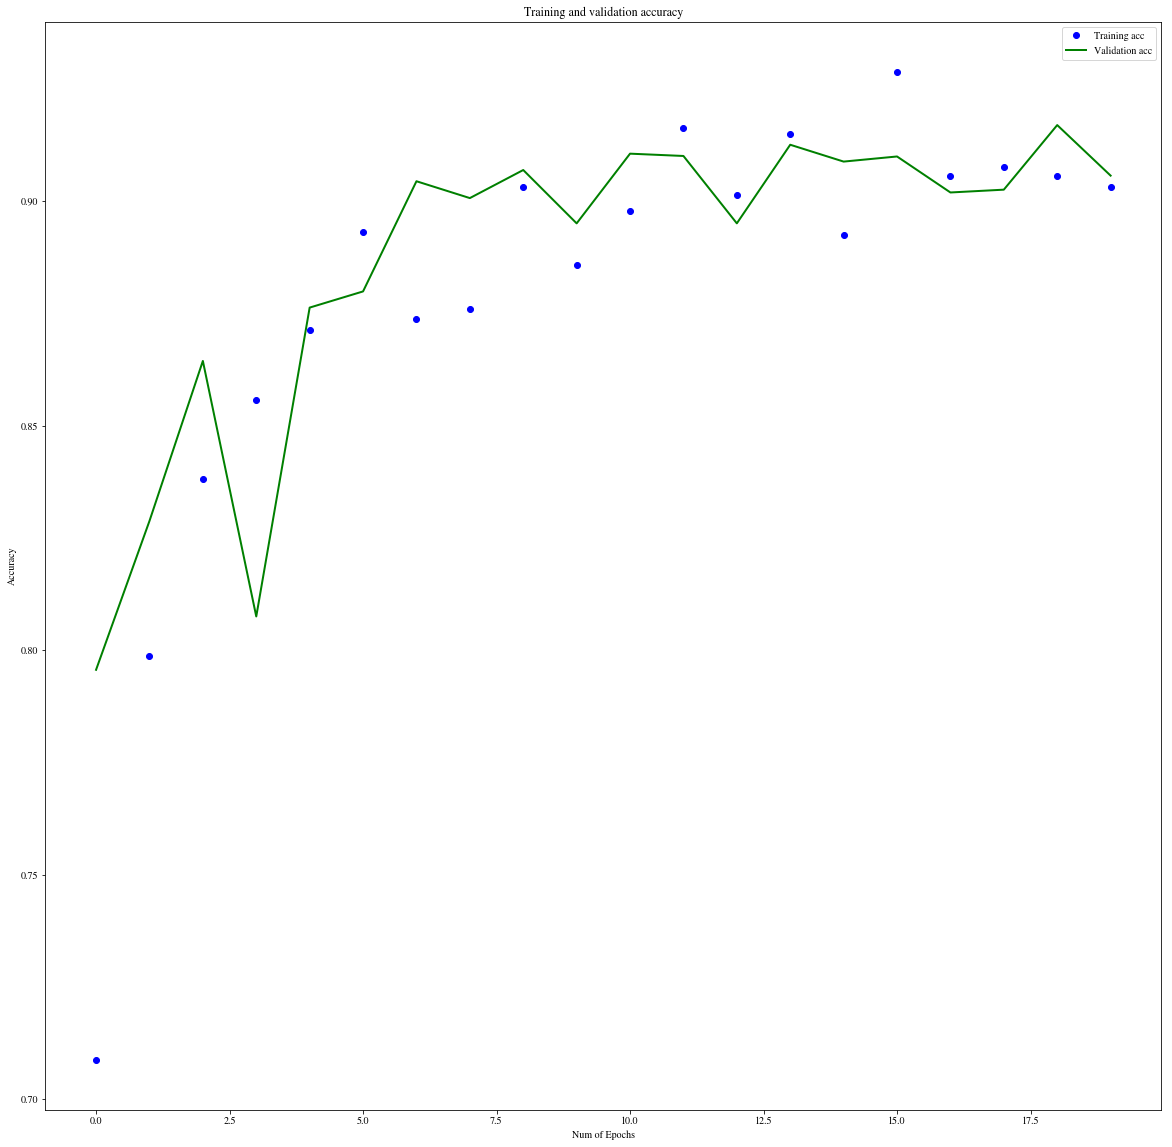

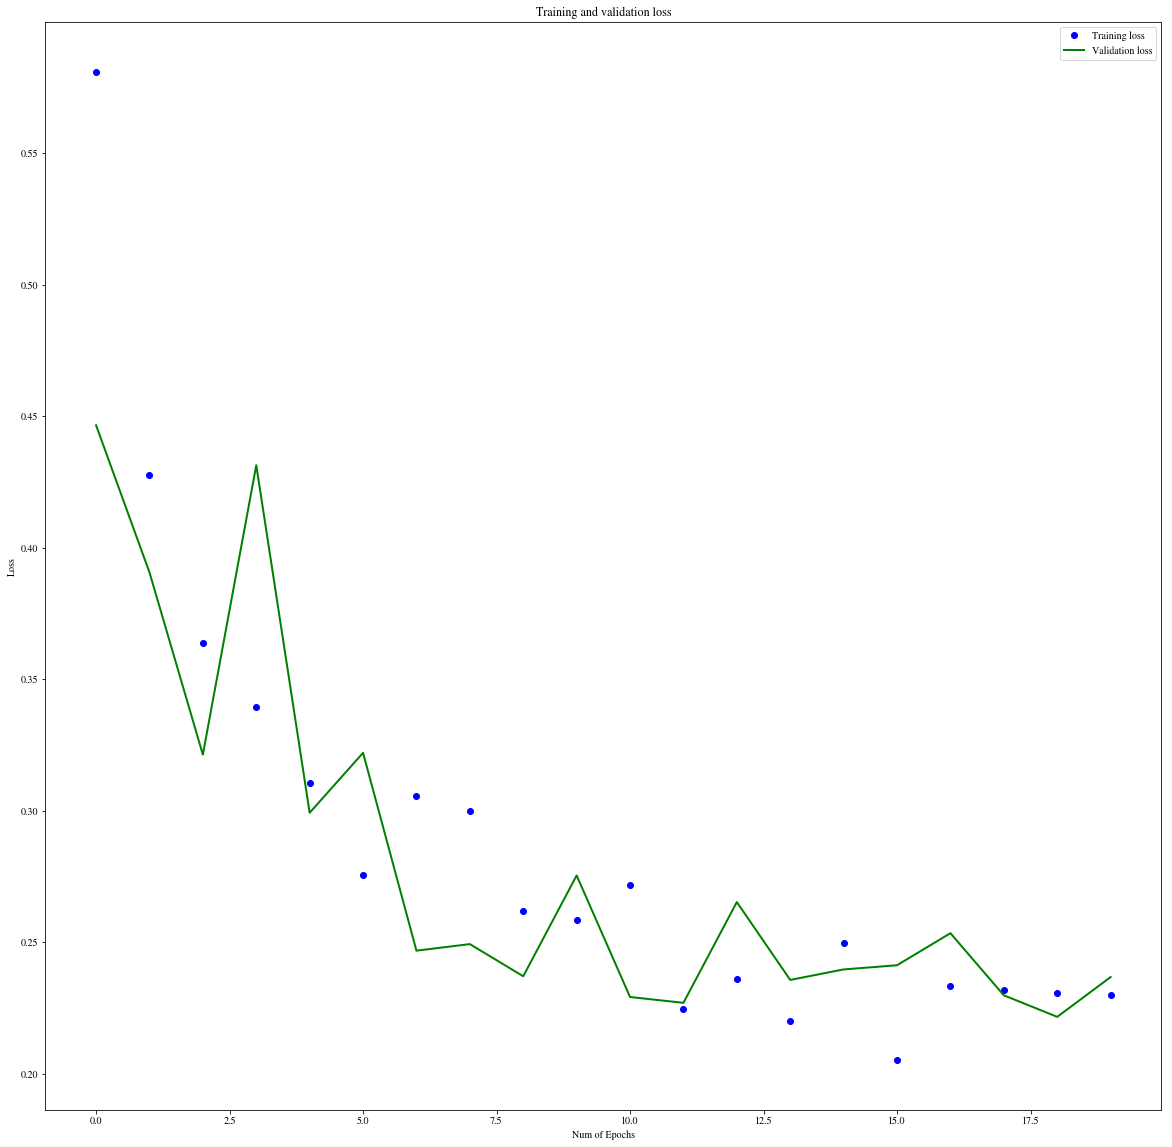

Found 16315 images belonging to 2 classes.
data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)
Epoch 1/20
100/100 [==============================] - 11s 106ms/step - loss: 0.5852 - acc: 0.6941 - val_loss: 0.4816 - val_acc: 0.8063
Epoch 2/20
100/100 [==============================] - 10s 98ms/step - loss: 0.3978 - acc: 0.8250 - val_loss: 0.4030 - val_acc: 0.8106
Epoch 3/20
100/100 [==============================] - 10s 100ms/step - loss: 0.3452 - acc: 0.8512 - val_loss: 0.2994 - val_acc: 0.8788
Epoch 4/20
100/100 [==============================] - 10s 98ms/step - loss: 0.3161 - acc: 0.8672 - val_loss: 0.3053 - val_acc: 0.8694
Epoch 5/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2945 - acc: 0.8784 - val_loss: 0.3340 - val_acc: 0.8725
Epoch 6/20
100/100 [==============================] - 7s 74ms/step - loss: 0.2898 - acc: 0.8772 - val_loss: 0.2512 - val_acc: 0.8961
Epoch 7/20
100/100 [==============================] - 9s 86ms/step - loss: 0.2710 - acc: 0.8

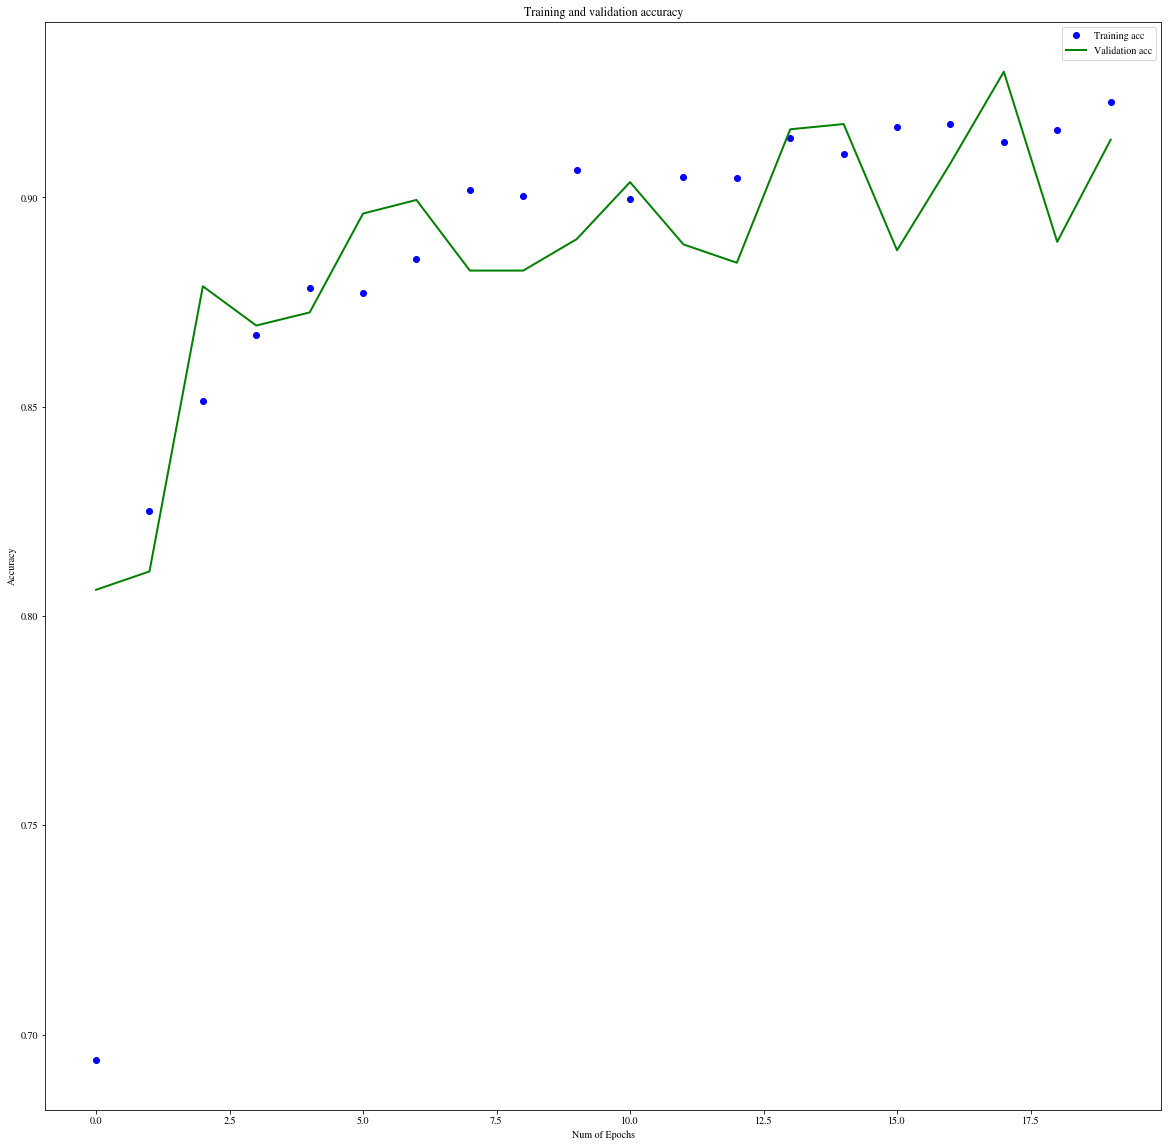

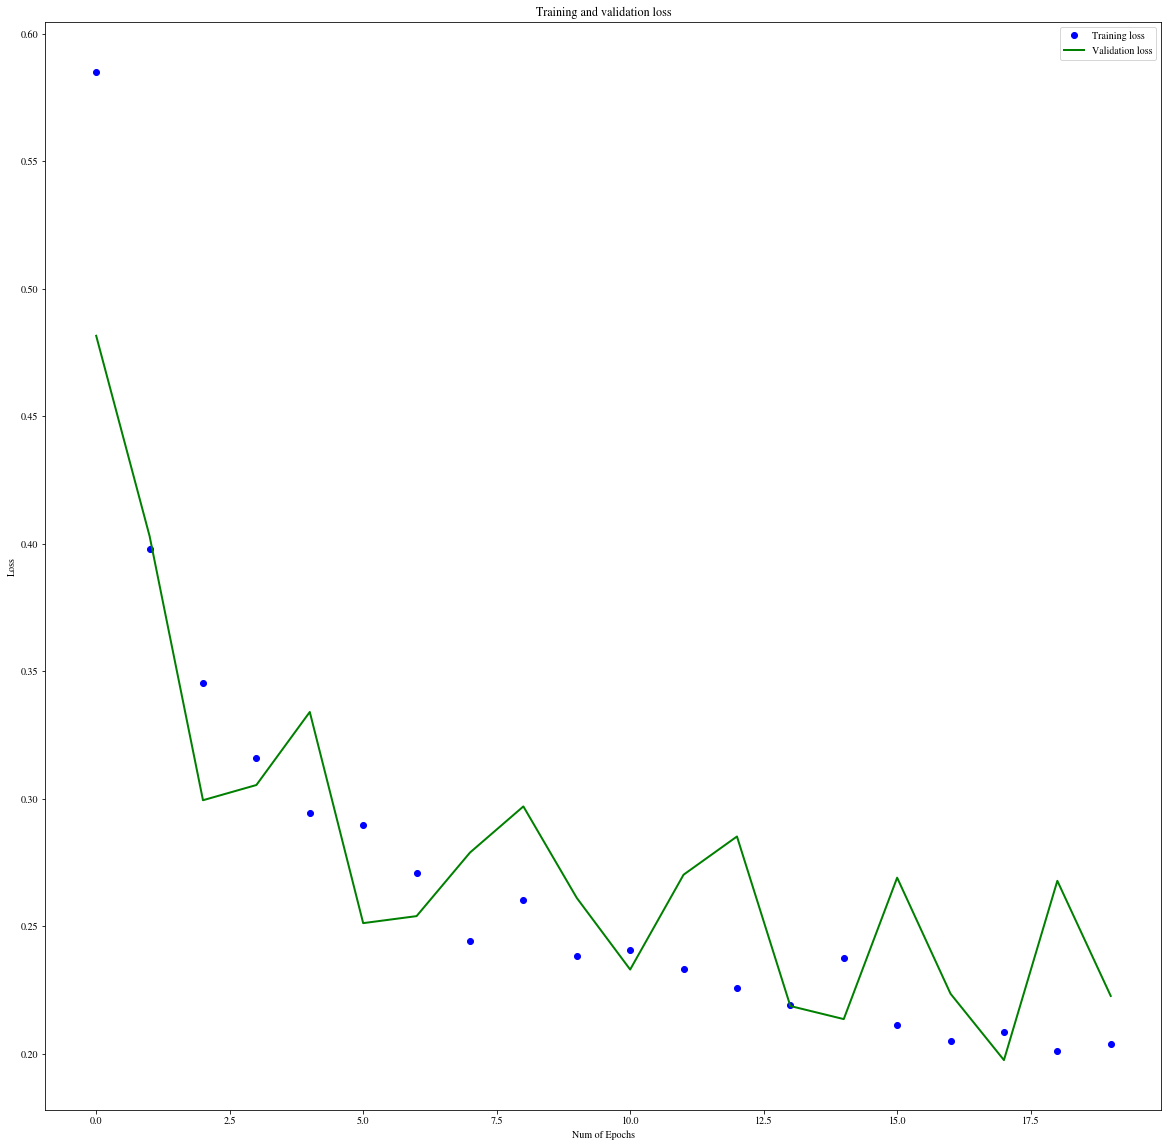

Found 16315 images belonging to 2 classes.
data batch shape: (64, 64, 64, 3)
labels batch shape: (64,)
Epoch 1/20
100/100 [==============================] - 12s 116ms/step - loss: 0.5150 - acc: 0.7491 - val_loss: 0.3935 - val_acc: 0.8100
Epoch 2/20
100/100 [==============================] - 11s 113ms/step - loss: 0.3605 - acc: 0.8459 - val_loss: 0.2906 - val_acc: 0.8794
Epoch 3/20
100/100 [==============================] - 12s 117ms/step - loss: 0.3049 - acc: 0.8726 - val_loss: 0.2996 - val_acc: 0.8775
Epoch 4/20
100/100 [==============================] - 13s 125ms/step - loss: 0.2762 - acc: 0.8861 - val_loss: 0.2729 - val_acc: 0.8931
Epoch 5/20
100/100 [==============================] - 13s 135ms/step - loss: 0.2688 - acc: 0.8912 - val_loss: 0.2512 - val_acc: 0.8994
Epoch 6/20
100/100 [==============================] - 13s 135ms/step - loss: 0.2476 - acc: 0.9031 - val_loss: 0.2508 - val_acc: 0.8999
Epoch 7/20
100/100 [==============================] - 14s 138ms/step - loss: 0.2398 - a

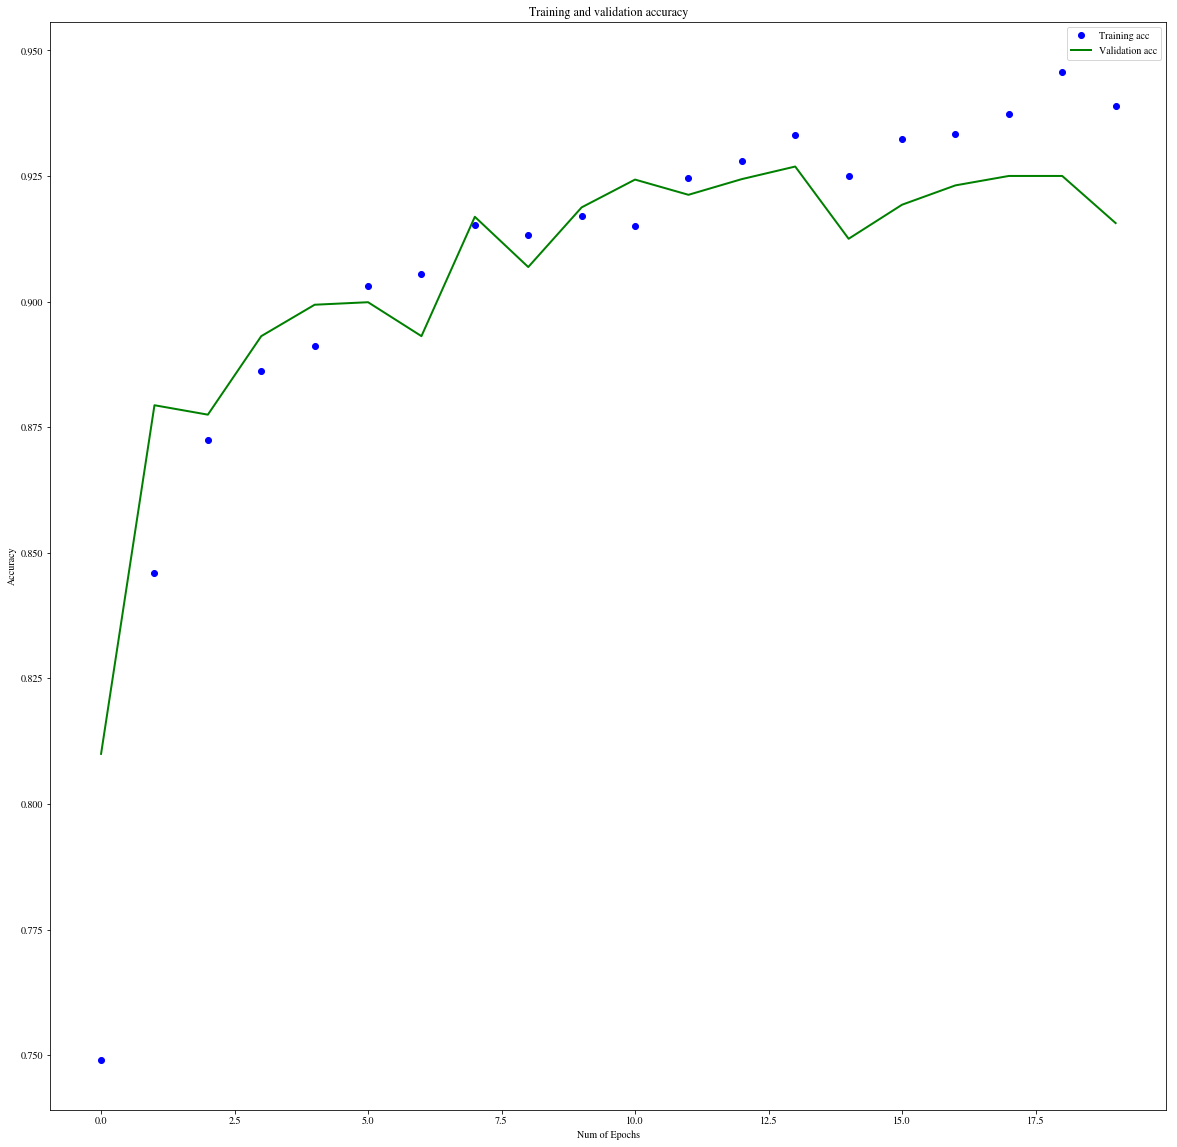

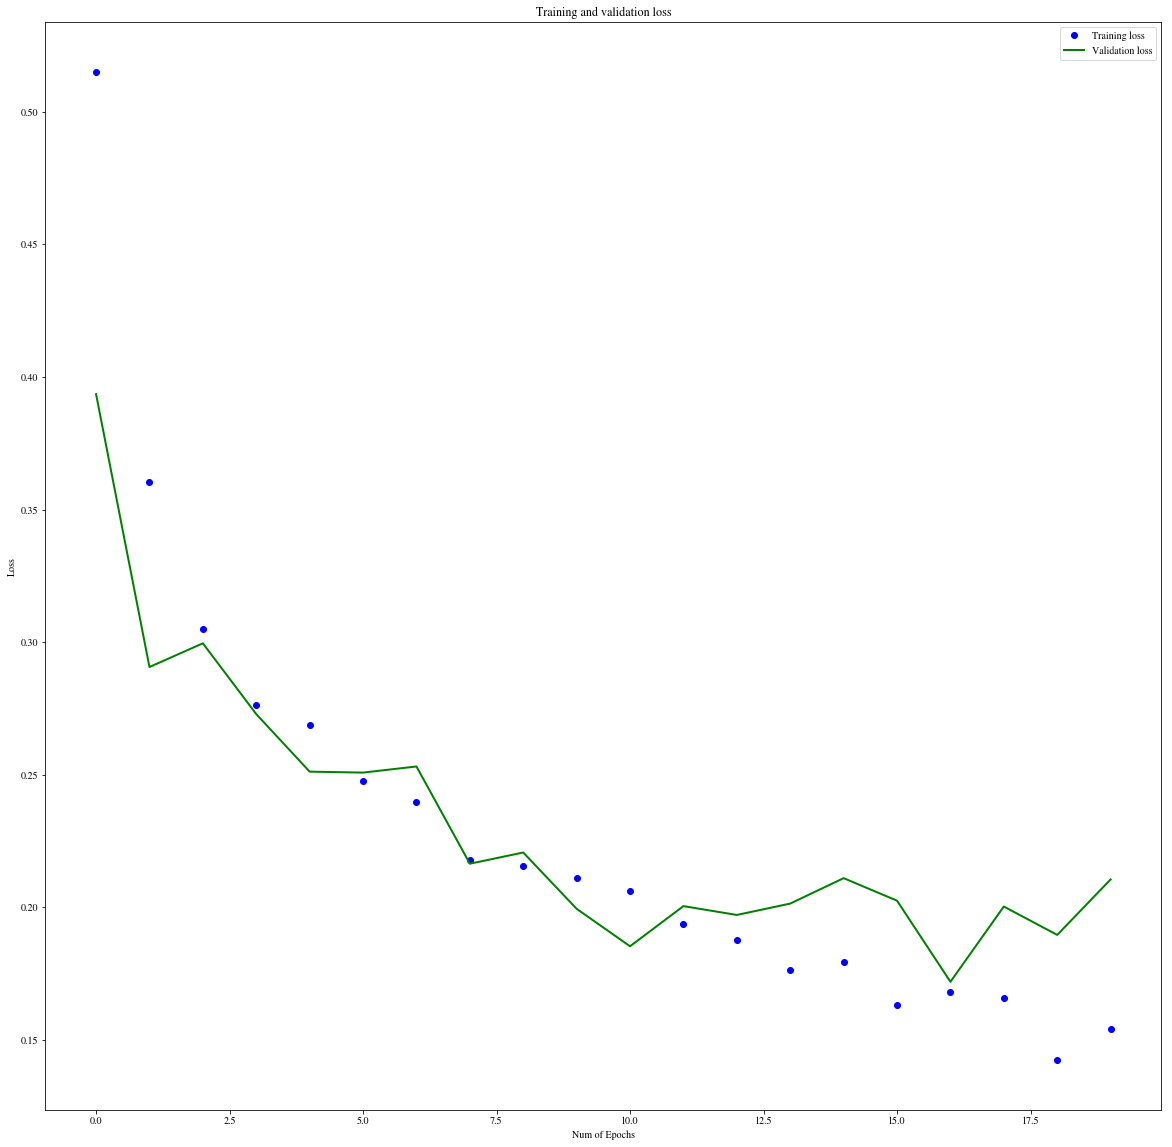

Found 16315 images belonging to 2 classes.
data batch shape: (128, 64, 64, 3)
labels batch shape: (128,)
Epoch 1/20
100/100 [==============================] - 24s 236ms/step - loss: 0.5499 - acc: 0.7256 - val_loss: 0.3853 - val_acc: 0.8331
Epoch 2/20
100/100 [==============================] - 19s 185ms/step - loss: 0.3744 - acc: 0.8401 - val_loss: 0.3074 - val_acc: 0.8762
Epoch 3/20
100/100 [==============================] - 18s 178ms/step - loss: 0.3141 - acc: 0.8689 - val_loss: 0.2707 - val_acc: 0.8869
Epoch 4/20
100/100 [==============================] - 17s 172ms/step - loss: 0.2948 - acc: 0.8753 - val_loss: 0.2475 - val_acc: 0.9006
Epoch 5/20
100/100 [==============================] - 18s 185ms/step - loss: 0.2542 - acc: 0.8998 - val_loss: 0.2645 - val_acc: 0.8944
Epoch 6/20
100/100 [==============================] - 17s 170ms/step - loss: 0.2453 - acc: 0.9035 - val_loss: 0.2024 - val_acc: 0.9130
Epoch 7/20
100/100 [==============================] - 17s 173ms/step - loss: 0.2228 -

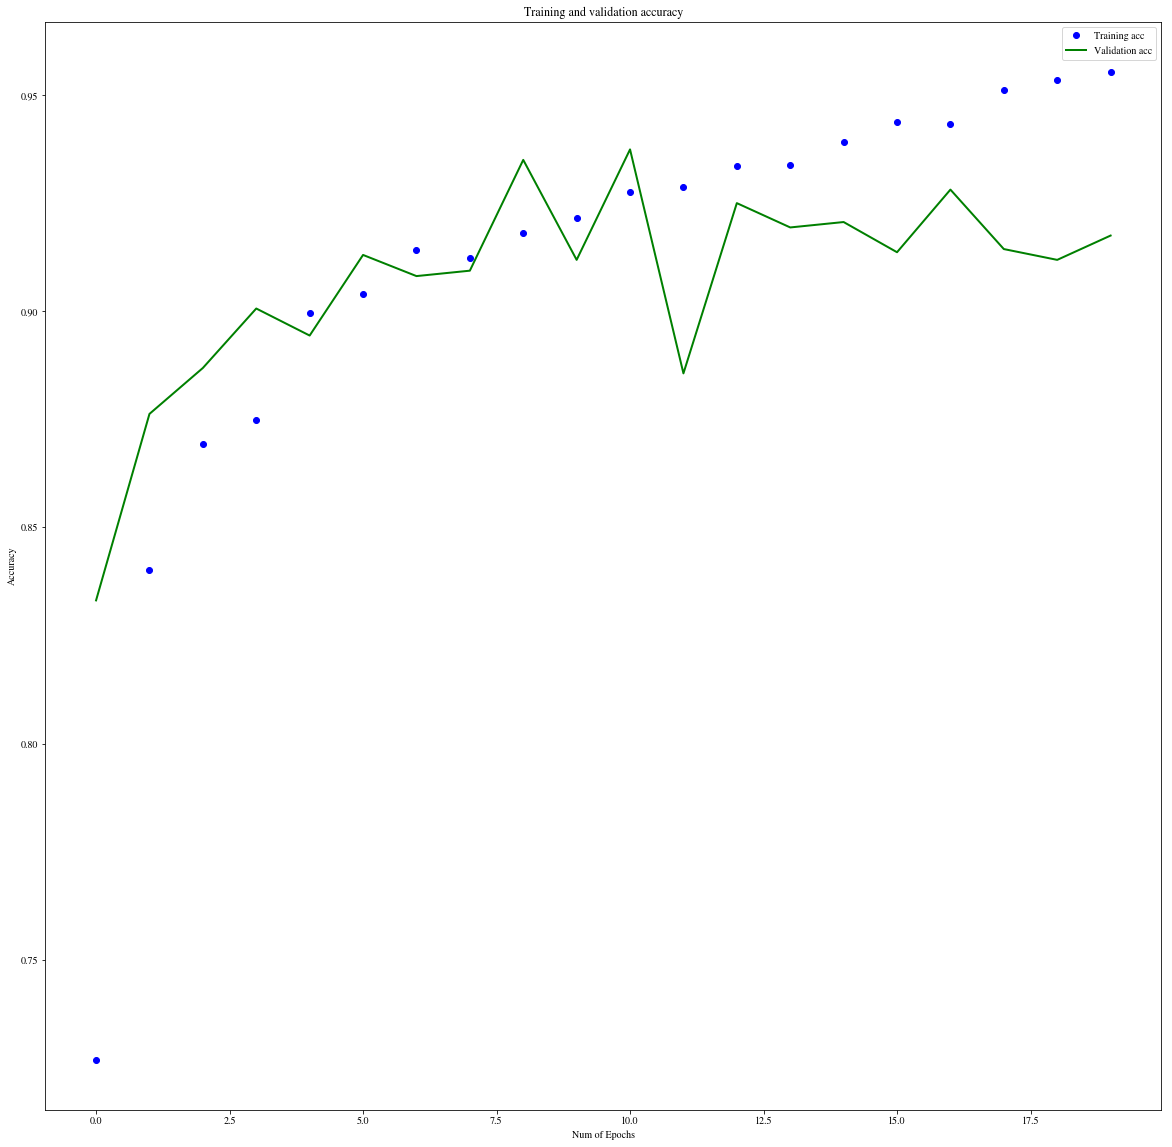

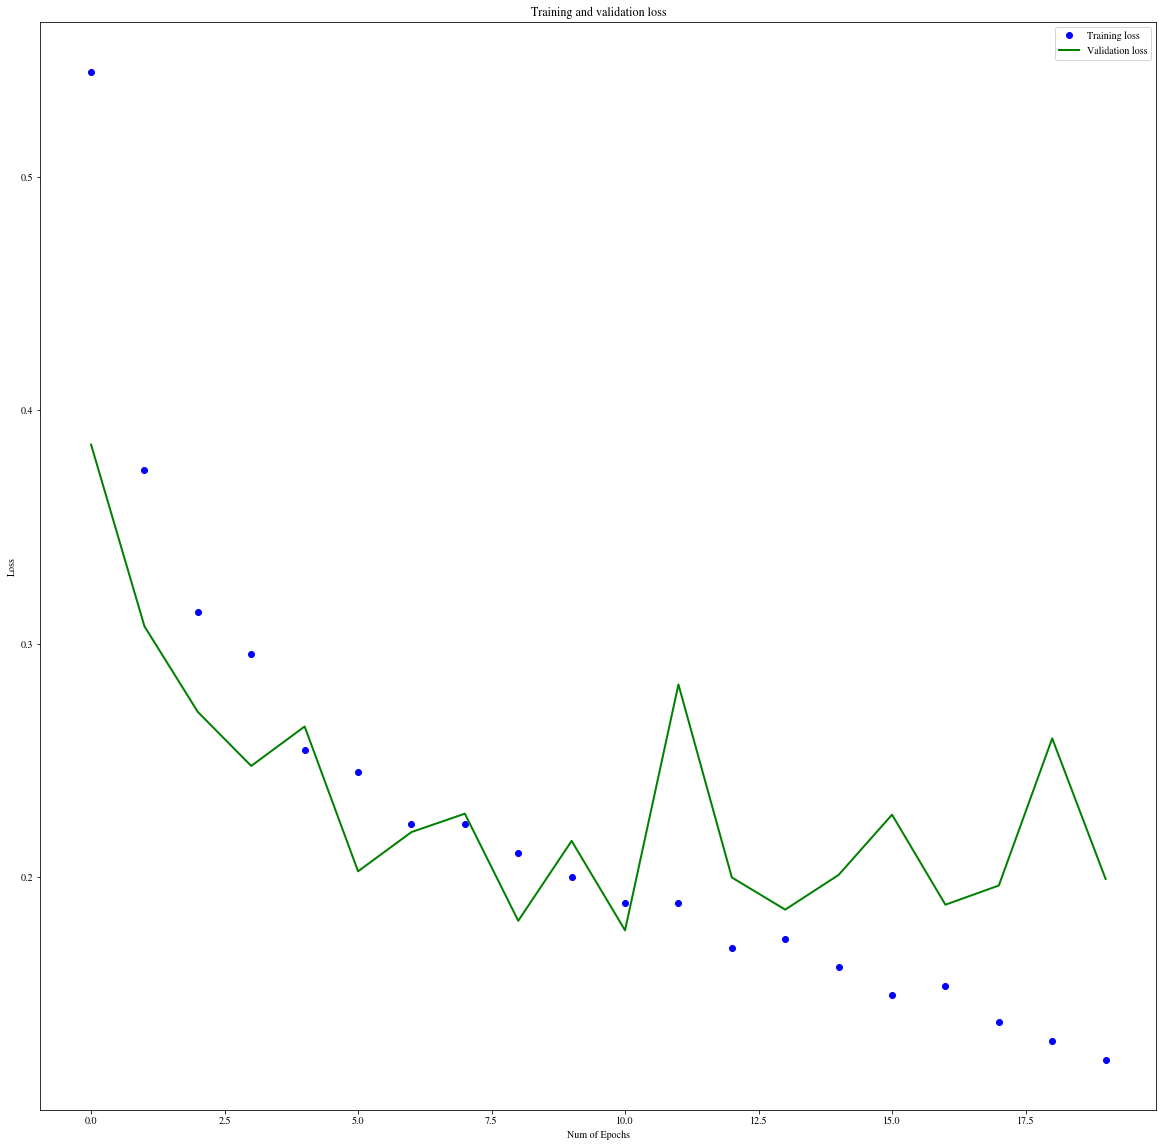

Found 16315 images belonging to 2 classes.
data batch shape: (256, 64, 64, 3)
labels batch shape: (256,)
Epoch 1/20
100/100 [==============================] - 32s 321ms/step - loss: 0.4963 - acc: 0.7649 - val_loss: 0.4189 - val_acc: 0.7994
Epoch 2/20
100/100 [==============================] - 33s 329ms/step - loss: 0.3460 - acc: 0.8538 - val_loss: 0.2948 - val_acc: 0.8725
Epoch 3/20
100/100 [==============================] - 34s 339ms/step - loss: 0.2971 - acc: 0.8809 - val_loss: 0.2444 - val_acc: 0.8969
Epoch 4/20
100/100 [==============================] - 34s 336ms/step - loss: 0.2707 - acc: 0.8940 - val_loss: 0.2473 - val_acc: 0.9025
Epoch 5/20
100/100 [==============================] - 34s 339ms/step - loss: 0.2452 - acc: 0.9053 - val_loss: 0.2635 - val_acc: 0.8969
Epoch 6/20
100/100 [==============================] - 34s 339ms/step - loss: 0.2365 - acc: 0.9082 - val_loss: 0.2221 - val_acc: 0.9118
Epoch 7/20
100/100 [==============================] - 33s 330ms/step - loss: 0.2295 -

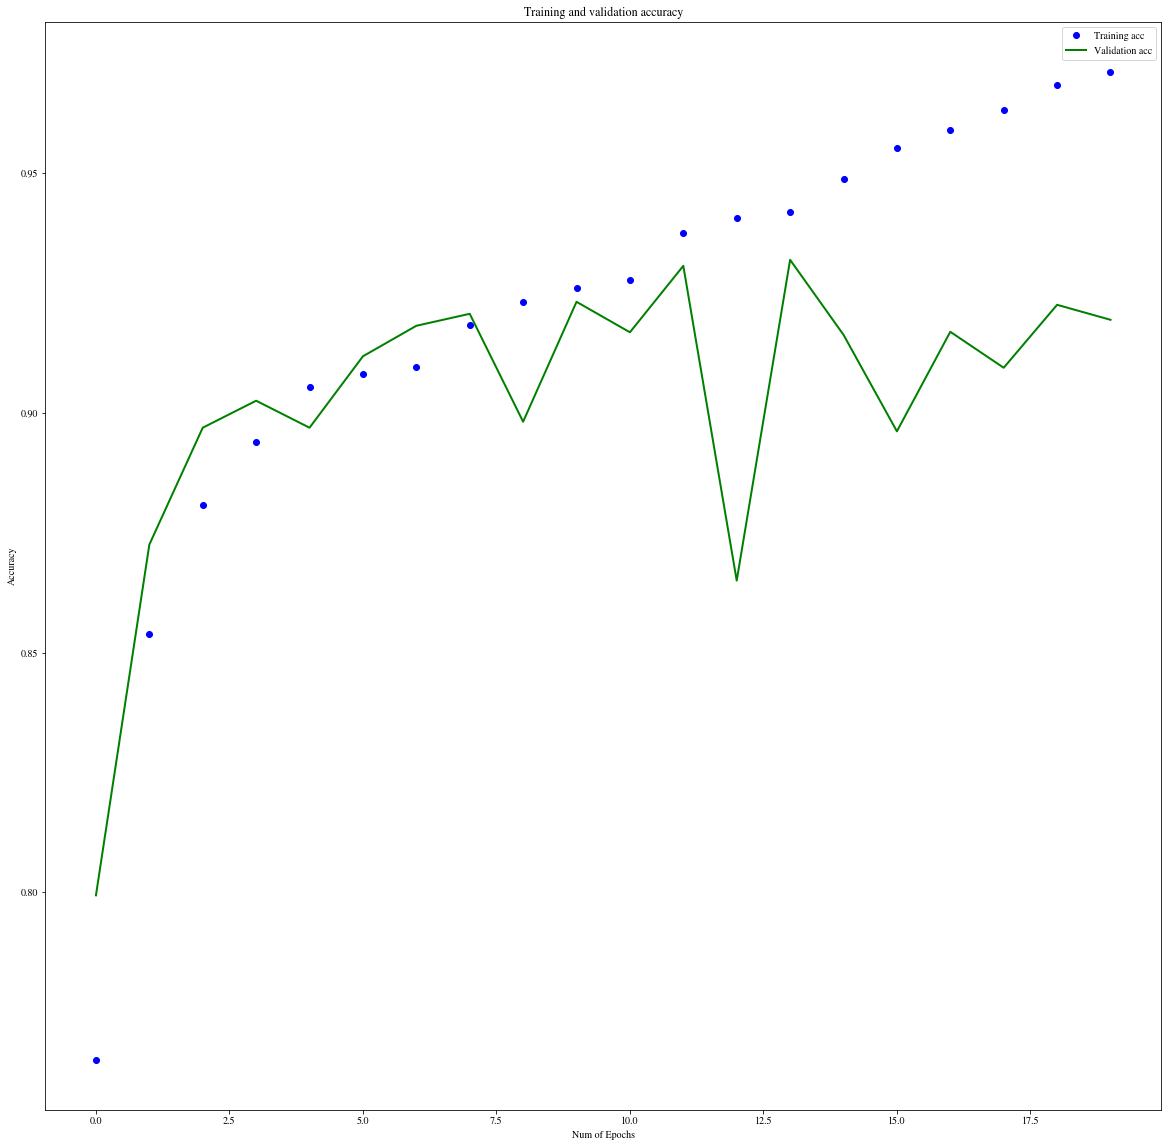

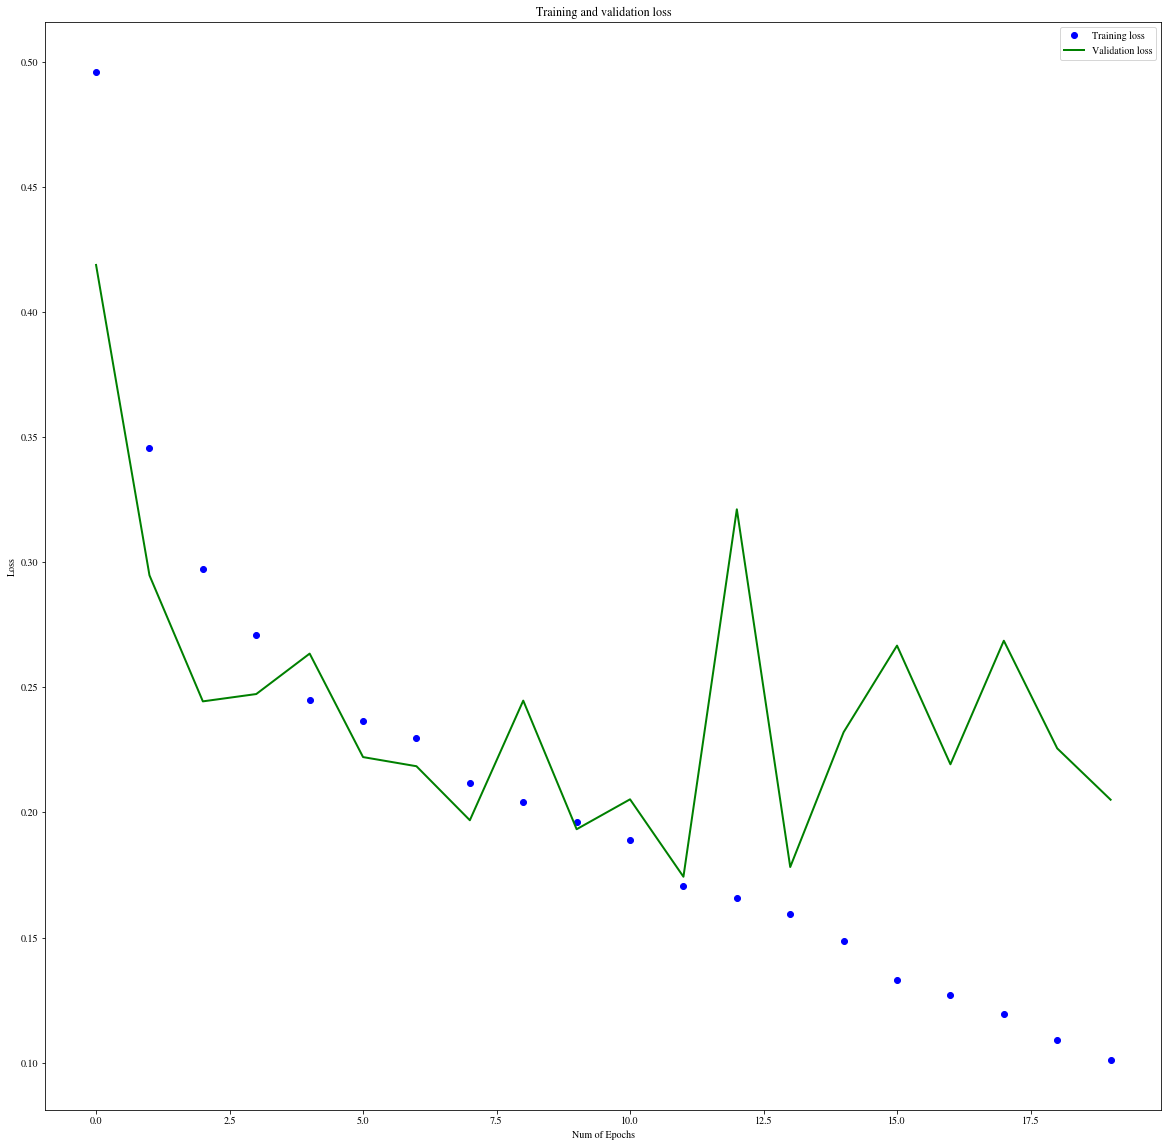

In [10]:
CNN_Parameter_Tuning_1('relu', 'sigmoid')

#### 3.3.2 Parameter Tuning -- Determine the Optimal Learning Rate
<span style="color:blue">
The optimal CNN model for the iamge dataset obtained in Part 1 and Part 2 will be used in this Part 3. We will try different  learning_rate: 0.1, 0.5, 1, 5, and 10. 
</span>

In [11]:
def CNN_Parameter_Tuning_2 (activation_function_1, activation_function_2):
        
    K.clear_session()
    
    batch_size = 16
    
    train_generator_new = train_datagen.flow_from_directory(
            train_dir,
            target_size=(64, 64),
            batch_size = batch_size,
            class_mode='binary')
    
    learning_rate = [0.1, 0.5, 1, 5, 10]

    model = [0] * 5
    
    for j in range(0, 5):
        
        Adadelta = optimizers.Adadelta(lr=learning_rate[j], rho=0.95, epsilon=None, decay=0.0)
        
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(16, kernel_initializer='glorot_uniform', activation=activation_function_1, 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc1'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc2'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].compile(loss='binary_crossentropy', optimizer = Adadelta, metrics=['accuracy'])
        
        # Fit the model        
        history = model[j].fit_generator(
        train_generator_new,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('learning rate:', learning_rate[j])
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()

Found 16315 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 11s 105ms/step - loss: 0.6210 - acc: 0.6694 - val_loss: 0.5831 - val_acc: 0.6825
Epoch 2/20
100/100 [==============================] - 10s 99ms/step - loss: 0.4925 - acc: 0.7841 - val_loss: 0.4527 - val_acc: 0.7875
Epoch 3/20
100/100 [==============================] - 9s 86ms/step - loss: 0.4310 - acc: 0.7987 - val_loss: 0.4124 - val_acc: 0.8213s - loss: 0.4342 - acc
Epoch 4/20
100/100 [==============================] - 8s 83ms/step - loss: 0.4134 - acc: 0.7969 - val_loss: 0.3830 - val_acc: 0.8275
Epoch 5/20
100/100 [==============================] - 10s 105ms/step - loss: 0.3672 - acc: 0.8400 - val_loss: 0.3554 - val_acc: 0.8319
Epoch 6/20
100/100 [==============================] - 10s 96ms/step - loss: 0.3758 - acc: 0.8312 - val_loss: 0.3354 - val_acc: 0.8642
Epoch 7/20
100/100 [==============================] - 11s 110ms/step - loss: 0.3607 - acc: 0.8450 - val_loss: 0.3275 - val_acc: 0.8

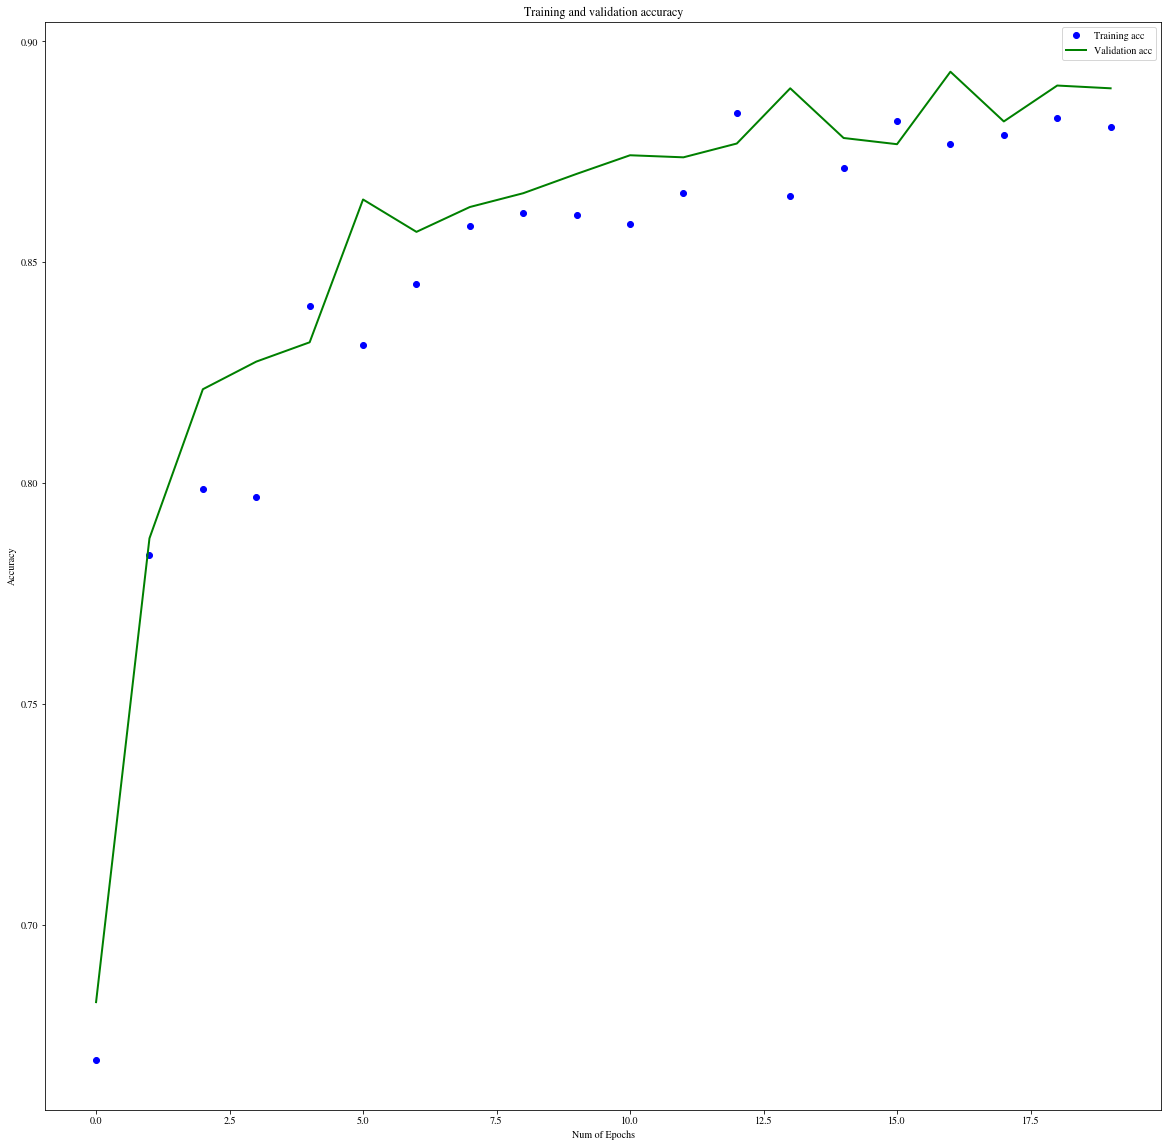

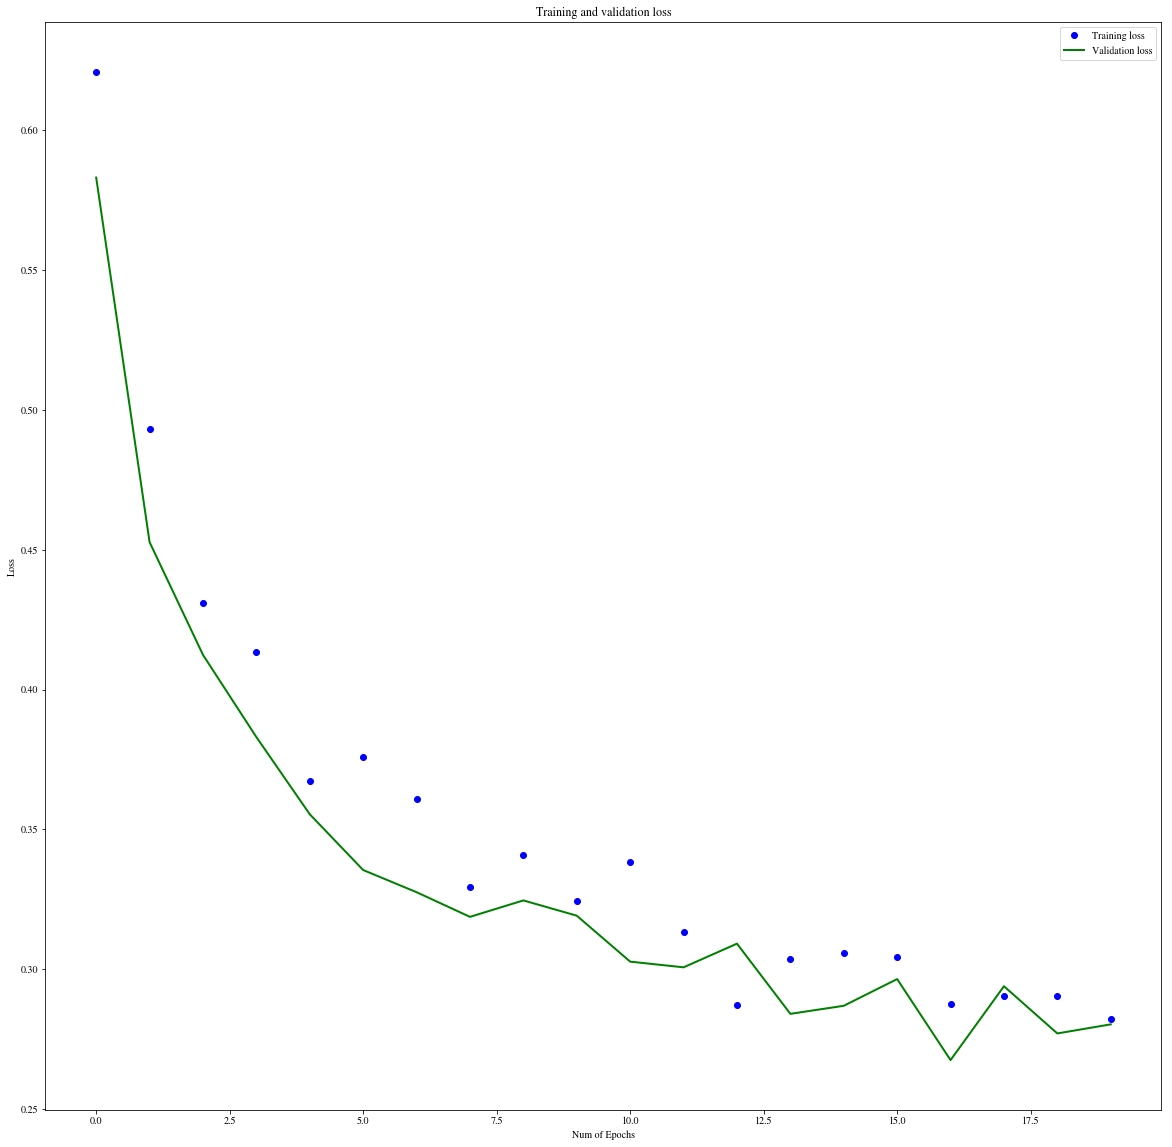

Epoch 1/20
100/100 [==============================] - 9s 92ms/step - loss: 0.5743 - acc: 0.7119 - val_loss: 0.4349 - val_acc: 0.7981
Epoch 2/20
100/100 [==============================] - 7s 73ms/step - loss: 0.4250 - acc: 0.8117 - val_loss: 0.3788 - val_acc: 0.8387
Epoch 3/20
100/100 [==============================] - 10s 103ms/step - loss: 0.3968 - acc: 0.8275 - val_loss: 0.4212 - val_acc: 0.8237
Epoch 4/20
100/100 [==============================] - 9s 91ms/step - loss: 0.3656 - acc: 0.8400 - val_loss: 0.3335 - val_acc: 0.8550
Epoch 5/20
100/100 [==============================] - 8s 84ms/step - loss: 0.3588 - acc: 0.8456 - val_loss: 0.3254 - val_acc: 0.8625
Epoch 6/20
100/100 [==============================] - 8s 83ms/step - loss: 0.3336 - acc: 0.8662 - val_loss: 0.2956 - val_acc: 0.8736
Epoch 7/20
100/100 [==============================] - 7s 71ms/step - loss: 0.3116 - acc: 0.8738 - val_loss: 0.3290 - val_acc: 0.8638oss: 0.3122 - acc: 0.87
Epoch 8/20
100/100 [========================

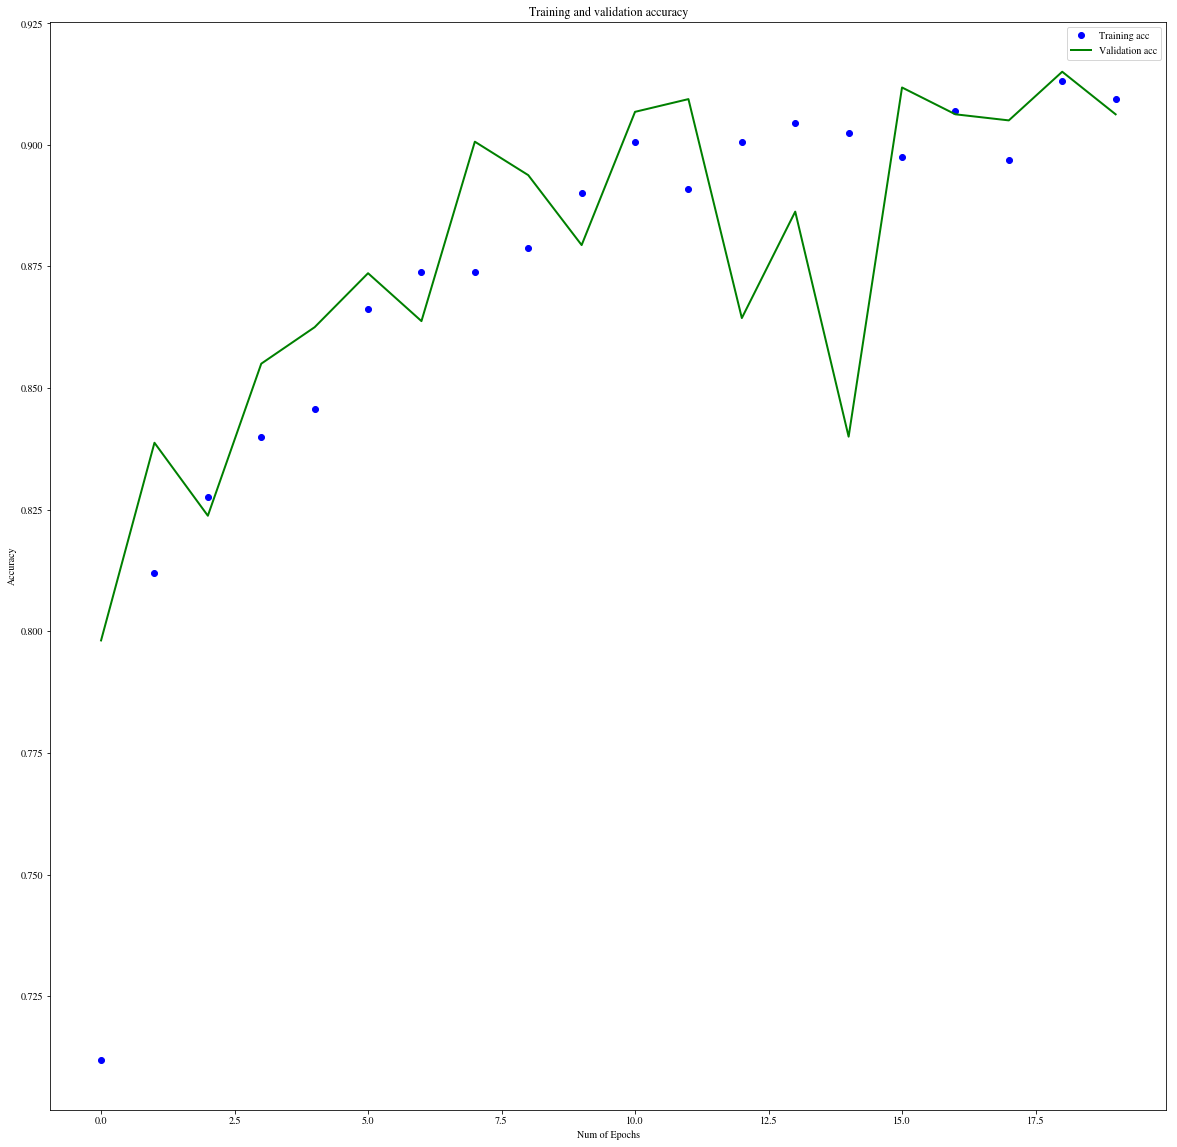

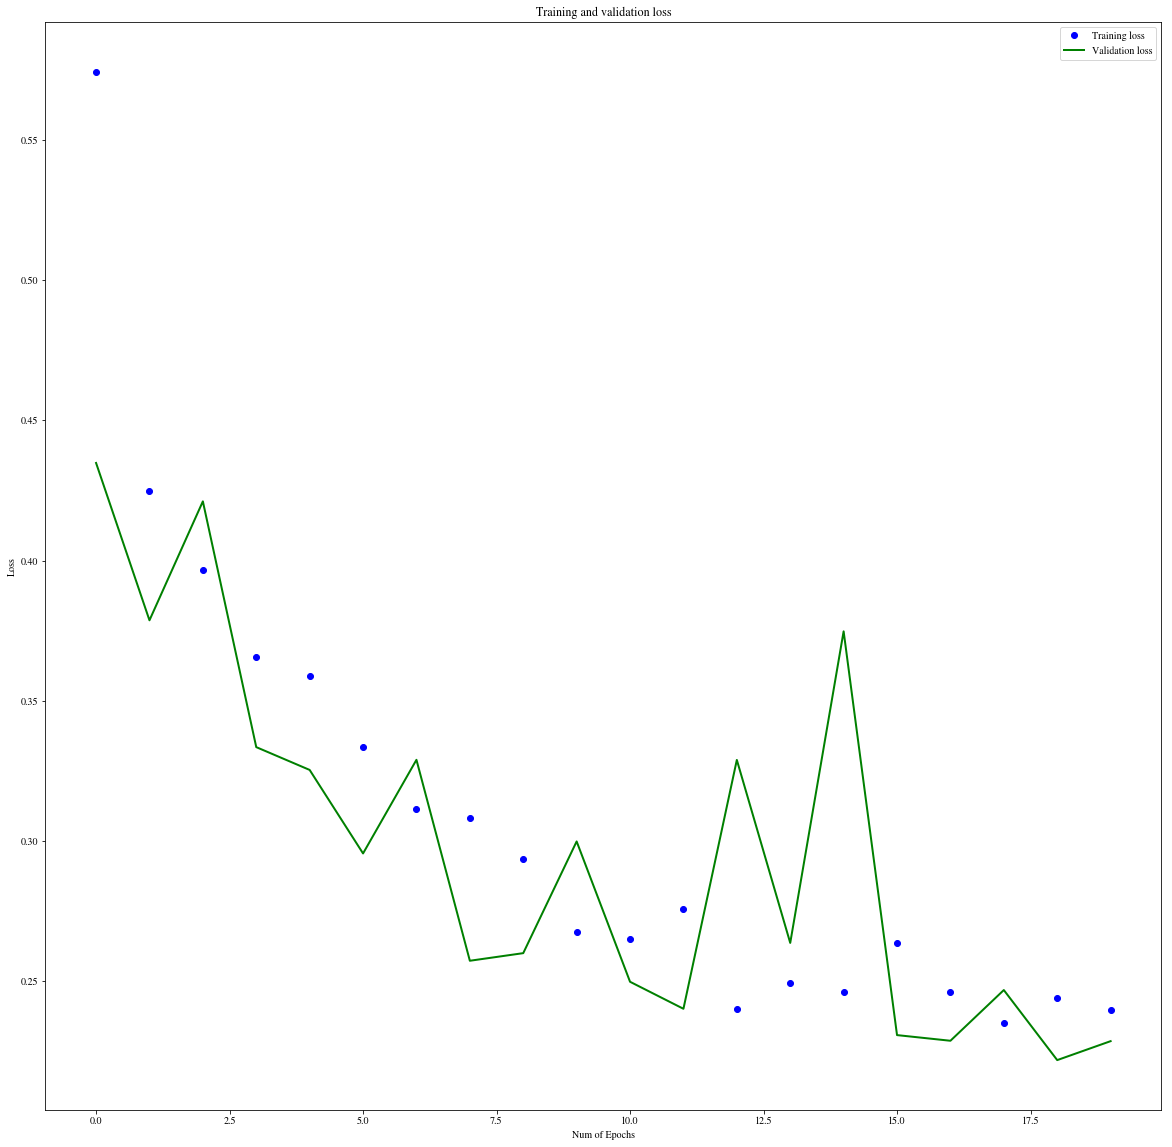

Epoch 1/20
100/100 [==============================] - 12s 120ms/step - loss: 0.5498 - acc: 0.7262 - val_loss: 0.4034 - val_acc: 0.8063
Epoch 2/20
100/100 [==============================] - 11s 105ms/step - loss: 0.4390 - acc: 0.8000 - val_loss: 0.3684 - val_acc: 0.8375
Epoch 3/20
100/100 [==============================] - 10s 96ms/step - loss: 0.3525 - acc: 0.8563 - val_loss: 0.4210 - val_acc: 0.8187 - loss: 0.3529 - ETA: 0s - loss: 0.3544 - acc: 0.85
Epoch 4/20
100/100 [==============================] - 14s 135ms/step - loss: 0.3501 - acc: 0.8462 - val_loss: 0.2879 - val_acc: 0.8881 1s - loss: 0.3459 - 
Epoch 5/20
100/100 [==============================] - 17s 173ms/step - loss: 0.2988 - acc: 0.8719 - val_loss: 0.3141 - val_acc: 0.8725
Epoch 6/20
100/100 [==============================] - 16s 160ms/step - loss: 0.3086 - acc: 0.8662 - val_loss: 0.3246 - val_acc: 0.8655-
Epoch 7/20
100/100 [==============================] - 12s 125ms/step - loss: 0.2990 - acc: 0.8750 - val_loss: 0.3323 

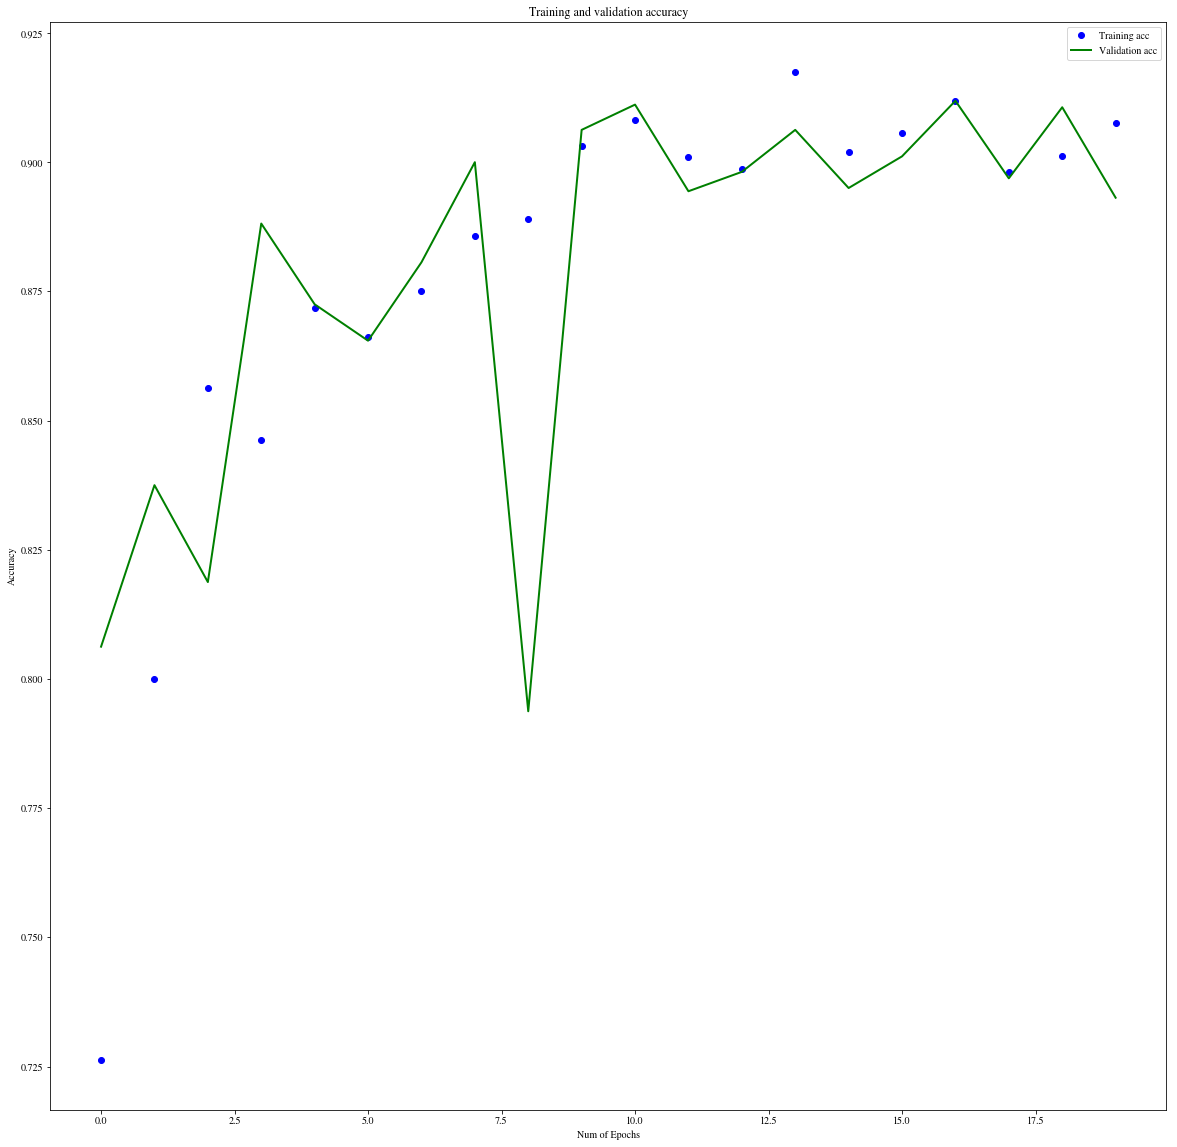

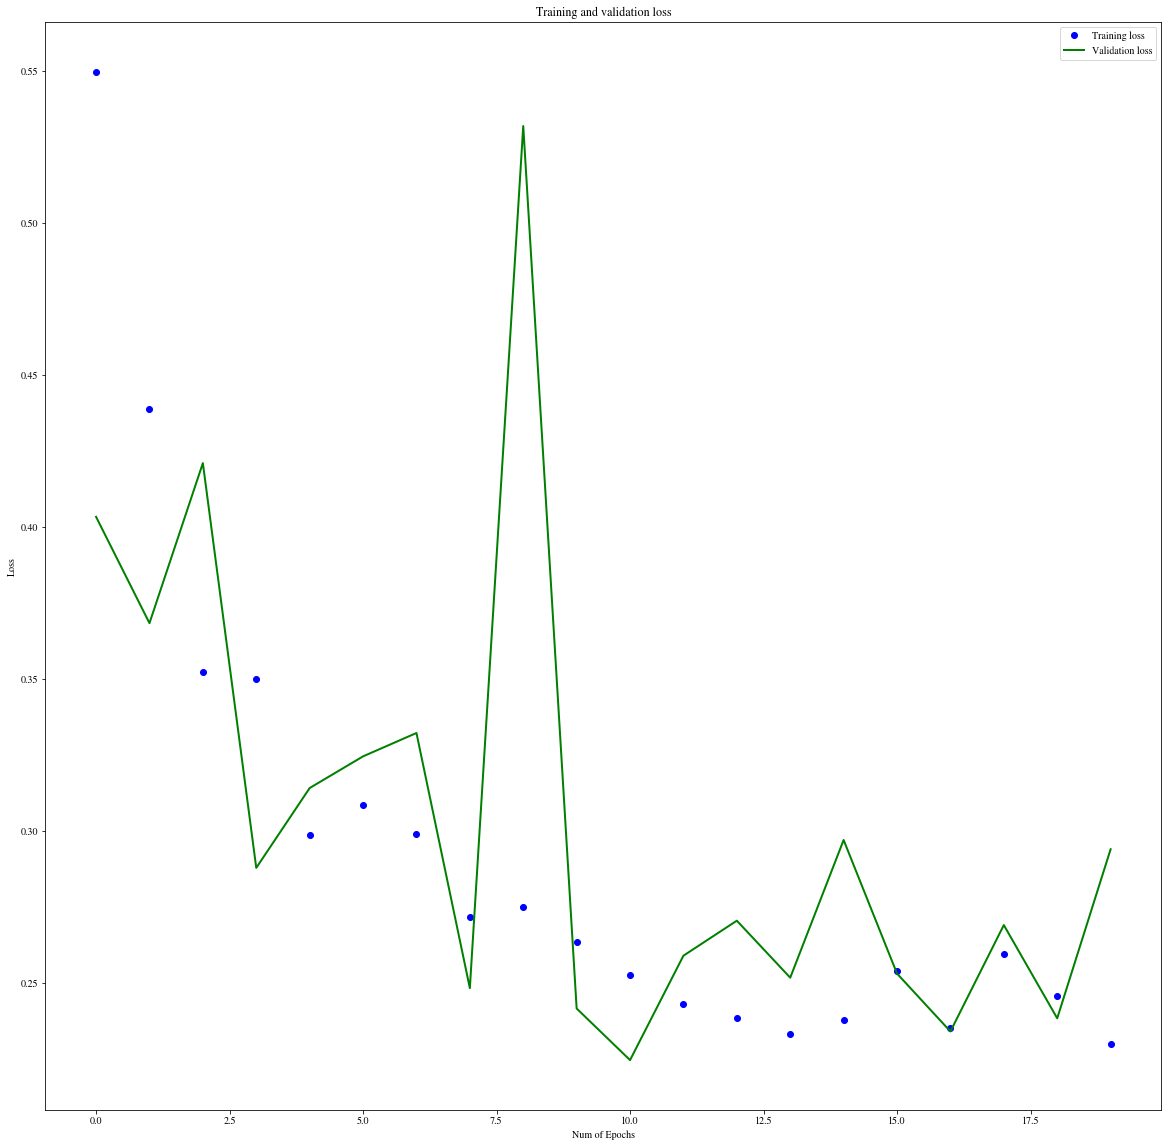

Epoch 1/20
100/100 [==============================] - 12s 116ms/step - loss: 0.6760 - acc: 0.6162 - val_loss: 0.5791 - val_acc: 0.7550
Epoch 2/20
100/100 [==============================] - 10s 105ms/step - loss: 0.5642 - acc: 0.7319 - val_loss: 0.5029 - val_acc: 0.7919s - loss: 0.5663
Epoch 3/20
100/100 [==============================] - 11s 112ms/step - loss: 0.4861 - acc: 0.7981 - val_loss: 0.5526 - val_acc: 0.7788
Epoch 4/20
100/100 [==============================] - 9s 95ms/step - loss: 0.4538 - acc: 0.8200 - val_loss: 0.4201 - val_acc: 0.8300
Epoch 5/20
100/100 [==============================] - 10s 103ms/step - loss: 0.4333 - acc: 0.8269 - val_loss: 0.3880 - val_acc: 0.8444
Epoch 6/20
100/100 [==============================] - 11s 106ms/step - loss: 0.3736 - acc: 0.8469 - val_loss: 0.4187 - val_acc: 0.8129
Epoch 7/20
100/100 [==============================] - 10s 104ms/step - loss: 0.3960 - acc: 0.8500 - val_loss: 0.3355 - val_acc: 0.8731
Epoch 8/20
100/100 [=====================

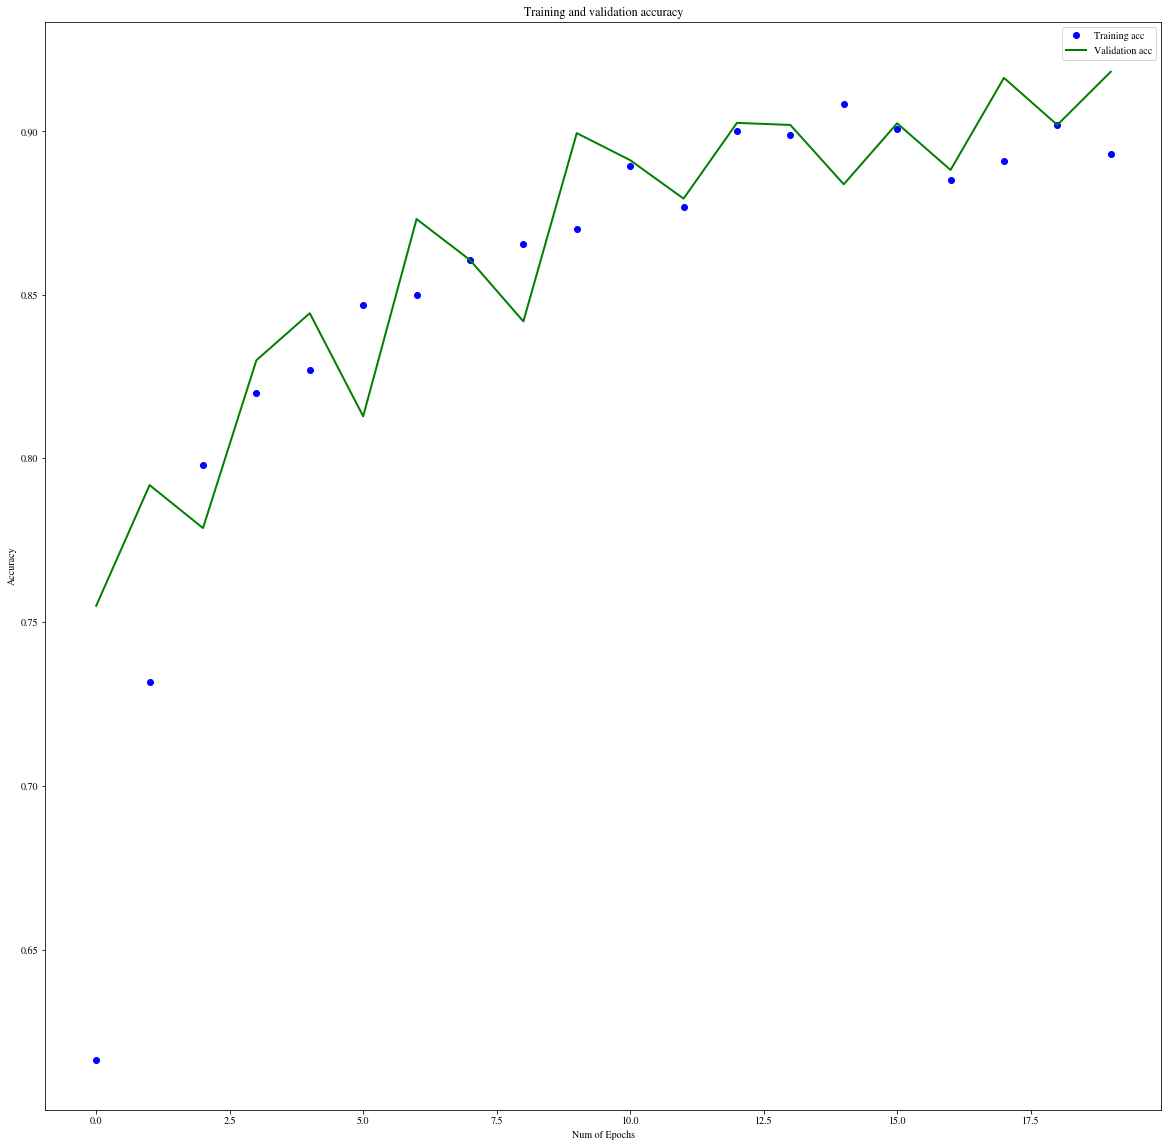

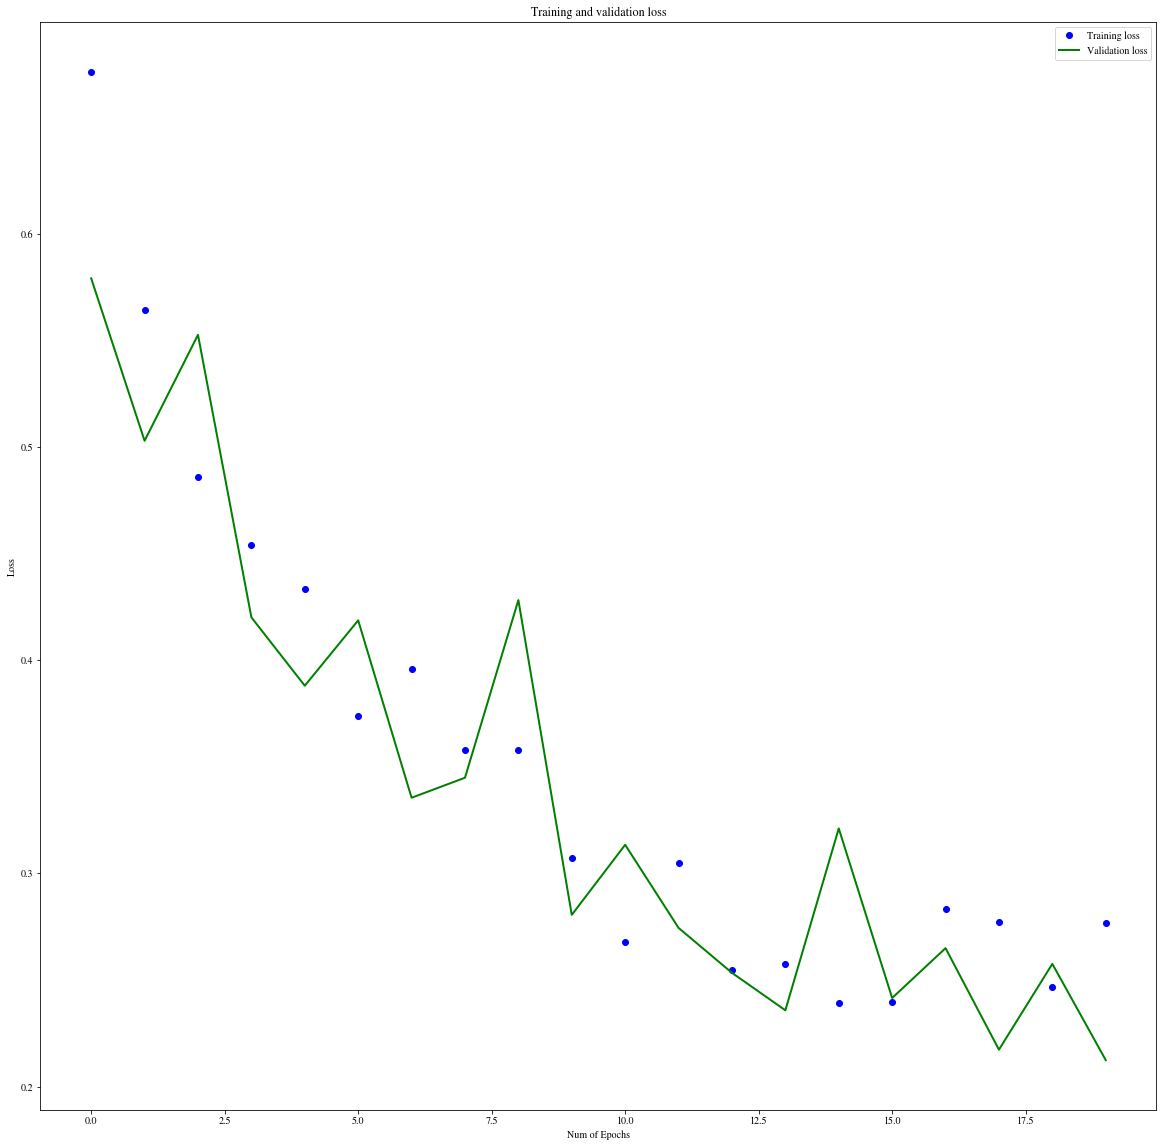

Epoch 1/20
100/100 [==============================] - 11s 105ms/step - loss: 0.7994 - acc: 0.5000 - val_loss: 0.6915 - val_acc: 0.5387
Epoch 2/20
100/100 [==============================] - 10s 102ms/step - loss: 0.6915 - acc: 0.5363 - val_loss: 0.6942 - val_acc: 0.5169
Epoch 3/20
100/100 [==============================] - 9s 86ms/step - loss: 0.6907 - acc: 0.5406 - val_loss: 0.6956 - val_acc: 0.5031
Epoch 4/20
100/100 [==============================] - 8s 84ms/step - loss: 0.6930 - acc: 0.5244 - val_loss: 0.6940 - val_acc: 0.5088A: 0s - loss: 0.6930 - acc: 0.5
Epoch 5/20
100/100 [==============================] - 9s 91ms/step - loss: 0.6904 - acc: 0.5450 - val_loss: 0.6939 - val_acc: 0.5244
Epoch 6/20
100/100 [==============================] - 8s 84ms/step - loss: 0.6933 - acc: 0.5240 - val_loss: 0.6928 - val_acc: 0.5207
Epoch 7/20
100/100 [==============================] - 9s 89ms/step - loss: 0.6911 - acc: 0.5400 - val_loss: 0.6916 - val_acc: 0.5331
Epoch 8/20
100/100 [==============

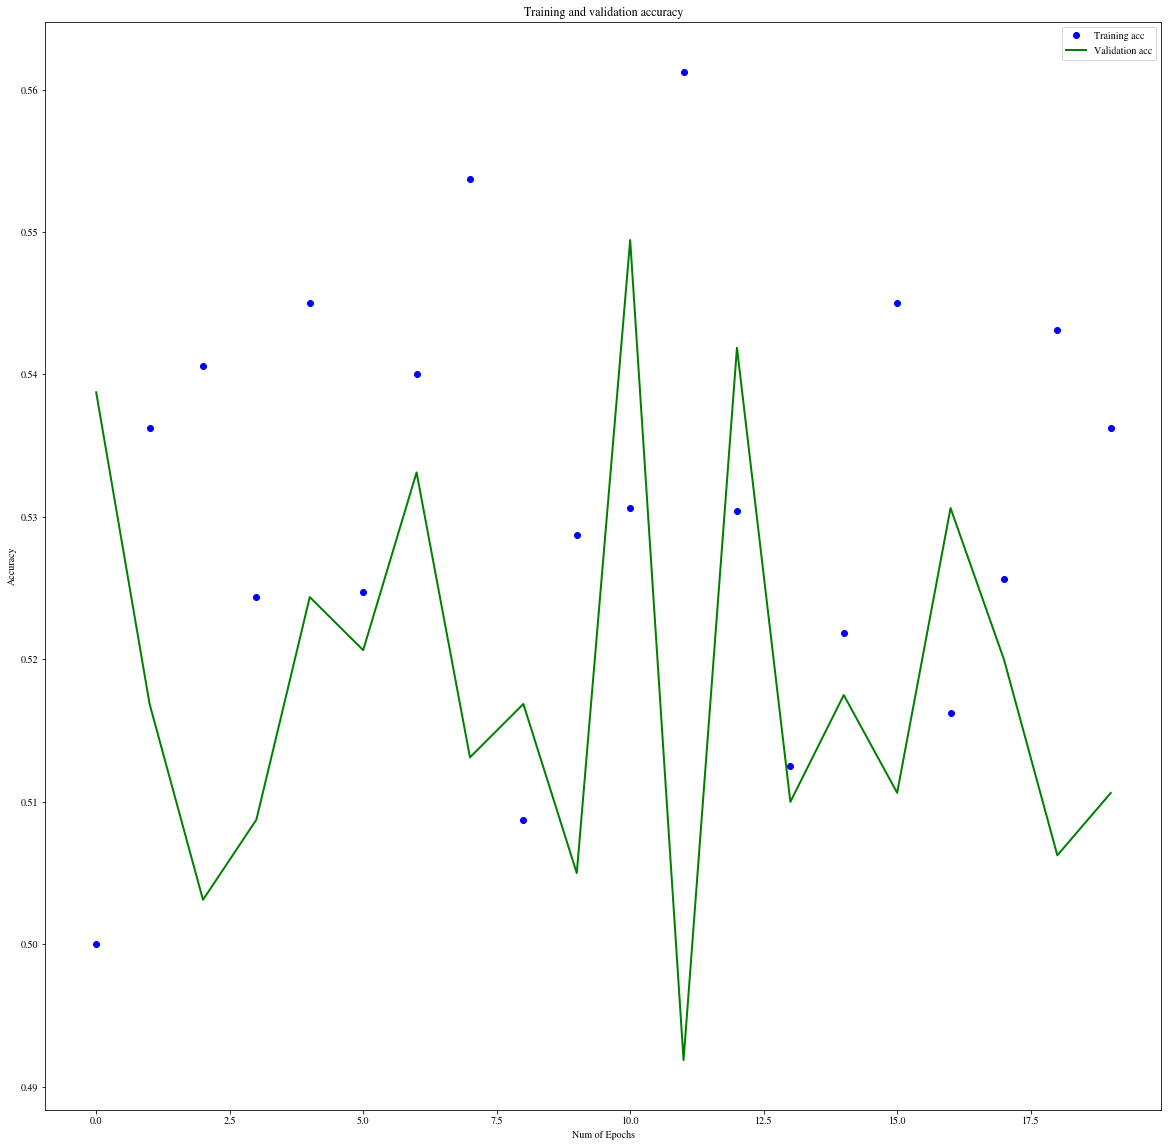

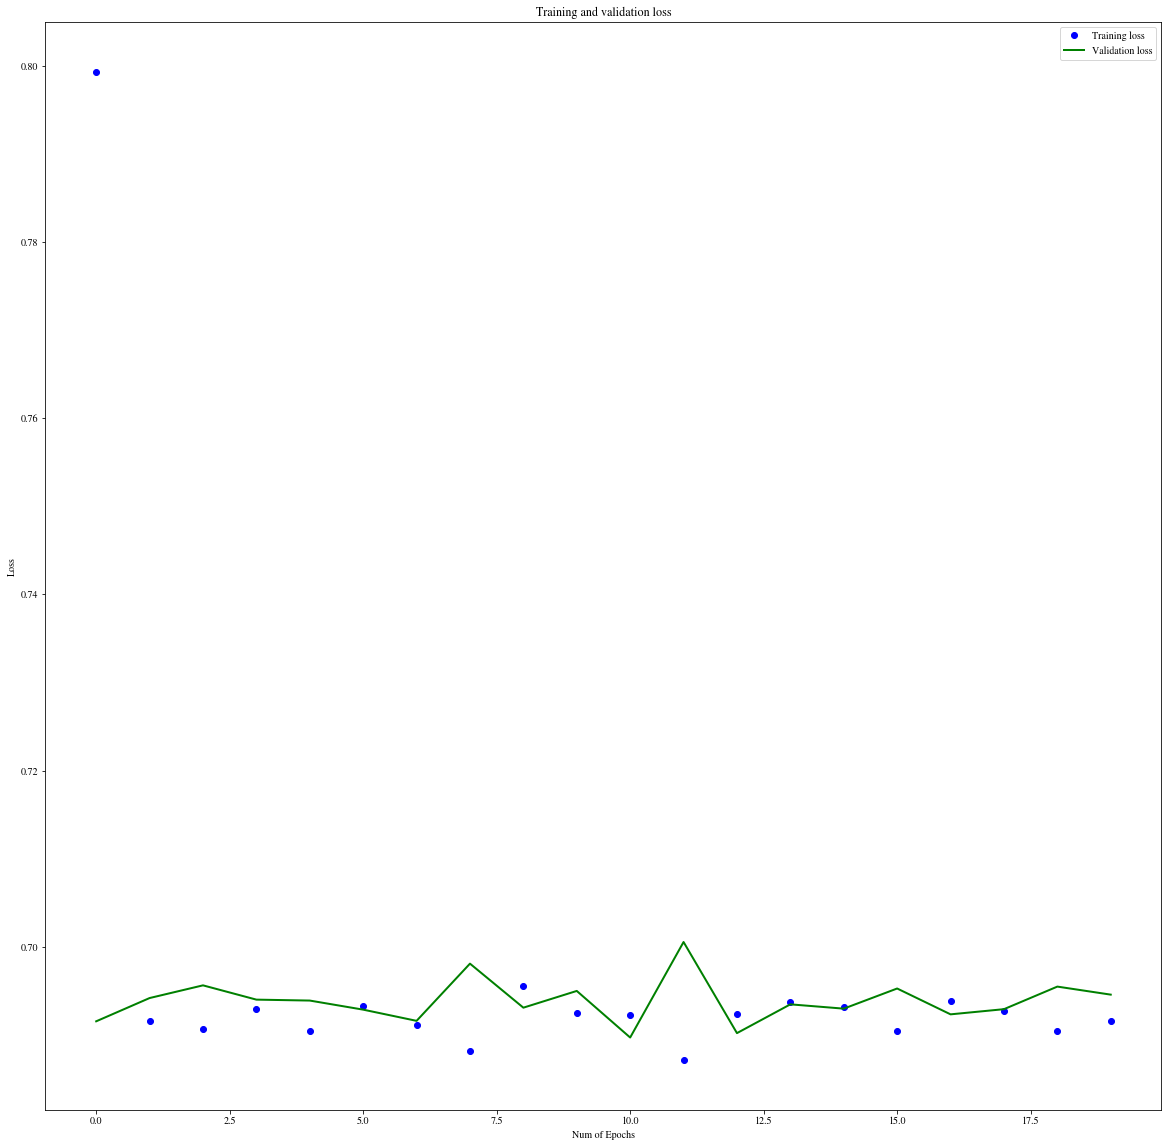

In [12]:
CNN_Parameter_Tuning_2('relu', 'sigmoid')

#### 3.3.3 Parameter Tuning -- Determine the Adadelta Decay Factor
<span style="color:blue">
The optimal CNN model for the iamge dataset obtained in Part 1 and Part 2 will be used. We will try different decay factor (i.e., the fraction of gradient to keep at each time step), including 0, 0.1, 0.5, 0.9, and 1.
</span>

In [16]:
def CNN_Parameter_Tuning_3 (activation_function_1, activation_function_2):
        
    K.clear_session()
    
    decay_factor = [0, 0.1, 0.5, 0.9, 1]

    model = [0] * 5
    
    for j in range(0, 5):
        
        Adadelta = optimizers.Adadelta(lr=0.1, rho = decay_factor[j], epsilon=None, decay=0.0)
        
        model[j] = models.Sequential()
        model[j].add(layers.Conv2D(16, (3, 3), padding='same', activation=activation_function_1,
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool1'))
        model[j].add(layers.Conv2D(32, (3, 3), padding='same', activation=activation_function_1, name = 'conv2'))
        model[j].add(layers.MaxPooling2D((2, 2), name='max_pool2'))
        model[j].add(layers.Flatten())

        model[j].add(layers.Dense(16, kernel_initializer='glorot_uniform', activation=activation_function_1, 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc1'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].add(layers.Dense(1, kernel_initializer='glorot_uniform', activation=activation_function_2, 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc2'))
        model[j].add(layers.Dropout(0, noise_shape=None, seed=None))
        
        model[j].compile(loss='binary_crossentropy', optimizer = Adadelta, metrics=['accuracy'])
        
        # Fit the model        
        history = model[j].fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        # callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)]
        )
        test_loss, test_acc = model[j].evaluate_generator(test_generator, steps=100)
        print('decay factor:', decay_factor[j])
        print('\ntest accuracy:', test_acc)
        print('test loss:', test_loss)
    
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
    
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'g-', label='Validation acc')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'g-', label='Validation loss')
        plt.xlabel("Num of Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()
        
        plt.show()

Epoch 1/20
100/100 [==============================] - 14s 144ms/step - loss: 0.6312 - acc: 0.6787 - val_loss: 0.5659 - val_acc: 0.7238
Epoch 2/20
100/100 [==============================] - 14s 145ms/step - loss: 0.5432 - acc: 0.7343 - val_loss: 0.5999 - val_acc: 0.6625
Epoch 3/20
100/100 [==============================] - 10s 98ms/step - loss: 0.4967 - acc: 0.7547 - val_loss: 0.4852 - val_acc: 0.7625
Epoch 4/20
100/100 [==============================] - 11s 113ms/step - loss: 0.4977 - acc: 0.7550 - val_loss: 0.4640 - val_acc: 0.7850
Epoch 5/20
100/100 [==============================] - 11s 113ms/step - loss: 0.4751 - acc: 0.7662 - val_loss: 0.3974 - val_acc: 0.8350
Epoch 6/20
100/100 [==============================] - 12s 119ms/step - loss: 0.4806 - acc: 0.7662 - val_loss: 0.4450 - val_acc: 0.7929
Epoch 7/20
100/100 [==============================] - 12s 116ms/step - loss: 0.4873 - acc: 0.7634 - val_loss: 0.4479 - val_acc: 0.7819
Epoch 8/20
100/100 [==============================] - 12

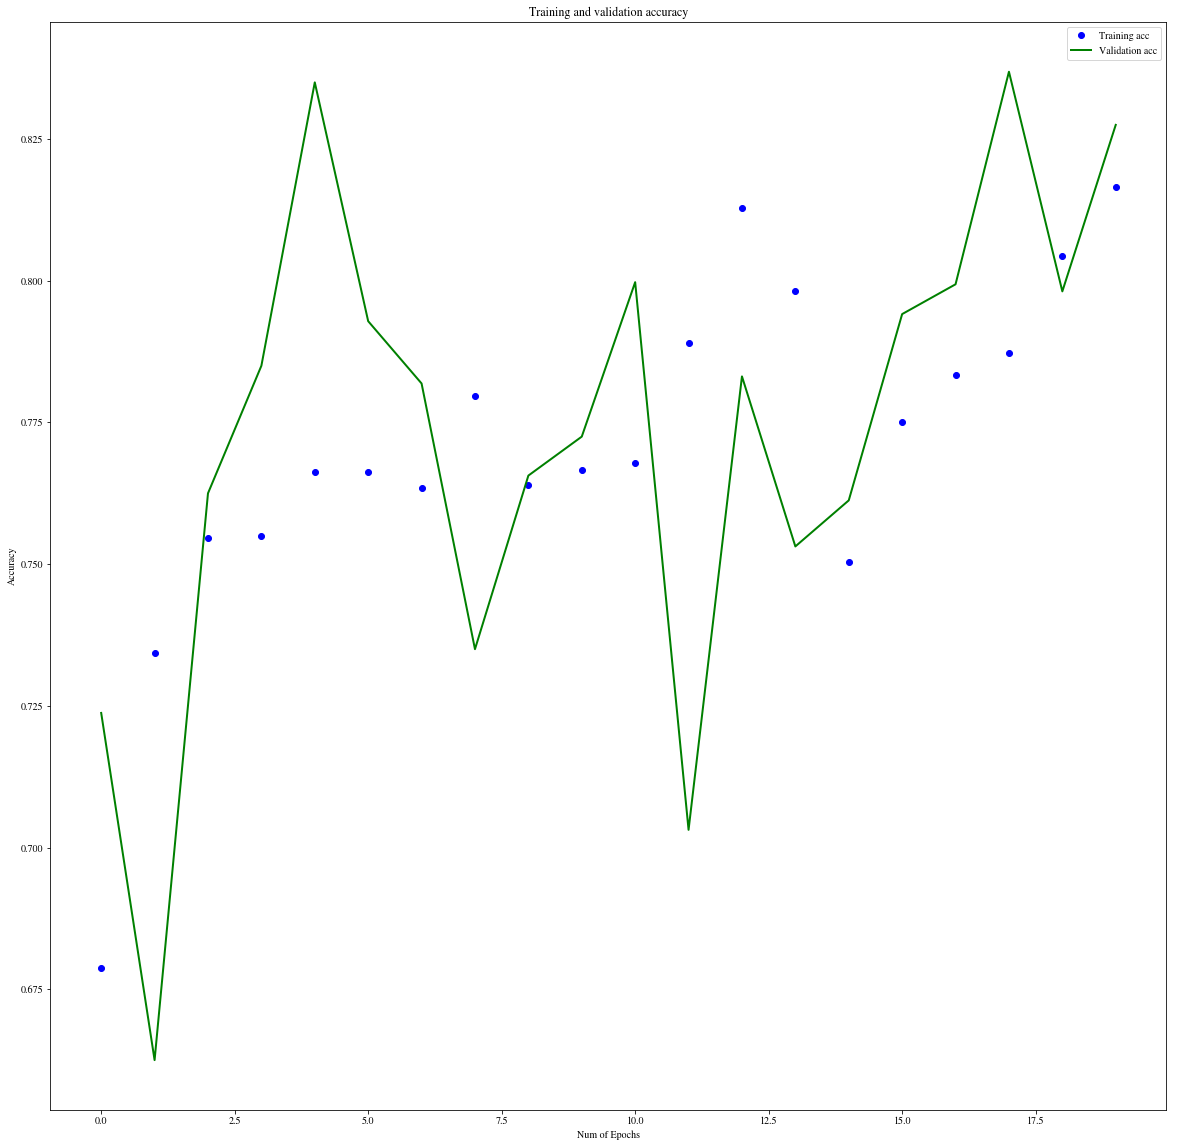

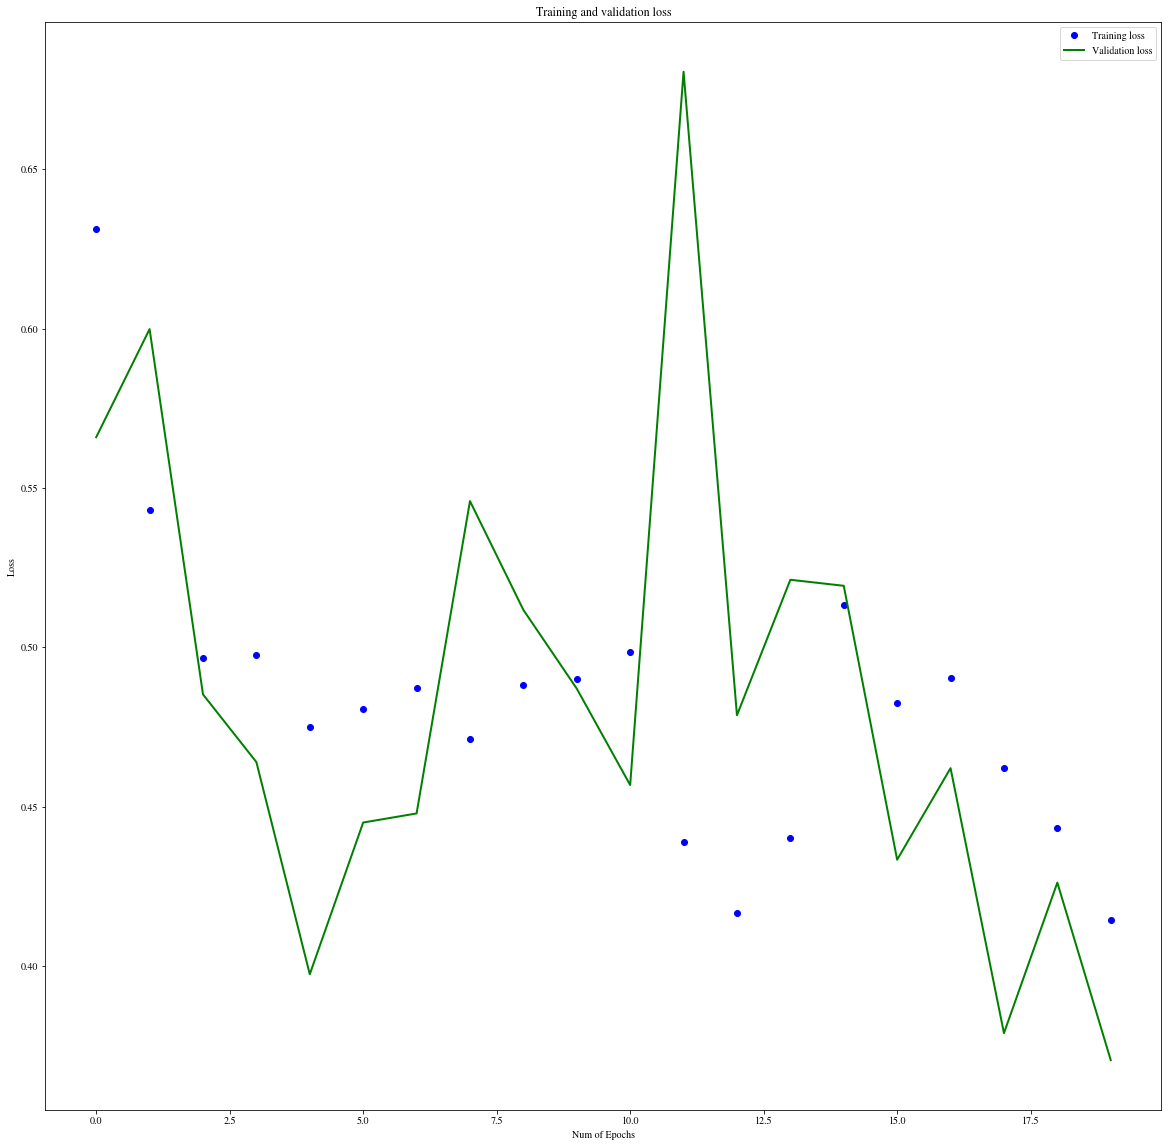

Epoch 1/20
100/100 [==============================] - 10s 96ms/step - loss: 0.6364 - acc: 0.6850 - val_loss: 0.5871 - val_acc: 0.7400
Epoch 2/20
100/100 [==============================] - 8s 85ms/step - loss: 0.5485 - acc: 0.7528 - val_loss: 0.5071 - val_acc: 0.7825
Epoch 3/20
100/100 [==============================] - 8s 80ms/step - loss: 0.4978 - acc: 0.7740 - val_loss: 0.4720 - val_acc: 0.7788
Epoch 4/20
100/100 [==============================] - 8s 77ms/step - loss: 0.4547 - acc: 0.7931 - val_loss: 0.4403 - val_acc: 0.8044505 - acc: 
Epoch 5/20
100/100 [==============================] - 8s 81ms/step - loss: 0.4414 - acc: 0.7972 - val_loss: 0.4462 - val_acc: 0.7844
Epoch 6/20
100/100 [==============================] - 7s 71ms/step - loss: 0.4026 - acc: 0.8247 - val_loss: 0.3994 - val_acc: 0.8354
Epoch 7/20
100/100 [==============================] - 8s 75ms/step - loss: 0.4016 - acc: 0.8200 - val_loss: 0.3816 - val_acc: 0.8325
Epoch 8/20
100/100 [==============================] - 7s 

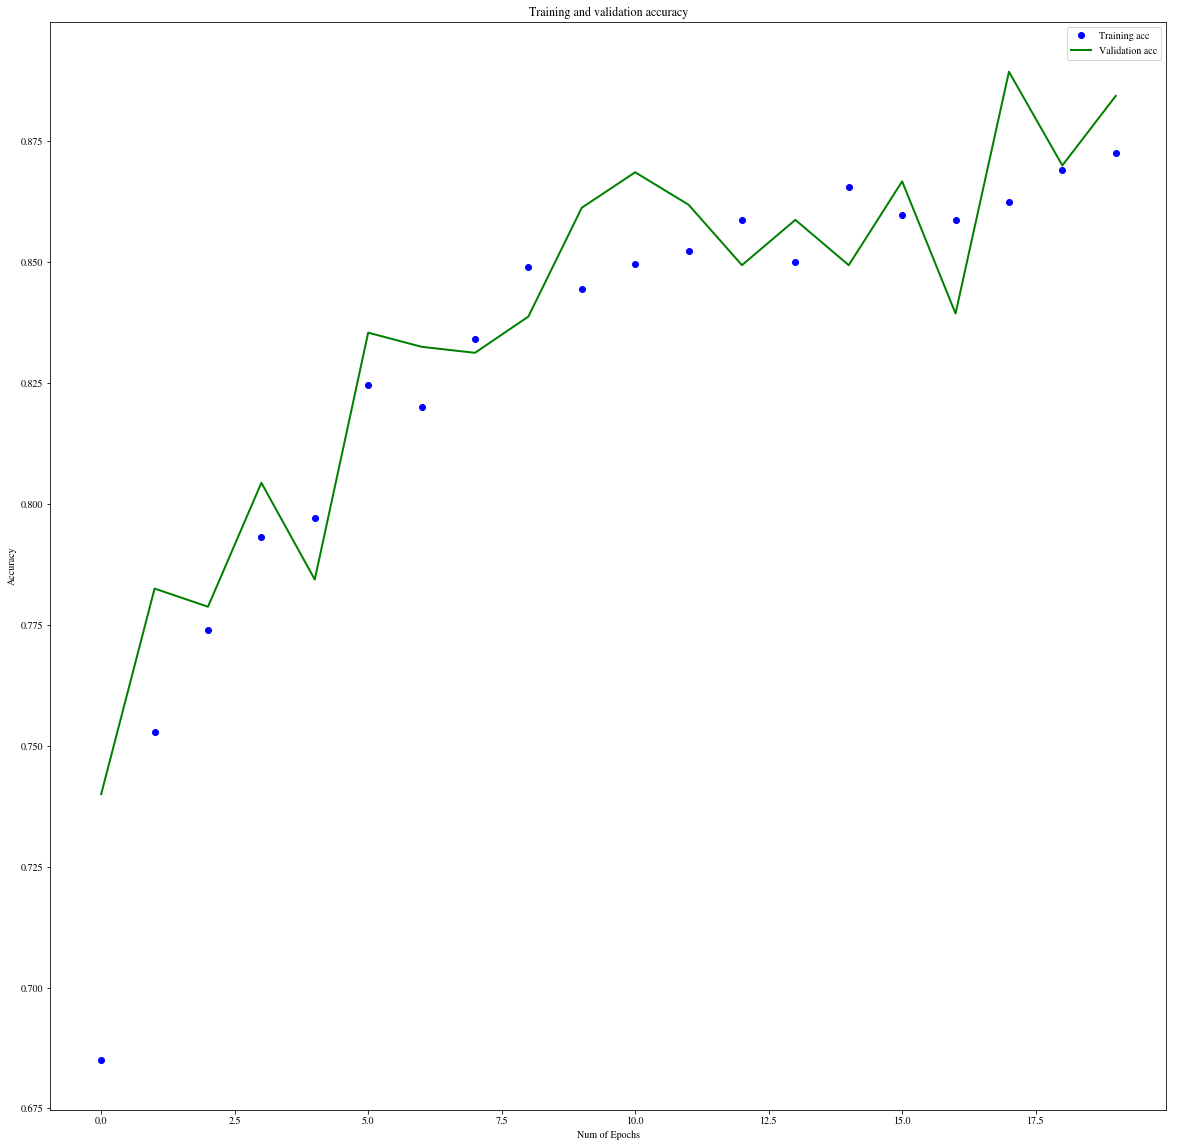

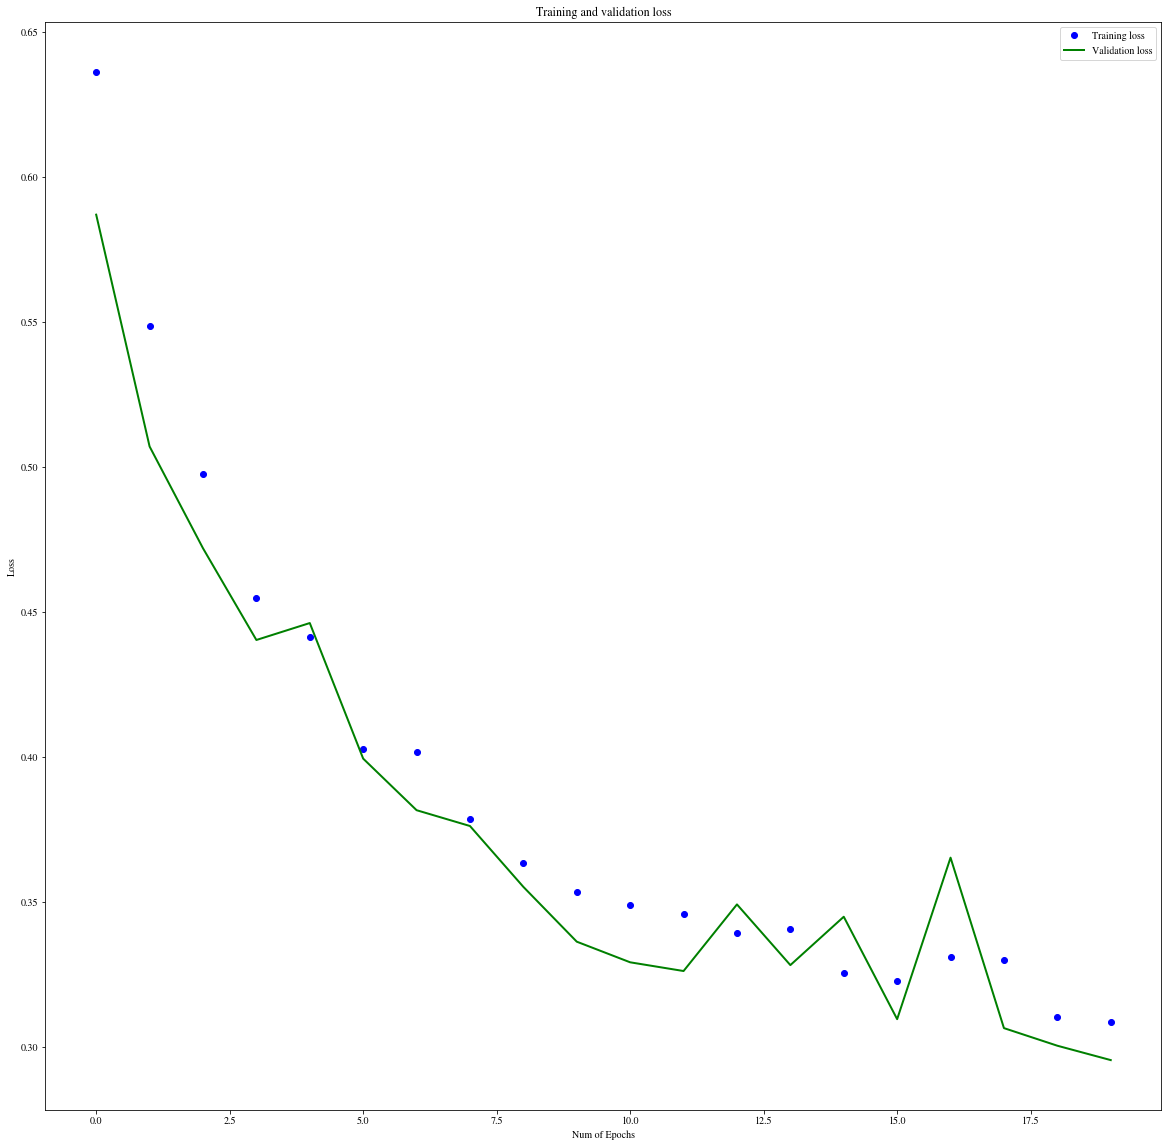

Epoch 1/20
100/100 [==============================] - 12s 116ms/step - loss: 0.6410 - acc: 0.6878 - val_loss: 0.5900 - val_acc: 0.7494
Epoch 2/20
100/100 [==============================] - 11s 109ms/step - loss: 0.5199 - acc: 0.7876 - val_loss: 0.5004 - val_acc: 0.7706
Epoch 3/20
100/100 [==============================] - 10s 101ms/step - loss: 0.4750 - acc: 0.7784 - val_loss: 0.4322 - val_acc: 0.8100
Epoch 4/20
100/100 [==============================] - 9s 86ms/step - loss: 0.4184 - acc: 0.8213 - val_loss: 0.3892 - val_acc: 0.8438
Epoch 5/20
100/100 [==============================] - 9s 93ms/step - loss: 0.4041 - acc: 0.8256 - val_loss: 0.3722 - val_acc: 0.8531
Epoch 6/20
100/100 [==============================] - 10s 96ms/step - loss: 0.3718 - acc: 0.8397 - val_loss: 0.3555 - val_acc: 0.8523
Epoch 7/20
100/100 [==============================] - 9s 95ms/step - loss: 0.3473 - acc: 0.8566 - val_loss: 0.3309 - val_acc: 0.8638
Epoch 8/20
100/100 [==============================] - 11s 112m

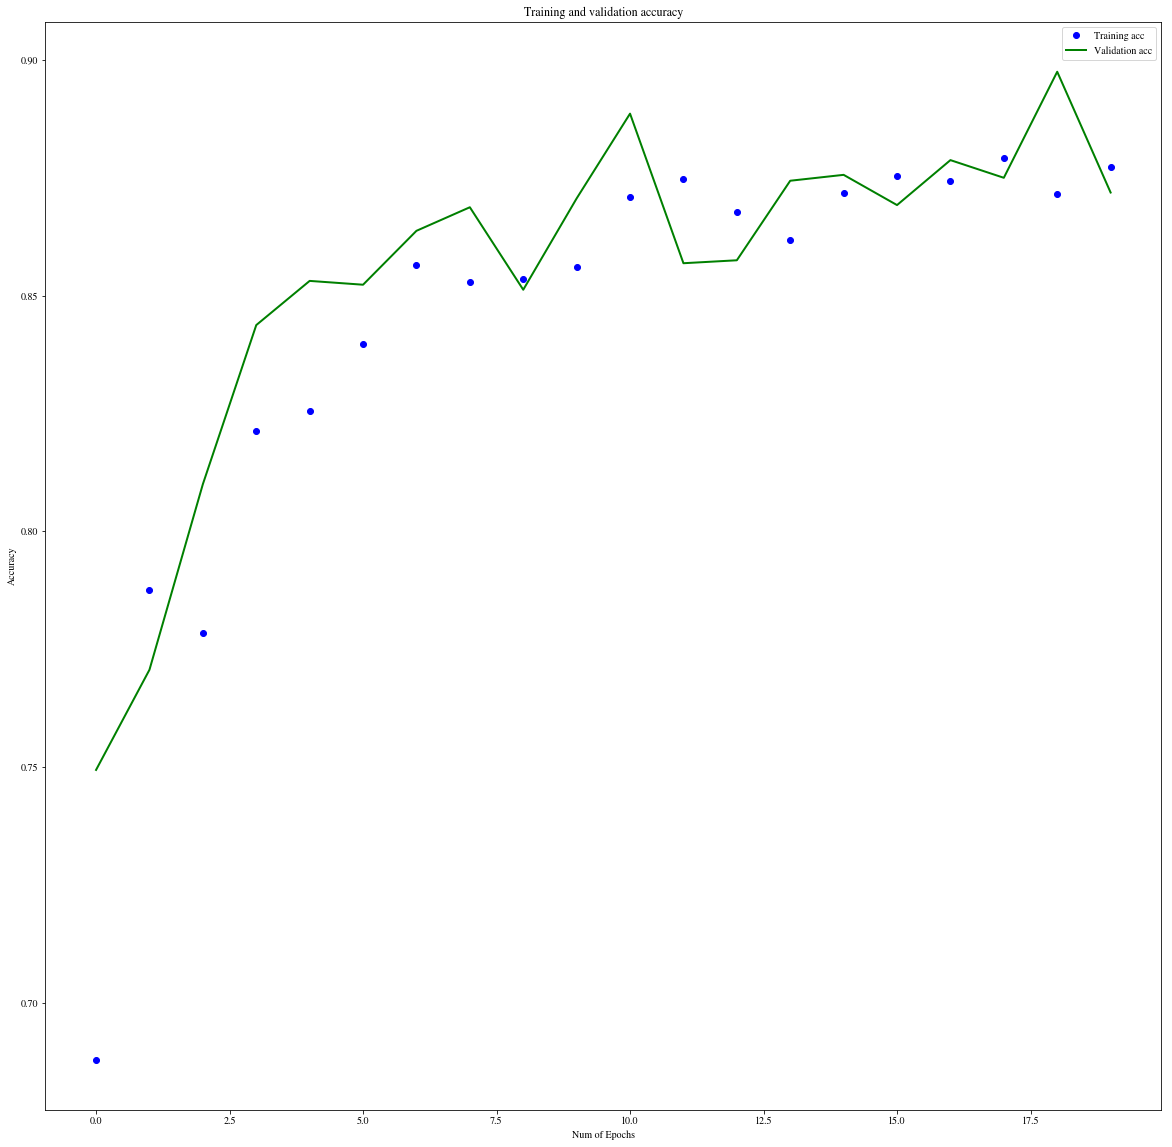

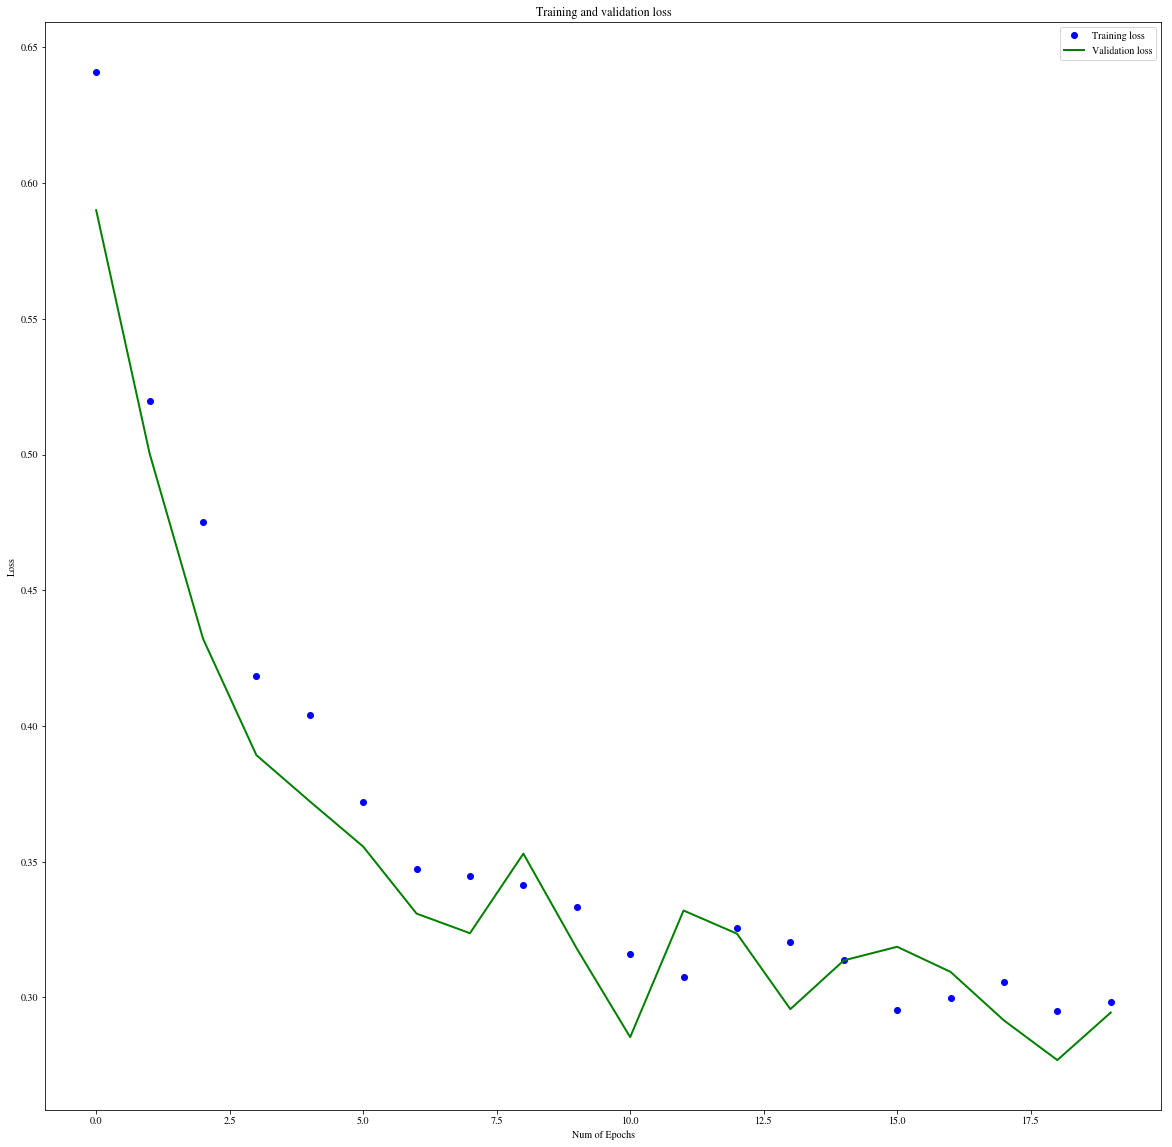

Epoch 1/20
100/100 [==============================] - 10s 100ms/step - loss: 0.6177 - acc: 0.6863 - val_loss: 0.5608 - val_acc: 0.7137
Epoch 2/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5205 - acc: 0.7506 - val_loss: 0.4732 - val_acc: 0.7762
Epoch 3/20
100/100 [==============================] - 8s 82ms/step - loss: 0.4638 - acc: 0.7791 - val_loss: 0.4367 - val_acc: 0.7981 loss: 0.4620 - acc:  - ETA: 1s - loss: 0.4606 - - ETA: 1s - loss: 0.4647 - acc: 0. - ETA: 0s - loss: 0.4611 
Epoch 4/20
100/100 [==============================] - 9s 90ms/step - loss: 0.4264 - acc: 0.8034 - val_loss: 0.4056 - val_acc: 0.8175
Epoch 5/20
100/100 [==============================] - 8s 79ms/step - loss: 0.4086 - acc: 0.8131 - val_loss: 0.3956 - val_acc: 0.8200
Epoch 6/20
100/100 [==============================] - 10s 100ms/step - loss: 0.3987 - acc: 0.8225 - val_loss: 0.3674 - val_acc: 0.8392
Epoch 7/20
100/100 [==============================] - 10s 101ms/step - loss: 0.3668 - acc

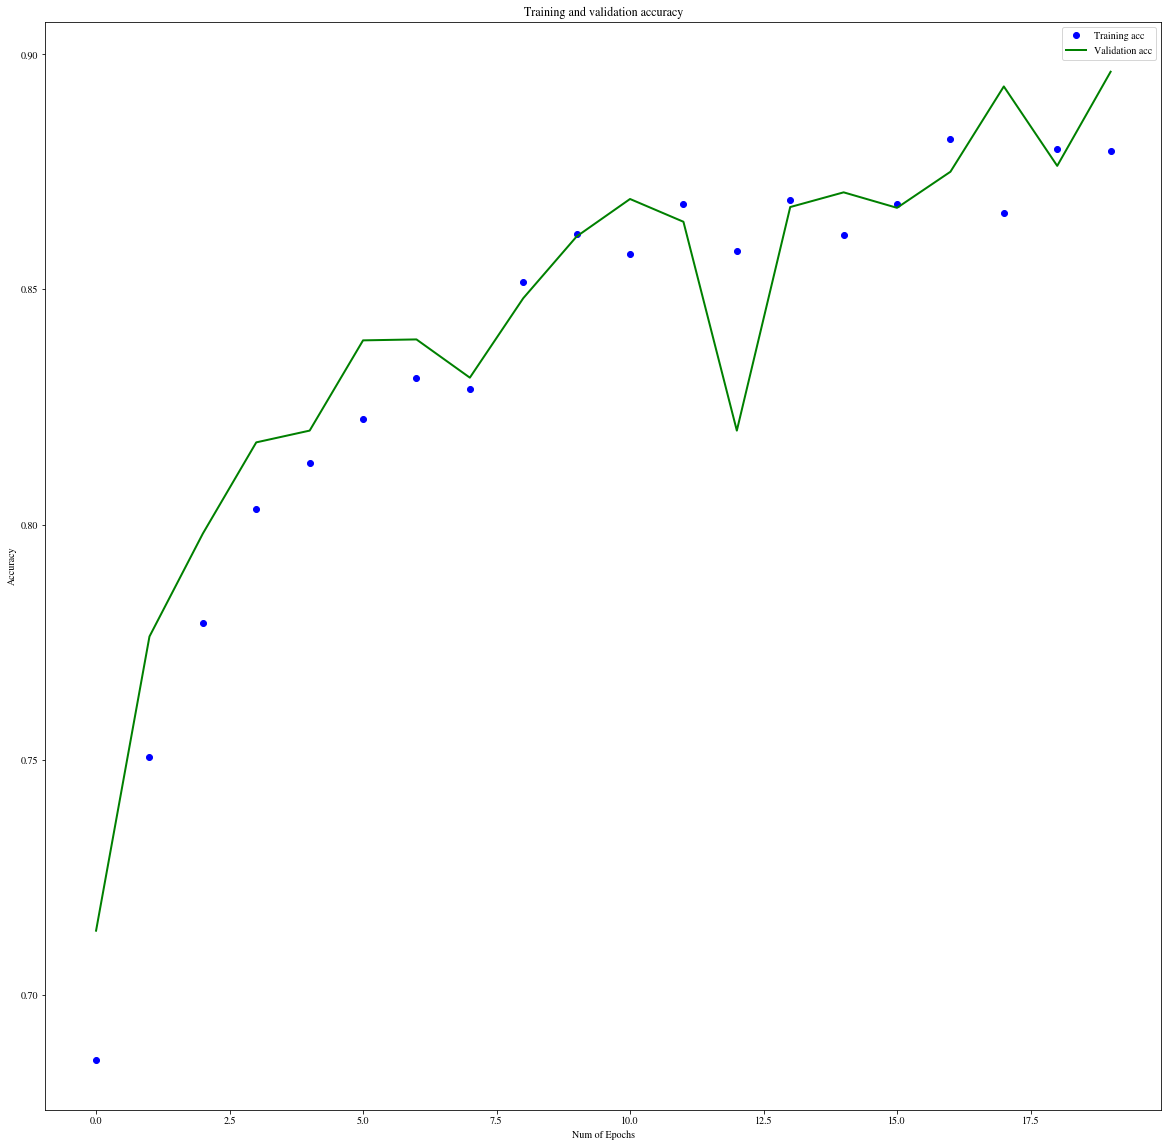

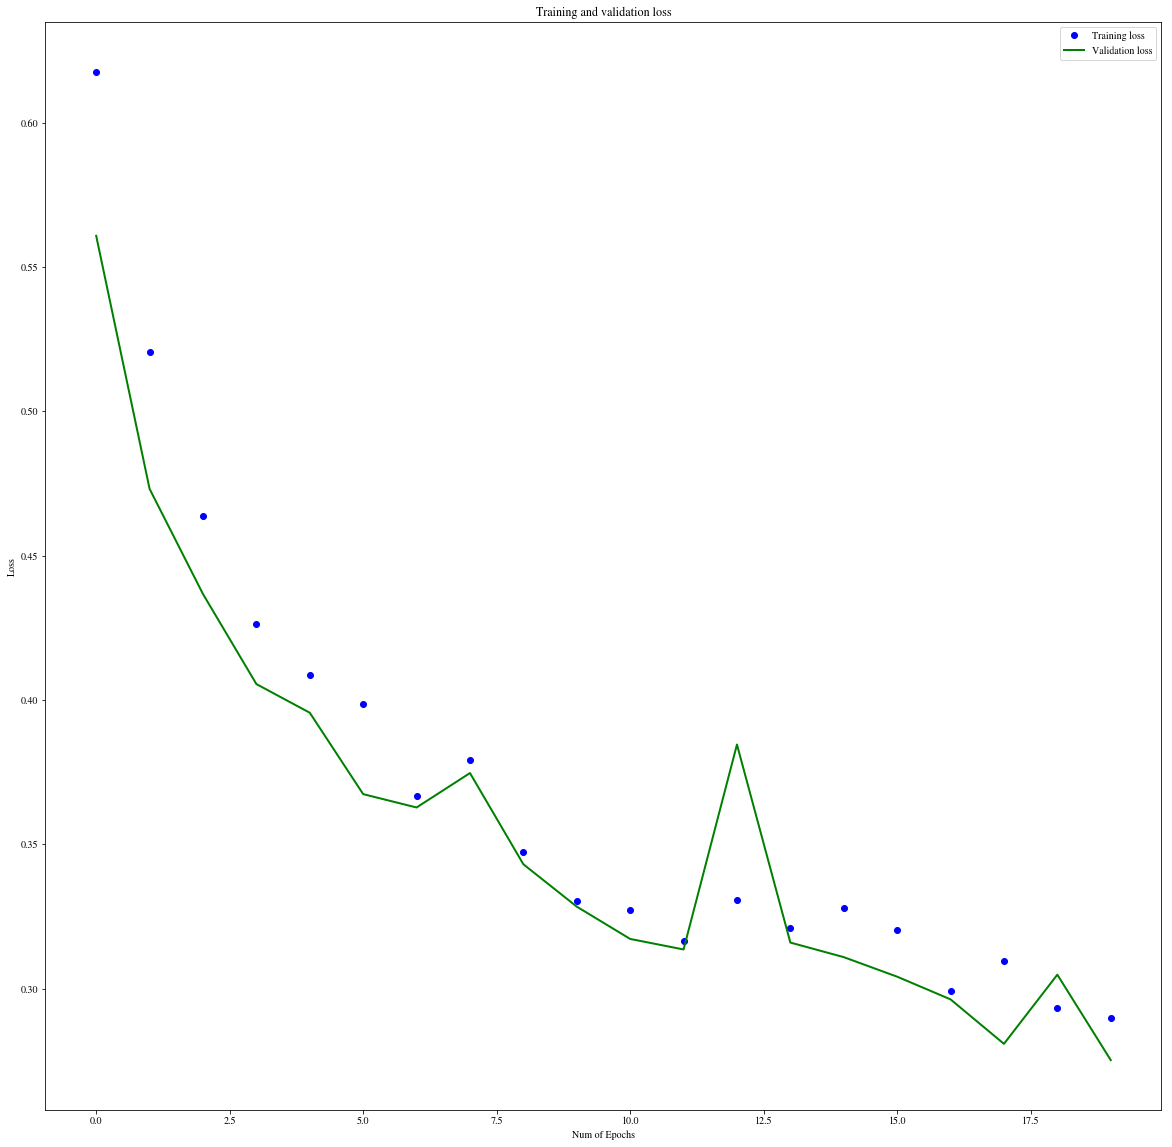

Epoch 1/20
100/100 [==============================] - 10s 105ms/step - loss: 0.6331 - acc: 0.6675 - val_loss: 0.5415 - val_acc: 0.7375
Epoch 2/20
100/100 [==============================] - 8s 80ms/step - loss: 0.4853 - acc: 0.7741 - val_loss: 0.4229 - val_acc: 0.8081
Epoch 3/20
100/100 [==============================] - 8s 82ms/step - loss: 0.4129 - acc: 0.8103 - val_loss: 0.5177 - val_acc: 0.7600
Epoch 4/20
100/100 [==============================] - 7s 72ms/step - loss: 0.3559 - acc: 0.8369 - val_loss: 0.3944 - val_acc: 0.8063
Epoch 5/20
100/100 [==============================] - 8s 80ms/step - loss: 0.3386 - acc: 0.8506 - val_loss: 0.3522 - val_acc: 0.8562
Epoch 6/20
100/100 [==============================] - 10s 96ms/step - loss: 0.3187 - acc: 0.8563 - val_loss: 0.2725 - val_acc: 0.8849
Epoch 7/20
100/100 [==============================] - 11s 107ms/step - loss: 0.3037 - acc: 0.8669 - val_loss: 0.2869 - val_acc: 0.8831
Epoch 8/20
100/100 [==============================] - 14s 136ms/

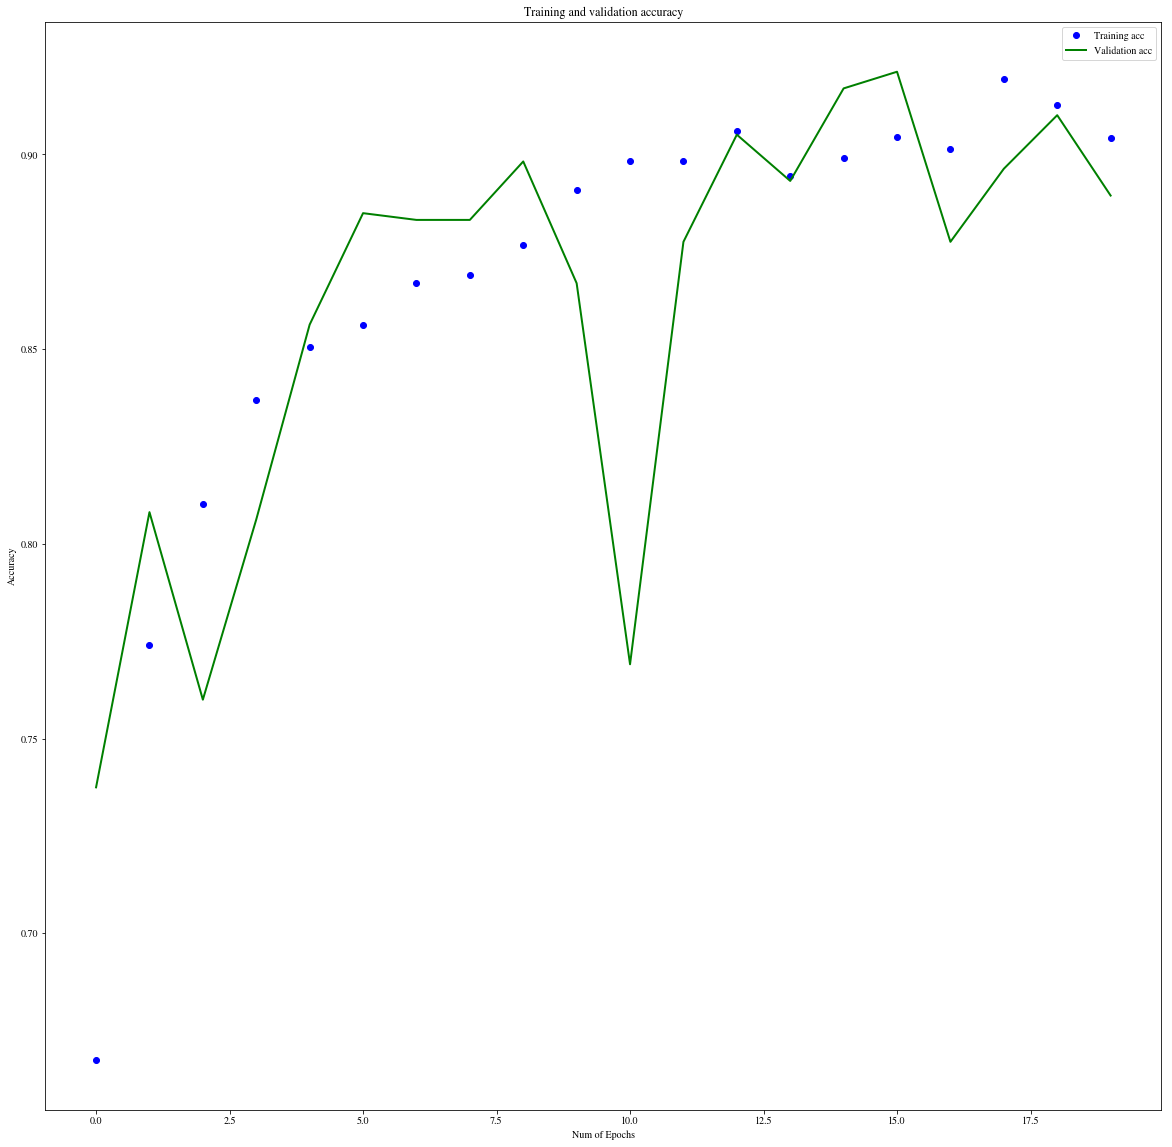

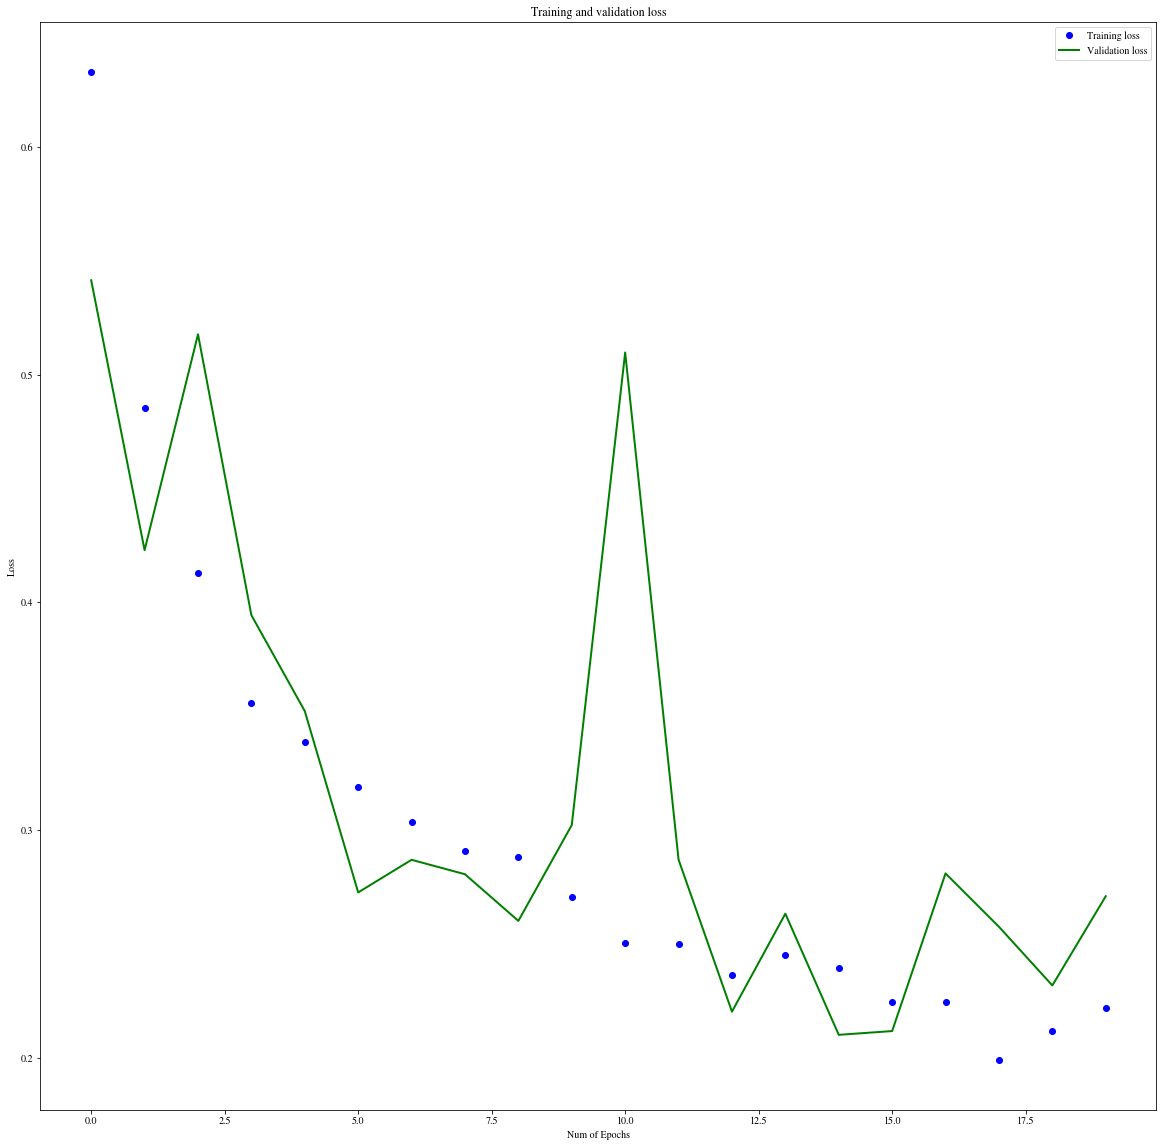

In [17]:
CNN_Parameter_Tuning_3('relu', 'sigmoid')

#### 3.4 The Interpretation of Results for Parameter Tuning
<span style="color:blue">
The number of optimal batch size: Based on the accuracy and loss of training, validation, and test sets, we found that the optimal batch size is 16. Increasing the batch size does NOT apparently improve the results, which is not worth the additional computational cost. Besides, the optimal learning rate for the Adadelta optimizer is 0.1, and the optimal decay factor for the Adadelta optimizer is 1. 
</span>

## Assess the best model on the test data.

In [8]:
K.clear_session()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size = 16,
    class_mode='binary'
)


for train_data_batch, train_labels_batch in train_generator:
    print('data batch shape:', train_data_batch.shape)
    print('labels batch shape:', train_labels_batch.shape)
    break
    
Adadelta = optimizers.Adadelta(lr=0.1, rho = 1, epsilon=None, decay=0.0)
        
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu',
                            input_shape=train_data_batch.shape[1:], name = 'conv1'))
        
model.add(layers.MaxPooling2D((2, 2), name='max_pool1'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name = 'conv2'))
model.add(layers.MaxPooling2D((2, 2), name='max_pool2'))
model.add(layers.Flatten())

model.add(layers.Dense(16, kernel_initializer='glorot_uniform', activation='relu', 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc1'))
model.add(layers.Dropout(0, noise_shape=None, seed=None))
        
model.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', 
                                  kernel_regularizer=keras.regularizers.l2(0.00001), activity_regularizer=keras.regularizers.l1(0.00001), name='fc2'))
model.add(layers.Dropout(0, noise_shape=None, seed=None))
        
model.compile(loss='binary_crossentropy', optimizer = Adadelta, metrics=['accuracy'])
        
# Fit the model        
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
)

prediction = model.predict_generator(test_generator, steps=len(test_generator))

Found 16315 images belonging to 2 classes.
data batch shape: (16, 64, 64, 3)
labels batch shape: (16,)
Epoch 1/40
100/100 [==============================] - 12s 123ms/step - loss: 0.6077 - acc: 0.6781 - val_loss: 0.7376 - val_acc: 0.5169
Epoch 2/40
100/100 [==============================] - 7s 72ms/step - loss: 0.5595 - acc: 0.7100 - val_loss: 0.4708 - val_acc: 0.7538
Epoch 3/40
100/100 [==============================] - 7s 74ms/step - loss: 0.4652 - acc: 0.7800 - val_loss: 0.4334 - val_acc: 0.8106
Epoch 4/40
100/100 [==============================] - 10s 96ms/step - loss: 0.4044 - acc: 0.8022 - val_loss: 0.5124 - val_acc: 0.7206
Epoch 5/40
100/100 [==============================] - 12s 116ms/step - loss: 0.3915 - acc: 0.8044 - val_loss: 0.3226 - val_acc: 0.8556
Epoch 6/40
100/100 [==============================] - 8s 76ms/step - loss: 0.3839 - acc: 0.8312 - val_loss: 0.3594 - val_acc: 0.8423
Epoch 7/40
100/100 [==============================] - 8s 82ms/step - loss: 0.3587 - acc: 0.833

In [9]:
# Change the predictions on the test set to a list "prediction_list". 
new_prediction = []
for i in range (0, len(prediction)):
    new_prediction.append(prediction[i][0])
prediction_list = []
for predict_value in new_prediction:
    if predict_value >= 0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)
        
# Collect all of the labels in the test set into a list "test_value_list".
test_value_list = []
for i in range(0 , len(test_generator)):
    test_value_list.extend(test_generator[i][1].tolist())

### (A) The corresponding AUC curve

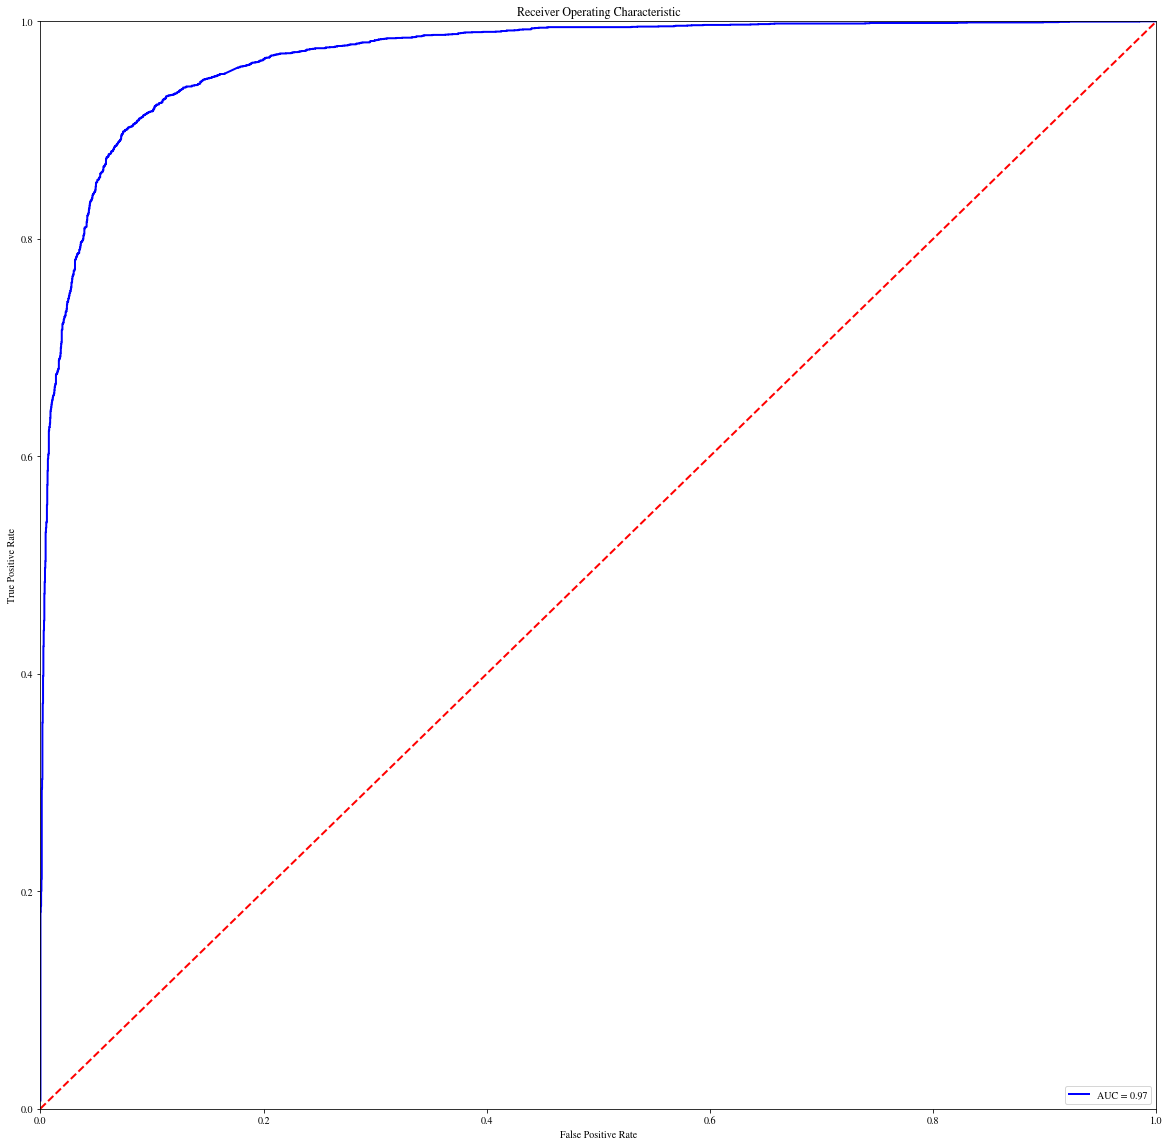

In [10]:
# Plot the AUC
fpr, tpr, threshold = metrics.roc_curve(test_value_list, new_prediction)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<span style="color:blue">
The AUC curve of the assessment of the best model on the test data is demonstated above. The value of AUC is 0.97, which represents a good test. 
</span>

### (B) The number of misclassified Images (on the test set data)

In [14]:
misclassified_portrait = []
misclassified_landscape = []
for i in range (0, len(prediction)):
    if test_value_list[i] == prediction_list[i]:
        pass
    elif prediction_list[i] == 0:  # Misclassify portrait as landsapce
        misclassified_portrait.append(i)
    else:                         # Misclassify landsapce as portrait
        misclassified_landscape.append(i)
        
print('The number of portrait misclassified as landsapce', len(misclassified_portrait))
print('The number of landscape misclassified as portrait', len(misclassified_landscape))

The number of portrait misclassified as landsapce 510
The number of landscape misclassified as portrait 229
